# CNN Model 9

**This notebook will build the following model**:
- Use only 50% of the data? Yes
- Batch Size: 32
- Batch Normalization: Yes, after every convolution
- Early Stopping: Yes, patience=3
- Reduce Learning Rate: Yes, patience=1
- Initial Learning Rate: 0.0001
- Epochs (max): 15
- Architecture:
    - Feature Extractor: \[Convolution -> Convolution -> Max Pool] repeated 3 times.
        - Relu activation function throughout
        - 2x2 pooling size
        - 3x3 filter size throughout
        - Filter count per convolution: 32, 64, 128
    - Classifier: 1st dense layer with 256 units and 2nd dense layer with 128 units.
        - Sigmoid activation function

In [1]:
from data_pipeline import (prep_data, get_train_val_test_data, create_tensorflow_datasets, predict_on_kaggle_test_set)
from model_helper_functions import map_to_metrics, plot_metric, plot_learning_rate, save_history
import numpy as np
from PIL import Image
from time import time, gmtime
import json
import os
from collections import OrderedDict
import tensorflow as tf
from tensorflow import keras
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.models import Sequential
from keras.optimizers import RMSprop, Adam
from keras import layers
import matplotlib.pyplot as plt

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.25.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


2024-01-28 21:42:01.271677: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-28 21:42:01.315447: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX512F AVX512_VNNI, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
tf.random.set_seed(15)

---

## Prepare Data

In [3]:
BATCH_SIZE = 32

In [4]:
data_dir = '../data'
df, train_val_dir = prep_data(data_dir)

In [5]:
train_df, val_df, test_df = get_train_val_test_data(df, use_half_data=True)
train_ds_str, val_ds_str, test_ds_str, train_ds, val_ds, test_ds = create_tensorflow_datasets(train_df, val_df, test_df, BATCH_SIZE)

Training set: 70%, Validation set: 22.5%, Test set: 7.5%


2024-01-28 21:42:07.715404: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-28 21:42:07.749723: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-28 21:42:07.753395: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

ion/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-28 21:42:07.886098: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-28 21:42:07.887523: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-28 21:42:07.888860: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 20741 MB memory:  -> device: 0, name: NVIDIA A10, pci bus id: 0000:06:00.0, compute capability: 8.6
2024-01-28 21:42:08.267824: I 

In [6]:
image_count = len(list(train_val_dir.glob('*/*.tif')))
print('Total image count:',image_count)
print('Image count equal to dataframe length?', image_count == len(df))

Total image count: 220025
Image count equal to dataframe length? True


In [7]:
num_train_samples = tf.data.experimental.cardinality(train_ds_str).numpy()
num_val_samples = tf.data.experimental.cardinality(val_ds_str).numpy()
num_test_samples = tf.data.experimental.cardinality(test_ds_str).numpy()
print('Number of training samples:',num_train_samples)
print('Number of validation samples::',num_val_samples)
print('Number of test samples:',num_test_samples)

Number of training samples: 77008
Number of validation samples:: 24753
Number of test samples: 8251


In [8]:
example_image = Image.open(df.loc[0, 'path'])
image_shape = np.array(example_image).shape
print('Image shape:', image_shape)

Image shape: (96, 96, 3)


---

## Define Model

In [9]:
MODEL_NAME = 'model9'

In [10]:
model_metrics = OrderedDict([
    ('accuracy', keras.metrics.BinaryAccuracy(name='accuracy')),
    ('auc', keras.metrics.AUC(name='auc')),
])

In [11]:
model_output_dir = './model_checkpoints'
checkpoint_path = f"{model_output_dir}/{MODEL_NAME}/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, verbose=1, save_best_only=True, monitor='val_loss')

In [12]:
# Define parameters for early stopping and learning rate reduction
earlystopper = EarlyStopping(monitor='val_loss', patience=3, verbose=1, restore_best_weights=True)
reducel = ReduceLROnPlateau(monitor='val_loss', patience=1, verbose=1, factor=0.1)

In [13]:
# Model Architecture

model = Sequential()

# Feature Extractor
# N_1
model.add(layers.Conv2D(32, (3, 3), input_shape=image_shape))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))

model.add(layers.Conv2D(32, (3, 3)))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))

model.add(layers.MaxPooling2D((2, 2)))

# N_2
model.add(layers.Conv2D(64, (3, 3)))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))

model.add(layers.Conv2D(64, (3, 3)))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))

model.add(layers.MaxPooling2D((2, 2)))

# N_3
model.add(layers.Conv2D(128, (3, 3)))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))

model.add(layers.Conv2D(128, (3, 3)))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))

model.add(layers.MaxPooling2D((2, 2)))

# Classifier
model.add(layers.Flatten())
model.add(layers.Dense(256))
model.add(layers.Dense(128))
model.add(layers.Dense(1, activation = "sigmoid"))


# Compile Model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss = "binary_crossentropy",
              metrics=list(model_metrics.values()))

model.summary()

Model: "sequential"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 conv2d (Conv2D)             (None, 94, 94, 32)        896       


 batch_normalization (Batch  (None, 94, 94, 32)        128       


 Normalization)                                                  


 activation (Activation)     (None, 94, 94, 32)        0         


 conv2d_1 (Conv2D)           (None, 92, 92, 32)        9248      


 batch_normalization_1 (Bat  (None, 92, 92, 32)        128       


 chNormalization)                                                


 activation_1 (Activation)   (None, 92, 92, 32)        0         


 max_pooling2d (MaxPooling2  (None, 46, 46, 32)        0         


 D)                                                              


 conv2d_2 (Conv2D)           (None, 44, 44, 64)        18496     


 batch_normalization_2 (Bat  (None, 44, 44, 64)        256       


 chNormalization)                                                


 activation_2 (Activation)   (None, 44, 44, 64)        0         


 conv2d_3 (Conv2D)           (None, 42, 42, 64)        36928     


 batch_normalization_3 (Bat  (None, 42, 42, 64)        256       


 chNormalization)                                                


 activation_3 (Activation)   (None, 42, 42, 64)        0         


 max_pooling2d_1 (MaxPoolin  (None, 21, 21, 64)        0         


 g2D)                                                            


 conv2d_4 (Conv2D)           (None, 19, 19, 128)       73856     


 batch_normalization_4 (Bat  (None, 19, 19, 128)       512       


 chNormalization)                                                


 activation_4 (Activation)   (None, 19, 19, 128)       0         


 conv2d_5 (Conv2D)           (None, 17, 17, 128)       147584    


 batch_normalization_5 (Bat  (None, 17, 17, 128)       512       


 chNormalization)                                                


 activation_5 (Activation)   (None, 17, 17, 128)       0         


 max_pooling2d_2 (MaxPoolin  (None, 8, 8, 128)         0         


 g2D)                                                            


 flatten (Flatten)           (None, 8192)              0         


 dense (Dense)               (None, 256)               2097408   


 dense_1 (Dense)             (None, 128)               32896     


 dense_2 (Dense)             (None, 1)                 129       


Total params: 2419233 (9.23 MB)


Trainable params: 2418337 (9.23 MB)


Non-trainable params: 896 (3.50 KB)


_________________________________________________________________


---

## Fit Model

In [14]:
EPOCHS = 15

In [15]:
start_time = time()
history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=EPOCHS,
                    callbacks=[cp_callback, reducel, earlystopper]
                   )
total_time = time() - start_time

Epoch 1/15


2024-01-28 21:42:10.503650: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8902


2024-01-28 21:42:10.764545: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


   1/2407 [..............................] - ETA: 56:46 - loss: 0.8904 - accuracy: 0.4375 - auc: 0.4329

   5/2407 [..............................] - ETA: 30s - loss: 2.1816 - accuracy: 0.5562 - auc: 0.5749  

  10/2407 [..............................] - ETA: 28s - loss: 1.7460 - accuracy: 0.6219 - auc: 0.6440

  15/2407 [..............................] - ETA: 28s - loss: 1.5430 - accuracy: 0.6521 - auc: 0.6829

  20/2407 [..............................] - ETA: 28s - loss: 1.4960 - accuracy: 0.6781 - auc: 0.7054

  25/2407 [..............................] - ETA: 28s - loss: 1.3519 - accuracy: 0.6988 - auc: 0.7361

  30/2407 [..............................] - ETA: 27s - loss: 1.2500 - accuracy: 0.7156 - auc: 0.7521

  35/2407 [..............................] - ETA: 27s - loss: 1.1989 - accuracy: 0.7179 - auc: 0.7534

  40/2407 [..............................] - ETA: 27s - loss: 1.1406 - accuracy: 0.7203 - auc: 0.7592

  45/2407 [..............................] - ETA: 27s - loss: 1.0747 - accuracy: 0.7243 - auc: 0.7640

  50/2407 [..............................] - ETA: 27s - loss: 1.0415 - accuracy: 0.7244 - auc: 0.7623

  55/2407 [..............................] - ETA: 27s - loss: 0.9837 - accuracy: 0.7369 - auc: 0.7725

  60/2407 [..............................] - ETA: 27s - loss: 0.9577 - accuracy: 0.7354 - auc: 0.7744

  65/2407 [..............................] - ETA: 27s - loss: 0.9303 - accuracy: 0.7365 - auc: 0.7771

  70/2407 [..............................] - ETA: 27s - loss: 0.9113 - accuracy: 0.7375 - auc: 0.7772

  75/2407 [..............................] - ETA: 27s - loss: 0.8862 - accuracy: 0.7392 - auc: 0.7787

  80/2407 [..............................] - ETA: 27s - loss: 0.8663 - accuracy: 0.7387 - auc: 0.7800

  85/2407 [>.............................] - ETA: 26s - loss: 0.8505 - accuracy: 0.7393 - auc: 0.7806

  90/2407 [>.............................] - ETA: 26s - loss: 0.8313 - accuracy: 0.7431 - auc: 0.7833

  95/2407 [>.............................] - ETA: 26s - loss: 0.8124 - accuracy: 0.7464 - auc: 0.7875

 100/2407 [>.............................] - ETA: 26s - loss: 0.7984 - accuracy: 0.7494 - auc: 0.7899

 105/2407 [>.............................] - ETA: 26s - loss: 0.7844 - accuracy: 0.7503 - auc: 0.7931

 110/2407 [>.............................] - ETA: 26s - loss: 0.7717 - accuracy: 0.7523 - auc: 0.7964

 115/2407 [>.............................] - ETA: 26s - loss: 0.7678 - accuracy: 0.7527 - auc: 0.7960

 120/2407 [>.............................] - ETA: 26s - loss: 0.7562 - accuracy: 0.7544 - auc: 0.7998

 125/2407 [>.............................] - ETA: 26s - loss: 0.7585 - accuracy: 0.7515 - auc: 0.7970

 130/2407 [>.............................] - ETA: 26s - loss: 0.7513 - accuracy: 0.7514 - auc: 0.7973

 135/2407 [>.............................] - ETA: 26s - loss: 0.7425 - accuracy: 0.7539 - auc: 0.7986

 140/2407 [>.............................] - ETA: 26s - loss: 0.7345 - accuracy: 0.7533 - auc: 0.7995

 145/2407 [>.............................] - ETA: 26s - loss: 0.7351 - accuracy: 0.7506 - auc: 0.7972

 150/2407 [>.............................] - ETA: 26s - loss: 0.7307 - accuracy: 0.7517 - auc: 0.7979

 155/2407 [>.............................] - ETA: 26s - loss: 0.7299 - accuracy: 0.7498 - auc: 0.7972

 160/2407 [>.............................] - ETA: 25s - loss: 0.7328 - accuracy: 0.7459 - auc: 0.7948

 165/2407 [=>............................] - ETA: 25s - loss: 0.7333 - accuracy: 0.7443 - auc: 0.7930

 170/2407 [=>............................] - ETA: 25s - loss: 0.7295 - accuracy: 0.7428 - auc: 0.7934

 175/2407 [=>............................] - ETA: 25s - loss: 0.7272 - accuracy: 0.7437 - auc: 0.7941

 180/2407 [=>............................] - ETA: 25s - loss: 0.7199 - accuracy: 0.7455 - auc: 0.7961

 185/2407 [=>............................] - ETA: 25s - loss: 0.7156 - accuracy: 0.7454 - auc: 0.7969

 190/2407 [=>............................] - ETA: 25s - loss: 0.7082 - accuracy: 0.7469 - auc: 0.7985

 195/2407 [=>............................] - ETA: 25s - loss: 0.7025 - accuracy: 0.7479 - auc: 0.7995

 200/2407 [=>............................] - ETA: 25s - loss: 0.7023 - accuracy: 0.7469 - auc: 0.7981

 205/2407 [=>............................] - ETA: 25s - loss: 0.6996 - accuracy: 0.7471 - auc: 0.7977

 210/2407 [=>............................] - ETA: 25s - loss: 0.6943 - accuracy: 0.7475 - auc: 0.7987

 215/2407 [=>............................] - ETA: 25s - loss: 0.6876 - accuracy: 0.7488 - auc: 0.8002

 220/2407 [=>............................] - ETA: 25s - loss: 0.6846 - accuracy: 0.7499 - auc: 0.8007

 225/2407 [=>............................] - ETA: 25s - loss: 0.6788 - accuracy: 0.7508 - auc: 0.8024

 230/2407 [=>............................] - ETA: 25s - loss: 0.6737 - accuracy: 0.7526 - auc: 0.8045

 235/2407 [=>............................] - ETA: 25s - loss: 0.6686 - accuracy: 0.7541 - auc: 0.8066

 240/2407 [=>............................] - ETA: 25s - loss: 0.6647 - accuracy: 0.7553 - auc: 0.8082

 245/2407 [==>...........................] - ETA: 25s - loss: 0.6587 - accuracy: 0.7569 - auc: 0.8102

 250/2407 [==>...........................] - ETA: 24s - loss: 0.6557 - accuracy: 0.7567 - auc: 0.8108

 255/2407 [==>...........................] - ETA: 24s - loss: 0.6528 - accuracy: 0.7565 - auc: 0.8115

 260/2407 [==>...........................] - ETA: 24s - loss: 0.6504 - accuracy: 0.7576 - auc: 0.8119

 265/2407 [==>...........................] - ETA: 24s - loss: 0.6485 - accuracy: 0.7581 - auc: 0.8121

 270/2407 [==>...........................] - ETA: 24s - loss: 0.6468 - accuracy: 0.7576 - auc: 0.8123

 275/2407 [==>...........................] - ETA: 24s - loss: 0.6435 - accuracy: 0.7572 - auc: 0.8128

 280/2407 [==>...........................] - ETA: 24s - loss: 0.6391 - accuracy: 0.7585 - auc: 0.8141

 285/2407 [==>...........................] - ETA: 24s - loss: 0.6373 - accuracy: 0.7590 - auc: 0.8145

 290/2407 [==>...........................] - ETA: 24s - loss: 0.6384 - accuracy: 0.7583 - auc: 0.8140

 295/2407 [==>...........................] - ETA: 24s - loss: 0.6375 - accuracy: 0.7582 - auc: 0.8143

 300/2407 [==>...........................] - ETA: 24s - loss: 0.6348 - accuracy: 0.7592 - auc: 0.8153

 305/2407 [==>...........................] - ETA: 24s - loss: 0.6355 - accuracy: 0.7584 - auc: 0.8152

 310/2407 [==>...........................] - ETA: 24s - loss: 0.6330 - accuracy: 0.7593 - auc: 0.8163

 315/2407 [==>...........................] - ETA: 24s - loss: 0.6355 - accuracy: 0.7584 - auc: 0.8152

 320/2407 [==>...........................] - ETA: 24s - loss: 0.6365 - accuracy: 0.7574 - auc: 0.8145

 325/2407 [===>..........................] - ETA: 24s - loss: 0.6340 - accuracy: 0.7584 - auc: 0.8153

 330/2407 [===>..........................] - ETA: 24s - loss: 0.6366 - accuracy: 0.7563 - auc: 0.8139

 335/2407 [===>..........................] - ETA: 23s - loss: 0.6365 - accuracy: 0.7561 - auc: 0.8138

 340/2407 [===>..........................] - ETA: 23s - loss: 0.6365 - accuracy: 0.7554 - auc: 0.8132

 345/2407 [===>..........................] - ETA: 23s - loss: 0.6339 - accuracy: 0.7564 - auc: 0.8139

 350/2407 [===>..........................] - ETA: 23s - loss: 0.6337 - accuracy: 0.7560 - auc: 0.8135

 355/2407 [===>..........................] - ETA: 23s - loss: 0.6335 - accuracy: 0.7556 - auc: 0.8133

 360/2407 [===>..........................] - ETA: 23s - loss: 0.6330 - accuracy: 0.7547 - auc: 0.8130

 365/2407 [===>..........................] - ETA: 23s - loss: 0.6310 - accuracy: 0.7556 - auc: 0.8136

 370/2407 [===>..........................] - ETA: 23s - loss: 0.6291 - accuracy: 0.7560 - auc: 0.8141

 375/2407 [===>..........................] - ETA: 23s - loss: 0.6264 - accuracy: 0.7566 - auc: 0.8149

 380/2407 [===>..........................] - ETA: 23s - loss: 0.6253 - accuracy: 0.7564 - auc: 0.8149

 385/2407 [===>..........................] - ETA: 23s - loss: 0.6231 - accuracy: 0.7568 - auc: 0.8156

 390/2407 [===>..........................] - ETA: 23s - loss: 0.6208 - accuracy: 0.7575 - auc: 0.8160

 395/2407 [===>..........................] - ETA: 23s - loss: 0.6195 - accuracy: 0.7578 - auc: 0.8162

 400/2407 [===>..........................] - ETA: 23s - loss: 0.6177 - accuracy: 0.7581 - auc: 0.8166

 405/2407 [====>.........................] - ETA: 23s - loss: 0.6159 - accuracy: 0.7581 - auc: 0.8171

 410/2407 [====>.........................] - ETA: 23s - loss: 0.6142 - accuracy: 0.7583 - auc: 0.8175

 415/2407 [====>.........................] - ETA: 23s - loss: 0.6140 - accuracy: 0.7584 - auc: 0.8170

 420/2407 [====>.........................] - ETA: 22s - loss: 0.6125 - accuracy: 0.7585 - auc: 0.8173

 425/2407 [====>.........................] - ETA: 22s - loss: 0.6110 - accuracy: 0.7588 - auc: 0.8173

 430/2407 [====>.........................] - ETA: 22s - loss: 0.6087 - accuracy: 0.7594 - auc: 0.8179

 435/2407 [====>.........................] - ETA: 22s - loss: 0.6073 - accuracy: 0.7595 - auc: 0.8181

 440/2407 [====>.........................] - ETA: 22s - loss: 0.6056 - accuracy: 0.7597 - auc: 0.8183

 445/2407 [====>.........................] - ETA: 22s - loss: 0.6047 - accuracy: 0.7596 - auc: 0.8184

 450/2407 [====>.........................] - ETA: 22s - loss: 0.6037 - accuracy: 0.7598 - auc: 0.8184

 455/2407 [====>.........................] - ETA: 22s - loss: 0.6019 - accuracy: 0.7602 - auc: 0.8187

 460/2407 [====>.........................] - ETA: 22s - loss: 0.6004 - accuracy: 0.7607 - auc: 0.8189

 465/2407 [====>.........................] - ETA: 22s - loss: 0.5982 - accuracy: 0.7618 - auc: 0.8195

 470/2407 [====>.........................] - ETA: 22s - loss: 0.5964 - accuracy: 0.7619 - auc: 0.8200

 475/2407 [====>.........................] - ETA: 22s - loss: 0.5947 - accuracy: 0.7623 - auc: 0.8205

 480/2407 [====>.........................] - ETA: 22s - loss: 0.5932 - accuracy: 0.7624 - auc: 0.8209

 485/2407 [=====>........................] - ETA: 22s - loss: 0.5914 - accuracy: 0.7630 - auc: 0.8213

 490/2407 [=====>........................] - ETA: 22s - loss: 0.5903 - accuracy: 0.7632 - auc: 0.8216

 495/2407 [=====>........................] - ETA: 22s - loss: 0.5893 - accuracy: 0.7635 - auc: 0.8217

 500/2407 [=====>........................] - ETA: 22s - loss: 0.5878 - accuracy: 0.7641 - auc: 0.8220

 505/2407 [=====>........................] - ETA: 21s - loss: 0.5872 - accuracy: 0.7643 - auc: 0.8220

 510/2407 [=====>........................] - ETA: 21s - loss: 0.5856 - accuracy: 0.7650 - auc: 0.8223

 515/2407 [=====>........................] - ETA: 21s - loss: 0.5834 - accuracy: 0.7657 - auc: 0.8230

 520/2407 [=====>........................] - ETA: 21s - loss: 0.5818 - accuracy: 0.7662 - auc: 0.8236

 525/2407 [=====>........................] - ETA: 21s - loss: 0.5795 - accuracy: 0.7673 - auc: 0.8245

 530/2407 [=====>........................] - ETA: 21s - loss: 0.5771 - accuracy: 0.7682 - auc: 0.8256

 535/2407 [=====>........................] - ETA: 21s - loss: 0.5760 - accuracy: 0.7682 - auc: 0.8260

 540/2407 [=====>........................] - ETA: 21s - loss: 0.5744 - accuracy: 0.7685 - auc: 0.8267

 545/2407 [=====>........................] - ETA: 21s - loss: 0.5736 - accuracy: 0.7687 - auc: 0.8269

 550/2407 [=====>........................] - ETA: 21s - loss: 0.5725 - accuracy: 0.7692 - auc: 0.8274

 555/2407 [=====>........................] - ETA: 21s - loss: 0.5712 - accuracy: 0.7696 - auc: 0.8279

 560/2407 [=====>........................] - ETA: 21s - loss: 0.5697 - accuracy: 0.7700 - auc: 0.8283

 565/2407 [======>.......................] - ETA: 21s - loss: 0.5683 - accuracy: 0.7704 - auc: 0.8289

 570/2407 [======>.......................] - ETA: 21s - loss: 0.5676 - accuracy: 0.7705 - auc: 0.8289

 575/2407 [======>.......................] - ETA: 21s - loss: 0.5668 - accuracy: 0.7706 - auc: 0.8290

 580/2407 [======>.......................] - ETA: 21s - loss: 0.5660 - accuracy: 0.7711 - auc: 0.8292

 585/2407 [======>.......................] - ETA: 21s - loss: 0.5650 - accuracy: 0.7716 - auc: 0.8296

 590/2407 [======>.......................] - ETA: 21s - loss: 0.5650 - accuracy: 0.7712 - auc: 0.8294

 595/2407 [======>.......................] - ETA: 20s - loss: 0.5641 - accuracy: 0.7716 - auc: 0.8298

 600/2407 [======>.......................] - ETA: 20s - loss: 0.5624 - accuracy: 0.7722 - auc: 0.8305

 605/2407 [======>.......................] - ETA: 20s - loss: 0.5622 - accuracy: 0.7721 - auc: 0.8304

 610/2407 [======>.......................] - ETA: 20s - loss: 0.5621 - accuracy: 0.7718 - auc: 0.8302

 615/2407 [======>.......................] - ETA: 20s - loss: 0.5604 - accuracy: 0.7723 - auc: 0.8308

 620/2407 [======>.......................] - ETA: 20s - loss: 0.5596 - accuracy: 0.7727 - auc: 0.8311

 625/2407 [======>.......................] - ETA: 20s - loss: 0.5591 - accuracy: 0.7724 - auc: 0.8310

 630/2407 [======>.......................] - ETA: 20s - loss: 0.5590 - accuracy: 0.7724 - auc: 0.8309

 635/2407 [======>.......................] - ETA: 20s - loss: 0.5584 - accuracy: 0.7724 - auc: 0.8311

 640/2407 [======>.......................] - ETA: 20s - loss: 0.5575 - accuracy: 0.7728 - auc: 0.8312

 645/2407 [=======>......................] - ETA: 20s - loss: 0.5563 - accuracy: 0.7732 - auc: 0.8316

 650/2407 [=======>......................] - ETA: 20s - loss: 0.5554 - accuracy: 0.7736 - auc: 0.8319

 655/2407 [=======>......................] - ETA: 20s - loss: 0.5539 - accuracy: 0.7741 - auc: 0.8326

 660/2407 [=======>......................] - ETA: 20s - loss: 0.5533 - accuracy: 0.7743 - auc: 0.8328

 665/2407 [=======>......................] - ETA: 20s - loss: 0.5526 - accuracy: 0.7746 - auc: 0.8331

 670/2407 [=======>......................] - ETA: 20s - loss: 0.5511 - accuracy: 0.7750 - auc: 0.8336

 675/2407 [=======>......................] - ETA: 20s - loss: 0.5500 - accuracy: 0.7756 - auc: 0.8342

 680/2407 [=======>......................] - ETA: 19s - loss: 0.5490 - accuracy: 0.7757 - auc: 0.8345

 685/2407 [=======>......................] - ETA: 19s - loss: 0.5483 - accuracy: 0.7759 - auc: 0.8348

 690/2407 [=======>......................] - ETA: 19s - loss: 0.5476 - accuracy: 0.7761 - auc: 0.8350

 695/2407 [=======>......................] - ETA: 19s - loss: 0.5473 - accuracy: 0.7760 - auc: 0.8349

 700/2407 [=======>......................] - ETA: 19s - loss: 0.5461 - accuracy: 0.7765 - auc: 0.8354

 705/2407 [=======>......................] - ETA: 19s - loss: 0.5453 - accuracy: 0.7766 - auc: 0.8355

 710/2407 [=======>......................] - ETA: 19s - loss: 0.5447 - accuracy: 0.7765 - auc: 0.8357

 715/2407 [=======>......................] - ETA: 19s - loss: 0.5447 - accuracy: 0.7764 - auc: 0.8355

 720/2407 [=======>......................] - ETA: 19s - loss: 0.5438 - accuracy: 0.7769 - auc: 0.8357

 725/2407 [========>.....................] - ETA: 19s - loss: 0.5426 - accuracy: 0.7771 - auc: 0.8362

 730/2407 [========>.....................] - ETA: 19s - loss: 0.5420 - accuracy: 0.7771 - auc: 0.8364

 735/2407 [========>.....................] - ETA: 19s - loss: 0.5409 - accuracy: 0.7776 - auc: 0.8368

 740/2407 [========>.....................] - ETA: 19s - loss: 0.5404 - accuracy: 0.7775 - auc: 0.8369

 745/2407 [========>.....................] - ETA: 19s - loss: 0.5396 - accuracy: 0.7780 - auc: 0.8370

 750/2407 [========>.....................] - ETA: 19s - loss: 0.5387 - accuracy: 0.7782 - auc: 0.8373

 755/2407 [========>.....................] - ETA: 19s - loss: 0.5378 - accuracy: 0.7789 - auc: 0.8377

 760/2407 [========>.....................] - ETA: 19s - loss: 0.5375 - accuracy: 0.7788 - auc: 0.8377

 765/2407 [========>.....................] - ETA: 18s - loss: 0.5366 - accuracy: 0.7791 - auc: 0.8380

 770/2407 [========>.....................] - ETA: 18s - loss: 0.5365 - accuracy: 0.7791 - auc: 0.8380

 775/2407 [========>.....................] - ETA: 18s - loss: 0.5360 - accuracy: 0.7790 - auc: 0.8380

 780/2407 [========>.....................] - ETA: 18s - loss: 0.5355 - accuracy: 0.7792 - auc: 0.8381

 785/2407 [========>.....................] - ETA: 18s - loss: 0.5352 - accuracy: 0.7791 - auc: 0.8381

 790/2407 [========>.....................] - ETA: 18s - loss: 0.5346 - accuracy: 0.7792 - auc: 0.8382

 795/2407 [========>.....................] - ETA: 18s - loss: 0.5339 - accuracy: 0.7794 - auc: 0.8383

 800/2407 [========>.....................] - ETA: 18s - loss: 0.5333 - accuracy: 0.7797 - auc: 0.8385

 805/2407 [=========>....................] - ETA: 18s - loss: 0.5328 - accuracy: 0.7799 - auc: 0.8386

 810/2407 [=========>....................] - ETA: 18s - loss: 0.5318 - accuracy: 0.7803 - auc: 0.8390

 815/2407 [=========>....................] - ETA: 18s - loss: 0.5311 - accuracy: 0.7806 - auc: 0.8393

 820/2407 [=========>....................] - ETA: 18s - loss: 0.5302 - accuracy: 0.7808 - auc: 0.8397

 825/2407 [=========>....................] - ETA: 18s - loss: 0.5291 - accuracy: 0.7813 - auc: 0.8401

 830/2407 [=========>....................] - ETA: 18s - loss: 0.5282 - accuracy: 0.7817 - auc: 0.8404

 835/2407 [=========>....................] - ETA: 18s - loss: 0.5280 - accuracy: 0.7818 - auc: 0.8405

 840/2407 [=========>....................] - ETA: 18s - loss: 0.5273 - accuracy: 0.7821 - auc: 0.8408

 845/2407 [=========>....................] - ETA: 18s - loss: 0.5268 - accuracy: 0.7823 - auc: 0.8408

 850/2407 [=========>....................] - ETA: 18s - loss: 0.5263 - accuracy: 0.7824 - auc: 0.8411

 855/2407 [=========>....................] - ETA: 17s - loss: 0.5256 - accuracy: 0.7825 - auc: 0.8413

 860/2407 [=========>....................] - ETA: 17s - loss: 0.5250 - accuracy: 0.7827 - auc: 0.8415

 865/2407 [=========>....................] - ETA: 17s - loss: 0.5245 - accuracy: 0.7830 - auc: 0.8417

 870/2407 [=========>....................] - ETA: 17s - loss: 0.5239 - accuracy: 0.7832 - auc: 0.8419

 875/2407 [=========>....................] - ETA: 17s - loss: 0.5236 - accuracy: 0.7833 - auc: 0.8419

 880/2407 [=========>....................] - ETA: 17s - loss: 0.5229 - accuracy: 0.7835 - auc: 0.8422

 885/2407 [==========>...................] - ETA: 17s - loss: 0.5220 - accuracy: 0.7838 - auc: 0.8427

 890/2407 [==========>...................] - ETA: 17s - loss: 0.5212 - accuracy: 0.7840 - auc: 0.8430

 895/2407 [==========>...................] - ETA: 17s - loss: 0.5206 - accuracy: 0.7841 - auc: 0.8433

 900/2407 [==========>...................] - ETA: 17s - loss: 0.5198 - accuracy: 0.7846 - auc: 0.8436

 905/2407 [==========>...................] - ETA: 17s - loss: 0.5191 - accuracy: 0.7848 - auc: 0.8438

 910/2407 [==========>...................] - ETA: 17s - loss: 0.5187 - accuracy: 0.7849 - auc: 0.8440

 915/2407 [==========>...................] - ETA: 17s - loss: 0.5185 - accuracy: 0.7850 - auc: 0.8439

 920/2407 [==========>...................] - ETA: 17s - loss: 0.5177 - accuracy: 0.7852 - auc: 0.8442

 925/2407 [==========>...................] - ETA: 17s - loss: 0.5173 - accuracy: 0.7854 - auc: 0.8444

 930/2407 [==========>...................] - ETA: 17s - loss: 0.5169 - accuracy: 0.7855 - auc: 0.8445

 935/2407 [==========>...................] - ETA: 17s - loss: 0.5163 - accuracy: 0.7857 - auc: 0.8447

 940/2407 [==========>...................] - ETA: 16s - loss: 0.5158 - accuracy: 0.7859 - auc: 0.8449

 945/2407 [==========>...................] - ETA: 16s - loss: 0.5155 - accuracy: 0.7861 - auc: 0.8450

 950/2407 [==========>...................] - ETA: 16s - loss: 0.5151 - accuracy: 0.7863 - auc: 0.8451

 955/2407 [==========>...................] - ETA: 16s - loss: 0.5144 - accuracy: 0.7865 - auc: 0.8453

 960/2407 [==========>...................] - ETA: 16s - loss: 0.5135 - accuracy: 0.7868 - auc: 0.8457

 965/2407 [===========>..................] - ETA: 16s - loss: 0.5133 - accuracy: 0.7870 - auc: 0.8458

 970/2407 [===========>..................] - ETA: 16s - loss: 0.5127 - accuracy: 0.7871 - auc: 0.8461

 975/2407 [===========>..................] - ETA: 16s - loss: 0.5125 - accuracy: 0.7871 - auc: 0.8462

 980/2407 [===========>..................] - ETA: 16s - loss: 0.5122 - accuracy: 0.7873 - auc: 0.8463

 985/2407 [===========>..................] - ETA: 16s - loss: 0.5120 - accuracy: 0.7873 - auc: 0.8463

 990/2407 [===========>..................] - ETA: 16s - loss: 0.5113 - accuracy: 0.7876 - auc: 0.8466

 995/2407 [===========>..................] - ETA: 16s - loss: 0.5115 - accuracy: 0.7876 - auc: 0.8465

1000/2407 [===========>..................] - ETA: 16s - loss: 0.5111 - accuracy: 0.7879 - auc: 0.8466

1005/2407 [===========>..................] - ETA: 16s - loss: 0.5107 - accuracy: 0.7881 - auc: 0.8467

1010/2407 [===========>..................] - ETA: 16s - loss: 0.5100 - accuracy: 0.7884 - auc: 0.8469

1015/2407 [===========>..................] - ETA: 16s - loss: 0.5095 - accuracy: 0.7885 - auc: 0.8471

1020/2407 [===========>..................] - ETA: 16s - loss: 0.5090 - accuracy: 0.7887 - auc: 0.8473

1025/2407 [===========>..................] - ETA: 15s - loss: 0.5084 - accuracy: 0.7888 - auc: 0.8475

1030/2407 [===========>..................] - ETA: 15s - loss: 0.5076 - accuracy: 0.7891 - auc: 0.8479

1035/2407 [===========>..................] - ETA: 15s - loss: 0.5072 - accuracy: 0.7892 - auc: 0.8481

1040/2407 [===========>..................] - ETA: 15s - loss: 0.5070 - accuracy: 0.7891 - auc: 0.8481

1045/2407 [============>.................] - ETA: 15s - loss: 0.5067 - accuracy: 0.7891 - auc: 0.8482

1050/2407 [============>.................] - ETA: 15s - loss: 0.5061 - accuracy: 0.7893 - auc: 0.8484

1055/2407 [============>.................] - ETA: 15s - loss: 0.5056 - accuracy: 0.7894 - auc: 0.8486

1060/2407 [============>.................] - ETA: 15s - loss: 0.5047 - accuracy: 0.7897 - auc: 0.8490

1065/2407 [============>.................] - ETA: 15s - loss: 0.5041 - accuracy: 0.7901 - auc: 0.8493

1070/2407 [============>.................] - ETA: 15s - loss: 0.5034 - accuracy: 0.7903 - auc: 0.8496

1075/2407 [============>.................] - ETA: 15s - loss: 0.5031 - accuracy: 0.7905 - auc: 0.8497

1080/2407 [============>.................] - ETA: 15s - loss: 0.5023 - accuracy: 0.7907 - auc: 0.8501

1085/2407 [============>.................] - ETA: 15s - loss: 0.5021 - accuracy: 0.7906 - auc: 0.8502

1090/2407 [============>.................] - ETA: 15s - loss: 0.5023 - accuracy: 0.7907 - auc: 0.8502

1095/2407 [============>.................] - ETA: 15s - loss: 0.5018 - accuracy: 0.7909 - auc: 0.8504

1100/2407 [============>.................] - ETA: 15s - loss: 0.5014 - accuracy: 0.7910 - auc: 0.8505

1105/2407 [============>.................] - ETA: 15s - loss: 0.5009 - accuracy: 0.7911 - auc: 0.8507

1110/2407 [============>.................] - ETA: 15s - loss: 0.5008 - accuracy: 0.7910 - auc: 0.8506

1115/2407 [============>.................] - ETA: 14s - loss: 0.5003 - accuracy: 0.7913 - auc: 0.8508

1120/2407 [============>.................] - ETA: 14s - loss: 0.5001 - accuracy: 0.7913 - auc: 0.8508

1125/2407 [=============>................] - ETA: 14s - loss: 0.4997 - accuracy: 0.7914 - auc: 0.8510

1130/2407 [=============>................] - ETA: 14s - loss: 0.4992 - accuracy: 0.7916 - auc: 0.8512

1135/2407 [=============>................] - ETA: 14s - loss: 0.4988 - accuracy: 0.7919 - auc: 0.8513

1140/2407 [=============>................] - ETA: 14s - loss: 0.4982 - accuracy: 0.7920 - auc: 0.8516

1145/2407 [=============>................] - ETA: 14s - loss: 0.4977 - accuracy: 0.7921 - auc: 0.8518

1150/2407 [=============>................] - ETA: 14s - loss: 0.4973 - accuracy: 0.7921 - auc: 0.8519

1155/2407 [=============>................] - ETA: 14s - loss: 0.4971 - accuracy: 0.7921 - auc: 0.8520

1160/2407 [=============>................] - ETA: 14s - loss: 0.4963 - accuracy: 0.7925 - auc: 0.8524

1165/2407 [=============>................] - ETA: 14s - loss: 0.4960 - accuracy: 0.7926 - auc: 0.8525

1170/2407 [=============>................] - ETA: 14s - loss: 0.4958 - accuracy: 0.7925 - auc: 0.8526

1175/2407 [=============>................] - ETA: 14s - loss: 0.4951 - accuracy: 0.7928 - auc: 0.8529

1180/2407 [=============>................] - ETA: 14s - loss: 0.4952 - accuracy: 0.7926 - auc: 0.8528

1185/2407 [=============>................] - ETA: 14s - loss: 0.4946 - accuracy: 0.7928 - auc: 0.8531

1190/2407 [=============>................] - ETA: 14s - loss: 0.4943 - accuracy: 0.7929 - auc: 0.8533

1195/2407 [=============>................] - ETA: 14s - loss: 0.4937 - accuracy: 0.7932 - auc: 0.8536

1200/2407 [=============>................] - ETA: 13s - loss: 0.4933 - accuracy: 0.7933 - auc: 0.8537

1205/2407 [==============>...............] - ETA: 13s - loss: 0.4928 - accuracy: 0.7935 - auc: 0.8540

1210/2407 [==============>...............] - ETA: 13s - loss: 0.4920 - accuracy: 0.7939 - auc: 0.8544

1215/2407 [==============>...............] - ETA: 13s - loss: 0.4916 - accuracy: 0.7941 - auc: 0.8546

1220/2407 [==============>...............] - ETA: 13s - loss: 0.4910 - accuracy: 0.7944 - auc: 0.8549

1225/2407 [==============>...............] - ETA: 13s - loss: 0.4910 - accuracy: 0.7944 - auc: 0.8548

1230/2407 [==============>...............] - ETA: 13s - loss: 0.4907 - accuracy: 0.7945 - auc: 0.8549

1235/2407 [==============>...............] - ETA: 13s - loss: 0.4903 - accuracy: 0.7947 - auc: 0.8551

1240/2407 [==============>...............] - ETA: 13s - loss: 0.4899 - accuracy: 0.7949 - auc: 0.8553

1245/2407 [==============>...............] - ETA: 13s - loss: 0.4896 - accuracy: 0.7950 - auc: 0.8554

1250/2407 [==============>...............] - ETA: 13s - loss: 0.4894 - accuracy: 0.7950 - auc: 0.8554

1255/2407 [==============>...............] - ETA: 13s - loss: 0.4891 - accuracy: 0.7950 - auc: 0.8556

1260/2407 [==============>...............] - ETA: 13s - loss: 0.4886 - accuracy: 0.7952 - auc: 0.8558

1265/2407 [==============>...............] - ETA: 13s - loss: 0.4881 - accuracy: 0.7954 - auc: 0.8560

1270/2407 [==============>...............] - ETA: 13s - loss: 0.4876 - accuracy: 0.7955 - auc: 0.8563

1275/2407 [==============>...............] - ETA: 13s - loss: 0.4871 - accuracy: 0.7958 - auc: 0.8564

1280/2407 [==============>...............] - ETA: 13s - loss: 0.4869 - accuracy: 0.7960 - auc: 0.8565

1285/2407 [===============>..............] - ETA: 12s - loss: 0.4866 - accuracy: 0.7961 - auc: 0.8567

1290/2407 [===============>..............] - ETA: 12s - loss: 0.4861 - accuracy: 0.7962 - auc: 0.8569

1295/2407 [===============>..............] - ETA: 12s - loss: 0.4856 - accuracy: 0.7965 - auc: 0.8571

1300/2407 [===============>..............] - ETA: 12s - loss: 0.4854 - accuracy: 0.7965 - auc: 0.8572

1305/2407 [===============>..............] - ETA: 12s - loss: 0.4851 - accuracy: 0.7966 - auc: 0.8573

1310/2407 [===============>..............] - ETA: 12s - loss: 0.4846 - accuracy: 0.7968 - auc: 0.8575

1315/2407 [===============>..............] - ETA: 12s - loss: 0.4841 - accuracy: 0.7971 - auc: 0.8577

1320/2407 [===============>..............] - ETA: 12s - loss: 0.4836 - accuracy: 0.7972 - auc: 0.8579

1325/2407 [===============>..............] - ETA: 12s - loss: 0.4835 - accuracy: 0.7972 - auc: 0.8580

1330/2407 [===============>..............] - ETA: 12s - loss: 0.4832 - accuracy: 0.7973 - auc: 0.8581

1335/2407 [===============>..............] - ETA: 12s - loss: 0.4827 - accuracy: 0.7975 - auc: 0.8583

1340/2407 [===============>..............] - ETA: 12s - loss: 0.4826 - accuracy: 0.7976 - auc: 0.8583

1345/2407 [===============>..............] - ETA: 12s - loss: 0.4823 - accuracy: 0.7976 - auc: 0.8584

1350/2407 [===============>..............] - ETA: 12s - loss: 0.4822 - accuracy: 0.7974 - auc: 0.8584

1355/2407 [===============>..............] - ETA: 12s - loss: 0.4820 - accuracy: 0.7974 - auc: 0.8585

1360/2407 [===============>..............] - ETA: 12s - loss: 0.4818 - accuracy: 0.7975 - auc: 0.8585

1365/2407 [================>.............] - ETA: 12s - loss: 0.4819 - accuracy: 0.7973 - auc: 0.8584

1370/2407 [================>.............] - ETA: 12s - loss: 0.4816 - accuracy: 0.7973 - auc: 0.8585

1375/2407 [================>.............] - ETA: 11s - loss: 0.4816 - accuracy: 0.7972 - auc: 0.8585

1380/2407 [================>.............] - ETA: 11s - loss: 0.4816 - accuracy: 0.7972 - auc: 0.8585

1385/2407 [================>.............] - ETA: 11s - loss: 0.4813 - accuracy: 0.7972 - auc: 0.8586

1390/2407 [================>.............] - ETA: 11s - loss: 0.4808 - accuracy: 0.7975 - auc: 0.8588

1395/2407 [================>.............] - ETA: 11s - loss: 0.4807 - accuracy: 0.7976 - auc: 0.8588

1400/2407 [================>.............] - ETA: 11s - loss: 0.4804 - accuracy: 0.7978 - auc: 0.8589

1405/2407 [================>.............] - ETA: 11s - loss: 0.4797 - accuracy: 0.7982 - auc: 0.8592

1410/2407 [================>.............] - ETA: 11s - loss: 0.4795 - accuracy: 0.7981 - auc: 0.8592

1415/2407 [================>.............] - ETA: 11s - loss: 0.4794 - accuracy: 0.7981 - auc: 0.8592

1420/2407 [================>.............] - ETA: 11s - loss: 0.4790 - accuracy: 0.7983 - auc: 0.8594

1425/2407 [================>.............] - ETA: 11s - loss: 0.4787 - accuracy: 0.7984 - auc: 0.8596

1430/2407 [================>.............] - ETA: 11s - loss: 0.4786 - accuracy: 0.7985 - auc: 0.8596

1435/2407 [================>.............] - ETA: 11s - loss: 0.4781 - accuracy: 0.7986 - auc: 0.8599

1440/2407 [================>.............] - ETA: 11s - loss: 0.4778 - accuracy: 0.7986 - auc: 0.8600

1445/2407 [=================>............] - ETA: 11s - loss: 0.4775 - accuracy: 0.7986 - auc: 0.8602

1450/2407 [=================>............] - ETA: 11s - loss: 0.4773 - accuracy: 0.7986 - auc: 0.8603

1455/2407 [=================>............] - ETA: 11s - loss: 0.4770 - accuracy: 0.7986 - auc: 0.8604

1460/2407 [=================>............] - ETA: 10s - loss: 0.4767 - accuracy: 0.7988 - auc: 0.8605

1465/2407 [=================>............] - ETA: 10s - loss: 0.4765 - accuracy: 0.7988 - auc: 0.8605

1470/2407 [=================>............] - ETA: 10s - loss: 0.4763 - accuracy: 0.7989 - auc: 0.8606

1475/2407 [=================>............] - ETA: 10s - loss: 0.4763 - accuracy: 0.7989 - auc: 0.8606

1480/2407 [=================>............] - ETA: 10s - loss: 0.4761 - accuracy: 0.7990 - auc: 0.8607

1485/2407 [=================>............] - ETA: 10s - loss: 0.4760 - accuracy: 0.7990 - auc: 0.8607

1490/2407 [=================>............] - ETA: 10s - loss: 0.4757 - accuracy: 0.7991 - auc: 0.8608

1495/2407 [=================>............] - ETA: 10s - loss: 0.4754 - accuracy: 0.7991 - auc: 0.8610

1500/2407 [=================>............] - ETA: 10s - loss: 0.4752 - accuracy: 0.7992 - auc: 0.8611

1505/2407 [=================>............] - ETA: 10s - loss: 0.4747 - accuracy: 0.7994 - auc: 0.8613

1510/2407 [=================>............] - ETA: 10s - loss: 0.4742 - accuracy: 0.7997 - auc: 0.8615

1515/2407 [=================>............] - ETA: 10s - loss: 0.4741 - accuracy: 0.7998 - auc: 0.8616

1520/2407 [=================>............] - ETA: 10s - loss: 0.4738 - accuracy: 0.7999 - auc: 0.8618

1525/2407 [==================>...........] - ETA: 10s - loss: 0.4739 - accuracy: 0.7999 - auc: 0.8618

1530/2407 [==================>...........] - ETA: 10s - loss: 0.4736 - accuracy: 0.7999 - auc: 0.8619

1535/2407 [==================>...........] - ETA: 10s - loss: 0.4736 - accuracy: 0.7999 - auc: 0.8619

1540/2407 [==================>...........] - ETA: 10s - loss: 0.4736 - accuracy: 0.7999 - auc: 0.8618

1545/2407 [==================>...........] - ETA: 9s - loss: 0.4735 - accuracy: 0.8000 - auc: 0.8619 

1550/2407 [==================>...........] - ETA: 9s - loss: 0.4733 - accuracy: 0.8000 - auc: 0.8619

1555/2407 [==================>...........] - ETA: 9s - loss: 0.4731 - accuracy: 0.8002 - auc: 0.8619

1560/2407 [==================>...........] - ETA: 9s - loss: 0.4728 - accuracy: 0.8004 - auc: 0.8620

1565/2407 [==================>...........] - ETA: 9s - loss: 0.4726 - accuracy: 0.8004 - auc: 0.8621

1570/2407 [==================>...........] - ETA: 9s - loss: 0.4722 - accuracy: 0.8006 - auc: 0.8623

1575/2407 [==================>...........] - ETA: 9s - loss: 0.4719 - accuracy: 0.8007 - auc: 0.8625

1580/2407 [==================>...........] - ETA: 9s - loss: 0.4715 - accuracy: 0.8008 - auc: 0.8627

1585/2407 [==================>...........] - ETA: 9s - loss: 0.4711 - accuracy: 0.8009 - auc: 0.8629

1590/2407 [==================>...........] - ETA: 9s - loss: 0.4708 - accuracy: 0.8011 - auc: 0.8630

1595/2407 [==================>...........] - ETA: 9s - loss: 0.4707 - accuracy: 0.8011 - auc: 0.8630

1600/2407 [==================>...........] - ETA: 9s - loss: 0.4704 - accuracy: 0.8012 - auc: 0.8632

1605/2407 [===================>..........] - ETA: 9s - loss: 0.4705 - accuracy: 0.8011 - auc: 0.8631

1610/2407 [===================>..........] - ETA: 9s - loss: 0.4700 - accuracy: 0.8013 - auc: 0.8633

1615/2407 [===================>..........] - ETA: 9s - loss: 0.4698 - accuracy: 0.8014 - auc: 0.8634

1620/2407 [===================>..........] - ETA: 9s - loss: 0.4696 - accuracy: 0.8014 - auc: 0.8634

1625/2407 [===================>..........] - ETA: 9s - loss: 0.4694 - accuracy: 0.8015 - auc: 0.8635

1630/2407 [===================>..........] - ETA: 8s - loss: 0.4691 - accuracy: 0.8017 - auc: 0.8637

1635/2407 [===================>..........] - ETA: 8s - loss: 0.4690 - accuracy: 0.8017 - auc: 0.8638

1640/2407 [===================>..........] - ETA: 8s - loss: 0.4689 - accuracy: 0.8017 - auc: 0.8638

1645/2407 [===================>..........] - ETA: 8s - loss: 0.4687 - accuracy: 0.8018 - auc: 0.8639

1650/2407 [===================>..........] - ETA: 8s - loss: 0.4688 - accuracy: 0.8018 - auc: 0.8637

1655/2407 [===================>..........] - ETA: 8s - loss: 0.4685 - accuracy: 0.8020 - auc: 0.8639

1660/2407 [===================>..........] - ETA: 8s - loss: 0.4683 - accuracy: 0.8020 - auc: 0.8640

1665/2407 [===================>..........] - ETA: 8s - loss: 0.4681 - accuracy: 0.8020 - auc: 0.8641

1670/2407 [===================>..........] - ETA: 8s - loss: 0.4679 - accuracy: 0.8021 - auc: 0.8641

1675/2407 [===================>..........] - ETA: 8s - loss: 0.4679 - accuracy: 0.8021 - auc: 0.8641

1680/2407 [===================>..........] - ETA: 8s - loss: 0.4677 - accuracy: 0.8021 - auc: 0.8642

1685/2407 [====================>.........] - ETA: 8s - loss: 0.4677 - accuracy: 0.8020 - auc: 0.8642

1690/2407 [====================>.........] - ETA: 8s - loss: 0.4675 - accuracy: 0.8021 - auc: 0.8643

1695/2407 [====================>.........] - ETA: 8s - loss: 0.4673 - accuracy: 0.8021 - auc: 0.8643

1700/2407 [====================>.........] - ETA: 8s - loss: 0.4671 - accuracy: 0.8022 - auc: 0.8644

1705/2407 [====================>.........] - ETA: 8s - loss: 0.4668 - accuracy: 0.8023 - auc: 0.8646

1710/2407 [====================>.........] - ETA: 8s - loss: 0.4666 - accuracy: 0.8023 - auc: 0.8646

1715/2407 [====================>.........] - ETA: 8s - loss: 0.4662 - accuracy: 0.8025 - auc: 0.8648

1720/2407 [====================>.........] - ETA: 7s - loss: 0.4663 - accuracy: 0.8025 - auc: 0.8647

1725/2407 [====================>.........] - ETA: 7s - loss: 0.4662 - accuracy: 0.8025 - auc: 0.8648

1730/2407 [====================>.........] - ETA: 7s - loss: 0.4661 - accuracy: 0.8026 - auc: 0.8648

1735/2407 [====================>.........] - ETA: 7s - loss: 0.4660 - accuracy: 0.8025 - auc: 0.8649

1740/2407 [====================>.........] - ETA: 7s - loss: 0.4658 - accuracy: 0.8026 - auc: 0.8649

1745/2407 [====================>.........] - ETA: 7s - loss: 0.4656 - accuracy: 0.8027 - auc: 0.8650

1750/2407 [====================>.........] - ETA: 7s - loss: 0.4652 - accuracy: 0.8029 - auc: 0.8652

1755/2407 [====================>.........] - ETA: 7s - loss: 0.4648 - accuracy: 0.8030 - auc: 0.8654

1760/2407 [====================>.........] - ETA: 7s - loss: 0.4646 - accuracy: 0.8031 - auc: 0.8655

1765/2407 [====================>.........] - ETA: 7s - loss: 0.4645 - accuracy: 0.8031 - auc: 0.8655

1770/2407 [=====================>........] - ETA: 7s - loss: 0.4643 - accuracy: 0.8032 - auc: 0.8656

1775/2407 [=====================>........] - ETA: 7s - loss: 0.4641 - accuracy: 0.8034 - auc: 0.8657

1780/2407 [=====================>........] - ETA: 7s - loss: 0.4639 - accuracy: 0.8034 - auc: 0.8658

1785/2407 [=====================>........] - ETA: 7s - loss: 0.4637 - accuracy: 0.8035 - auc: 0.8659

1790/2407 [=====================>........] - ETA: 7s - loss: 0.4633 - accuracy: 0.8036 - auc: 0.8661

1795/2407 [=====================>........] - ETA: 7s - loss: 0.4631 - accuracy: 0.8037 - auc: 0.8662

1800/2407 [=====================>........] - ETA: 7s - loss: 0.4632 - accuracy: 0.8037 - auc: 0.8662

1805/2407 [=====================>........] - ETA: 6s - loss: 0.4632 - accuracy: 0.8036 - auc: 0.8662

1810/2407 [=====================>........] - ETA: 6s - loss: 0.4630 - accuracy: 0.8037 - auc: 0.8663

1815/2407 [=====================>........] - ETA: 6s - loss: 0.4627 - accuracy: 0.8039 - auc: 0.8664

1820/2407 [=====================>........] - ETA: 6s - loss: 0.4624 - accuracy: 0.8040 - auc: 0.8665

1825/2407 [=====================>........] - ETA: 6s - loss: 0.4622 - accuracy: 0.8040 - auc: 0.8667

1830/2407 [=====================>........] - ETA: 6s - loss: 0.4619 - accuracy: 0.8041 - auc: 0.8668

1835/2407 [=====================>........] - ETA: 6s - loss: 0.4616 - accuracy: 0.8042 - auc: 0.8669

1840/2407 [=====================>........] - ETA: 6s - loss: 0.4615 - accuracy: 0.8043 - auc: 0.8669

1845/2407 [=====================>........] - ETA: 6s - loss: 0.4617 - accuracy: 0.8042 - auc: 0.8668

1850/2407 [======================>.......] - ETA: 6s - loss: 0.4616 - accuracy: 0.8041 - auc: 0.8669

1855/2407 [======================>.......] - ETA: 6s - loss: 0.4614 - accuracy: 0.8042 - auc: 0.8669

1860/2407 [======================>.......] - ETA: 6s - loss: 0.4611 - accuracy: 0.8043 - auc: 0.8670

1865/2407 [======================>.......] - ETA: 6s - loss: 0.4610 - accuracy: 0.8044 - auc: 0.8671

1870/2407 [======================>.......] - ETA: 6s - loss: 0.4610 - accuracy: 0.8043 - auc: 0.8671

1875/2407 [======================>.......] - ETA: 6s - loss: 0.4607 - accuracy: 0.8044 - auc: 0.8673

1880/2407 [======================>.......] - ETA: 6s - loss: 0.4604 - accuracy: 0.8044 - auc: 0.8674

1885/2407 [======================>.......] - ETA: 6s - loss: 0.4602 - accuracy: 0.8044 - auc: 0.8675

1890/2407 [======================>.......] - ETA: 5s - loss: 0.4599 - accuracy: 0.8045 - auc: 0.8676

1895/2407 [======================>.......] - ETA: 5s - loss: 0.4599 - accuracy: 0.8045 - auc: 0.8676

1900/2407 [======================>.......] - ETA: 5s - loss: 0.4598 - accuracy: 0.8045 - auc: 0.8676

1905/2407 [======================>.......] - ETA: 5s - loss: 0.4597 - accuracy: 0.8045 - auc: 0.8676

1910/2407 [======================>.......] - ETA: 5s - loss: 0.4593 - accuracy: 0.8046 - auc: 0.8678

1915/2407 [======================>.......] - ETA: 5s - loss: 0.4592 - accuracy: 0.8047 - auc: 0.8679

1920/2407 [======================>.......] - ETA: 5s - loss: 0.4590 - accuracy: 0.8049 - auc: 0.8679

1925/2407 [======================>.......] - ETA: 5s - loss: 0.4587 - accuracy: 0.8050 - auc: 0.8681

1930/2407 [=======================>......] - ETA: 5s - loss: 0.4585 - accuracy: 0.8052 - auc: 0.8682

1935/2407 [=======================>......] - ETA: 5s - loss: 0.4585 - accuracy: 0.8052 - auc: 0.8682

1940/2407 [=======================>......] - ETA: 5s - loss: 0.4586 - accuracy: 0.8050 - auc: 0.8680

1945/2407 [=======================>......] - ETA: 5s - loss: 0.4585 - accuracy: 0.8050 - auc: 0.8681

1950/2407 [=======================>......] - ETA: 5s - loss: 0.4582 - accuracy: 0.8051 - auc: 0.8682

1955/2407 [=======================>......] - ETA: 5s - loss: 0.4580 - accuracy: 0.8053 - auc: 0.8682

1960/2407 [=======================>......] - ETA: 5s - loss: 0.4578 - accuracy: 0.8053 - auc: 0.8683

1965/2407 [=======================>......] - ETA: 5s - loss: 0.4577 - accuracy: 0.8054 - auc: 0.8684

1970/2407 [=======================>......] - ETA: 5s - loss: 0.4574 - accuracy: 0.8055 - auc: 0.8686

1975/2407 [=======================>......] - ETA: 5s - loss: 0.4572 - accuracy: 0.8056 - auc: 0.8686

1980/2407 [=======================>......] - ETA: 4s - loss: 0.4570 - accuracy: 0.8057 - auc: 0.8687

1985/2407 [=======================>......] - ETA: 4s - loss: 0.4569 - accuracy: 0.8057 - auc: 0.8688

1990/2407 [=======================>......] - ETA: 4s - loss: 0.4568 - accuracy: 0.8058 - auc: 0.8688

1995/2407 [=======================>......] - ETA: 4s - loss: 0.4565 - accuracy: 0.8059 - auc: 0.8689

2000/2407 [=======================>......] - ETA: 4s - loss: 0.4564 - accuracy: 0.8060 - auc: 0.8690

2005/2407 [=======================>......] - ETA: 4s - loss: 0.4563 - accuracy: 0.8061 - auc: 0.8690

2010/2407 [========================>.....] - ETA: 4s - loss: 0.4562 - accuracy: 0.8060 - auc: 0.8691

2015/2407 [========================>.....] - ETA: 4s - loss: 0.4562 - accuracy: 0.8061 - auc: 0.8691

2020/2407 [========================>.....] - ETA: 4s - loss: 0.4559 - accuracy: 0.8062 - auc: 0.8692

2025/2407 [========================>.....] - ETA: 4s - loss: 0.4558 - accuracy: 0.8062 - auc: 0.8692

2030/2407 [========================>.....] - ETA: 4s - loss: 0.4557 - accuracy: 0.8062 - auc: 0.8693

2035/2407 [========================>.....] - ETA: 4s - loss: 0.4554 - accuracy: 0.8064 - auc: 0.8694

2040/2407 [========================>.....] - ETA: 4s - loss: 0.4553 - accuracy: 0.8065 - auc: 0.8695

2045/2407 [========================>.....] - ETA: 4s - loss: 0.4548 - accuracy: 0.8067 - auc: 0.8697

2050/2407 [========================>.....] - ETA: 4s - loss: 0.4548 - accuracy: 0.8067 - auc: 0.8697

2055/2407 [========================>.....] - ETA: 4s - loss: 0.4547 - accuracy: 0.8068 - auc: 0.8698

2060/2407 [========================>.....] - ETA: 4s - loss: 0.4546 - accuracy: 0.8068 - auc: 0.8699

2065/2407 [========================>.....] - ETA: 3s - loss: 0.4542 - accuracy: 0.8069 - auc: 0.8701

2070/2407 [========================>.....] - ETA: 3s - loss: 0.4540 - accuracy: 0.8069 - auc: 0.8702

2075/2407 [========================>.....] - ETA: 3s - loss: 0.4539 - accuracy: 0.8069 - auc: 0.8702

2080/2407 [========================>.....] - ETA: 3s - loss: 0.4538 - accuracy: 0.8070 - auc: 0.8703

2085/2407 [========================>.....] - ETA: 3s - loss: 0.4537 - accuracy: 0.8069 - auc: 0.8703

2090/2407 [=========================>....] - ETA: 3s - loss: 0.4533 - accuracy: 0.8071 - auc: 0.8705

2095/2407 [=========================>....] - ETA: 3s - loss: 0.4533 - accuracy: 0.8071 - auc: 0.8704

2100/2407 [=========================>....] - ETA: 3s - loss: 0.4529 - accuracy: 0.8072 - auc: 0.8706

2105/2407 [=========================>....] - ETA: 3s - loss: 0.4528 - accuracy: 0.8073 - auc: 0.8707

2110/2407 [=========================>....] - ETA: 3s - loss: 0.4526 - accuracy: 0.8073 - auc: 0.8708

2115/2407 [=========================>....] - ETA: 3s - loss: 0.4526 - accuracy: 0.8074 - auc: 0.8708

2120/2407 [=========================>....] - ETA: 3s - loss: 0.4525 - accuracy: 0.8073 - auc: 0.8709

2125/2407 [=========================>....] - ETA: 3s - loss: 0.4526 - accuracy: 0.8072 - auc: 0.8708

2130/2407 [=========================>....] - ETA: 3s - loss: 0.4524 - accuracy: 0.8073 - auc: 0.8709

2135/2407 [=========================>....] - ETA: 3s - loss: 0.4522 - accuracy: 0.8073 - auc: 0.8710

2140/2407 [=========================>....] - ETA: 3s - loss: 0.4520 - accuracy: 0.8074 - auc: 0.8711

2144/2407 [=========================>....] - ETA: 3s - loss: 0.4519 - accuracy: 0.8074 - auc: 0.8712

2149/2407 [=========================>....] - ETA: 2s - loss: 0.4516 - accuracy: 0.8075 - auc: 0.8713

2154/2407 [=========================>....] - ETA: 2s - loss: 0.4516 - accuracy: 0.8076 - auc: 0.8713

2159/2407 [=========================>....] - ETA: 2s - loss: 0.4517 - accuracy: 0.8074 - auc: 0.8713

2164/2407 [=========================>....] - ETA: 2s - loss: 0.4517 - accuracy: 0.8074 - auc: 0.8713

2169/2407 [==========================>...] - ETA: 2s - loss: 0.4516 - accuracy: 0.8074 - auc: 0.8713

2174/2407 [==========================>...] - ETA: 2s - loss: 0.4515 - accuracy: 0.8075 - auc: 0.8713

2179/2407 [==========================>...] - ETA: 2s - loss: 0.4512 - accuracy: 0.8075 - auc: 0.8714

2184/2407 [==========================>...] - ETA: 2s - loss: 0.4510 - accuracy: 0.8076 - auc: 0.8716

2189/2407 [==========================>...] - ETA: 2s - loss: 0.4507 - accuracy: 0.8077 - auc: 0.8717

2194/2407 [==========================>...] - ETA: 2s - loss: 0.4503 - accuracy: 0.8079 - auc: 0.8719

2199/2407 [==========================>...] - ETA: 2s - loss: 0.4503 - accuracy: 0.8080 - auc: 0.8720

2204/2407 [==========================>...] - ETA: 2s - loss: 0.4500 - accuracy: 0.8081 - auc: 0.8721

2209/2407 [==========================>...] - ETA: 2s - loss: 0.4500 - accuracy: 0.8081 - auc: 0.8721

2214/2407 [==========================>...] - ETA: 2s - loss: 0.4497 - accuracy: 0.8082 - auc: 0.8723

2219/2407 [==========================>...] - ETA: 2s - loss: 0.4495 - accuracy: 0.8082 - auc: 0.8723

2224/2407 [==========================>...] - ETA: 2s - loss: 0.4494 - accuracy: 0.8083 - auc: 0.8724

2229/2407 [==========================>...] - ETA: 2s - loss: 0.4494 - accuracy: 0.8083 - auc: 0.8723

2234/2407 [==========================>...] - ETA: 2s - loss: 0.4494 - accuracy: 0.8082 - auc: 0.8724

2239/2407 [==========================>...] - ETA: 1s - loss: 0.4493 - accuracy: 0.8082 - auc: 0.8724

2244/2407 [==========================>...] - ETA: 1s - loss: 0.4492 - accuracy: 0.8082 - auc: 0.8724

2249/2407 [===========================>..] - ETA: 1s - loss: 0.4491 - accuracy: 0.8082 - auc: 0.8725

2254/2407 [===========================>..] - ETA: 1s - loss: 0.4490 - accuracy: 0.8082 - auc: 0.8725

2259/2407 [===========================>..] - ETA: 1s - loss: 0.4489 - accuracy: 0.8083 - auc: 0.8726

2264/2407 [===========================>..] - ETA: 1s - loss: 0.4489 - accuracy: 0.8082 - auc: 0.8725

2269/2407 [===========================>..] - ETA: 1s - loss: 0.4488 - accuracy: 0.8082 - auc: 0.8726

2274/2407 [===========================>..] - ETA: 1s - loss: 0.4487 - accuracy: 0.8083 - auc: 0.8726

2279/2407 [===========================>..] - ETA: 1s - loss: 0.4485 - accuracy: 0.8084 - auc: 0.8728

2284/2407 [===========================>..] - ETA: 1s - loss: 0.4484 - accuracy: 0.8084 - auc: 0.8728

2289/2407 [===========================>..] - ETA: 1s - loss: 0.4483 - accuracy: 0.8085 - auc: 0.8729

2294/2407 [===========================>..] - ETA: 1s - loss: 0.4481 - accuracy: 0.8086 - auc: 0.8730

2299/2407 [===========================>..] - ETA: 1s - loss: 0.4480 - accuracy: 0.8086 - auc: 0.8730

2304/2407 [===========================>..] - ETA: 1s - loss: 0.4480 - accuracy: 0.8087 - auc: 0.8730

2309/2407 [===========================>..] - ETA: 1s - loss: 0.4478 - accuracy: 0.8088 - auc: 0.8732

2314/2407 [===========================>..] - ETA: 1s - loss: 0.4476 - accuracy: 0.8087 - auc: 0.8732

2319/2407 [===========================>..] - ETA: 1s - loss: 0.4474 - accuracy: 0.8089 - auc: 0.8734

2324/2407 [===========================>..] - ETA: 0s - loss: 0.4473 - accuracy: 0.8089 - auc: 0.8734

2329/2407 [============================>.] - ETA: 0s - loss: 0.4472 - accuracy: 0.8090 - auc: 0.8735

2334/2407 [============================>.] - ETA: 0s - loss: 0.4470 - accuracy: 0.8091 - auc: 0.8735

2339/2407 [============================>.] - ETA: 0s - loss: 0.4467 - accuracy: 0.8092 - auc: 0.8737

2344/2407 [============================>.] - ETA: 0s - loss: 0.4465 - accuracy: 0.8093 - auc: 0.8738

2349/2407 [============================>.] - ETA: 0s - loss: 0.4464 - accuracy: 0.8093 - auc: 0.8738

2354/2407 [============================>.] - ETA: 0s - loss: 0.4464 - accuracy: 0.8093 - auc: 0.8738

2359/2407 [============================>.] - ETA: 0s - loss: 0.4463 - accuracy: 0.8093 - auc: 0.8738

2364/2407 [============================>.] - ETA: 0s - loss: 0.4462 - accuracy: 0.8093 - auc: 0.8738

2369/2407 [============================>.] - ETA: 0s - loss: 0.4461 - accuracy: 0.8093 - auc: 0.8739

2374/2407 [============================>.] - ETA: 0s - loss: 0.4460 - accuracy: 0.8094 - auc: 0.8740

2379/2407 [============================>.] - ETA: 0s - loss: 0.4457 - accuracy: 0.8095 - auc: 0.8741

2384/2407 [============================>.] - ETA: 0s - loss: 0.4456 - accuracy: 0.8096 - auc: 0.8742

2389/2407 [============================>.] - ETA: 0s - loss: 0.4454 - accuracy: 0.8097 - auc: 0.8743

2394/2407 [============================>.] - ETA: 0s - loss: 0.4452 - accuracy: 0.8098 - auc: 0.8744

2399/2407 [============================>.] - ETA: 0s - loss: 0.4451 - accuracy: 0.8099 - auc: 0.8745

2404/2407 [============================>.] - ETA: 0s - loss: 0.4450 - accuracy: 0.8099 - auc: 0.8745

2407/2407 [==============================] - ETA: 0s - loss: 0.4450 - accuracy: 0.8099 - auc: 0.8745


Epoch 1: val_loss improved from inf to 0.37933, saving model to ./model_checkpoints/model9/cp.ckpt


INFO:tensorflow:Assets written to: ./model_checkpoints/model9/cp.ckpt/assets


INFO:tensorflow:Assets written to: ./model_checkpoints/model9/cp.ckpt/assets


2407/2407 [==============================] - 34s 14ms/step - loss: 0.4450 - accuracy: 0.8099 - auc: 0.8745 - val_loss: 0.3793 - val_accuracy: 0.8457 - val_auc: 0.9165 - lr: 1.0000e-04


Epoch 2/15


   1/2407 [..............................] - ETA: 1:08 - loss: 0.3184 - accuracy: 0.8750 - auc: 0.9531

   6/2407 [..............................] - ETA: 27s - loss: 0.3086 - accuracy: 0.8854 - auc: 0.9529 

  11/2407 [..............................] - ETA: 27s - loss: 0.3355 - accuracy: 0.8722 - auc: 0.9314

  16/2407 [..............................] - ETA: 27s - loss: 0.3827 - accuracy: 0.8379 - auc: 0.9061

  21/2407 [..............................] - ETA: 27s - loss: 0.3679 - accuracy: 0.8408 - auc: 0.9132

  26/2407 [..............................] - ETA: 27s - loss: 0.3595 - accuracy: 0.8462 - auc: 0.9160

  31/2407 [..............................] - ETA: 27s - loss: 0.3587 - accuracy: 0.8488 - auc: 0.9163

  36/2407 [..............................] - ETA: 27s - loss: 0.3557 - accuracy: 0.8533 - auc: 0.9160

  41/2407 [..............................] - ETA: 27s - loss: 0.3621 - accuracy: 0.8514 - auc: 0.9115

  46/2407 [..............................] - ETA: 27s - loss: 0.3697 - accuracy: 0.8438 - auc: 0.9078

  51/2407 [..............................] - ETA: 27s - loss: 0.3724 - accuracy: 0.8413 - auc: 0.9077

  56/2407 [..............................] - ETA: 27s - loss: 0.3732 - accuracy: 0.8415 - auc: 0.9067

  61/2407 [..............................] - ETA: 27s - loss: 0.3712 - accuracy: 0.8417 - auc: 0.9082

  66/2407 [..............................] - ETA: 27s - loss: 0.3747 - accuracy: 0.8371 - auc: 0.9060

  71/2407 [..............................] - ETA: 27s - loss: 0.3720 - accuracy: 0.8389 - auc: 0.9072

  76/2407 [..............................] - ETA: 27s - loss: 0.3689 - accuracy: 0.8396 - auc: 0.9091

  81/2407 [>.............................] - ETA: 26s - loss: 0.3678 - accuracy: 0.8410 - auc: 0.9097

  86/2407 [>.............................] - ETA: 26s - loss: 0.3686 - accuracy: 0.8416 - auc: 0.9099

  91/2407 [>.............................] - ETA: 26s - loss: 0.3693 - accuracy: 0.8400 - auc: 0.9095

  96/2407 [>.............................] - ETA: 26s - loss: 0.3675 - accuracy: 0.8415 - auc: 0.9109

 101/2407 [>.............................] - ETA: 26s - loss: 0.3691 - accuracy: 0.8400 - auc: 0.9102

 106/2407 [>.............................] - ETA: 26s - loss: 0.3709 - accuracy: 0.8390 - auc: 0.9089

 111/2407 [>.............................] - ETA: 26s - loss: 0.3709 - accuracy: 0.8378 - auc: 0.9095

 116/2407 [>.............................] - ETA: 26s - loss: 0.3710 - accuracy: 0.8367 - auc: 0.9097

 121/2407 [>.............................] - ETA: 26s - loss: 0.3720 - accuracy: 0.8365 - auc: 0.9089

 126/2407 [>.............................] - ETA: 26s - loss: 0.3731 - accuracy: 0.8358 - auc: 0.9087

 131/2407 [>.............................] - ETA: 26s - loss: 0.3737 - accuracy: 0.8359 - auc: 0.9087

 136/2407 [>.............................] - ETA: 26s - loss: 0.3747 - accuracy: 0.8348 - auc: 0.9080

 141/2407 [>.............................] - ETA: 26s - loss: 0.3754 - accuracy: 0.8353 - auc: 0.9078

 146/2407 [>.............................] - ETA: 26s - loss: 0.3773 - accuracy: 0.8341 - auc: 0.9071

 151/2407 [>.............................] - ETA: 26s - loss: 0.3763 - accuracy: 0.8340 - auc: 0.9072

 156/2407 [>.............................] - ETA: 26s - loss: 0.3767 - accuracy: 0.8345 - auc: 0.9070

 161/2407 [=>............................] - ETA: 25s - loss: 0.3777 - accuracy: 0.8354 - auc: 0.9067

 166/2407 [=>............................] - ETA: 25s - loss: 0.3781 - accuracy: 0.8345 - auc: 0.9066

 171/2407 [=>............................] - ETA: 25s - loss: 0.3771 - accuracy: 0.8346 - auc: 0.9071

 176/2407 [=>............................] - ETA: 25s - loss: 0.3779 - accuracy: 0.8342 - auc: 0.9069

 181/2407 [=>............................] - ETA: 25s - loss: 0.3809 - accuracy: 0.8329 - auc: 0.9057

 186/2407 [=>............................] - ETA: 25s - loss: 0.3789 - accuracy: 0.8342 - auc: 0.9070

 191/2407 [=>............................] - ETA: 25s - loss: 0.3788 - accuracy: 0.8338 - auc: 0.9069

 196/2407 [=>............................] - ETA: 25s - loss: 0.3776 - accuracy: 0.8345 - auc: 0.9075

 201/2407 [=>............................] - ETA: 25s - loss: 0.3769 - accuracy: 0.8350 - auc: 0.9081

 206/2407 [=>............................] - ETA: 25s - loss: 0.3792 - accuracy: 0.8337 - auc: 0.9070

 211/2407 [=>............................] - ETA: 25s - loss: 0.3800 - accuracy: 0.8332 - auc: 0.9063

 216/2407 [=>............................] - ETA: 25s - loss: 0.3816 - accuracy: 0.8319 - auc: 0.9054

 221/2407 [=>............................] - ETA: 25s - loss: 0.3833 - accuracy: 0.8309 - auc: 0.9044

 226/2407 [=>............................] - ETA: 25s - loss: 0.3831 - accuracy: 0.8314 - auc: 0.9044

 231/2407 [=>............................] - ETA: 25s - loss: 0.3838 - accuracy: 0.8316 - auc: 0.9044

 236/2407 [=>............................] - ETA: 25s - loss: 0.3842 - accuracy: 0.8313 - auc: 0.9041

 241/2407 [==>...........................] - ETA: 25s - loss: 0.3844 - accuracy: 0.8314 - auc: 0.9041

 246/2407 [==>...........................] - ETA: 24s - loss: 0.3856 - accuracy: 0.8312 - auc: 0.9040

 251/2407 [==>...........................] - ETA: 24s - loss: 0.3868 - accuracy: 0.8314 - auc: 0.9034

 256/2407 [==>...........................] - ETA: 24s - loss: 0.3874 - accuracy: 0.8311 - auc: 0.9029

 261/2407 [==>...........................] - ETA: 24s - loss: 0.3878 - accuracy: 0.8315 - auc: 0.9028

 266/2407 [==>...........................] - ETA: 24s - loss: 0.3867 - accuracy: 0.8319 - auc: 0.9033

 271/2407 [==>...........................] - ETA: 24s - loss: 0.3878 - accuracy: 0.8316 - auc: 0.9028

 276/2407 [==>...........................] - ETA: 24s - loss: 0.3861 - accuracy: 0.8323 - auc: 0.9037

 281/2407 [==>...........................] - ETA: 24s - loss: 0.3851 - accuracy: 0.8331 - auc: 0.9042

 286/2407 [==>...........................] - ETA: 24s - loss: 0.3842 - accuracy: 0.8338 - auc: 0.9049

 291/2407 [==>...........................] - ETA: 24s - loss: 0.3839 - accuracy: 0.8339 - auc: 0.9052

 296/2407 [==>...........................] - ETA: 24s - loss: 0.3840 - accuracy: 0.8344 - auc: 0.9051

 301/2407 [==>...........................] - ETA: 24s - loss: 0.3844 - accuracy: 0.8349 - auc: 0.9050

 306/2407 [==>...........................] - ETA: 24s - loss: 0.3827 - accuracy: 0.8357 - auc: 0.9059

 311/2407 [==>...........................] - ETA: 24s - loss: 0.3836 - accuracy: 0.8351 - auc: 0.9055

 316/2407 [==>...........................] - ETA: 24s - loss: 0.3836 - accuracy: 0.8350 - auc: 0.9053

 321/2407 [===>..........................] - ETA: 24s - loss: 0.3849 - accuracy: 0.8345 - auc: 0.9047

 326/2407 [===>..........................] - ETA: 24s - loss: 0.3852 - accuracy: 0.8345 - auc: 0.9048

 331/2407 [===>..........................] - ETA: 24s - loss: 0.3852 - accuracy: 0.8340 - auc: 0.9048

 336/2407 [===>..........................] - ETA: 23s - loss: 0.3855 - accuracy: 0.8337 - auc: 0.9048

 341/2407 [===>..........................] - ETA: 23s - loss: 0.3858 - accuracy: 0.8333 - auc: 0.9047

 346/2407 [===>..........................] - ETA: 23s - loss: 0.3849 - accuracy: 0.8341 - auc: 0.9051

 351/2407 [===>..........................] - ETA: 23s - loss: 0.3873 - accuracy: 0.8332 - auc: 0.9038

 356/2407 [===>..........................] - ETA: 23s - loss: 0.3861 - accuracy: 0.8342 - auc: 0.9044

 361/2407 [===>..........................] - ETA: 23s - loss: 0.3857 - accuracy: 0.8345 - auc: 0.9045

 366/2407 [===>..........................] - ETA: 23s - loss: 0.3853 - accuracy: 0.8351 - auc: 0.9047

 371/2407 [===>..........................] - ETA: 23s - loss: 0.3865 - accuracy: 0.8351 - auc: 0.9041

 376/2407 [===>..........................] - ETA: 23s - loss: 0.3860 - accuracy: 0.8350 - auc: 0.9044

 381/2407 [===>..........................] - ETA: 23s - loss: 0.3853 - accuracy: 0.8354 - auc: 0.9047

 386/2407 [===>..........................] - ETA: 23s - loss: 0.3859 - accuracy: 0.8345 - auc: 0.9044

 391/2407 [===>..........................] - ETA: 23s - loss: 0.3866 - accuracy: 0.8343 - auc: 0.9041

 396/2407 [===>..........................] - ETA: 23s - loss: 0.3860 - accuracy: 0.8349 - auc: 0.9044

 401/2407 [===>..........................] - ETA: 23s - loss: 0.3856 - accuracy: 0.8351 - auc: 0.9046

 406/2407 [====>.........................] - ETA: 23s - loss: 0.3848 - accuracy: 0.8352 - auc: 0.9049

 411/2407 [====>.........................] - ETA: 23s - loss: 0.3839 - accuracy: 0.8357 - auc: 0.9054

 416/2407 [====>.........................] - ETA: 23s - loss: 0.3854 - accuracy: 0.8350 - auc: 0.9044

 421/2407 [====>.........................] - ETA: 22s - loss: 0.3855 - accuracy: 0.8352 - auc: 0.9043

 426/2407 [====>.........................] - ETA: 22s - loss: 0.3859 - accuracy: 0.8348 - auc: 0.9042

 431/2407 [====>.........................] - ETA: 22s - loss: 0.3860 - accuracy: 0.8350 - auc: 0.9041

 436/2407 [====>.........................] - ETA: 22s - loss: 0.3860 - accuracy: 0.8349 - auc: 0.9041

 441/2407 [====>.........................] - ETA: 22s - loss: 0.3869 - accuracy: 0.8342 - auc: 0.9037

 446/2407 [====>.........................] - ETA: 22s - loss: 0.3865 - accuracy: 0.8344 - auc: 0.9039

 451/2407 [====>.........................] - ETA: 22s - loss: 0.3858 - accuracy: 0.8350 - auc: 0.9042

 456/2407 [====>.........................] - ETA: 22s - loss: 0.3860 - accuracy: 0.8345 - auc: 0.9041

 461/2407 [====>.........................] - ETA: 22s - loss: 0.3862 - accuracy: 0.8345 - auc: 0.9041

 466/2407 [====>.........................] - ETA: 22s - loss: 0.3855 - accuracy: 0.8348 - auc: 0.9044

 471/2407 [====>.........................] - ETA: 22s - loss: 0.3851 - accuracy: 0.8349 - auc: 0.9046

 476/2407 [====>.........................] - ETA: 22s - loss: 0.3854 - accuracy: 0.8347 - auc: 0.9044

 481/2407 [====>.........................] - ETA: 22s - loss: 0.3854 - accuracy: 0.8344 - auc: 0.9045

 486/2407 [=====>........................] - ETA: 22s - loss: 0.3861 - accuracy: 0.8340 - auc: 0.9041

 491/2407 [=====>........................] - ETA: 22s - loss: 0.3860 - accuracy: 0.8339 - auc: 0.9040

 496/2407 [=====>........................] - ETA: 22s - loss: 0.3857 - accuracy: 0.8335 - auc: 0.9043

 501/2407 [=====>........................] - ETA: 22s - loss: 0.3852 - accuracy: 0.8338 - auc: 0.9046

 506/2407 [=====>........................] - ETA: 22s - loss: 0.3852 - accuracy: 0.8341 - auc: 0.9046

 511/2407 [=====>........................] - ETA: 21s - loss: 0.3850 - accuracy: 0.8344 - auc: 0.9047

 516/2407 [=====>........................] - ETA: 21s - loss: 0.3847 - accuracy: 0.8345 - auc: 0.9048

 521/2407 [=====>........................] - ETA: 21s - loss: 0.3848 - accuracy: 0.8342 - auc: 0.9046

 526/2407 [=====>........................] - ETA: 21s - loss: 0.3851 - accuracy: 0.8342 - auc: 0.9045

 531/2407 [=====>........................] - ETA: 21s - loss: 0.3856 - accuracy: 0.8339 - auc: 0.9044

 536/2407 [=====>........................] - ETA: 21s - loss: 0.3867 - accuracy: 0.8336 - auc: 0.9037

 541/2407 [=====>........................] - ETA: 21s - loss: 0.3865 - accuracy: 0.8336 - auc: 0.9038

 546/2407 [=====>........................] - ETA: 21s - loss: 0.3867 - accuracy: 0.8333 - auc: 0.9037

 551/2407 [=====>........................] - ETA: 21s - loss: 0.3866 - accuracy: 0.8336 - auc: 0.9038

 556/2407 [=====>........................] - ETA: 21s - loss: 0.3862 - accuracy: 0.8339 - auc: 0.9040

 561/2407 [=====>........................] - ETA: 21s - loss: 0.3859 - accuracy: 0.8340 - auc: 0.9041

 566/2407 [======>.......................] - ETA: 21s - loss: 0.3870 - accuracy: 0.8335 - auc: 0.9034

 571/2407 [======>.......................] - ETA: 21s - loss: 0.3864 - accuracy: 0.8339 - auc: 0.9037

 576/2407 [======>.......................] - ETA: 21s - loss: 0.3861 - accuracy: 0.8337 - auc: 0.9039

 581/2407 [======>.......................] - ETA: 21s - loss: 0.3852 - accuracy: 0.8342 - auc: 0.9044

 586/2407 [======>.......................] - ETA: 21s - loss: 0.3848 - accuracy: 0.8343 - auc: 0.9046

 591/2407 [======>.......................] - ETA: 21s - loss: 0.3846 - accuracy: 0.8342 - auc: 0.9046

 596/2407 [======>.......................] - ETA: 21s - loss: 0.3848 - accuracy: 0.8341 - auc: 0.9047

 601/2407 [======>.......................] - ETA: 20s - loss: 0.3843 - accuracy: 0.8344 - auc: 0.9048

 606/2407 [======>.......................] - ETA: 20s - loss: 0.3838 - accuracy: 0.8346 - auc: 0.9051

 611/2407 [======>.......................] - ETA: 20s - loss: 0.3829 - accuracy: 0.8350 - auc: 0.9056

 616/2407 [======>.......................] - ETA: 20s - loss: 0.3832 - accuracy: 0.8349 - auc: 0.9053

 621/2407 [======>.......................] - ETA: 20s - loss: 0.3824 - accuracy: 0.8354 - auc: 0.9057

 626/2407 [======>.......................] - ETA: 20s - loss: 0.3827 - accuracy: 0.8351 - auc: 0.9056

 631/2407 [======>.......................] - ETA: 20s - loss: 0.3825 - accuracy: 0.8353 - auc: 0.9057

 636/2407 [======>.......................] - ETA: 20s - loss: 0.3826 - accuracy: 0.8352 - auc: 0.9056

 641/2407 [======>.......................] - ETA: 20s - loss: 0.3826 - accuracy: 0.8352 - auc: 0.9056

 646/2407 [=======>......................] - ETA: 20s - loss: 0.3831 - accuracy: 0.8348 - auc: 0.9054

 651/2407 [=======>......................] - ETA: 20s - loss: 0.3830 - accuracy: 0.8348 - auc: 0.9054

 656/2407 [=======>......................] - ETA: 20s - loss: 0.3836 - accuracy: 0.8344 - auc: 0.9051

 661/2407 [=======>......................] - ETA: 20s - loss: 0.3826 - accuracy: 0.8351 - auc: 0.9055

 666/2407 [=======>......................] - ETA: 20s - loss: 0.3826 - accuracy: 0.8350 - auc: 0.9056

 671/2407 [=======>......................] - ETA: 20s - loss: 0.3830 - accuracy: 0.8348 - auc: 0.9054

 676/2407 [=======>......................] - ETA: 20s - loss: 0.3826 - accuracy: 0.8351 - auc: 0.9057

 681/2407 [=======>......................] - ETA: 20s - loss: 0.3826 - accuracy: 0.8350 - auc: 0.9055

 686/2407 [=======>......................] - ETA: 19s - loss: 0.3828 - accuracy: 0.8349 - auc: 0.9054

 691/2407 [=======>......................] - ETA: 19s - loss: 0.3833 - accuracy: 0.8345 - auc: 0.9052

 696/2407 [=======>......................] - ETA: 19s - loss: 0.3829 - accuracy: 0.8349 - auc: 0.9054

 701/2407 [=======>......................] - ETA: 19s - loss: 0.3824 - accuracy: 0.8351 - auc: 0.9056

 706/2407 [=======>......................] - ETA: 19s - loss: 0.3826 - accuracy: 0.8352 - auc: 0.9055

 711/2407 [=======>......................] - ETA: 19s - loss: 0.3820 - accuracy: 0.8352 - auc: 0.9058

 716/2407 [=======>......................] - ETA: 19s - loss: 0.3822 - accuracy: 0.8350 - auc: 0.9057

 721/2407 [=======>......................] - ETA: 19s - loss: 0.3828 - accuracy: 0.8349 - auc: 0.9055

 726/2407 [========>.....................] - ETA: 19s - loss: 0.3828 - accuracy: 0.8348 - auc: 0.9055

 731/2407 [========>.....................] - ETA: 19s - loss: 0.3834 - accuracy: 0.8346 - auc: 0.9053

 736/2407 [========>.....................] - ETA: 19s - loss: 0.3829 - accuracy: 0.8349 - auc: 0.9055

 741/2407 [========>.....................] - ETA: 19s - loss: 0.3826 - accuracy: 0.8349 - auc: 0.9056

 746/2407 [========>.....................] - ETA: 19s - loss: 0.3824 - accuracy: 0.8349 - auc: 0.9056

 751/2407 [========>.....................] - ETA: 19s - loss: 0.3825 - accuracy: 0.8348 - auc: 0.9056

 756/2407 [========>.....................] - ETA: 19s - loss: 0.3829 - accuracy: 0.8348 - auc: 0.9054

 761/2407 [========>.....................] - ETA: 19s - loss: 0.3831 - accuracy: 0.8347 - auc: 0.9052

 766/2407 [========>.....................] - ETA: 19s - loss: 0.3828 - accuracy: 0.8349 - auc: 0.9053

 771/2407 [========>.....................] - ETA: 19s - loss: 0.3828 - accuracy: 0.8348 - auc: 0.9053

 776/2407 [========>.....................] - ETA: 18s - loss: 0.3822 - accuracy: 0.8353 - auc: 0.9056

 781/2407 [========>.....................] - ETA: 18s - loss: 0.3823 - accuracy: 0.8354 - auc: 0.9055

 786/2407 [========>.....................] - ETA: 18s - loss: 0.3821 - accuracy: 0.8355 - auc: 0.9056

 791/2407 [========>.....................] - ETA: 18s - loss: 0.3818 - accuracy: 0.8355 - auc: 0.9058

 796/2407 [========>.....................] - ETA: 18s - loss: 0.3818 - accuracy: 0.8355 - auc: 0.9057

 801/2407 [========>.....................] - ETA: 18s - loss: 0.3817 - accuracy: 0.8356 - auc: 0.9057

 806/2407 [=========>....................] - ETA: 18s - loss: 0.3817 - accuracy: 0.8357 - auc: 0.9056

 811/2407 [=========>....................] - ETA: 18s - loss: 0.3814 - accuracy: 0.8359 - auc: 0.9058

 816/2407 [=========>....................] - ETA: 18s - loss: 0.3814 - accuracy: 0.8357 - auc: 0.9057

 821/2407 [=========>....................] - ETA: 18s - loss: 0.3815 - accuracy: 0.8357 - auc: 0.9056

 826/2407 [=========>....................] - ETA: 18s - loss: 0.3812 - accuracy: 0.8358 - auc: 0.9057

 831/2407 [=========>....................] - ETA: 18s - loss: 0.3807 - accuracy: 0.8360 - auc: 0.9060

 836/2407 [=========>....................] - ETA: 18s - loss: 0.3806 - accuracy: 0.8360 - auc: 0.9061

 841/2407 [=========>....................] - ETA: 18s - loss: 0.3808 - accuracy: 0.8358 - auc: 0.9060

 846/2407 [=========>....................] - ETA: 18s - loss: 0.3810 - accuracy: 0.8356 - auc: 0.9059

 851/2407 [=========>....................] - ETA: 18s - loss: 0.3806 - accuracy: 0.8358 - auc: 0.9062

 856/2407 [=========>....................] - ETA: 18s - loss: 0.3808 - accuracy: 0.8359 - auc: 0.9060

 861/2407 [=========>....................] - ETA: 17s - loss: 0.3809 - accuracy: 0.8360 - auc: 0.9060

 866/2407 [=========>....................] - ETA: 17s - loss: 0.3808 - accuracy: 0.8360 - auc: 0.9060

 871/2407 [=========>....................] - ETA: 17s - loss: 0.3806 - accuracy: 0.8360 - auc: 0.9061

 876/2407 [=========>....................] - ETA: 17s - loss: 0.3808 - accuracy: 0.8360 - auc: 0.9060

 881/2407 [=========>....................] - ETA: 17s - loss: 0.3802 - accuracy: 0.8364 - auc: 0.9063

 886/2407 [==========>...................] - ETA: 17s - loss: 0.3803 - accuracy: 0.8362 - auc: 0.9062

 891/2407 [==========>...................] - ETA: 17s - loss: 0.3802 - accuracy: 0.8362 - auc: 0.9063

 896/2407 [==========>...................] - ETA: 17s - loss: 0.3801 - accuracy: 0.8361 - auc: 0.9063

 901/2407 [==========>...................] - ETA: 17s - loss: 0.3797 - accuracy: 0.8364 - auc: 0.9065

 906/2407 [==========>...................] - ETA: 17s - loss: 0.3799 - accuracy: 0.8365 - auc: 0.9064

 911/2407 [==========>...................] - ETA: 17s - loss: 0.3801 - accuracy: 0.8363 - auc: 0.9063

 916/2407 [==========>...................] - ETA: 17s - loss: 0.3803 - accuracy: 0.8361 - auc: 0.9062

 921/2407 [==========>...................] - ETA: 17s - loss: 0.3803 - accuracy: 0.8359 - auc: 0.9062

 926/2407 [==========>...................] - ETA: 17s - loss: 0.3800 - accuracy: 0.8361 - auc: 0.9063

 931/2407 [==========>...................] - ETA: 17s - loss: 0.3800 - accuracy: 0.8360 - auc: 0.9063

 936/2407 [==========>...................] - ETA: 17s - loss: 0.3797 - accuracy: 0.8360 - auc: 0.9065

 941/2407 [==========>...................] - ETA: 17s - loss: 0.3794 - accuracy: 0.8361 - auc: 0.9067

 946/2407 [==========>...................] - ETA: 16s - loss: 0.3789 - accuracy: 0.8364 - auc: 0.9069

 951/2407 [==========>...................] - ETA: 16s - loss: 0.3789 - accuracy: 0.8365 - auc: 0.9069

 956/2407 [==========>...................] - ETA: 16s - loss: 0.3789 - accuracy: 0.8363 - auc: 0.9069

 961/2407 [==========>...................] - ETA: 16s - loss: 0.3789 - accuracy: 0.8361 - auc: 0.9070

 966/2407 [===========>..................] - ETA: 16s - loss: 0.3793 - accuracy: 0.8358 - auc: 0.9068

 971/2407 [===========>..................] - ETA: 16s - loss: 0.3791 - accuracy: 0.8359 - auc: 0.9067

 976/2407 [===========>..................] - ETA: 16s - loss: 0.3790 - accuracy: 0.8359 - auc: 0.9068

 981/2407 [===========>..................] - ETA: 16s - loss: 0.3791 - accuracy: 0.8358 - auc: 0.9068

 986/2407 [===========>..................] - ETA: 16s - loss: 0.3793 - accuracy: 0.8356 - auc: 0.9067

 991/2407 [===========>..................] - ETA: 16s - loss: 0.3793 - accuracy: 0.8356 - auc: 0.9067

 996/2407 [===========>..................] - ETA: 16s - loss: 0.3797 - accuracy: 0.8354 - auc: 0.9065

1001/2407 [===========>..................] - ETA: 16s - loss: 0.3794 - accuracy: 0.8357 - auc: 0.9066

1006/2407 [===========>..................] - ETA: 16s - loss: 0.3792 - accuracy: 0.8357 - auc: 0.9067

1011/2407 [===========>..................] - ETA: 16s - loss: 0.3791 - accuracy: 0.8357 - auc: 0.9068

1016/2407 [===========>..................] - ETA: 16s - loss: 0.3787 - accuracy: 0.8358 - auc: 0.9070

1021/2407 [===========>..................] - ETA: 16s - loss: 0.3793 - accuracy: 0.8356 - auc: 0.9067

1026/2407 [===========>..................] - ETA: 16s - loss: 0.3799 - accuracy: 0.8356 - auc: 0.9065

1031/2407 [===========>..................] - ETA: 15s - loss: 0.3799 - accuracy: 0.8355 - auc: 0.9065

1036/2407 [===========>..................] - ETA: 15s - loss: 0.3801 - accuracy: 0.8354 - auc: 0.9064

1041/2407 [===========>..................] - ETA: 15s - loss: 0.3799 - accuracy: 0.8356 - auc: 0.9065

1046/2407 [============>.................] - ETA: 15s - loss: 0.3795 - accuracy: 0.8357 - auc: 0.9067

1051/2407 [============>.................] - ETA: 15s - loss: 0.3792 - accuracy: 0.8359 - auc: 0.9068

1056/2407 [============>.................] - ETA: 15s - loss: 0.3792 - accuracy: 0.8359 - auc: 0.9068

1061/2407 [============>.................] - ETA: 15s - loss: 0.3795 - accuracy: 0.8358 - auc: 0.9067

1066/2407 [============>.................] - ETA: 15s - loss: 0.3791 - accuracy: 0.8360 - auc: 0.9069

1071/2407 [============>.................] - ETA: 15s - loss: 0.3789 - accuracy: 0.8363 - auc: 0.9070

1076/2407 [============>.................] - ETA: 15s - loss: 0.3789 - accuracy: 0.8362 - auc: 0.9070

1081/2407 [============>.................] - ETA: 15s - loss: 0.3785 - accuracy: 0.8363 - auc: 0.9072

1086/2407 [============>.................] - ETA: 15s - loss: 0.3785 - accuracy: 0.8364 - auc: 0.9072

1091/2407 [============>.................] - ETA: 15s - loss: 0.3787 - accuracy: 0.8363 - auc: 0.9071

1096/2407 [============>.................] - ETA: 15s - loss: 0.3784 - accuracy: 0.8365 - auc: 0.9072

1101/2407 [============>.................] - ETA: 15s - loss: 0.3787 - accuracy: 0.8363 - auc: 0.9071

1106/2407 [============>.................] - ETA: 15s - loss: 0.3784 - accuracy: 0.8366 - auc: 0.9072

1111/2407 [============>.................] - ETA: 15s - loss: 0.3783 - accuracy: 0.8367 - auc: 0.9072

1116/2407 [============>.................] - ETA: 14s - loss: 0.3782 - accuracy: 0.8367 - auc: 0.9073

1121/2407 [============>.................] - ETA: 14s - loss: 0.3785 - accuracy: 0.8366 - auc: 0.9071

1126/2407 [=============>................] - ETA: 14s - loss: 0.3785 - accuracy: 0.8366 - auc: 0.9072

1131/2407 [=============>................] - ETA: 14s - loss: 0.3787 - accuracy: 0.8366 - auc: 0.9071

1136/2407 [=============>................] - ETA: 14s - loss: 0.3785 - accuracy: 0.8367 - auc: 0.9072

1141/2407 [=============>................] - ETA: 14s - loss: 0.3783 - accuracy: 0.8368 - auc: 0.9073

1146/2407 [=============>................] - ETA: 14s - loss: 0.3782 - accuracy: 0.8367 - auc: 0.9074

1151/2407 [=============>................] - ETA: 14s - loss: 0.3780 - accuracy: 0.8369 - auc: 0.9075

1156/2407 [=============>................] - ETA: 14s - loss: 0.3778 - accuracy: 0.8370 - auc: 0.9076

1161/2407 [=============>................] - ETA: 14s - loss: 0.3780 - accuracy: 0.8368 - auc: 0.9075

1166/2407 [=============>................] - ETA: 14s - loss: 0.3785 - accuracy: 0.8364 - auc: 0.9074

1171/2407 [=============>................] - ETA: 14s - loss: 0.3787 - accuracy: 0.8364 - auc: 0.9073

1176/2407 [=============>................] - ETA: 14s - loss: 0.3785 - accuracy: 0.8364 - auc: 0.9073

1181/2407 [=============>................] - ETA: 14s - loss: 0.3785 - accuracy: 0.8365 - auc: 0.9073

1186/2407 [=============>................] - ETA: 14s - loss: 0.3785 - accuracy: 0.8365 - auc: 0.9073

1191/2407 [=============>................] - ETA: 14s - loss: 0.3784 - accuracy: 0.8366 - auc: 0.9074

1196/2407 [=============>................] - ETA: 14s - loss: 0.3783 - accuracy: 0.8366 - auc: 0.9074

1201/2407 [=============>................] - ETA: 14s - loss: 0.3784 - accuracy: 0.8365 - auc: 0.9074

1206/2407 [==============>...............] - ETA: 13s - loss: 0.3785 - accuracy: 0.8364 - auc: 0.9073

1211/2407 [==============>...............] - ETA: 13s - loss: 0.3783 - accuracy: 0.8366 - auc: 0.9074

1216/2407 [==============>...............] - ETA: 13s - loss: 0.3782 - accuracy: 0.8367 - auc: 0.9075

1221/2407 [==============>...............] - ETA: 13s - loss: 0.3779 - accuracy: 0.8369 - auc: 0.9076

1226/2407 [==============>...............] - ETA: 13s - loss: 0.3776 - accuracy: 0.8370 - auc: 0.9077

1231/2407 [==============>...............] - ETA: 13s - loss: 0.3777 - accuracy: 0.8370 - auc: 0.9076

1236/2407 [==============>...............] - ETA: 13s - loss: 0.3782 - accuracy: 0.8367 - auc: 0.9073

1241/2407 [==============>...............] - ETA: 13s - loss: 0.3782 - accuracy: 0.8367 - auc: 0.9073

1246/2407 [==============>...............] - ETA: 13s - loss: 0.3779 - accuracy: 0.8371 - auc: 0.9074

1251/2407 [==============>...............] - ETA: 13s - loss: 0.3780 - accuracy: 0.8372 - auc: 0.9074

1256/2407 [==============>...............] - ETA: 13s - loss: 0.3781 - accuracy: 0.8370 - auc: 0.9073

1261/2407 [==============>...............] - ETA: 13s - loss: 0.3777 - accuracy: 0.8373 - auc: 0.9075

1266/2407 [==============>...............] - ETA: 13s - loss: 0.3776 - accuracy: 0.8375 - auc: 0.9076

1271/2407 [==============>...............] - ETA: 13s - loss: 0.3773 - accuracy: 0.8376 - auc: 0.9077

1276/2407 [==============>...............] - ETA: 13s - loss: 0.3770 - accuracy: 0.8377 - auc: 0.9079

1281/2407 [==============>...............] - ETA: 13s - loss: 0.3770 - accuracy: 0.8378 - auc: 0.9079

1286/2407 [===============>..............] - ETA: 13s - loss: 0.3768 - accuracy: 0.8379 - auc: 0.9080

1291/2407 [===============>..............] - ETA: 12s - loss: 0.3765 - accuracy: 0.8380 - auc: 0.9082

1296/2407 [===============>..............] - ETA: 12s - loss: 0.3762 - accuracy: 0.8382 - auc: 0.9083

1301/2407 [===============>..............] - ETA: 12s - loss: 0.3761 - accuracy: 0.8383 - auc: 0.9084

1306/2407 [===============>..............] - ETA: 12s - loss: 0.3763 - accuracy: 0.8381 - auc: 0.9082

1311/2407 [===============>..............] - ETA: 12s - loss: 0.3760 - accuracy: 0.8382 - auc: 0.9083

1316/2407 [===============>..............] - ETA: 12s - loss: 0.3760 - accuracy: 0.8383 - auc: 0.9084

1321/2407 [===============>..............] - ETA: 12s - loss: 0.3759 - accuracy: 0.8383 - auc: 0.9084

1326/2407 [===============>..............] - ETA: 12s - loss: 0.3757 - accuracy: 0.8384 - auc: 0.9085

1331/2407 [===============>..............] - ETA: 12s - loss: 0.3756 - accuracy: 0.8385 - auc: 0.9086

1336/2407 [===============>..............] - ETA: 12s - loss: 0.3753 - accuracy: 0.8386 - auc: 0.9087

1341/2407 [===============>..............] - ETA: 12s - loss: 0.3755 - accuracy: 0.8386 - auc: 0.9086

1346/2407 [===============>..............] - ETA: 12s - loss: 0.3757 - accuracy: 0.8385 - auc: 0.9085

1351/2407 [===============>..............] - ETA: 12s - loss: 0.3759 - accuracy: 0.8385 - auc: 0.9084

1356/2407 [===============>..............] - ETA: 12s - loss: 0.3757 - accuracy: 0.8386 - auc: 0.9084

1361/2407 [===============>..............] - ETA: 12s - loss: 0.3756 - accuracy: 0.8387 - auc: 0.9084

1366/2407 [================>.............] - ETA: 12s - loss: 0.3757 - accuracy: 0.8388 - auc: 0.9084

1371/2407 [================>.............] - ETA: 12s - loss: 0.3758 - accuracy: 0.8388 - auc: 0.9083

1376/2407 [================>.............] - ETA: 11s - loss: 0.3757 - accuracy: 0.8388 - auc: 0.9084

1381/2407 [================>.............] - ETA: 11s - loss: 0.3758 - accuracy: 0.8388 - auc: 0.9083

1386/2407 [================>.............] - ETA: 11s - loss: 0.3757 - accuracy: 0.8388 - auc: 0.9083

1391/2407 [================>.............] - ETA: 11s - loss: 0.3757 - accuracy: 0.8389 - auc: 0.9083

1396/2407 [================>.............] - ETA: 11s - loss: 0.3760 - accuracy: 0.8386 - auc: 0.9082

1401/2407 [================>.............] - ETA: 11s - loss: 0.3759 - accuracy: 0.8387 - auc: 0.9082

1406/2407 [================>.............] - ETA: 11s - loss: 0.3758 - accuracy: 0.8387 - auc: 0.9083

1411/2407 [================>.............] - ETA: 11s - loss: 0.3755 - accuracy: 0.8389 - auc: 0.9084

1416/2407 [================>.............] - ETA: 11s - loss: 0.3758 - accuracy: 0.8388 - auc: 0.9083

1421/2407 [================>.............] - ETA: 11s - loss: 0.3758 - accuracy: 0.8388 - auc: 0.9083

1426/2407 [================>.............] - ETA: 11s - loss: 0.3756 - accuracy: 0.8389 - auc: 0.9084

1431/2407 [================>.............] - ETA: 11s - loss: 0.3757 - accuracy: 0.8388 - auc: 0.9083

1436/2407 [================>.............] - ETA: 11s - loss: 0.3754 - accuracy: 0.8390 - auc: 0.9085

1441/2407 [================>.............] - ETA: 11s - loss: 0.3752 - accuracy: 0.8393 - auc: 0.9086

1446/2407 [=================>............] - ETA: 11s - loss: 0.3751 - accuracy: 0.8393 - auc: 0.9086

1451/2407 [=================>............] - ETA: 11s - loss: 0.3751 - accuracy: 0.8393 - auc: 0.9085

1456/2407 [=================>............] - ETA: 11s - loss: 0.3751 - accuracy: 0.8393 - auc: 0.9085

1461/2407 [=================>............] - ETA: 10s - loss: 0.3750 - accuracy: 0.8393 - auc: 0.9085

1466/2407 [=================>............] - ETA: 10s - loss: 0.3750 - accuracy: 0.8393 - auc: 0.9085

1471/2407 [=================>............] - ETA: 10s - loss: 0.3750 - accuracy: 0.8392 - auc: 0.9085

1476/2407 [=================>............] - ETA: 10s - loss: 0.3751 - accuracy: 0.8392 - auc: 0.9086

1481/2407 [=================>............] - ETA: 10s - loss: 0.3749 - accuracy: 0.8393 - auc: 0.9087

1486/2407 [=================>............] - ETA: 10s - loss: 0.3745 - accuracy: 0.8394 - auc: 0.9088

1491/2407 [=================>............] - ETA: 10s - loss: 0.3746 - accuracy: 0.8394 - auc: 0.9089

1496/2407 [=================>............] - ETA: 10s - loss: 0.3745 - accuracy: 0.8394 - auc: 0.9089

1501/2407 [=================>............] - ETA: 10s - loss: 0.3743 - accuracy: 0.8395 - auc: 0.9090

1506/2407 [=================>............] - ETA: 10s - loss: 0.3742 - accuracy: 0.8395 - auc: 0.9091

1511/2407 [=================>............] - ETA: 10s - loss: 0.3741 - accuracy: 0.8395 - auc: 0.9091

1516/2407 [=================>............] - ETA: 10s - loss: 0.3742 - accuracy: 0.8393 - auc: 0.9091

1521/2407 [=================>............] - ETA: 10s - loss: 0.3743 - accuracy: 0.8392 - auc: 0.9091

1526/2407 [==================>...........] - ETA: 10s - loss: 0.3740 - accuracy: 0.8393 - auc: 0.9092

1531/2407 [==================>...........] - ETA: 10s - loss: 0.3740 - accuracy: 0.8393 - auc: 0.9092

1536/2407 [==================>...........] - ETA: 10s - loss: 0.3737 - accuracy: 0.8395 - auc: 0.9093

1541/2407 [==================>...........] - ETA: 10s - loss: 0.3734 - accuracy: 0.8396 - auc: 0.9094

1546/2407 [==================>...........] - ETA: 9s - loss: 0.3734 - accuracy: 0.8395 - auc: 0.9094 

1551/2407 [==================>...........] - ETA: 9s - loss: 0.3736 - accuracy: 0.8394 - auc: 0.9094

1556/2407 [==================>...........] - ETA: 9s - loss: 0.3737 - accuracy: 0.8394 - auc: 0.9094

1561/2407 [==================>...........] - ETA: 9s - loss: 0.3736 - accuracy: 0.8394 - auc: 0.9094

1566/2407 [==================>...........] - ETA: 9s - loss: 0.3734 - accuracy: 0.8396 - auc: 0.9095

1571/2407 [==================>...........] - ETA: 9s - loss: 0.3731 - accuracy: 0.8397 - auc: 0.9096

1576/2407 [==================>...........] - ETA: 9s - loss: 0.3728 - accuracy: 0.8400 - auc: 0.9097

1581/2407 [==================>...........] - ETA: 9s - loss: 0.3728 - accuracy: 0.8400 - auc: 0.9097

1586/2407 [==================>...........] - ETA: 9s - loss: 0.3728 - accuracy: 0.8399 - auc: 0.9097

1591/2407 [==================>...........] - ETA: 9s - loss: 0.3725 - accuracy: 0.8401 - auc: 0.9098

1596/2407 [==================>...........] - ETA: 9s - loss: 0.3725 - accuracy: 0.8400 - auc: 0.9098

1601/2407 [==================>...........] - ETA: 9s - loss: 0.3724 - accuracy: 0.8401 - auc: 0.9098

1606/2407 [===================>..........] - ETA: 9s - loss: 0.3722 - accuracy: 0.8402 - auc: 0.9099

1611/2407 [===================>..........] - ETA: 9s - loss: 0.3720 - accuracy: 0.8403 - auc: 0.9101

1616/2407 [===================>..........] - ETA: 9s - loss: 0.3722 - accuracy: 0.8402 - auc: 0.9100

1621/2407 [===================>..........] - ETA: 9s - loss: 0.3721 - accuracy: 0.8402 - auc: 0.9100

1626/2407 [===================>..........] - ETA: 9s - loss: 0.3719 - accuracy: 0.8403 - auc: 0.9101

1631/2407 [===================>..........] - ETA: 9s - loss: 0.3718 - accuracy: 0.8403 - auc: 0.9102

1636/2407 [===================>..........] - ETA: 8s - loss: 0.3719 - accuracy: 0.8403 - auc: 0.9101

1641/2407 [===================>..........] - ETA: 8s - loss: 0.3724 - accuracy: 0.8402 - auc: 0.9099

1646/2407 [===================>..........] - ETA: 8s - loss: 0.3724 - accuracy: 0.8402 - auc: 0.9099

1651/2407 [===================>..........] - ETA: 8s - loss: 0.3723 - accuracy: 0.8403 - auc: 0.9100

1656/2407 [===================>..........] - ETA: 8s - loss: 0.3722 - accuracy: 0.8403 - auc: 0.9101

1661/2407 [===================>..........] - ETA: 8s - loss: 0.3723 - accuracy: 0.8402 - auc: 0.9101

1666/2407 [===================>..........] - ETA: 8s - loss: 0.3722 - accuracy: 0.8403 - auc: 0.9101

1671/2407 [===================>..........] - ETA: 8s - loss: 0.3720 - accuracy: 0.8403 - auc: 0.9102

1676/2407 [===================>..........] - ETA: 8s - loss: 0.3719 - accuracy: 0.8403 - auc: 0.9102

1681/2407 [===================>..........] - ETA: 8s - loss: 0.3718 - accuracy: 0.8404 - auc: 0.9102

1686/2407 [====================>.........] - ETA: 8s - loss: 0.3716 - accuracy: 0.8405 - auc: 0.9103

1691/2407 [====================>.........] - ETA: 8s - loss: 0.3719 - accuracy: 0.8404 - auc: 0.9102

1696/2407 [====================>.........] - ETA: 8s - loss: 0.3718 - accuracy: 0.8404 - auc: 0.9103

1701/2407 [====================>.........] - ETA: 8s - loss: 0.3718 - accuracy: 0.8404 - auc: 0.9103

1706/2407 [====================>.........] - ETA: 8s - loss: 0.3719 - accuracy: 0.8404 - auc: 0.9103

1711/2407 [====================>.........] - ETA: 8s - loss: 0.3719 - accuracy: 0.8404 - auc: 0.9103

1716/2407 [====================>.........] - ETA: 8s - loss: 0.3718 - accuracy: 0.8405 - auc: 0.9104

1721/2407 [====================>.........] - ETA: 7s - loss: 0.3718 - accuracy: 0.8405 - auc: 0.9104

1726/2407 [====================>.........] - ETA: 7s - loss: 0.3717 - accuracy: 0.8406 - auc: 0.9104

1731/2407 [====================>.........] - ETA: 7s - loss: 0.3714 - accuracy: 0.8408 - auc: 0.9105

1736/2407 [====================>.........] - ETA: 7s - loss: 0.3714 - accuracy: 0.8409 - auc: 0.9106

1741/2407 [====================>.........] - ETA: 7s - loss: 0.3714 - accuracy: 0.8409 - auc: 0.9106

1746/2407 [====================>.........] - ETA: 7s - loss: 0.3713 - accuracy: 0.8410 - auc: 0.9107

1751/2407 [====================>.........] - ETA: 7s - loss: 0.3713 - accuracy: 0.8410 - auc: 0.9107

1756/2407 [====================>.........] - ETA: 7s - loss: 0.3712 - accuracy: 0.8411 - auc: 0.9107

1761/2407 [====================>.........] - ETA: 7s - loss: 0.3714 - accuracy: 0.8409 - auc: 0.9106

1766/2407 [=====================>........] - ETA: 7s - loss: 0.3712 - accuracy: 0.8410 - auc: 0.9107

1771/2407 [=====================>........] - ETA: 7s - loss: 0.3711 - accuracy: 0.8410 - auc: 0.9107

1776/2407 [=====================>........] - ETA: 7s - loss: 0.3711 - accuracy: 0.8410 - auc: 0.9107

1781/2407 [=====================>........] - ETA: 7s - loss: 0.3710 - accuracy: 0.8411 - auc: 0.9108

1786/2407 [=====================>........] - ETA: 7s - loss: 0.3708 - accuracy: 0.8412 - auc: 0.9109

1791/2407 [=====================>........] - ETA: 7s - loss: 0.3710 - accuracy: 0.8412 - auc: 0.9108

1796/2407 [=====================>........] - ETA: 7s - loss: 0.3711 - accuracy: 0.8411 - auc: 0.9107

1801/2407 [=====================>........] - ETA: 7s - loss: 0.3710 - accuracy: 0.8411 - auc: 0.9108

1806/2407 [=====================>........] - ETA: 6s - loss: 0.3709 - accuracy: 0.8412 - auc: 0.9108

1811/2407 [=====================>........] - ETA: 6s - loss: 0.3709 - accuracy: 0.8412 - auc: 0.9108

1816/2407 [=====================>........] - ETA: 6s - loss: 0.3710 - accuracy: 0.8413 - auc: 0.9108

1821/2407 [=====================>........] - ETA: 6s - loss: 0.3711 - accuracy: 0.8412 - auc: 0.9107

1826/2407 [=====================>........] - ETA: 6s - loss: 0.3708 - accuracy: 0.8414 - auc: 0.9108

1831/2407 [=====================>........] - ETA: 6s - loss: 0.3706 - accuracy: 0.8415 - auc: 0.9109

1836/2407 [=====================>........] - ETA: 6s - loss: 0.3706 - accuracy: 0.8415 - auc: 0.9109

1841/2407 [=====================>........] - ETA: 6s - loss: 0.3707 - accuracy: 0.8414 - auc: 0.9110

1846/2407 [======================>.......] - ETA: 6s - loss: 0.3708 - accuracy: 0.8414 - auc: 0.9109

1851/2407 [======================>.......] - ETA: 6s - loss: 0.3710 - accuracy: 0.8413 - auc: 0.9108

1856/2407 [======================>.......] - ETA: 6s - loss: 0.3710 - accuracy: 0.8414 - auc: 0.9108

1861/2407 [======================>.......] - ETA: 6s - loss: 0.3709 - accuracy: 0.8415 - auc: 0.9108

1866/2407 [======================>.......] - ETA: 6s - loss: 0.3708 - accuracy: 0.8415 - auc: 0.9109

1871/2407 [======================>.......] - ETA: 6s - loss: 0.3709 - accuracy: 0.8415 - auc: 0.9108

1876/2407 [======================>.......] - ETA: 6s - loss: 0.3708 - accuracy: 0.8415 - auc: 0.9108

1881/2407 [======================>.......] - ETA: 6s - loss: 0.3711 - accuracy: 0.8414 - auc: 0.9107

1886/2407 [======================>.......] - ETA: 6s - loss: 0.3711 - accuracy: 0.8414 - auc: 0.9107

1891/2407 [======================>.......] - ETA: 5s - loss: 0.3710 - accuracy: 0.8414 - auc: 0.9107

1896/2407 [======================>.......] - ETA: 5s - loss: 0.3709 - accuracy: 0.8414 - auc: 0.9108

1901/2407 [======================>.......] - ETA: 5s - loss: 0.3708 - accuracy: 0.8414 - auc: 0.9108

1906/2407 [======================>.......] - ETA: 5s - loss: 0.3706 - accuracy: 0.8414 - auc: 0.9109

1911/2407 [======================>.......] - ETA: 5s - loss: 0.3705 - accuracy: 0.8415 - auc: 0.9110

1916/2407 [======================>.......] - ETA: 5s - loss: 0.3707 - accuracy: 0.8414 - auc: 0.9109

1921/2407 [======================>.......] - ETA: 5s - loss: 0.3704 - accuracy: 0.8416 - auc: 0.9110

1926/2407 [=======================>......] - ETA: 5s - loss: 0.3703 - accuracy: 0.8417 - auc: 0.9111

1931/2407 [=======================>......] - ETA: 5s - loss: 0.3702 - accuracy: 0.8417 - auc: 0.9111

1936/2407 [=======================>......] - ETA: 5s - loss: 0.3701 - accuracy: 0.8417 - auc: 0.9112

1941/2407 [=======================>......] - ETA: 5s - loss: 0.3700 - accuracy: 0.8418 - auc: 0.9112

1946/2407 [=======================>......] - ETA: 5s - loss: 0.3700 - accuracy: 0.8418 - auc: 0.9112

1951/2407 [=======================>......] - ETA: 5s - loss: 0.3698 - accuracy: 0.8420 - auc: 0.9113

1956/2407 [=======================>......] - ETA: 5s - loss: 0.3697 - accuracy: 0.8421 - auc: 0.9113

1961/2407 [=======================>......] - ETA: 5s - loss: 0.3697 - accuracy: 0.8422 - auc: 0.9113

1966/2407 [=======================>......] - ETA: 5s - loss: 0.3696 - accuracy: 0.8422 - auc: 0.9114

1971/2407 [=======================>......] - ETA: 5s - loss: 0.3695 - accuracy: 0.8422 - auc: 0.9114

1976/2407 [=======================>......] - ETA: 5s - loss: 0.3694 - accuracy: 0.8424 - auc: 0.9115

1981/2407 [=======================>......] - ETA: 4s - loss: 0.3692 - accuracy: 0.8424 - auc: 0.9115

1986/2407 [=======================>......] - ETA: 4s - loss: 0.3693 - accuracy: 0.8424 - auc: 0.9115

1991/2407 [=======================>......] - ETA: 4s - loss: 0.3693 - accuracy: 0.8424 - auc: 0.9115

1996/2407 [=======================>......] - ETA: 4s - loss: 0.3691 - accuracy: 0.8425 - auc: 0.9116

2001/2407 [=======================>......] - ETA: 4s - loss: 0.3692 - accuracy: 0.8425 - auc: 0.9116

2006/2407 [========================>.....] - ETA: 4s - loss: 0.3692 - accuracy: 0.8424 - auc: 0.9116

2011/2407 [========================>.....] - ETA: 4s - loss: 0.3691 - accuracy: 0.8424 - auc: 0.9116

2016/2407 [========================>.....] - ETA: 4s - loss: 0.3689 - accuracy: 0.8425 - auc: 0.9117

2021/2407 [========================>.....] - ETA: 4s - loss: 0.3690 - accuracy: 0.8425 - auc: 0.9117

2026/2407 [========================>.....] - ETA: 4s - loss: 0.3690 - accuracy: 0.8425 - auc: 0.9117

2031/2407 [========================>.....] - ETA: 4s - loss: 0.3690 - accuracy: 0.8426 - auc: 0.9117

2036/2407 [========================>.....] - ETA: 4s - loss: 0.3688 - accuracy: 0.8428 - auc: 0.9118

2041/2407 [========================>.....] - ETA: 4s - loss: 0.3684 - accuracy: 0.8430 - auc: 0.9120

2046/2407 [========================>.....] - ETA: 4s - loss: 0.3681 - accuracy: 0.8431 - auc: 0.9121

2051/2407 [========================>.....] - ETA: 4s - loss: 0.3682 - accuracy: 0.8431 - auc: 0.9121

2056/2407 [========================>.....] - ETA: 4s - loss: 0.3682 - accuracy: 0.8432 - auc: 0.9122

2061/2407 [========================>.....] - ETA: 4s - loss: 0.3682 - accuracy: 0.8431 - auc: 0.9122

2066/2407 [========================>.....] - ETA: 3s - loss: 0.3680 - accuracy: 0.8433 - auc: 0.9122

2071/2407 [========================>.....] - ETA: 3s - loss: 0.3678 - accuracy: 0.8433 - auc: 0.9123

2076/2407 [========================>.....] - ETA: 3s - loss: 0.3677 - accuracy: 0.8434 - auc: 0.9124

2081/2407 [========================>.....] - ETA: 3s - loss: 0.3676 - accuracy: 0.8435 - auc: 0.9125

2086/2407 [========================>.....] - ETA: 3s - loss: 0.3673 - accuracy: 0.8436 - auc: 0.9126

2091/2407 [=========================>....] - ETA: 3s - loss: 0.3673 - accuracy: 0.8436 - auc: 0.9126

2096/2407 [=========================>....] - ETA: 3s - loss: 0.3674 - accuracy: 0.8436 - auc: 0.9126

2101/2407 [=========================>....] - ETA: 3s - loss: 0.3672 - accuracy: 0.8436 - auc: 0.9127

2106/2407 [=========================>....] - ETA: 3s - loss: 0.3669 - accuracy: 0.8438 - auc: 0.9128

2111/2407 [=========================>....] - ETA: 3s - loss: 0.3670 - accuracy: 0.8438 - auc: 0.9128

2116/2407 [=========================>....] - ETA: 3s - loss: 0.3672 - accuracy: 0.8436 - auc: 0.9126

2121/2407 [=========================>....] - ETA: 3s - loss: 0.3673 - accuracy: 0.8436 - auc: 0.9126

2126/2407 [=========================>....] - ETA: 3s - loss: 0.3670 - accuracy: 0.8437 - auc: 0.9127

2131/2407 [=========================>....] - ETA: 3s - loss: 0.3671 - accuracy: 0.8436 - auc: 0.9127

2136/2407 [=========================>....] - ETA: 3s - loss: 0.3670 - accuracy: 0.8437 - auc: 0.9127

2141/2407 [=========================>....] - ETA: 3s - loss: 0.3670 - accuracy: 0.8437 - auc: 0.9127

2146/2407 [=========================>....] - ETA: 3s - loss: 0.3669 - accuracy: 0.8437 - auc: 0.9128

2151/2407 [=========================>....] - ETA: 2s - loss: 0.3669 - accuracy: 0.8438 - auc: 0.9128

2156/2407 [=========================>....] - ETA: 2s - loss: 0.3669 - accuracy: 0.8438 - auc: 0.9128

2161/2407 [=========================>....] - ETA: 2s - loss: 0.3669 - accuracy: 0.8438 - auc: 0.9128

2166/2407 [=========================>....] - ETA: 2s - loss: 0.3668 - accuracy: 0.8438 - auc: 0.9128

2171/2407 [==========================>...] - ETA: 2s - loss: 0.3667 - accuracy: 0.8438 - auc: 0.9129

2176/2407 [==========================>...] - ETA: 2s - loss: 0.3666 - accuracy: 0.8439 - auc: 0.9130

2181/2407 [==========================>...] - ETA: 2s - loss: 0.3666 - accuracy: 0.8440 - auc: 0.9130

2186/2407 [==========================>...] - ETA: 2s - loss: 0.3668 - accuracy: 0.8439 - auc: 0.9128

2191/2407 [==========================>...] - ETA: 2s - loss: 0.3668 - accuracy: 0.8438 - auc: 0.9128

2196/2407 [==========================>...] - ETA: 2s - loss: 0.3668 - accuracy: 0.8438 - auc: 0.9128

2201/2407 [==========================>...] - ETA: 2s - loss: 0.3667 - accuracy: 0.8439 - auc: 0.9129

2206/2407 [==========================>...] - ETA: 2s - loss: 0.3669 - accuracy: 0.8438 - auc: 0.9128

2211/2407 [==========================>...] - ETA: 2s - loss: 0.3669 - accuracy: 0.8438 - auc: 0.9128

2216/2407 [==========================>...] - ETA: 2s - loss: 0.3668 - accuracy: 0.8438 - auc: 0.9129

2221/2407 [==========================>...] - ETA: 2s - loss: 0.3667 - accuracy: 0.8439 - auc: 0.9129

2226/2407 [==========================>...] - ETA: 2s - loss: 0.3668 - accuracy: 0.8438 - auc: 0.9129

2231/2407 [==========================>...] - ETA: 2s - loss: 0.3670 - accuracy: 0.8437 - auc: 0.9128

2236/2407 [==========================>...] - ETA: 1s - loss: 0.3669 - accuracy: 0.8438 - auc: 0.9128

2241/2407 [==========================>...] - ETA: 1s - loss: 0.3669 - accuracy: 0.8438 - auc: 0.9128

2246/2407 [==========================>...] - ETA: 1s - loss: 0.3670 - accuracy: 0.8437 - auc: 0.9128

2251/2407 [===========================>..] - ETA: 1s - loss: 0.3670 - accuracy: 0.8437 - auc: 0.9128

2256/2407 [===========================>..] - ETA: 1s - loss: 0.3667 - accuracy: 0.8438 - auc: 0.9129

2261/2407 [===========================>..] - ETA: 1s - loss: 0.3668 - accuracy: 0.8438 - auc: 0.9129

2266/2407 [===========================>..] - ETA: 1s - loss: 0.3666 - accuracy: 0.8438 - auc: 0.9130

2271/2407 [===========================>..] - ETA: 1s - loss: 0.3665 - accuracy: 0.8439 - auc: 0.9130

2276/2407 [===========================>..] - ETA: 1s - loss: 0.3666 - accuracy: 0.8438 - auc: 0.9130

2281/2407 [===========================>..] - ETA: 1s - loss: 0.3665 - accuracy: 0.8439 - auc: 0.9130

2286/2407 [===========================>..] - ETA: 1s - loss: 0.3665 - accuracy: 0.8438 - auc: 0.9130

2291/2407 [===========================>..] - ETA: 1s - loss: 0.3664 - accuracy: 0.8439 - auc: 0.9131

2296/2407 [===========================>..] - ETA: 1s - loss: 0.3663 - accuracy: 0.8439 - auc: 0.9131

2301/2407 [===========================>..] - ETA: 1s - loss: 0.3664 - accuracy: 0.8439 - auc: 0.9130

2306/2407 [===========================>..] - ETA: 1s - loss: 0.3661 - accuracy: 0.8441 - auc: 0.9132

2311/2407 [===========================>..] - ETA: 1s - loss: 0.3662 - accuracy: 0.8440 - auc: 0.9131

2316/2407 [===========================>..] - ETA: 1s - loss: 0.3661 - accuracy: 0.8440 - auc: 0.9132

2321/2407 [===========================>..] - ETA: 0s - loss: 0.3660 - accuracy: 0.8440 - auc: 0.9132

2326/2407 [===========================>..] - ETA: 0s - loss: 0.3658 - accuracy: 0.8441 - auc: 0.9133

2331/2407 [============================>.] - ETA: 0s - loss: 0.3658 - accuracy: 0.8441 - auc: 0.9134

2336/2407 [============================>.] - ETA: 0s - loss: 0.3658 - accuracy: 0.8441 - auc: 0.9133

2341/2407 [============================>.] - ETA: 0s - loss: 0.3656 - accuracy: 0.8442 - auc: 0.9135

2346/2407 [============================>.] - ETA: 0s - loss: 0.3655 - accuracy: 0.8443 - auc: 0.9135

2351/2407 [============================>.] - ETA: 0s - loss: 0.3654 - accuracy: 0.8443 - auc: 0.9136

2356/2407 [============================>.] - ETA: 0s - loss: 0.3653 - accuracy: 0.8444 - auc: 0.9136

2361/2407 [============================>.] - ETA: 0s - loss: 0.3653 - accuracy: 0.8444 - auc: 0.9136

2366/2407 [============================>.] - ETA: 0s - loss: 0.3652 - accuracy: 0.8445 - auc: 0.9136

2371/2407 [============================>.] - ETA: 0s - loss: 0.3650 - accuracy: 0.8446 - auc: 0.9137

2376/2407 [============================>.] - ETA: 0s - loss: 0.3648 - accuracy: 0.8447 - auc: 0.9138

2381/2407 [============================>.] - ETA: 0s - loss: 0.3647 - accuracy: 0.8447 - auc: 0.9138

2386/2407 [============================>.] - ETA: 0s - loss: 0.3648 - accuracy: 0.8447 - auc: 0.9138

2391/2407 [============================>.] - ETA: 0s - loss: 0.3646 - accuracy: 0.8448 - auc: 0.9139

2396/2407 [============================>.] - ETA: 0s - loss: 0.3645 - accuracy: 0.8449 - auc: 0.9140

2401/2407 [============================>.] - ETA: 0s - loss: 0.3644 - accuracy: 0.8450 - auc: 0.9140

2406/2407 [============================>.] - ETA: 0s - loss: 0.3644 - accuracy: 0.8450 - auc: 0.9140


Epoch 2: val_loss improved from 0.37933 to 0.37142, saving model to ./model_checkpoints/model9/cp.ckpt


INFO:tensorflow:Assets written to: ./model_checkpoints/model9/cp.ckpt/assets


INFO:tensorflow:Assets written to: ./model_checkpoints/model9/cp.ckpt/assets


2407/2407 [==============================] - 32s 13ms/step - loss: 0.3645 - accuracy: 0.8450 - auc: 0.9140 - val_loss: 0.3714 - val_accuracy: 0.8352 - val_auc: 0.9241 - lr: 1.0000e-04


Epoch 3/15


   1/2407 [..............................] - ETA: 1:09 - loss: 0.1900 - accuracy: 0.9375 - auc: 1.0000

   6/2407 [..............................] - ETA: 27s - loss: 0.3280 - accuracy: 0.8698 - auc: 0.9328 

  11/2407 [..............................] - ETA: 27s - loss: 0.3281 - accuracy: 0.8608 - auc: 0.9297

  16/2407 [..............................] - ETA: 27s - loss: 0.3379 - accuracy: 0.8555 - auc: 0.9248

  21/2407 [..............................] - ETA: 27s - loss: 0.3353 - accuracy: 0.8557 - auc: 0.9256

  26/2407 [..............................] - ETA: 27s - loss: 0.3344 - accuracy: 0.8510 - auc: 0.9266

  31/2407 [..............................] - ETA: 27s - loss: 0.3406 - accuracy: 0.8488 - auc: 0.9238

  36/2407 [..............................] - ETA: 27s - loss: 0.3494 - accuracy: 0.8455 - auc: 0.9213

  41/2407 [..............................] - ETA: 27s - loss: 0.3533 - accuracy: 0.8430 - auc: 0.9195

  46/2407 [..............................] - ETA: 27s - loss: 0.3521 - accuracy: 0.8417 - auc: 0.9201

  51/2407 [..............................] - ETA: 27s - loss: 0.3475 - accuracy: 0.8444 - auc: 0.9223

  56/2407 [..............................] - ETA: 27s - loss: 0.3413 - accuracy: 0.8454 - auc: 0.9248

  61/2407 [..............................] - ETA: 26s - loss: 0.3410 - accuracy: 0.8458 - auc: 0.9239

  66/2407 [..............................] - ETA: 26s - loss: 0.3465 - accuracy: 0.8442 - auc: 0.9218

  71/2407 [..............................] - ETA: 26s - loss: 0.3435 - accuracy: 0.8460 - auc: 0.9235

  76/2407 [..............................] - ETA: 26s - loss: 0.3465 - accuracy: 0.8450 - auc: 0.9221

  81/2407 [>.............................] - ETA: 26s - loss: 0.3425 - accuracy: 0.8468 - auc: 0.9241

  86/2407 [>.............................] - ETA: 26s - loss: 0.3424 - accuracy: 0.8463 - auc: 0.9240

  91/2407 [>.............................] - ETA: 26s - loss: 0.3403 - accuracy: 0.8472 - auc: 0.9249

  96/2407 [>.............................] - ETA: 26s - loss: 0.3397 - accuracy: 0.8486 - auc: 0.9247

 101/2407 [>.............................] - ETA: 26s - loss: 0.3382 - accuracy: 0.8481 - auc: 0.9256

 106/2407 [>.............................] - ETA: 26s - loss: 0.3344 - accuracy: 0.8514 - auc: 0.9271

 111/2407 [>.............................] - ETA: 26s - loss: 0.3382 - accuracy: 0.8491 - auc: 0.9255

 116/2407 [>.............................] - ETA: 26s - loss: 0.3363 - accuracy: 0.8499 - auc: 0.9266

 121/2407 [>.............................] - ETA: 26s - loss: 0.3350 - accuracy: 0.8520 - auc: 0.9275

 126/2407 [>.............................] - ETA: 26s - loss: 0.3344 - accuracy: 0.8527 - auc: 0.9281

 131/2407 [>.............................] - ETA: 26s - loss: 0.3366 - accuracy: 0.8511 - auc: 0.9268

 136/2407 [>.............................] - ETA: 26s - loss: 0.3334 - accuracy: 0.8525 - auc: 0.9283

 141/2407 [>.............................] - ETA: 26s - loss: 0.3343 - accuracy: 0.8528 - auc: 0.9278

 146/2407 [>.............................] - ETA: 26s - loss: 0.3341 - accuracy: 0.8530 - auc: 0.9279

 151/2407 [>.............................] - ETA: 26s - loss: 0.3356 - accuracy: 0.8529 - auc: 0.9275

 156/2407 [>.............................] - ETA: 26s - loss: 0.3354 - accuracy: 0.8540 - auc: 0.9278

 161/2407 [=>............................] - ETA: 25s - loss: 0.3347 - accuracy: 0.8550 - auc: 0.9279

 166/2407 [=>............................] - ETA: 25s - loss: 0.3334 - accuracy: 0.8556 - auc: 0.9286

 171/2407 [=>............................] - ETA: 25s - loss: 0.3345 - accuracy: 0.8551 - auc: 0.9281

 176/2407 [=>............................] - ETA: 25s - loss: 0.3335 - accuracy: 0.8553 - auc: 0.9284

 181/2407 [=>............................] - ETA: 25s - loss: 0.3330 - accuracy: 0.8555 - auc: 0.9285

 186/2407 [=>............................] - ETA: 25s - loss: 0.3337 - accuracy: 0.8555 - auc: 0.9282

 191/2407 [=>............................] - ETA: 25s - loss: 0.3347 - accuracy: 0.8554 - auc: 0.9276

 196/2407 [=>............................] - ETA: 25s - loss: 0.3335 - accuracy: 0.8562 - auc: 0.9282

 201/2407 [=>............................] - ETA: 25s - loss: 0.3345 - accuracy: 0.8556 - auc: 0.9274

 206/2407 [=>............................] - ETA: 25s - loss: 0.3380 - accuracy: 0.8539 - auc: 0.9264

 211/2407 [=>............................] - ETA: 25s - loss: 0.3365 - accuracy: 0.8549 - auc: 0.9271

 216/2407 [=>............................] - ETA: 25s - loss: 0.3374 - accuracy: 0.8546 - auc: 0.9268

 221/2407 [=>............................] - ETA: 25s - loss: 0.3372 - accuracy: 0.8542 - auc: 0.9271

 226/2407 [=>............................] - ETA: 25s - loss: 0.3390 - accuracy: 0.8538 - auc: 0.9264

 231/2407 [=>............................] - ETA: 25s - loss: 0.3382 - accuracy: 0.8539 - auc: 0.9267

 236/2407 [=>............................] - ETA: 25s - loss: 0.3391 - accuracy: 0.8530 - auc: 0.9263

 241/2407 [==>...........................] - ETA: 25s - loss: 0.3389 - accuracy: 0.8527 - auc: 0.9266

 246/2407 [==>...........................] - ETA: 25s - loss: 0.3399 - accuracy: 0.8524 - auc: 0.9261

 251/2407 [==>...........................] - ETA: 24s - loss: 0.3406 - accuracy: 0.8527 - auc: 0.9257

 256/2407 [==>...........................] - ETA: 24s - loss: 0.3406 - accuracy: 0.8525 - auc: 0.9257

 261/2407 [==>...........................] - ETA: 24s - loss: 0.3398 - accuracy: 0.8531 - auc: 0.9263

 266/2407 [==>...........................] - ETA: 24s - loss: 0.3390 - accuracy: 0.8536 - auc: 0.9265

 271/2407 [==>...........................] - ETA: 24s - loss: 0.3396 - accuracy: 0.8533 - auc: 0.9265

 276/2407 [==>...........................] - ETA: 24s - loss: 0.3414 - accuracy: 0.8527 - auc: 0.9255

 281/2407 [==>...........................] - ETA: 24s - loss: 0.3434 - accuracy: 0.8514 - auc: 0.9246

 286/2407 [==>...........................] - ETA: 24s - loss: 0.3443 - accuracy: 0.8510 - auc: 0.9243

 291/2407 [==>...........................] - ETA: 24s - loss: 0.3438 - accuracy: 0.8517 - auc: 0.9244

 296/2407 [==>...........................] - ETA: 24s - loss: 0.3434 - accuracy: 0.8521 - auc: 0.9247

 301/2407 [==>...........................] - ETA: 24s - loss: 0.3433 - accuracy: 0.8523 - auc: 0.9248

 306/2407 [==>...........................] - ETA: 24s - loss: 0.3427 - accuracy: 0.8522 - auc: 0.9252

 311/2407 [==>...........................] - ETA: 24s - loss: 0.3421 - accuracy: 0.8524 - auc: 0.9254

 316/2407 [==>...........................] - ETA: 24s - loss: 0.3424 - accuracy: 0.8521 - auc: 0.9254

 321/2407 [===>..........................] - ETA: 24s - loss: 0.3417 - accuracy: 0.8524 - auc: 0.9256

 326/2407 [===>..........................] - ETA: 24s - loss: 0.3420 - accuracy: 0.8526 - auc: 0.9255

 331/2407 [===>..........................] - ETA: 24s - loss: 0.3419 - accuracy: 0.8522 - auc: 0.9255

 336/2407 [===>..........................] - ETA: 23s - loss: 0.3433 - accuracy: 0.8529 - auc: 0.9251

 341/2407 [===>..........................] - ETA: 23s - loss: 0.3442 - accuracy: 0.8525 - auc: 0.9245

 346/2407 [===>..........................] - ETA: 23s - loss: 0.3439 - accuracy: 0.8529 - auc: 0.9245

 351/2407 [===>..........................] - ETA: 23s - loss: 0.3444 - accuracy: 0.8526 - auc: 0.9244

 356/2407 [===>..........................] - ETA: 23s - loss: 0.3439 - accuracy: 0.8530 - auc: 0.9247

 361/2407 [===>..........................] - ETA: 23s - loss: 0.3456 - accuracy: 0.8527 - auc: 0.9239

 366/2407 [===>..........................] - ETA: 23s - loss: 0.3470 - accuracy: 0.8514 - auc: 0.9233

 371/2407 [===>..........................] - ETA: 23s - loss: 0.3469 - accuracy: 0.8517 - auc: 0.9234

 376/2407 [===>..........................] - ETA: 23s - loss: 0.3466 - accuracy: 0.8523 - auc: 0.9235

 381/2407 [===>..........................] - ETA: 23s - loss: 0.3496 - accuracy: 0.8510 - auc: 0.9223

 386/2407 [===>..........................] - ETA: 23s - loss: 0.3485 - accuracy: 0.8518 - auc: 0.9228

 391/2407 [===>..........................] - ETA: 23s - loss: 0.3482 - accuracy: 0.8522 - auc: 0.9229

 396/2407 [===>..........................] - ETA: 23s - loss: 0.3474 - accuracy: 0.8522 - auc: 0.9233

 401/2407 [===>..........................] - ETA: 23s - loss: 0.3484 - accuracy: 0.8515 - auc: 0.9229

 406/2407 [====>.........................] - ETA: 23s - loss: 0.3483 - accuracy: 0.8513 - auc: 0.9229

 411/2407 [====>.........................] - ETA: 23s - loss: 0.3494 - accuracy: 0.8502 - auc: 0.9224

 416/2407 [====>.........................] - ETA: 23s - loss: 0.3496 - accuracy: 0.8501 - auc: 0.9224

 421/2407 [====>.........................] - ETA: 22s - loss: 0.3493 - accuracy: 0.8503 - auc: 0.9224

 426/2407 [====>.........................] - ETA: 22s - loss: 0.3497 - accuracy: 0.8501 - auc: 0.9222

 431/2407 [====>.........................] - ETA: 22s - loss: 0.3504 - accuracy: 0.8503 - auc: 0.9220

 436/2407 [====>.........................] - ETA: 22s - loss: 0.3497 - accuracy: 0.8508 - auc: 0.9222

 441/2407 [====>.........................] - ETA: 22s - loss: 0.3490 - accuracy: 0.8508 - auc: 0.9225

 446/2407 [====>.........................] - ETA: 22s - loss: 0.3485 - accuracy: 0.8510 - auc: 0.9228

 451/2407 [====>.........................] - ETA: 22s - loss: 0.3483 - accuracy: 0.8512 - auc: 0.9229

 456/2407 [====>.........................] - ETA: 22s - loss: 0.3486 - accuracy: 0.8510 - auc: 0.9228

 461/2407 [====>.........................] - ETA: 22s - loss: 0.3481 - accuracy: 0.8511 - auc: 0.9230

 466/2407 [====>.........................] - ETA: 22s - loss: 0.3474 - accuracy: 0.8513 - auc: 0.9233

 471/2407 [====>.........................] - ETA: 22s - loss: 0.3468 - accuracy: 0.8515 - auc: 0.9235

 476/2407 [====>.........................] - ETA: 22s - loss: 0.3475 - accuracy: 0.8515 - auc: 0.9231

 481/2407 [====>.........................] - ETA: 22s - loss: 0.3467 - accuracy: 0.8518 - auc: 0.9234

 486/2407 [=====>........................] - ETA: 22s - loss: 0.3466 - accuracy: 0.8519 - auc: 0.9234

 491/2407 [=====>........................] - ETA: 22s - loss: 0.3465 - accuracy: 0.8520 - auc: 0.9235

 496/2407 [=====>........................] - ETA: 22s - loss: 0.3463 - accuracy: 0.8524 - auc: 0.9236

 501/2407 [=====>........................] - ETA: 22s - loss: 0.3461 - accuracy: 0.8526 - auc: 0.9237

 506/2407 [=====>........................] - ETA: 22s - loss: 0.3464 - accuracy: 0.8524 - auc: 0.9235

 511/2407 [=====>........................] - ETA: 21s - loss: 0.3459 - accuracy: 0.8526 - auc: 0.9238

 516/2407 [=====>........................] - ETA: 21s - loss: 0.3465 - accuracy: 0.8525 - auc: 0.9236

 521/2407 [=====>........................] - ETA: 21s - loss: 0.3467 - accuracy: 0.8526 - auc: 0.9235

 526/2407 [=====>........................] - ETA: 21s - loss: 0.3467 - accuracy: 0.8525 - auc: 0.9235

 531/2407 [=====>........................] - ETA: 21s - loss: 0.3459 - accuracy: 0.8529 - auc: 0.9238

 536/2407 [=====>........................] - ETA: 21s - loss: 0.3457 - accuracy: 0.8533 - auc: 0.9238

 541/2407 [=====>........................] - ETA: 21s - loss: 0.3454 - accuracy: 0.8533 - auc: 0.9239

 546/2407 [=====>........................] - ETA: 21s - loss: 0.3446 - accuracy: 0.8539 - auc: 0.9244

 551/2407 [=====>........................] - ETA: 21s - loss: 0.3441 - accuracy: 0.8542 - auc: 0.9245

 556/2407 [=====>........................] - ETA: 21s - loss: 0.3439 - accuracy: 0.8543 - auc: 0.9246

 561/2407 [=====>........................] - ETA: 21s - loss: 0.3432 - accuracy: 0.8547 - auc: 0.9249

 566/2407 [======>.......................] - ETA: 21s - loss: 0.3433 - accuracy: 0.8547 - auc: 0.9249

 571/2407 [======>.......................] - ETA: 21s - loss: 0.3422 - accuracy: 0.8552 - auc: 0.9254

 576/2407 [======>.......................] - ETA: 21s - loss: 0.3426 - accuracy: 0.8551 - auc: 0.9252

 581/2407 [======>.......................] - ETA: 21s - loss: 0.3429 - accuracy: 0.8550 - auc: 0.9250

 586/2407 [======>.......................] - ETA: 21s - loss: 0.3422 - accuracy: 0.8554 - auc: 0.9253

 591/2407 [======>.......................] - ETA: 21s - loss: 0.3417 - accuracy: 0.8556 - auc: 0.9255

 596/2407 [======>.......................] - ETA: 20s - loss: 0.3416 - accuracy: 0.8556 - auc: 0.9255

 601/2407 [======>.......................] - ETA: 20s - loss: 0.3417 - accuracy: 0.8557 - auc: 0.9255

 606/2407 [======>.......................] - ETA: 20s - loss: 0.3421 - accuracy: 0.8552 - auc: 0.9254

 611/2407 [======>.......................] - ETA: 20s - loss: 0.3426 - accuracy: 0.8550 - auc: 0.9252

 616/2407 [======>.......................] - ETA: 20s - loss: 0.3427 - accuracy: 0.8548 - auc: 0.9250

 621/2407 [======>.......................] - ETA: 20s - loss: 0.3426 - accuracy: 0.8549 - auc: 0.9250

 626/2407 [======>.......................] - ETA: 20s - loss: 0.3419 - accuracy: 0.8550 - auc: 0.9254

 631/2407 [======>.......................] - ETA: 20s - loss: 0.3418 - accuracy: 0.8551 - auc: 0.9254

 636/2407 [======>.......................] - ETA: 20s - loss: 0.3410 - accuracy: 0.8555 - auc: 0.9257

 641/2407 [======>.......................] - ETA: 20s - loss: 0.3419 - accuracy: 0.8552 - auc: 0.9254

 646/2407 [=======>......................] - ETA: 20s - loss: 0.3415 - accuracy: 0.8554 - auc: 0.9255

 651/2407 [=======>......................] - ETA: 20s - loss: 0.3414 - accuracy: 0.8556 - auc: 0.9256

 656/2407 [=======>......................] - ETA: 20s - loss: 0.3418 - accuracy: 0.8555 - auc: 0.9255

 661/2407 [=======>......................] - ETA: 20s - loss: 0.3415 - accuracy: 0.8557 - auc: 0.9256

 666/2407 [=======>......................] - ETA: 20s - loss: 0.3417 - accuracy: 0.8552 - auc: 0.9256

 671/2407 [=======>......................] - ETA: 20s - loss: 0.3420 - accuracy: 0.8551 - auc: 0.9255

 676/2407 [=======>......................] - ETA: 20s - loss: 0.3420 - accuracy: 0.8553 - auc: 0.9255

 681/2407 [=======>......................] - ETA: 19s - loss: 0.3418 - accuracy: 0.8554 - auc: 0.9255

 686/2407 [=======>......................] - ETA: 19s - loss: 0.3413 - accuracy: 0.8556 - auc: 0.9258

 691/2407 [=======>......................] - ETA: 19s - loss: 0.3414 - accuracy: 0.8556 - auc: 0.9257

 696/2407 [=======>......................] - ETA: 19s - loss: 0.3411 - accuracy: 0.8558 - auc: 0.9257

 701/2407 [=======>......................] - ETA: 19s - loss: 0.3406 - accuracy: 0.8560 - auc: 0.9259

 706/2407 [=======>......................] - ETA: 19s - loss: 0.3400 - accuracy: 0.8565 - auc: 0.9262

 711/2407 [=======>......................] - ETA: 19s - loss: 0.3400 - accuracy: 0.8565 - auc: 0.9262

 716/2407 [=======>......................] - ETA: 19s - loss: 0.3397 - accuracy: 0.8567 - auc: 0.9263

 721/2407 [=======>......................] - ETA: 19s - loss: 0.3395 - accuracy: 0.8569 - auc: 0.9264

 726/2407 [========>.....................] - ETA: 19s - loss: 0.3389 - accuracy: 0.8570 - auc: 0.9266

 731/2407 [========>.....................] - ETA: 19s - loss: 0.3390 - accuracy: 0.8572 - auc: 0.9266

 736/2407 [========>.....................] - ETA: 19s - loss: 0.3383 - accuracy: 0.8575 - auc: 0.9269

 741/2407 [========>.....................] - ETA: 19s - loss: 0.3384 - accuracy: 0.8574 - auc: 0.9267

 746/2407 [========>.....................] - ETA: 19s - loss: 0.3392 - accuracy: 0.8570 - auc: 0.9264

 751/2407 [========>.....................] - ETA: 19s - loss: 0.3391 - accuracy: 0.8572 - auc: 0.9264

 756/2407 [========>.....................] - ETA: 19s - loss: 0.3391 - accuracy: 0.8574 - auc: 0.9265

 761/2407 [========>.....................] - ETA: 19s - loss: 0.3387 - accuracy: 0.8575 - auc: 0.9266

 766/2407 [========>.....................] - ETA: 19s - loss: 0.3392 - accuracy: 0.8575 - auc: 0.9264

 771/2407 [========>.....................] - ETA: 18s - loss: 0.3392 - accuracy: 0.8574 - auc: 0.9264

 776/2407 [========>.....................] - ETA: 18s - loss: 0.3393 - accuracy: 0.8573 - auc: 0.9263

 781/2407 [========>.....................] - ETA: 18s - loss: 0.3397 - accuracy: 0.8570 - auc: 0.9261

 786/2407 [========>.....................] - ETA: 18s - loss: 0.3397 - accuracy: 0.8570 - auc: 0.9261

 791/2407 [========>.....................] - ETA: 18s - loss: 0.3397 - accuracy: 0.8569 - auc: 0.9261

 796/2407 [========>.....................] - ETA: 18s - loss: 0.3400 - accuracy: 0.8569 - auc: 0.9259

 801/2407 [========>.....................] - ETA: 18s - loss: 0.3405 - accuracy: 0.8565 - auc: 0.9257

 806/2407 [=========>....................] - ETA: 18s - loss: 0.3403 - accuracy: 0.8566 - auc: 0.9258

 811/2407 [=========>....................] - ETA: 18s - loss: 0.3402 - accuracy: 0.8566 - auc: 0.9259

 816/2407 [=========>....................] - ETA: 18s - loss: 0.3399 - accuracy: 0.8566 - auc: 0.9260

 821/2407 [=========>....................] - ETA: 18s - loss: 0.3395 - accuracy: 0.8567 - auc: 0.9261

 826/2407 [=========>....................] - ETA: 18s - loss: 0.3398 - accuracy: 0.8566 - auc: 0.9260

 831/2407 [=========>....................] - ETA: 18s - loss: 0.3395 - accuracy: 0.8566 - auc: 0.9262

 836/2407 [=========>....................] - ETA: 18s - loss: 0.3390 - accuracy: 0.8568 - auc: 0.9263

 841/2407 [=========>....................] - ETA: 18s - loss: 0.3390 - accuracy: 0.8568 - auc: 0.9264

 846/2407 [=========>....................] - ETA: 18s - loss: 0.3386 - accuracy: 0.8571 - auc: 0.9266

 851/2407 [=========>....................] - ETA: 18s - loss: 0.3387 - accuracy: 0.8569 - auc: 0.9264

 856/2407 [=========>....................] - ETA: 17s - loss: 0.3390 - accuracy: 0.8566 - auc: 0.9264

 861/2407 [=========>....................] - ETA: 17s - loss: 0.3389 - accuracy: 0.8565 - auc: 0.9264

 866/2407 [=========>....................] - ETA: 17s - loss: 0.3390 - accuracy: 0.8563 - auc: 0.9264

 871/2407 [=========>....................] - ETA: 17s - loss: 0.3386 - accuracy: 0.8564 - auc: 0.9266

 876/2407 [=========>....................] - ETA: 17s - loss: 0.3386 - accuracy: 0.8565 - auc: 0.9266

 881/2407 [=========>....................] - ETA: 17s - loss: 0.3385 - accuracy: 0.8565 - auc: 0.9266

 886/2407 [==========>...................] - ETA: 17s - loss: 0.3382 - accuracy: 0.8566 - auc: 0.9268

 891/2407 [==========>...................] - ETA: 17s - loss: 0.3383 - accuracy: 0.8567 - auc: 0.9267

 896/2407 [==========>...................] - ETA: 17s - loss: 0.3381 - accuracy: 0.8568 - auc: 0.9268

 901/2407 [==========>...................] - ETA: 17s - loss: 0.3378 - accuracy: 0.8570 - auc: 0.9270

 906/2407 [==========>...................] - ETA: 17s - loss: 0.3377 - accuracy: 0.8570 - auc: 0.9270

 911/2407 [==========>...................] - ETA: 17s - loss: 0.3373 - accuracy: 0.8572 - auc: 0.9272

 916/2407 [==========>...................] - ETA: 17s - loss: 0.3376 - accuracy: 0.8570 - auc: 0.9271

 921/2407 [==========>...................] - ETA: 17s - loss: 0.3371 - accuracy: 0.8572 - auc: 0.9273

 926/2407 [==========>...................] - ETA: 17s - loss: 0.3373 - accuracy: 0.8571 - auc: 0.9273

 931/2407 [==========>...................] - ETA: 17s - loss: 0.3372 - accuracy: 0.8571 - auc: 0.9273

 936/2407 [==========>...................] - ETA: 17s - loss: 0.3370 - accuracy: 0.8572 - auc: 0.9274

 941/2407 [==========>...................] - ETA: 17s - loss: 0.3369 - accuracy: 0.8572 - auc: 0.9274

 946/2407 [==========>...................] - ETA: 16s - loss: 0.3364 - accuracy: 0.8574 - auc: 0.9276

 951/2407 [==========>...................] - ETA: 16s - loss: 0.3364 - accuracy: 0.8575 - auc: 0.9276

 956/2407 [==========>...................] - ETA: 16s - loss: 0.3359 - accuracy: 0.8576 - auc: 0.9277

 961/2407 [==========>...................] - ETA: 16s - loss: 0.3361 - accuracy: 0.8575 - auc: 0.9277

 966/2407 [===========>..................] - ETA: 16s - loss: 0.3359 - accuracy: 0.8576 - auc: 0.9277

 971/2407 [===========>..................] - ETA: 16s - loss: 0.3361 - accuracy: 0.8575 - auc: 0.9277

 976/2407 [===========>..................] - ETA: 16s - loss: 0.3359 - accuracy: 0.8576 - auc: 0.9278

 981/2407 [===========>..................] - ETA: 16s - loss: 0.3358 - accuracy: 0.8577 - auc: 0.9278

 986/2407 [===========>..................] - ETA: 16s - loss: 0.3354 - accuracy: 0.8579 - auc: 0.9280

 991/2407 [===========>..................] - ETA: 16s - loss: 0.3351 - accuracy: 0.8579 - auc: 0.9281

 996/2407 [===========>..................] - ETA: 16s - loss: 0.3347 - accuracy: 0.8582 - auc: 0.9283

1001/2407 [===========>..................] - ETA: 16s - loss: 0.3346 - accuracy: 0.8582 - auc: 0.9284

1006/2407 [===========>..................] - ETA: 16s - loss: 0.3348 - accuracy: 0.8580 - auc: 0.9283

1011/2407 [===========>..................] - ETA: 16s - loss: 0.3348 - accuracy: 0.8580 - auc: 0.9282

1016/2407 [===========>..................] - ETA: 16s - loss: 0.3346 - accuracy: 0.8582 - auc: 0.9283

1021/2407 [===========>..................] - ETA: 16s - loss: 0.3347 - accuracy: 0.8580 - auc: 0.9283

1026/2407 [===========>..................] - ETA: 16s - loss: 0.3345 - accuracy: 0.8581 - auc: 0.9284

1031/2407 [===========>..................] - ETA: 15s - loss: 0.3353 - accuracy: 0.8579 - auc: 0.9281

1036/2407 [===========>..................] - ETA: 15s - loss: 0.3351 - accuracy: 0.8582 - auc: 0.9282

1041/2407 [===========>..................] - ETA: 15s - loss: 0.3352 - accuracy: 0.8580 - auc: 0.9282

1046/2407 [============>.................] - ETA: 15s - loss: 0.3356 - accuracy: 0.8579 - auc: 0.9281

1051/2407 [============>.................] - ETA: 15s - loss: 0.3356 - accuracy: 0.8579 - auc: 0.9281

1056/2407 [============>.................] - ETA: 15s - loss: 0.3354 - accuracy: 0.8578 - auc: 0.9282

1061/2407 [============>.................] - ETA: 15s - loss: 0.3360 - accuracy: 0.8577 - auc: 0.9279

1066/2407 [============>.................] - ETA: 15s - loss: 0.3355 - accuracy: 0.8579 - auc: 0.9281

1071/2407 [============>.................] - ETA: 15s - loss: 0.3353 - accuracy: 0.8579 - auc: 0.9282

1076/2407 [============>.................] - ETA: 15s - loss: 0.3350 - accuracy: 0.8581 - auc: 0.9283

1081/2407 [============>.................] - ETA: 15s - loss: 0.3351 - accuracy: 0.8579 - auc: 0.9282

1086/2407 [============>.................] - ETA: 15s - loss: 0.3348 - accuracy: 0.8580 - auc: 0.9284

1091/2407 [============>.................] - ETA: 15s - loss: 0.3345 - accuracy: 0.8583 - auc: 0.9285

1096/2407 [============>.................] - ETA: 15s - loss: 0.3344 - accuracy: 0.8583 - auc: 0.9286

1101/2407 [============>.................] - ETA: 15s - loss: 0.3343 - accuracy: 0.8584 - auc: 0.9286

1106/2407 [============>.................] - ETA: 15s - loss: 0.3341 - accuracy: 0.8584 - auc: 0.9287

1111/2407 [============>.................] - ETA: 15s - loss: 0.3340 - accuracy: 0.8586 - auc: 0.9287

1116/2407 [============>.................] - ETA: 14s - loss: 0.3343 - accuracy: 0.8586 - auc: 0.9286

1121/2407 [============>.................] - ETA: 14s - loss: 0.3344 - accuracy: 0.8586 - auc: 0.9287

1126/2407 [=============>................] - ETA: 14s - loss: 0.3345 - accuracy: 0.8584 - auc: 0.9286

1131/2407 [=============>................] - ETA: 14s - loss: 0.3342 - accuracy: 0.8586 - auc: 0.9287

1136/2407 [=============>................] - ETA: 14s - loss: 0.3340 - accuracy: 0.8586 - auc: 0.9288

1141/2407 [=============>................] - ETA: 14s - loss: 0.3342 - accuracy: 0.8586 - auc: 0.9286

1146/2407 [=============>................] - ETA: 14s - loss: 0.3340 - accuracy: 0.8586 - auc: 0.9287

1151/2407 [=============>................] - ETA: 14s - loss: 0.3339 - accuracy: 0.8588 - auc: 0.9288

1156/2407 [=============>................] - ETA: 14s - loss: 0.3338 - accuracy: 0.8588 - auc: 0.9288

1161/2407 [=============>................] - ETA: 14s - loss: 0.3337 - accuracy: 0.8589 - auc: 0.9288

1166/2407 [=============>................] - ETA: 14s - loss: 0.3336 - accuracy: 0.8589 - auc: 0.9289

1171/2407 [=============>................] - ETA: 14s - loss: 0.3337 - accuracy: 0.8589 - auc: 0.9288

1176/2407 [=============>................] - ETA: 14s - loss: 0.3341 - accuracy: 0.8586 - auc: 0.9286

1181/2407 [=============>................] - ETA: 14s - loss: 0.3341 - accuracy: 0.8586 - auc: 0.9286

1186/2407 [=============>................] - ETA: 14s - loss: 0.3341 - accuracy: 0.8586 - auc: 0.9286

1191/2407 [=============>................] - ETA: 14s - loss: 0.3340 - accuracy: 0.8587 - auc: 0.9286

1196/2407 [=============>................] - ETA: 14s - loss: 0.3338 - accuracy: 0.8588 - auc: 0.9287

1201/2407 [=============>................] - ETA: 14s - loss: 0.3336 - accuracy: 0.8589 - auc: 0.9288

1206/2407 [==============>...............] - ETA: 13s - loss: 0.3333 - accuracy: 0.8590 - auc: 0.9289

1211/2407 [==============>...............] - ETA: 13s - loss: 0.3334 - accuracy: 0.8591 - auc: 0.9288

1216/2407 [==============>...............] - ETA: 13s - loss: 0.3332 - accuracy: 0.8593 - auc: 0.9289

1221/2407 [==============>...............] - ETA: 13s - loss: 0.3332 - accuracy: 0.8593 - auc: 0.9289

1226/2407 [==============>...............] - ETA: 13s - loss: 0.3330 - accuracy: 0.8594 - auc: 0.9290

1231/2407 [==============>...............] - ETA: 13s - loss: 0.3328 - accuracy: 0.8596 - auc: 0.9291

1236/2407 [==============>...............] - ETA: 13s - loss: 0.3327 - accuracy: 0.8597 - auc: 0.9291

1241/2407 [==============>...............] - ETA: 13s - loss: 0.3331 - accuracy: 0.8595 - auc: 0.9290

1246/2407 [==============>...............] - ETA: 13s - loss: 0.3327 - accuracy: 0.8597 - auc: 0.9291

1251/2407 [==============>...............] - ETA: 13s - loss: 0.3328 - accuracy: 0.8596 - auc: 0.9291

1256/2407 [==============>...............] - ETA: 13s - loss: 0.3329 - accuracy: 0.8596 - auc: 0.9291

1261/2407 [==============>...............] - ETA: 13s - loss: 0.3328 - accuracy: 0.8598 - auc: 0.9291

1266/2407 [==============>...............] - ETA: 13s - loss: 0.3329 - accuracy: 0.8597 - auc: 0.9291

1271/2407 [==============>...............] - ETA: 13s - loss: 0.3327 - accuracy: 0.8599 - auc: 0.9292

1276/2407 [==============>...............] - ETA: 13s - loss: 0.3324 - accuracy: 0.8599 - auc: 0.9293

1281/2407 [==============>...............] - ETA: 13s - loss: 0.3322 - accuracy: 0.8600 - auc: 0.9294

1286/2407 [===============>..............] - ETA: 13s - loss: 0.3320 - accuracy: 0.8602 - auc: 0.9295

1291/2407 [===============>..............] - ETA: 12s - loss: 0.3321 - accuracy: 0.8602 - auc: 0.9295

1296/2407 [===============>..............] - ETA: 12s - loss: 0.3323 - accuracy: 0.8599 - auc: 0.9294

1301/2407 [===============>..............] - ETA: 12s - loss: 0.3321 - accuracy: 0.8600 - auc: 0.9294

1306/2407 [===============>..............] - ETA: 12s - loss: 0.3322 - accuracy: 0.8600 - auc: 0.9294

1311/2407 [===============>..............] - ETA: 12s - loss: 0.3320 - accuracy: 0.8601 - auc: 0.9294

1316/2407 [===============>..............] - ETA: 12s - loss: 0.3317 - accuracy: 0.8602 - auc: 0.9296

1321/2407 [===============>..............] - ETA: 12s - loss: 0.3313 - accuracy: 0.8603 - auc: 0.9297

1326/2407 [===============>..............] - ETA: 12s - loss: 0.3314 - accuracy: 0.8603 - auc: 0.9297

1331/2407 [===============>..............] - ETA: 12s - loss: 0.3314 - accuracy: 0.8602 - auc: 0.9297

1336/2407 [===============>..............] - ETA: 12s - loss: 0.3317 - accuracy: 0.8600 - auc: 0.9295

1341/2407 [===============>..............] - ETA: 12s - loss: 0.3315 - accuracy: 0.8602 - auc: 0.9296

1346/2407 [===============>..............] - ETA: 12s - loss: 0.3314 - accuracy: 0.8602 - auc: 0.9296

1351/2407 [===============>..............] - ETA: 12s - loss: 0.3316 - accuracy: 0.8602 - auc: 0.9295

1356/2407 [===============>..............] - ETA: 12s - loss: 0.3316 - accuracy: 0.8601 - auc: 0.9295

1361/2407 [===============>..............] - ETA: 12s - loss: 0.3318 - accuracy: 0.8601 - auc: 0.9294

1366/2407 [================>.............] - ETA: 12s - loss: 0.3320 - accuracy: 0.8601 - auc: 0.9293

1371/2407 [================>.............] - ETA: 12s - loss: 0.3321 - accuracy: 0.8600 - auc: 0.9293

1376/2407 [================>.............] - ETA: 11s - loss: 0.3321 - accuracy: 0.8601 - auc: 0.9293

1381/2407 [================>.............] - ETA: 11s - loss: 0.3319 - accuracy: 0.8602 - auc: 0.9294

1386/2407 [================>.............] - ETA: 11s - loss: 0.3324 - accuracy: 0.8600 - auc: 0.9291

1391/2407 [================>.............] - ETA: 11s - loss: 0.3324 - accuracy: 0.8599 - auc: 0.9291

1396/2407 [================>.............] - ETA: 11s - loss: 0.3327 - accuracy: 0.8597 - auc: 0.9290

1401/2407 [================>.............] - ETA: 11s - loss: 0.3326 - accuracy: 0.8598 - auc: 0.9290

1406/2407 [================>.............] - ETA: 11s - loss: 0.3325 - accuracy: 0.8598 - auc: 0.9291

1411/2407 [================>.............] - ETA: 11s - loss: 0.3327 - accuracy: 0.8597 - auc: 0.9290

1416/2407 [================>.............] - ETA: 11s - loss: 0.3326 - accuracy: 0.8597 - auc: 0.9290

1421/2407 [================>.............] - ETA: 11s - loss: 0.3325 - accuracy: 0.8598 - auc: 0.9291

1426/2407 [================>.............] - ETA: 11s - loss: 0.3326 - accuracy: 0.8598 - auc: 0.9291

1431/2407 [================>.............] - ETA: 11s - loss: 0.3322 - accuracy: 0.8599 - auc: 0.9292

1436/2407 [================>.............] - ETA: 11s - loss: 0.3320 - accuracy: 0.8601 - auc: 0.9293

1441/2407 [================>.............] - ETA: 11s - loss: 0.3323 - accuracy: 0.8599 - auc: 0.9292

1446/2407 [=================>............] - ETA: 11s - loss: 0.3323 - accuracy: 0.8600 - auc: 0.9292

1451/2407 [=================>............] - ETA: 11s - loss: 0.3323 - accuracy: 0.8600 - auc: 0.9292

1456/2407 [=================>............] - ETA: 11s - loss: 0.3326 - accuracy: 0.8598 - auc: 0.9291

1461/2407 [=================>............] - ETA: 10s - loss: 0.3327 - accuracy: 0.8598 - auc: 0.9290

1466/2407 [=================>............] - ETA: 10s - loss: 0.3326 - accuracy: 0.8598 - auc: 0.9290

1471/2407 [=================>............] - ETA: 10s - loss: 0.3326 - accuracy: 0.8599 - auc: 0.9290

1476/2407 [=================>............] - ETA: 10s - loss: 0.3326 - accuracy: 0.8598 - auc: 0.9290

1481/2407 [=================>............] - ETA: 10s - loss: 0.3325 - accuracy: 0.8599 - auc: 0.9291

1486/2407 [=================>............] - ETA: 10s - loss: 0.3325 - accuracy: 0.8599 - auc: 0.9291

1491/2407 [=================>............] - ETA: 10s - loss: 0.3324 - accuracy: 0.8600 - auc: 0.9291

1496/2407 [=================>............] - ETA: 10s - loss: 0.3322 - accuracy: 0.8601 - auc: 0.9292

1501/2407 [=================>............] - ETA: 10s - loss: 0.3322 - accuracy: 0.8599 - auc: 0.9291

1506/2407 [=================>............] - ETA: 10s - loss: 0.3321 - accuracy: 0.8599 - auc: 0.9292

1511/2407 [=================>............] - ETA: 10s - loss: 0.3321 - accuracy: 0.8599 - auc: 0.9292

1516/2407 [=================>............] - ETA: 10s - loss: 0.3321 - accuracy: 0.8599 - auc: 0.9292

1521/2407 [=================>............] - ETA: 10s - loss: 0.3321 - accuracy: 0.8600 - auc: 0.9292

1526/2407 [==================>...........] - ETA: 10s - loss: 0.3319 - accuracy: 0.8601 - auc: 0.9293

1531/2407 [==================>...........] - ETA: 10s - loss: 0.3318 - accuracy: 0.8601 - auc: 0.9293

1536/2407 [==================>...........] - ETA: 10s - loss: 0.3314 - accuracy: 0.8602 - auc: 0.9295

1541/2407 [==================>...........] - ETA: 10s - loss: 0.3316 - accuracy: 0.8603 - auc: 0.9294

1546/2407 [==================>...........] - ETA: 9s - loss: 0.3316 - accuracy: 0.8603 - auc: 0.9295 

1551/2407 [==================>...........] - ETA: 9s - loss: 0.3320 - accuracy: 0.8604 - auc: 0.9294

1556/2407 [==================>...........] - ETA: 9s - loss: 0.3318 - accuracy: 0.8604 - auc: 0.9295

1561/2407 [==================>...........] - ETA: 9s - loss: 0.3319 - accuracy: 0.8604 - auc: 0.9294

1566/2407 [==================>...........] - ETA: 9s - loss: 0.3318 - accuracy: 0.8604 - auc: 0.9294

1571/2407 [==================>...........] - ETA: 9s - loss: 0.3317 - accuracy: 0.8605 - auc: 0.9295

1576/2407 [==================>...........] - ETA: 9s - loss: 0.3315 - accuracy: 0.8606 - auc: 0.9295

1581/2407 [==================>...........] - ETA: 9s - loss: 0.3320 - accuracy: 0.8605 - auc: 0.9293

1586/2407 [==================>...........] - ETA: 9s - loss: 0.3318 - accuracy: 0.8606 - auc: 0.9294

1591/2407 [==================>...........] - ETA: 9s - loss: 0.3321 - accuracy: 0.8606 - auc: 0.9293

1596/2407 [==================>...........] - ETA: 9s - loss: 0.3320 - accuracy: 0.8606 - auc: 0.9293

1601/2407 [==================>...........] - ETA: 9s - loss: 0.3321 - accuracy: 0.8606 - auc: 0.9293

1606/2407 [===================>..........] - ETA: 9s - loss: 0.3318 - accuracy: 0.8607 - auc: 0.9294

1611/2407 [===================>..........] - ETA: 9s - loss: 0.3319 - accuracy: 0.8605 - auc: 0.9294

1616/2407 [===================>..........] - ETA: 9s - loss: 0.3317 - accuracy: 0.8606 - auc: 0.9295

1621/2407 [===================>..........] - ETA: 9s - loss: 0.3317 - accuracy: 0.8605 - auc: 0.9295

1626/2407 [===================>..........] - ETA: 9s - loss: 0.3317 - accuracy: 0.8606 - auc: 0.9294

1631/2407 [===================>..........] - ETA: 9s - loss: 0.3317 - accuracy: 0.8606 - auc: 0.9294

1636/2407 [===================>..........] - ETA: 8s - loss: 0.3319 - accuracy: 0.8604 - auc: 0.9293

1641/2407 [===================>..........] - ETA: 8s - loss: 0.3318 - accuracy: 0.8605 - auc: 0.9294

1646/2407 [===================>..........] - ETA: 8s - loss: 0.3318 - accuracy: 0.8605 - auc: 0.9294

1651/2407 [===================>..........] - ETA: 8s - loss: 0.3317 - accuracy: 0.8605 - auc: 0.9294

1656/2407 [===================>..........] - ETA: 8s - loss: 0.3318 - accuracy: 0.8604 - auc: 0.9294

1661/2407 [===================>..........] - ETA: 8s - loss: 0.3317 - accuracy: 0.8605 - auc: 0.9295

1666/2407 [===================>..........] - ETA: 8s - loss: 0.3315 - accuracy: 0.8605 - auc: 0.9296

1671/2407 [===================>..........] - ETA: 8s - loss: 0.3315 - accuracy: 0.8605 - auc: 0.9295

1676/2407 [===================>..........] - ETA: 8s - loss: 0.3315 - accuracy: 0.8605 - auc: 0.9295

1681/2407 [===================>..........] - ETA: 8s - loss: 0.3316 - accuracy: 0.8605 - auc: 0.9295

1686/2407 [====================>.........] - ETA: 8s - loss: 0.3313 - accuracy: 0.8606 - auc: 0.9296

1691/2407 [====================>.........] - ETA: 8s - loss: 0.3313 - accuracy: 0.8606 - auc: 0.9296

1696/2407 [====================>.........] - ETA: 8s - loss: 0.3314 - accuracy: 0.8606 - auc: 0.9296

1701/2407 [====================>.........] - ETA: 8s - loss: 0.3313 - accuracy: 0.8606 - auc: 0.9296

1706/2407 [====================>.........] - ETA: 8s - loss: 0.3315 - accuracy: 0.8606 - auc: 0.9295

1711/2407 [====================>.........] - ETA: 8s - loss: 0.3315 - accuracy: 0.8606 - auc: 0.9296

1716/2407 [====================>.........] - ETA: 8s - loss: 0.3315 - accuracy: 0.8606 - auc: 0.9296

1721/2407 [====================>.........] - ETA: 7s - loss: 0.3312 - accuracy: 0.8608 - auc: 0.9297

1726/2407 [====================>.........] - ETA: 7s - loss: 0.3312 - accuracy: 0.8609 - auc: 0.9297

1731/2407 [====================>.........] - ETA: 7s - loss: 0.3312 - accuracy: 0.8609 - auc: 0.9297

1736/2407 [====================>.........] - ETA: 7s - loss: 0.3310 - accuracy: 0.8610 - auc: 0.9298

1741/2407 [====================>.........] - ETA: 7s - loss: 0.3311 - accuracy: 0.8610 - auc: 0.9297

1746/2407 [====================>.........] - ETA: 7s - loss: 0.3311 - accuracy: 0.8610 - auc: 0.9297

1751/2407 [====================>.........] - ETA: 7s - loss: 0.3313 - accuracy: 0.8609 - auc: 0.9297

1756/2407 [====================>.........] - ETA: 7s - loss: 0.3312 - accuracy: 0.8610 - auc: 0.9297

1761/2407 [====================>.........] - ETA: 7s - loss: 0.3312 - accuracy: 0.8610 - auc: 0.9297

1766/2407 [=====================>........] - ETA: 7s - loss: 0.3313 - accuracy: 0.8609 - auc: 0.9297

1771/2407 [=====================>........] - ETA: 7s - loss: 0.3314 - accuracy: 0.8608 - auc: 0.9296

1776/2407 [=====================>........] - ETA: 7s - loss: 0.3313 - accuracy: 0.8609 - auc: 0.9297

1781/2407 [=====================>........] - ETA: 7s - loss: 0.3311 - accuracy: 0.8610 - auc: 0.9297

1786/2407 [=====================>........] - ETA: 7s - loss: 0.3311 - accuracy: 0.8609 - auc: 0.9297

1791/2407 [=====================>........] - ETA: 7s - loss: 0.3312 - accuracy: 0.8609 - auc: 0.9297

1796/2407 [=====================>........] - ETA: 7s - loss: 0.3310 - accuracy: 0.8610 - auc: 0.9298

1801/2407 [=====================>........] - ETA: 7s - loss: 0.3311 - accuracy: 0.8610 - auc: 0.9298

1806/2407 [=====================>........] - ETA: 6s - loss: 0.3313 - accuracy: 0.8610 - auc: 0.9297

1811/2407 [=====================>........] - ETA: 6s - loss: 0.3313 - accuracy: 0.8610 - auc: 0.9297

1816/2407 [=====================>........] - ETA: 6s - loss: 0.3311 - accuracy: 0.8610 - auc: 0.9298

1821/2407 [=====================>........] - ETA: 6s - loss: 0.3310 - accuracy: 0.8611 - auc: 0.9299

1826/2407 [=====================>........] - ETA: 6s - loss: 0.3310 - accuracy: 0.8612 - auc: 0.9299

1831/2407 [=====================>........] - ETA: 6s - loss: 0.3309 - accuracy: 0.8613 - auc: 0.9299

1836/2407 [=====================>........] - ETA: 6s - loss: 0.3307 - accuracy: 0.8613 - auc: 0.9300

1841/2407 [=====================>........] - ETA: 6s - loss: 0.3305 - accuracy: 0.8614 - auc: 0.9300

1846/2407 [======================>.......] - ETA: 6s - loss: 0.3305 - accuracy: 0.8615 - auc: 0.9301

1851/2407 [======================>.......] - ETA: 6s - loss: 0.3307 - accuracy: 0.8615 - auc: 0.9300

1856/2407 [======================>.......] - ETA: 6s - loss: 0.3306 - accuracy: 0.8616 - auc: 0.9300

1861/2407 [======================>.......] - ETA: 6s - loss: 0.3305 - accuracy: 0.8616 - auc: 0.9301

1866/2407 [======================>.......] - ETA: 6s - loss: 0.3304 - accuracy: 0.8617 - auc: 0.9301

1871/2407 [======================>.......] - ETA: 6s - loss: 0.3305 - accuracy: 0.8617 - auc: 0.9301

1876/2407 [======================>.......] - ETA: 6s - loss: 0.3306 - accuracy: 0.8615 - auc: 0.9300

1881/2407 [======================>.......] - ETA: 6s - loss: 0.3305 - accuracy: 0.8615 - auc: 0.9301

1886/2407 [======================>.......] - ETA: 6s - loss: 0.3304 - accuracy: 0.8615 - auc: 0.9301

1891/2407 [======================>.......] - ETA: 5s - loss: 0.3304 - accuracy: 0.8615 - auc: 0.9301

1896/2407 [======================>.......] - ETA: 5s - loss: 0.3300 - accuracy: 0.8616 - auc: 0.9303

1901/2407 [======================>.......] - ETA: 5s - loss: 0.3299 - accuracy: 0.8617 - auc: 0.9303

1906/2407 [======================>.......] - ETA: 5s - loss: 0.3299 - accuracy: 0.8617 - auc: 0.9303

1911/2407 [======================>.......] - ETA: 5s - loss: 0.3297 - accuracy: 0.8618 - auc: 0.9304

1916/2407 [======================>.......] - ETA: 5s - loss: 0.3298 - accuracy: 0.8617 - auc: 0.9303

1921/2407 [======================>.......] - ETA: 5s - loss: 0.3297 - accuracy: 0.8617 - auc: 0.9304

1926/2407 [=======================>......] - ETA: 5s - loss: 0.3295 - accuracy: 0.8618 - auc: 0.9305

1931/2407 [=======================>......] - ETA: 5s - loss: 0.3296 - accuracy: 0.8618 - auc: 0.9304

1936/2407 [=======================>......] - ETA: 5s - loss: 0.3296 - accuracy: 0.8619 - auc: 0.9304

1941/2407 [=======================>......] - ETA: 5s - loss: 0.3295 - accuracy: 0.8619 - auc: 0.9304

1946/2407 [=======================>......] - ETA: 5s - loss: 0.3295 - accuracy: 0.8619 - auc: 0.9304

1951/2407 [=======================>......] - ETA: 5s - loss: 0.3294 - accuracy: 0.8620 - auc: 0.9305

1956/2407 [=======================>......] - ETA: 5s - loss: 0.3296 - accuracy: 0.8620 - auc: 0.9304

1961/2407 [=======================>......] - ETA: 5s - loss: 0.3295 - accuracy: 0.8621 - auc: 0.9304

1966/2407 [=======================>......] - ETA: 5s - loss: 0.3295 - accuracy: 0.8620 - auc: 0.9304

1971/2407 [=======================>......] - ETA: 5s - loss: 0.3294 - accuracy: 0.8621 - auc: 0.9304

1976/2407 [=======================>......] - ETA: 5s - loss: 0.3294 - accuracy: 0.8621 - auc: 0.9304

1981/2407 [=======================>......] - ETA: 4s - loss: 0.3292 - accuracy: 0.8622 - auc: 0.9305

1986/2407 [=======================>......] - ETA: 4s - loss: 0.3291 - accuracy: 0.8623 - auc: 0.9306

1991/2407 [=======================>......] - ETA: 4s - loss: 0.3289 - accuracy: 0.8624 - auc: 0.9307

1996/2407 [=======================>......] - ETA: 4s - loss: 0.3289 - accuracy: 0.8624 - auc: 0.9307

2001/2407 [=======================>......] - ETA: 4s - loss: 0.3288 - accuracy: 0.8625 - auc: 0.9307

2006/2407 [========================>.....] - ETA: 4s - loss: 0.3289 - accuracy: 0.8625 - auc: 0.9307

2011/2407 [========================>.....] - ETA: 4s - loss: 0.3288 - accuracy: 0.8625 - auc: 0.9307

2016/2407 [========================>.....] - ETA: 4s - loss: 0.3289 - accuracy: 0.8625 - auc: 0.9307

2021/2407 [========================>.....] - ETA: 4s - loss: 0.3288 - accuracy: 0.8626 - auc: 0.9307

2026/2407 [========================>.....] - ETA: 4s - loss: 0.3286 - accuracy: 0.8627 - auc: 0.9308

2031/2407 [========================>.....] - ETA: 4s - loss: 0.3286 - accuracy: 0.8627 - auc: 0.9308

2036/2407 [========================>.....] - ETA: 4s - loss: 0.3285 - accuracy: 0.8627 - auc: 0.9309

2041/2407 [========================>.....] - ETA: 4s - loss: 0.3284 - accuracy: 0.8627 - auc: 0.9309

2046/2407 [========================>.....] - ETA: 4s - loss: 0.3281 - accuracy: 0.8629 - auc: 0.9310

2051/2407 [========================>.....] - ETA: 4s - loss: 0.3280 - accuracy: 0.8629 - auc: 0.9311

2056/2407 [========================>.....] - ETA: 4s - loss: 0.3278 - accuracy: 0.8630 - auc: 0.9312

2061/2407 [========================>.....] - ETA: 4s - loss: 0.3276 - accuracy: 0.8631 - auc: 0.9313

2066/2407 [========================>.....] - ETA: 3s - loss: 0.3275 - accuracy: 0.8631 - auc: 0.9313

2071/2407 [========================>.....] - ETA: 3s - loss: 0.3274 - accuracy: 0.8632 - auc: 0.9314

2076/2407 [========================>.....] - ETA: 3s - loss: 0.3273 - accuracy: 0.8632 - auc: 0.9314

2081/2407 [========================>.....] - ETA: 3s - loss: 0.3272 - accuracy: 0.8633 - auc: 0.9314

2086/2407 [========================>.....] - ETA: 3s - loss: 0.3270 - accuracy: 0.8634 - auc: 0.9315

2091/2407 [=========================>....] - ETA: 3s - loss: 0.3269 - accuracy: 0.8635 - auc: 0.9316

2096/2407 [=========================>....] - ETA: 3s - loss: 0.3269 - accuracy: 0.8634 - auc: 0.9315

2101/2407 [=========================>....] - ETA: 3s - loss: 0.3270 - accuracy: 0.8633 - auc: 0.9315

2106/2407 [=========================>....] - ETA: 3s - loss: 0.3268 - accuracy: 0.8634 - auc: 0.9316

2111/2407 [=========================>....] - ETA: 3s - loss: 0.3269 - accuracy: 0.8634 - auc: 0.9316

2116/2407 [=========================>....] - ETA: 3s - loss: 0.3270 - accuracy: 0.8633 - auc: 0.9315

2121/2407 [=========================>....] - ETA: 3s - loss: 0.3273 - accuracy: 0.8632 - auc: 0.9314

2126/2407 [=========================>....] - ETA: 3s - loss: 0.3271 - accuracy: 0.8634 - auc: 0.9315

2131/2407 [=========================>....] - ETA: 3s - loss: 0.3270 - accuracy: 0.8634 - auc: 0.9315

2136/2407 [=========================>....] - ETA: 3s - loss: 0.3268 - accuracy: 0.8635 - auc: 0.9316

2141/2407 [=========================>....] - ETA: 3s - loss: 0.3268 - accuracy: 0.8635 - auc: 0.9316

2146/2407 [=========================>....] - ETA: 3s - loss: 0.3267 - accuracy: 0.8636 - auc: 0.9317

2151/2407 [=========================>....] - ETA: 2s - loss: 0.3266 - accuracy: 0.8636 - auc: 0.9317

2156/2407 [=========================>....] - ETA: 2s - loss: 0.3266 - accuracy: 0.8637 - auc: 0.9317

2161/2407 [=========================>....] - ETA: 2s - loss: 0.3264 - accuracy: 0.8637 - auc: 0.9318

2166/2407 [=========================>....] - ETA: 2s - loss: 0.3263 - accuracy: 0.8638 - auc: 0.9318

2171/2407 [==========================>...] - ETA: 2s - loss: 0.3262 - accuracy: 0.8638 - auc: 0.9319

2176/2407 [==========================>...] - ETA: 2s - loss: 0.3259 - accuracy: 0.8640 - auc: 0.9320

2181/2407 [==========================>...] - ETA: 2s - loss: 0.3259 - accuracy: 0.8640 - auc: 0.9320

2186/2407 [==========================>...] - ETA: 2s - loss: 0.3257 - accuracy: 0.8640 - auc: 0.9320

2191/2407 [==========================>...] - ETA: 2s - loss: 0.3258 - accuracy: 0.8640 - auc: 0.9320

2196/2407 [==========================>...] - ETA: 2s - loss: 0.3258 - accuracy: 0.8639 - auc: 0.9320

2201/2407 [==========================>...] - ETA: 2s - loss: 0.3256 - accuracy: 0.8640 - auc: 0.9320

2206/2407 [==========================>...] - ETA: 2s - loss: 0.3257 - accuracy: 0.8640 - auc: 0.9320

2211/2407 [==========================>...] - ETA: 2s - loss: 0.3255 - accuracy: 0.8641 - auc: 0.9321

2216/2407 [==========================>...] - ETA: 2s - loss: 0.3256 - accuracy: 0.8640 - auc: 0.9320

2221/2407 [==========================>...] - ETA: 2s - loss: 0.3255 - accuracy: 0.8640 - auc: 0.9321

2226/2407 [==========================>...] - ETA: 2s - loss: 0.3252 - accuracy: 0.8641 - auc: 0.9322

2231/2407 [==========================>...] - ETA: 2s - loss: 0.3255 - accuracy: 0.8640 - auc: 0.9321

2236/2407 [==========================>...] - ETA: 1s - loss: 0.3254 - accuracy: 0.8641 - auc: 0.9321

2241/2407 [==========================>...] - ETA: 1s - loss: 0.3253 - accuracy: 0.8641 - auc: 0.9322

2246/2407 [==========================>...] - ETA: 1s - loss: 0.3253 - accuracy: 0.8641 - auc: 0.9322

2251/2407 [===========================>..] - ETA: 1s - loss: 0.3251 - accuracy: 0.8642 - auc: 0.9322

2256/2407 [===========================>..] - ETA: 1s - loss: 0.3250 - accuracy: 0.8641 - auc: 0.9323

2261/2407 [===========================>..] - ETA: 1s - loss: 0.3250 - accuracy: 0.8642 - auc: 0.9323

2266/2407 [===========================>..] - ETA: 1s - loss: 0.3249 - accuracy: 0.8642 - auc: 0.9323

2271/2407 [===========================>..] - ETA: 1s - loss: 0.3250 - accuracy: 0.8642 - auc: 0.9323

2276/2407 [===========================>..] - ETA: 1s - loss: 0.3249 - accuracy: 0.8643 - auc: 0.9323

2281/2407 [===========================>..] - ETA: 1s - loss: 0.3249 - accuracy: 0.8643 - auc: 0.9323

2286/2407 [===========================>..] - ETA: 1s - loss: 0.3249 - accuracy: 0.8643 - auc: 0.9323

2291/2407 [===========================>..] - ETA: 1s - loss: 0.3249 - accuracy: 0.8643 - auc: 0.9323

2296/2407 [===========================>..] - ETA: 1s - loss: 0.3247 - accuracy: 0.8644 - auc: 0.9324

2301/2407 [===========================>..] - ETA: 1s - loss: 0.3246 - accuracy: 0.8644 - auc: 0.9324

2306/2407 [===========================>..] - ETA: 1s - loss: 0.3244 - accuracy: 0.8644 - auc: 0.9325

2311/2407 [===========================>..] - ETA: 1s - loss: 0.3243 - accuracy: 0.8645 - auc: 0.9326

2316/2407 [===========================>..] - ETA: 1s - loss: 0.3243 - accuracy: 0.8646 - auc: 0.9326

2321/2407 [===========================>..] - ETA: 0s - loss: 0.3241 - accuracy: 0.8646 - auc: 0.9326

2326/2407 [===========================>..] - ETA: 0s - loss: 0.3242 - accuracy: 0.8646 - auc: 0.9326

2331/2407 [============================>.] - ETA: 0s - loss: 0.3240 - accuracy: 0.8647 - auc: 0.9327

2336/2407 [============================>.] - ETA: 0s - loss: 0.3240 - accuracy: 0.8647 - auc: 0.9327

2341/2407 [============================>.] - ETA: 0s - loss: 0.3242 - accuracy: 0.8647 - auc: 0.9326

2346/2407 [============================>.] - ETA: 0s - loss: 0.3242 - accuracy: 0.8646 - auc: 0.9326

2351/2407 [============================>.] - ETA: 0s - loss: 0.3243 - accuracy: 0.8646 - auc: 0.9326

2356/2407 [============================>.] - ETA: 0s - loss: 0.3243 - accuracy: 0.8646 - auc: 0.9326

2361/2407 [============================>.] - ETA: 0s - loss: 0.3242 - accuracy: 0.8647 - auc: 0.9326

2366/2407 [============================>.] - ETA: 0s - loss: 0.3242 - accuracy: 0.8647 - auc: 0.9326

2371/2407 [============================>.] - ETA: 0s - loss: 0.3240 - accuracy: 0.8648 - auc: 0.9327

2376/2407 [============================>.] - ETA: 0s - loss: 0.3240 - accuracy: 0.8647 - auc: 0.9327

2381/2407 [============================>.] - ETA: 0s - loss: 0.3241 - accuracy: 0.8647 - auc: 0.9327

2386/2407 [============================>.] - ETA: 0s - loss: 0.3240 - accuracy: 0.8648 - auc: 0.9327

2391/2407 [============================>.] - ETA: 0s - loss: 0.3240 - accuracy: 0.8648 - auc: 0.9327

2396/2407 [============================>.] - ETA: 0s - loss: 0.3239 - accuracy: 0.8649 - auc: 0.9327

2401/2407 [============================>.] - ETA: 0s - loss: 0.3238 - accuracy: 0.8649 - auc: 0.9328

2406/2407 [============================>.] - ETA: 0s - loss: 0.3236 - accuracy: 0.8650 - auc: 0.9329


Epoch 3: val_loss did not improve from 0.37142



Epoch 3: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.


2407/2407 [==============================] - 31s 13ms/step - loss: 0.3235 - accuracy: 0.8650 - auc: 0.9329 - val_loss: 0.4503 - val_accuracy: 0.8324 - val_auc: 0.9337 - lr: 1.0000e-04


Epoch 4/15


   1/2407 [..............................] - ETA: 1:09 - loss: 0.1125 - accuracy: 1.0000 - auc: 1.0000

   6/2407 [..............................] - ETA: 26s - loss: 0.2150 - accuracy: 0.9010 - auc: 0.9701 

  11/2407 [..............................] - ETA: 27s - loss: 0.2776 - accuracy: 0.8892 - auc: 0.9488

  16/2407 [..............................] - ETA: 27s - loss: 0.2947 - accuracy: 0.8809 - auc: 0.9405

  21/2407 [..............................] - ETA: 27s - loss: 0.3005 - accuracy: 0.8795 - auc: 0.9375

  26/2407 [..............................] - ETA: 27s - loss: 0.2844 - accuracy: 0.8870 - auc: 0.9440

  31/2407 [..............................] - ETA: 27s - loss: 0.2904 - accuracy: 0.8841 - auc: 0.9423

  36/2407 [..............................] - ETA: 27s - loss: 0.2801 - accuracy: 0.8863 - auc: 0.9461

  41/2407 [..............................] - ETA: 27s - loss: 0.2876 - accuracy: 0.8857 - auc: 0.9440

  46/2407 [..............................] - ETA: 27s - loss: 0.2832 - accuracy: 0.8865 - auc: 0.9460

  51/2407 [..............................] - ETA: 27s - loss: 0.2774 - accuracy: 0.8885 - auc: 0.9481

  56/2407 [..............................] - ETA: 27s - loss: 0.2918 - accuracy: 0.8828 - auc: 0.9436

  61/2407 [..............................] - ETA: 27s - loss: 0.2909 - accuracy: 0.8827 - auc: 0.9441

  66/2407 [..............................] - ETA: 27s - loss: 0.2833 - accuracy: 0.8849 - auc: 0.9469

  71/2407 [..............................] - ETA: 27s - loss: 0.2816 - accuracy: 0.8838 - auc: 0.9472

  76/2407 [..............................] - ETA: 27s - loss: 0.2799 - accuracy: 0.8857 - auc: 0.9479

  81/2407 [>.............................] - ETA: 27s - loss: 0.2800 - accuracy: 0.8839 - auc: 0.9480

  86/2407 [>.............................] - ETA: 27s - loss: 0.2759 - accuracy: 0.8848 - auc: 0.9495

  91/2407 [>.............................] - ETA: 26s - loss: 0.2719 - accuracy: 0.8880 - auc: 0.9510

  96/2407 [>.............................] - ETA: 26s - loss: 0.2718 - accuracy: 0.8880 - auc: 0.9515

 101/2407 [>.............................] - ETA: 26s - loss: 0.2699 - accuracy: 0.8889 - auc: 0.9521

 106/2407 [>.............................] - ETA: 26s - loss: 0.2687 - accuracy: 0.8900 - auc: 0.9526

 111/2407 [>.............................] - ETA: 26s - loss: 0.2707 - accuracy: 0.8888 - auc: 0.9521

 116/2407 [>.............................] - ETA: 26s - loss: 0.2699 - accuracy: 0.8890 - auc: 0.9524

 121/2407 [>.............................] - ETA: 26s - loss: 0.2732 - accuracy: 0.8871 - auc: 0.9513

 126/2407 [>.............................] - ETA: 26s - loss: 0.2744 - accuracy: 0.8867 - auc: 0.9508

 131/2407 [>.............................] - ETA: 26s - loss: 0.2755 - accuracy: 0.8855 - auc: 0.9504

 136/2407 [>.............................] - ETA: 26s - loss: 0.2787 - accuracy: 0.8842 - auc: 0.9492

 141/2407 [>.............................] - ETA: 26s - loss: 0.2769 - accuracy: 0.8859 - auc: 0.9499

 146/2407 [>.............................] - ETA: 26s - loss: 0.2771 - accuracy: 0.8851 - auc: 0.9498

 151/2407 [>.............................] - ETA: 26s - loss: 0.2804 - accuracy: 0.8835 - auc: 0.9487

 156/2407 [>.............................] - ETA: 26s - loss: 0.2786 - accuracy: 0.8840 - auc: 0.9494

 161/2407 [=>............................] - ETA: 26s - loss: 0.2790 - accuracy: 0.8832 - auc: 0.9494

 166/2407 [=>............................] - ETA: 26s - loss: 0.2795 - accuracy: 0.8833 - auc: 0.9493

 171/2407 [=>............................] - ETA: 25s - loss: 0.2794 - accuracy: 0.8829 - auc: 0.9494

 176/2407 [=>............................] - ETA: 25s - loss: 0.2809 - accuracy: 0.8825 - auc: 0.9488

 181/2407 [=>............................] - ETA: 25s - loss: 0.2831 - accuracy: 0.8817 - auc: 0.9482

 186/2407 [=>............................] - ETA: 25s - loss: 0.2821 - accuracy: 0.8824 - auc: 0.9485

 191/2407 [=>............................] - ETA: 25s - loss: 0.2827 - accuracy: 0.8824 - auc: 0.9484

 196/2407 [=>............................] - ETA: 25s - loss: 0.2819 - accuracy: 0.8823 - auc: 0.9489

 201/2407 [=>............................] - ETA: 25s - loss: 0.2799 - accuracy: 0.8832 - auc: 0.9497

 206/2407 [=>............................] - ETA: 25s - loss: 0.2799 - accuracy: 0.8827 - auc: 0.9497

 211/2407 [=>............................] - ETA: 25s - loss: 0.2803 - accuracy: 0.8828 - auc: 0.9496

 216/2407 [=>............................] - ETA: 25s - loss: 0.2801 - accuracy: 0.8827 - auc: 0.9497

 221/2407 [=>............................] - ETA: 25s - loss: 0.2786 - accuracy: 0.8833 - auc: 0.9503

 226/2407 [=>............................] - ETA: 25s - loss: 0.2785 - accuracy: 0.8837 - auc: 0.9503

 231/2407 [=>............................] - ETA: 25s - loss: 0.2780 - accuracy: 0.8838 - auc: 0.9505

 236/2407 [=>............................] - ETA: 25s - loss: 0.2800 - accuracy: 0.8824 - auc: 0.9499

 241/2407 [==>...........................] - ETA: 25s - loss: 0.2790 - accuracy: 0.8834 - auc: 0.9503

 246/2407 [==>...........................] - ETA: 25s - loss: 0.2794 - accuracy: 0.8833 - auc: 0.9501

 251/2407 [==>...........................] - ETA: 25s - loss: 0.2810 - accuracy: 0.8835 - auc: 0.9499

 256/2407 [==>...........................] - ETA: 24s - loss: 0.2816 - accuracy: 0.8832 - auc: 0.9498

 261/2407 [==>...........................] - ETA: 24s - loss: 0.2824 - accuracy: 0.8828 - auc: 0.9494

 266/2407 [==>...........................] - ETA: 24s - loss: 0.2818 - accuracy: 0.8830 - auc: 0.9496

 271/2407 [==>...........................] - ETA: 24s - loss: 0.2819 - accuracy: 0.8831 - auc: 0.9496

 276/2407 [==>...........................] - ETA: 24s - loss: 0.2816 - accuracy: 0.8835 - auc: 0.9498

 281/2407 [==>...........................] - ETA: 24s - loss: 0.2803 - accuracy: 0.8841 - auc: 0.9502

 286/2407 [==>...........................] - ETA: 24s - loss: 0.2813 - accuracy: 0.8835 - auc: 0.9499

 291/2407 [==>...........................] - ETA: 24s - loss: 0.2807 - accuracy: 0.8835 - auc: 0.9501

 296/2407 [==>...........................] - ETA: 24s - loss: 0.2796 - accuracy: 0.8840 - auc: 0.9505

 301/2407 [==>...........................] - ETA: 24s - loss: 0.2801 - accuracy: 0.8839 - auc: 0.9503

 306/2407 [==>...........................] - ETA: 24s - loss: 0.2797 - accuracy: 0.8844 - auc: 0.9504

 311/2407 [==>...........................] - ETA: 24s - loss: 0.2787 - accuracy: 0.8844 - auc: 0.9507

 316/2407 [==>...........................] - ETA: 24s - loss: 0.2791 - accuracy: 0.8844 - auc: 0.9507

 321/2407 [===>..........................] - ETA: 24s - loss: 0.2802 - accuracy: 0.8844 - auc: 0.9503

 326/2407 [===>..........................] - ETA: 24s - loss: 0.2806 - accuracy: 0.8842 - auc: 0.9503

 331/2407 [===>..........................] - ETA: 24s - loss: 0.2795 - accuracy: 0.8848 - auc: 0.9508

 336/2407 [===>..........................] - ETA: 24s - loss: 0.2791 - accuracy: 0.8849 - auc: 0.9508

 341/2407 [===>..........................] - ETA: 23s - loss: 0.2784 - accuracy: 0.8851 - auc: 0.9511

 346/2407 [===>..........................] - ETA: 23s - loss: 0.2782 - accuracy: 0.8853 - auc: 0.9512

 351/2407 [===>..........................] - ETA: 23s - loss: 0.2780 - accuracy: 0.8854 - auc: 0.9513

 356/2407 [===>..........................] - ETA: 23s - loss: 0.2781 - accuracy: 0.8854 - auc: 0.9513

 361/2407 [===>..........................] - ETA: 23s - loss: 0.2781 - accuracy: 0.8854 - auc: 0.9512

 366/2407 [===>..........................] - ETA: 23s - loss: 0.2783 - accuracy: 0.8853 - auc: 0.9511

 371/2407 [===>..........................] - ETA: 23s - loss: 0.2782 - accuracy: 0.8853 - auc: 0.9512

 376/2407 [===>..........................] - ETA: 23s - loss: 0.2799 - accuracy: 0.8846 - auc: 0.9505

 381/2407 [===>..........................] - ETA: 23s - loss: 0.2807 - accuracy: 0.8839 - auc: 0.9503

 386/2407 [===>..........................] - ETA: 23s - loss: 0.2804 - accuracy: 0.8841 - auc: 0.9505

 391/2407 [===>..........................] - ETA: 23s - loss: 0.2794 - accuracy: 0.8844 - auc: 0.9508

 396/2407 [===>..........................] - ETA: 23s - loss: 0.2800 - accuracy: 0.8839 - auc: 0.9505

 401/2407 [===>..........................] - ETA: 23s - loss: 0.2795 - accuracy: 0.8842 - auc: 0.9506

 406/2407 [====>.........................] - ETA: 23s - loss: 0.2790 - accuracy: 0.8845 - auc: 0.9508

 411/2407 [====>.........................] - ETA: 23s - loss: 0.2785 - accuracy: 0.8846 - auc: 0.9509

 416/2407 [====>.........................] - ETA: 23s - loss: 0.2780 - accuracy: 0.8848 - auc: 0.9511

 421/2407 [====>.........................] - ETA: 23s - loss: 0.2774 - accuracy: 0.8850 - auc: 0.9513

 426/2407 [====>.........................] - ETA: 23s - loss: 0.2772 - accuracy: 0.8848 - auc: 0.9514

 431/2407 [====>.........................] - ETA: 22s - loss: 0.2773 - accuracy: 0.8846 - auc: 0.9513

 436/2407 [====>.........................] - ETA: 22s - loss: 0.2770 - accuracy: 0.8850 - auc: 0.9514

 441/2407 [====>.........................] - ETA: 22s - loss: 0.2772 - accuracy: 0.8851 - auc: 0.9513

 446/2407 [====>.........................] - ETA: 22s - loss: 0.2778 - accuracy: 0.8848 - auc: 0.9512

 451/2407 [====>.........................] - ETA: 22s - loss: 0.2773 - accuracy: 0.8851 - auc: 0.9514

 456/2407 [====>.........................] - ETA: 22s - loss: 0.2764 - accuracy: 0.8856 - auc: 0.9516

 461/2407 [====>.........................] - ETA: 22s - loss: 0.2770 - accuracy: 0.8855 - auc: 0.9514

 466/2407 [====>.........................] - ETA: 22s - loss: 0.2767 - accuracy: 0.8858 - auc: 0.9516

 471/2407 [====>.........................] - ETA: 22s - loss: 0.2766 - accuracy: 0.8859 - auc: 0.9516

 476/2407 [====>.........................] - ETA: 22s - loss: 0.2763 - accuracy: 0.8860 - auc: 0.9518

 481/2407 [====>.........................] - ETA: 22s - loss: 0.2752 - accuracy: 0.8862 - auc: 0.9522

 486/2407 [=====>........................] - ETA: 22s - loss: 0.2752 - accuracy: 0.8862 - auc: 0.9522

 491/2407 [=====>........................] - ETA: 22s - loss: 0.2756 - accuracy: 0.8862 - auc: 0.9520

 496/2407 [=====>........................] - ETA: 22s - loss: 0.2757 - accuracy: 0.8865 - auc: 0.9520

 501/2407 [=====>........................] - ETA: 22s - loss: 0.2755 - accuracy: 0.8868 - auc: 0.9521

 506/2407 [=====>........................] - ETA: 22s - loss: 0.2761 - accuracy: 0.8866 - auc: 0.9518

 511/2407 [=====>........................] - ETA: 22s - loss: 0.2759 - accuracy: 0.8867 - auc: 0.9518

 516/2407 [=====>........................] - ETA: 21s - loss: 0.2753 - accuracy: 0.8869 - auc: 0.9521

 521/2407 [=====>........................] - ETA: 21s - loss: 0.2755 - accuracy: 0.8866 - auc: 0.9520

 526/2407 [=====>........................] - ETA: 21s - loss: 0.2748 - accuracy: 0.8871 - auc: 0.9522

 531/2407 [=====>........................] - ETA: 21s - loss: 0.2744 - accuracy: 0.8872 - auc: 0.9524

 536/2407 [=====>........................] - ETA: 21s - loss: 0.2740 - accuracy: 0.8875 - auc: 0.9525

 541/2407 [=====>........................] - ETA: 21s - loss: 0.2739 - accuracy: 0.8874 - auc: 0.9525

 546/2407 [=====>........................] - ETA: 21s - loss: 0.2742 - accuracy: 0.8874 - auc: 0.9524

 551/2407 [=====>........................] - ETA: 21s - loss: 0.2742 - accuracy: 0.8875 - auc: 0.9523

 556/2407 [=====>........................] - ETA: 21s - loss: 0.2740 - accuracy: 0.8878 - auc: 0.9524

 561/2407 [=====>........................] - ETA: 21s - loss: 0.2734 - accuracy: 0.8882 - auc: 0.9526

 566/2407 [======>.......................] - ETA: 21s - loss: 0.2731 - accuracy: 0.8883 - auc: 0.9528

 571/2407 [======>.......................] - ETA: 21s - loss: 0.2732 - accuracy: 0.8882 - auc: 0.9527

 576/2407 [======>.......................] - ETA: 21s - loss: 0.2733 - accuracy: 0.8883 - auc: 0.9526

 581/2407 [======>.......................] - ETA: 21s - loss: 0.2732 - accuracy: 0.8884 - auc: 0.9526

 586/2407 [======>.......................] - ETA: 21s - loss: 0.2736 - accuracy: 0.8882 - auc: 0.9524

 591/2407 [======>.......................] - ETA: 21s - loss: 0.2734 - accuracy: 0.8884 - auc: 0.9526

 596/2407 [======>.......................] - ETA: 21s - loss: 0.2735 - accuracy: 0.8882 - auc: 0.9525

 601/2407 [======>.......................] - ETA: 20s - loss: 0.2738 - accuracy: 0.8882 - auc: 0.9525

 606/2407 [======>.......................] - ETA: 20s - loss: 0.2735 - accuracy: 0.8883 - auc: 0.9526

 611/2407 [======>.......................] - ETA: 20s - loss: 0.2734 - accuracy: 0.8882 - auc: 0.9527

 616/2407 [======>.......................] - ETA: 20s - loss: 0.2726 - accuracy: 0.8886 - auc: 0.9529

 621/2407 [======>.......................] - ETA: 20s - loss: 0.2733 - accuracy: 0.8883 - auc: 0.9527

 626/2407 [======>.......................] - ETA: 20s - loss: 0.2732 - accuracy: 0.8884 - auc: 0.9527

 631/2407 [======>.......................] - ETA: 20s - loss: 0.2730 - accuracy: 0.8887 - auc: 0.9528

 636/2407 [======>.......................] - ETA: 20s - loss: 0.2727 - accuracy: 0.8888 - auc: 0.9529

 641/2407 [======>.......................] - ETA: 20s - loss: 0.2726 - accuracy: 0.8888 - auc: 0.9529

 646/2407 [=======>......................] - ETA: 20s - loss: 0.2720 - accuracy: 0.8891 - auc: 0.9531

 651/2407 [=======>......................] - ETA: 20s - loss: 0.2721 - accuracy: 0.8890 - auc: 0.9531

 656/2407 [=======>......................] - ETA: 20s - loss: 0.2722 - accuracy: 0.8888 - auc: 0.9531

 661/2407 [=======>......................] - ETA: 20s - loss: 0.2723 - accuracy: 0.8889 - auc: 0.9530

 666/2407 [=======>......................] - ETA: 20s - loss: 0.2718 - accuracy: 0.8890 - auc: 0.9532

 671/2407 [=======>......................] - ETA: 20s - loss: 0.2726 - accuracy: 0.8889 - auc: 0.9530

 676/2407 [=======>......................] - ETA: 20s - loss: 0.2729 - accuracy: 0.8888 - auc: 0.9529

 681/2407 [=======>......................] - ETA: 20s - loss: 0.2731 - accuracy: 0.8888 - auc: 0.9528

 686/2407 [=======>......................] - ETA: 19s - loss: 0.2727 - accuracy: 0.8888 - auc: 0.9530

 691/2407 [=======>......................] - ETA: 19s - loss: 0.2721 - accuracy: 0.8892 - auc: 0.9531

 696/2407 [=======>......................] - ETA: 19s - loss: 0.2722 - accuracy: 0.8892 - auc: 0.9531

 701/2407 [=======>......................] - ETA: 19s - loss: 0.2724 - accuracy: 0.8890 - auc: 0.9530

 706/2407 [=======>......................] - ETA: 19s - loss: 0.2729 - accuracy: 0.8886 - auc: 0.9529

 711/2407 [=======>......................] - ETA: 19s - loss: 0.2727 - accuracy: 0.8888 - auc: 0.9529

 716/2407 [=======>......................] - ETA: 19s - loss: 0.2728 - accuracy: 0.8888 - auc: 0.9529

 721/2407 [=======>......................] - ETA: 19s - loss: 0.2727 - accuracy: 0.8889 - auc: 0.9529

 726/2407 [========>.....................] - ETA: 19s - loss: 0.2728 - accuracy: 0.8888 - auc: 0.9529

 731/2407 [========>.....................] - ETA: 19s - loss: 0.2729 - accuracy: 0.8889 - auc: 0.9528

 736/2407 [========>.....................] - ETA: 19s - loss: 0.2727 - accuracy: 0.8889 - auc: 0.9529

 741/2407 [========>.....................] - ETA: 19s - loss: 0.2728 - accuracy: 0.8887 - auc: 0.9528

 746/2407 [========>.....................] - ETA: 19s - loss: 0.2726 - accuracy: 0.8889 - auc: 0.9529

 751/2407 [========>.....................] - ETA: 19s - loss: 0.2725 - accuracy: 0.8889 - auc: 0.9530

 756/2407 [========>.....................] - ETA: 19s - loss: 0.2726 - accuracy: 0.8888 - auc: 0.9529

 761/2407 [========>.....................] - ETA: 19s - loss: 0.2721 - accuracy: 0.8891 - auc: 0.9531

 766/2407 [========>.....................] - ETA: 19s - loss: 0.2717 - accuracy: 0.8892 - auc: 0.9532

 771/2407 [========>.....................] - ETA: 18s - loss: 0.2719 - accuracy: 0.8890 - auc: 0.9531

 776/2407 [========>.....................] - ETA: 18s - loss: 0.2718 - accuracy: 0.8892 - auc: 0.9531

 781/2407 [========>.....................] - ETA: 18s - loss: 0.2715 - accuracy: 0.8894 - auc: 0.9532

 786/2407 [========>.....................] - ETA: 18s - loss: 0.2718 - accuracy: 0.8894 - auc: 0.9531

 791/2407 [========>.....................] - ETA: 18s - loss: 0.2717 - accuracy: 0.8895 - auc: 0.9531

 796/2407 [========>.....................] - ETA: 18s - loss: 0.2717 - accuracy: 0.8895 - auc: 0.9532

 801/2407 [========>.....................] - ETA: 18s - loss: 0.2714 - accuracy: 0.8896 - auc: 0.9532

 806/2407 [=========>....................] - ETA: 18s - loss: 0.2713 - accuracy: 0.8896 - auc: 0.9533

 811/2407 [=========>....................] - ETA: 18s - loss: 0.2711 - accuracy: 0.8897 - auc: 0.9534

 816/2407 [=========>....................] - ETA: 18s - loss: 0.2713 - accuracy: 0.8897 - auc: 0.9533

 821/2407 [=========>....................] - ETA: 18s - loss: 0.2712 - accuracy: 0.8896 - auc: 0.9533

 826/2407 [=========>....................] - ETA: 18s - loss: 0.2715 - accuracy: 0.8895 - auc: 0.9532

 831/2407 [=========>....................] - ETA: 18s - loss: 0.2715 - accuracy: 0.8894 - auc: 0.9532

 836/2407 [=========>....................] - ETA: 18s - loss: 0.2715 - accuracy: 0.8895 - auc: 0.9532

 841/2407 [=========>....................] - ETA: 18s - loss: 0.2714 - accuracy: 0.8896 - auc: 0.9532

 846/2407 [=========>....................] - ETA: 18s - loss: 0.2711 - accuracy: 0.8897 - auc: 0.9533

 851/2407 [=========>....................] - ETA: 18s - loss: 0.2712 - accuracy: 0.8896 - auc: 0.9533

 856/2407 [=========>....................] - ETA: 17s - loss: 0.2711 - accuracy: 0.8896 - auc: 0.9534

 861/2407 [=========>....................] - ETA: 17s - loss: 0.2709 - accuracy: 0.8897 - auc: 0.9534

 866/2407 [=========>....................] - ETA: 17s - loss: 0.2710 - accuracy: 0.8895 - auc: 0.9534

 871/2407 [=========>....................] - ETA: 17s - loss: 0.2706 - accuracy: 0.8896 - auc: 0.9536

 876/2407 [=========>....................] - ETA: 17s - loss: 0.2704 - accuracy: 0.8896 - auc: 0.9537

 881/2407 [=========>....................] - ETA: 17s - loss: 0.2702 - accuracy: 0.8897 - auc: 0.9537

 886/2407 [==========>...................] - ETA: 17s - loss: 0.2700 - accuracy: 0.8897 - auc: 0.9538

 891/2407 [==========>...................] - ETA: 17s - loss: 0.2700 - accuracy: 0.8897 - auc: 0.9537

 896/2407 [==========>...................] - ETA: 17s - loss: 0.2704 - accuracy: 0.8895 - auc: 0.9536

 901/2407 [==========>...................] - ETA: 17s - loss: 0.2701 - accuracy: 0.8896 - auc: 0.9537

 906/2407 [==========>...................] - ETA: 17s - loss: 0.2701 - accuracy: 0.8896 - auc: 0.9537

 911/2407 [==========>...................] - ETA: 17s - loss: 0.2699 - accuracy: 0.8896 - auc: 0.9537

 916/2407 [==========>...................] - ETA: 17s - loss: 0.2698 - accuracy: 0.8897 - auc: 0.9538

 921/2407 [==========>...................] - ETA: 17s - loss: 0.2692 - accuracy: 0.8898 - auc: 0.9540

 926/2407 [==========>...................] - ETA: 17s - loss: 0.2690 - accuracy: 0.8900 - auc: 0.9541

 931/2407 [==========>...................] - ETA: 17s - loss: 0.2695 - accuracy: 0.8899 - auc: 0.9539

 936/2407 [==========>...................] - ETA: 17s - loss: 0.2699 - accuracy: 0.8897 - auc: 0.9538

 941/2407 [==========>...................] - ETA: 17s - loss: 0.2703 - accuracy: 0.8895 - auc: 0.9537

 946/2407 [==========>...................] - ETA: 16s - loss: 0.2701 - accuracy: 0.8896 - auc: 0.9537

 951/2407 [==========>...................] - ETA: 16s - loss: 0.2704 - accuracy: 0.8893 - auc: 0.9537

 956/2407 [==========>...................] - ETA: 16s - loss: 0.2703 - accuracy: 0.8894 - auc: 0.9537

 961/2407 [==========>...................] - ETA: 16s - loss: 0.2701 - accuracy: 0.8894 - auc: 0.9537

 966/2407 [===========>..................] - ETA: 16s - loss: 0.2699 - accuracy: 0.8896 - auc: 0.9538

 971/2407 [===========>..................] - ETA: 16s - loss: 0.2698 - accuracy: 0.8896 - auc: 0.9538

 976/2407 [===========>..................] - ETA: 16s - loss: 0.2698 - accuracy: 0.8894 - auc: 0.9538

 981/2407 [===========>..................] - ETA: 16s - loss: 0.2691 - accuracy: 0.8897 - auc: 0.9541

 986/2407 [===========>..................] - ETA: 16s - loss: 0.2689 - accuracy: 0.8898 - auc: 0.9541

 991/2407 [===========>..................] - ETA: 16s - loss: 0.2689 - accuracy: 0.8898 - auc: 0.9541

 996/2407 [===========>..................] - ETA: 16s - loss: 0.2688 - accuracy: 0.8898 - auc: 0.9541

1001/2407 [===========>..................] - ETA: 16s - loss: 0.2686 - accuracy: 0.8899 - auc: 0.9542

1006/2407 [===========>..................] - ETA: 16s - loss: 0.2686 - accuracy: 0.8898 - auc: 0.9542

1011/2407 [===========>..................] - ETA: 16s - loss: 0.2685 - accuracy: 0.8897 - auc: 0.9542

1016/2407 [===========>..................] - ETA: 16s - loss: 0.2681 - accuracy: 0.8898 - auc: 0.9543

1021/2407 [===========>..................] - ETA: 16s - loss: 0.2682 - accuracy: 0.8896 - auc: 0.9543

1026/2407 [===========>..................] - ETA: 16s - loss: 0.2677 - accuracy: 0.8897 - auc: 0.9545

1031/2407 [===========>..................] - ETA: 15s - loss: 0.2676 - accuracy: 0.8898 - auc: 0.9545

1036/2407 [===========>..................] - ETA: 15s - loss: 0.2678 - accuracy: 0.8897 - auc: 0.9545

1041/2407 [===========>..................] - ETA: 15s - loss: 0.2677 - accuracy: 0.8897 - auc: 0.9545

1046/2407 [============>.................] - ETA: 15s - loss: 0.2679 - accuracy: 0.8896 - auc: 0.9544

1051/2407 [============>.................] - ETA: 15s - loss: 0.2677 - accuracy: 0.8898 - auc: 0.9545

1056/2407 [============>.................] - ETA: 15s - loss: 0.2674 - accuracy: 0.8899 - auc: 0.9546

1061/2407 [============>.................] - ETA: 15s - loss: 0.2673 - accuracy: 0.8900 - auc: 0.9546

1066/2407 [============>.................] - ETA: 15s - loss: 0.2676 - accuracy: 0.8899 - auc: 0.9545

1071/2407 [============>.................] - ETA: 15s - loss: 0.2674 - accuracy: 0.8900 - auc: 0.9546

1076/2407 [============>.................] - ETA: 15s - loss: 0.2671 - accuracy: 0.8901 - auc: 0.9547

1081/2407 [============>.................] - ETA: 15s - loss: 0.2672 - accuracy: 0.8901 - auc: 0.9546

1086/2407 [============>.................] - ETA: 15s - loss: 0.2670 - accuracy: 0.8902 - auc: 0.9548

1091/2407 [============>.................] - ETA: 15s - loss: 0.2668 - accuracy: 0.8901 - auc: 0.9548

1096/2407 [============>.................] - ETA: 15s - loss: 0.2666 - accuracy: 0.8902 - auc: 0.9549

1101/2407 [============>.................] - ETA: 15s - loss: 0.2668 - accuracy: 0.8901 - auc: 0.9548

1106/2407 [============>.................] - ETA: 15s - loss: 0.2666 - accuracy: 0.8903 - auc: 0.9549

1111/2407 [============>.................] - ETA: 15s - loss: 0.2667 - accuracy: 0.8904 - auc: 0.9549

1116/2407 [============>.................] - ETA: 14s - loss: 0.2668 - accuracy: 0.8903 - auc: 0.9549

1121/2407 [============>.................] - ETA: 14s - loss: 0.2669 - accuracy: 0.8903 - auc: 0.9549

1126/2407 [=============>................] - ETA: 14s - loss: 0.2670 - accuracy: 0.8903 - auc: 0.9549

1131/2407 [=============>................] - ETA: 14s - loss: 0.2671 - accuracy: 0.8904 - auc: 0.9548

1136/2407 [=============>................] - ETA: 14s - loss: 0.2670 - accuracy: 0.8905 - auc: 0.9548

1141/2407 [=============>................] - ETA: 14s - loss: 0.2667 - accuracy: 0.8906 - auc: 0.9549

1146/2407 [=============>................] - ETA: 14s - loss: 0.2669 - accuracy: 0.8906 - auc: 0.9549

1151/2407 [=============>................] - ETA: 14s - loss: 0.2671 - accuracy: 0.8906 - auc: 0.9548

1156/2407 [=============>................] - ETA: 14s - loss: 0.2669 - accuracy: 0.8905 - auc: 0.9549

1161/2407 [=============>................] - ETA: 14s - loss: 0.2668 - accuracy: 0.8905 - auc: 0.9549

1166/2407 [=============>................] - ETA: 14s - loss: 0.2669 - accuracy: 0.8904 - auc: 0.9549

1171/2407 [=============>................] - ETA: 14s - loss: 0.2668 - accuracy: 0.8904 - auc: 0.9549

1176/2407 [=============>................] - ETA: 14s - loss: 0.2669 - accuracy: 0.8904 - auc: 0.9549

1181/2407 [=============>................] - ETA: 14s - loss: 0.2668 - accuracy: 0.8904 - auc: 0.9550

1186/2407 [=============>................] - ETA: 14s - loss: 0.2665 - accuracy: 0.8905 - auc: 0.9550

1191/2407 [=============>................] - ETA: 14s - loss: 0.2662 - accuracy: 0.8907 - auc: 0.9551

1196/2407 [=============>................] - ETA: 14s - loss: 0.2663 - accuracy: 0.8907 - auc: 0.9551

1201/2407 [=============>................] - ETA: 13s - loss: 0.2663 - accuracy: 0.8906 - auc: 0.9551

1206/2407 [==============>...............] - ETA: 13s - loss: 0.2665 - accuracy: 0.8905 - auc: 0.9550

1211/2407 [==============>...............] - ETA: 13s - loss: 0.2663 - accuracy: 0.8905 - auc: 0.9550

1216/2407 [==============>...............] - ETA: 13s - loss: 0.2664 - accuracy: 0.8904 - auc: 0.9550

1221/2407 [==============>...............] - ETA: 13s - loss: 0.2661 - accuracy: 0.8905 - auc: 0.9551

1226/2407 [==============>...............] - ETA: 13s - loss: 0.2659 - accuracy: 0.8906 - auc: 0.9552

1231/2407 [==============>...............] - ETA: 13s - loss: 0.2660 - accuracy: 0.8906 - auc: 0.9552

1236/2407 [==============>...............] - ETA: 13s - loss: 0.2662 - accuracy: 0.8905 - auc: 0.9551

1241/2407 [==============>...............] - ETA: 13s - loss: 0.2666 - accuracy: 0.8903 - auc: 0.9549

1246/2407 [==============>...............] - ETA: 13s - loss: 0.2663 - accuracy: 0.8904 - auc: 0.9550

1251/2407 [==============>...............] - ETA: 13s - loss: 0.2664 - accuracy: 0.8904 - auc: 0.9550

1256/2407 [==============>...............] - ETA: 13s - loss: 0.2667 - accuracy: 0.8902 - auc: 0.9550

1261/2407 [==============>...............] - ETA: 13s - loss: 0.2666 - accuracy: 0.8903 - auc: 0.9549

1266/2407 [==============>...............] - ETA: 13s - loss: 0.2663 - accuracy: 0.8904 - auc: 0.9551

1271/2407 [==============>...............] - ETA: 13s - loss: 0.2663 - accuracy: 0.8903 - auc: 0.9550

1276/2407 [==============>...............] - ETA: 13s - loss: 0.2661 - accuracy: 0.8904 - auc: 0.9551

1281/2407 [==============>...............] - ETA: 13s - loss: 0.2659 - accuracy: 0.8906 - auc: 0.9552

1286/2407 [===============>..............] - ETA: 13s - loss: 0.2655 - accuracy: 0.8907 - auc: 0.9554

1291/2407 [===============>..............] - ETA: 12s - loss: 0.2654 - accuracy: 0.8908 - auc: 0.9554

1296/2407 [===============>..............] - ETA: 12s - loss: 0.2656 - accuracy: 0.8907 - auc: 0.9553

1301/2407 [===============>..............] - ETA: 12s - loss: 0.2655 - accuracy: 0.8907 - auc: 0.9553

1306/2407 [===============>..............] - ETA: 12s - loss: 0.2655 - accuracy: 0.8907 - auc: 0.9553

1311/2407 [===============>..............] - ETA: 12s - loss: 0.2654 - accuracy: 0.8908 - auc: 0.9554

1316/2407 [===============>..............] - ETA: 12s - loss: 0.2657 - accuracy: 0.8906 - auc: 0.9553

1321/2407 [===============>..............] - ETA: 12s - loss: 0.2658 - accuracy: 0.8905 - auc: 0.9552

1326/2407 [===============>..............] - ETA: 12s - loss: 0.2657 - accuracy: 0.8905 - auc: 0.9552

1331/2407 [===============>..............] - ETA: 12s - loss: 0.2655 - accuracy: 0.8906 - auc: 0.9553

1336/2407 [===============>..............] - ETA: 12s - loss: 0.2655 - accuracy: 0.8907 - auc: 0.9553

1341/2407 [===============>..............] - ETA: 12s - loss: 0.2654 - accuracy: 0.8906 - auc: 0.9553

1346/2407 [===============>..............] - ETA: 12s - loss: 0.2653 - accuracy: 0.8906 - auc: 0.9553

1351/2407 [===============>..............] - ETA: 12s - loss: 0.2654 - accuracy: 0.8906 - auc: 0.9553

1356/2407 [===============>..............] - ETA: 12s - loss: 0.2654 - accuracy: 0.8905 - auc: 0.9553

1361/2407 [===============>..............] - ETA: 12s - loss: 0.2654 - accuracy: 0.8905 - auc: 0.9552

1366/2407 [================>.............] - ETA: 12s - loss: 0.2653 - accuracy: 0.8905 - auc: 0.9553

1371/2407 [================>.............] - ETA: 12s - loss: 0.2656 - accuracy: 0.8903 - auc: 0.9552

1376/2407 [================>.............] - ETA: 11s - loss: 0.2655 - accuracy: 0.8903 - auc: 0.9552

1381/2407 [================>.............] - ETA: 11s - loss: 0.2654 - accuracy: 0.8903 - auc: 0.9552

1386/2407 [================>.............] - ETA: 11s - loss: 0.2654 - accuracy: 0.8903 - auc: 0.9552

1391/2407 [================>.............] - ETA: 11s - loss: 0.2655 - accuracy: 0.8902 - auc: 0.9552

1396/2407 [================>.............] - ETA: 11s - loss: 0.2657 - accuracy: 0.8900 - auc: 0.9551

1401/2407 [================>.............] - ETA: 11s - loss: 0.2658 - accuracy: 0.8900 - auc: 0.9551

1406/2407 [================>.............] - ETA: 11s - loss: 0.2658 - accuracy: 0.8900 - auc: 0.9551

1411/2407 [================>.............] - ETA: 11s - loss: 0.2658 - accuracy: 0.8900 - auc: 0.9551

1416/2407 [================>.............] - ETA: 11s - loss: 0.2658 - accuracy: 0.8899 - auc: 0.9551

1421/2407 [================>.............] - ETA: 11s - loss: 0.2659 - accuracy: 0.8898 - auc: 0.9551

1426/2407 [================>.............] - ETA: 11s - loss: 0.2657 - accuracy: 0.8899 - auc: 0.9551

1431/2407 [================>.............] - ETA: 11s - loss: 0.2658 - accuracy: 0.8899 - auc: 0.9551

1436/2407 [================>.............] - ETA: 11s - loss: 0.2657 - accuracy: 0.8899 - auc: 0.9551

1441/2407 [================>.............] - ETA: 11s - loss: 0.2654 - accuracy: 0.8901 - auc: 0.9552

1446/2407 [=================>............] - ETA: 11s - loss: 0.2654 - accuracy: 0.8901 - auc: 0.9552

1451/2407 [=================>............] - ETA: 11s - loss: 0.2651 - accuracy: 0.8902 - auc: 0.9553

1456/2407 [=================>............] - ETA: 11s - loss: 0.2651 - accuracy: 0.8902 - auc: 0.9553

1461/2407 [=================>............] - ETA: 10s - loss: 0.2651 - accuracy: 0.8902 - auc: 0.9553

1466/2407 [=================>............] - ETA: 10s - loss: 0.2651 - accuracy: 0.8902 - auc: 0.9553

1471/2407 [=================>............] - ETA: 10s - loss: 0.2651 - accuracy: 0.8902 - auc: 0.9553

1476/2407 [=================>............] - ETA: 10s - loss: 0.2651 - accuracy: 0.8903 - auc: 0.9553

1481/2407 [=================>............] - ETA: 10s - loss: 0.2652 - accuracy: 0.8902 - auc: 0.9553

1486/2407 [=================>............] - ETA: 10s - loss: 0.2651 - accuracy: 0.8902 - auc: 0.9553

1491/2407 [=================>............] - ETA: 10s - loss: 0.2651 - accuracy: 0.8902 - auc: 0.9553

1496/2407 [=================>............] - ETA: 10s - loss: 0.2651 - accuracy: 0.8902 - auc: 0.9553

1501/2407 [=================>............] - ETA: 10s - loss: 0.2649 - accuracy: 0.8903 - auc: 0.9554

1506/2407 [=================>............] - ETA: 10s - loss: 0.2648 - accuracy: 0.8903 - auc: 0.9554

1511/2407 [=================>............] - ETA: 10s - loss: 0.2646 - accuracy: 0.8904 - auc: 0.9555

1516/2407 [=================>............] - ETA: 10s - loss: 0.2643 - accuracy: 0.8905 - auc: 0.9556

1521/2407 [=================>............] - ETA: 10s - loss: 0.2645 - accuracy: 0.8904 - auc: 0.9555

1526/2407 [==================>...........] - ETA: 10s - loss: 0.2644 - accuracy: 0.8904 - auc: 0.9556

1531/2407 [==================>...........] - ETA: 10s - loss: 0.2641 - accuracy: 0.8906 - auc: 0.9557

1536/2407 [==================>...........] - ETA: 10s - loss: 0.2644 - accuracy: 0.8906 - auc: 0.9556

1541/2407 [==================>...........] - ETA: 10s - loss: 0.2646 - accuracy: 0.8905 - auc: 0.9555

1546/2407 [==================>...........] - ETA: 10s - loss: 0.2643 - accuracy: 0.8906 - auc: 0.9556

1551/2407 [==================>...........] - ETA: 9s - loss: 0.2644 - accuracy: 0.8905 - auc: 0.9555 

1556/2407 [==================>...........] - ETA: 9s - loss: 0.2643 - accuracy: 0.8906 - auc: 0.9556

1561/2407 [==================>...........] - ETA: 9s - loss: 0.2645 - accuracy: 0.8906 - auc: 0.9555

1566/2407 [==================>...........] - ETA: 9s - loss: 0.2643 - accuracy: 0.8907 - auc: 0.9556

1571/2407 [==================>...........] - ETA: 9s - loss: 0.2644 - accuracy: 0.8907 - auc: 0.9556

1576/2407 [==================>...........] - ETA: 9s - loss: 0.2643 - accuracy: 0.8907 - auc: 0.9556

1581/2407 [==================>...........] - ETA: 9s - loss: 0.2644 - accuracy: 0.8906 - auc: 0.9555

1586/2407 [==================>...........] - ETA: 9s - loss: 0.2641 - accuracy: 0.8907 - auc: 0.9556

1591/2407 [==================>...........] - ETA: 9s - loss: 0.2642 - accuracy: 0.8907 - auc: 0.9556

1596/2407 [==================>...........] - ETA: 9s - loss: 0.2640 - accuracy: 0.8908 - auc: 0.9556

1601/2407 [==================>...........] - ETA: 9s - loss: 0.2638 - accuracy: 0.8908 - auc: 0.9557

1606/2407 [===================>..........] - ETA: 9s - loss: 0.2636 - accuracy: 0.8909 - auc: 0.9558

1611/2407 [===================>..........] - ETA: 9s - loss: 0.2636 - accuracy: 0.8909 - auc: 0.9558

1616/2407 [===================>..........] - ETA: 9s - loss: 0.2636 - accuracy: 0.8908 - auc: 0.9558

1621/2407 [===================>..........] - ETA: 9s - loss: 0.2638 - accuracy: 0.8907 - auc: 0.9557

1626/2407 [===================>..........] - ETA: 9s - loss: 0.2636 - accuracy: 0.8907 - auc: 0.9558

1631/2407 [===================>..........] - ETA: 9s - loss: 0.2637 - accuracy: 0.8907 - auc: 0.9557

1636/2407 [===================>..........] - ETA: 8s - loss: 0.2638 - accuracy: 0.8906 - auc: 0.9557

1641/2407 [===================>..........] - ETA: 8s - loss: 0.2641 - accuracy: 0.8905 - auc: 0.9556

1646/2407 [===================>..........] - ETA: 8s - loss: 0.2642 - accuracy: 0.8904 - auc: 0.9556

1651/2407 [===================>..........] - ETA: 8s - loss: 0.2640 - accuracy: 0.8905 - auc: 0.9556

1656/2407 [===================>..........] - ETA: 8s - loss: 0.2640 - accuracy: 0.8906 - auc: 0.9557

1661/2407 [===================>..........] - ETA: 8s - loss: 0.2642 - accuracy: 0.8905 - auc: 0.9556

1666/2407 [===================>..........] - ETA: 8s - loss: 0.2642 - accuracy: 0.8904 - auc: 0.9556

1671/2407 [===================>..........] - ETA: 8s - loss: 0.2643 - accuracy: 0.8904 - auc: 0.9555

1676/2407 [===================>..........] - ETA: 8s - loss: 0.2641 - accuracy: 0.8905 - auc: 0.9556

1681/2407 [===================>..........] - ETA: 8s - loss: 0.2642 - accuracy: 0.8904 - auc: 0.9556

1686/2407 [====================>.........] - ETA: 8s - loss: 0.2640 - accuracy: 0.8905 - auc: 0.9557

1691/2407 [====================>.........] - ETA: 8s - loss: 0.2639 - accuracy: 0.8905 - auc: 0.9557

1696/2407 [====================>.........] - ETA: 8s - loss: 0.2639 - accuracy: 0.8906 - auc: 0.9557

1701/2407 [====================>.........] - ETA: 8s - loss: 0.2638 - accuracy: 0.8907 - auc: 0.9558

1706/2407 [====================>.........] - ETA: 8s - loss: 0.2640 - accuracy: 0.8906 - auc: 0.9557

1711/2407 [====================>.........] - ETA: 8s - loss: 0.2639 - accuracy: 0.8907 - auc: 0.9557

1716/2407 [====================>.........] - ETA: 8s - loss: 0.2639 - accuracy: 0.8907 - auc: 0.9557

1721/2407 [====================>.........] - ETA: 7s - loss: 0.2641 - accuracy: 0.8905 - auc: 0.9556

1726/2407 [====================>.........] - ETA: 7s - loss: 0.2640 - accuracy: 0.8906 - auc: 0.9557

1731/2407 [====================>.........] - ETA: 7s - loss: 0.2640 - accuracy: 0.8906 - auc: 0.9557

1736/2407 [====================>.........] - ETA: 7s - loss: 0.2638 - accuracy: 0.8907 - auc: 0.9557

1741/2407 [====================>.........] - ETA: 7s - loss: 0.2637 - accuracy: 0.8907 - auc: 0.9558

1746/2407 [====================>.........] - ETA: 7s - loss: 0.2637 - accuracy: 0.8908 - auc: 0.9558

1751/2407 [====================>.........] - ETA: 7s - loss: 0.2636 - accuracy: 0.8908 - auc: 0.9558

1756/2407 [====================>.........] - ETA: 7s - loss: 0.2634 - accuracy: 0.8909 - auc: 0.9559

1761/2407 [====================>.........] - ETA: 7s - loss: 0.2632 - accuracy: 0.8910 - auc: 0.9560

1766/2407 [=====================>........] - ETA: 7s - loss: 0.2633 - accuracy: 0.8910 - auc: 0.9559

1771/2407 [=====================>........] - ETA: 7s - loss: 0.2632 - accuracy: 0.8911 - auc: 0.9560

1776/2407 [=====================>........] - ETA: 7s - loss: 0.2631 - accuracy: 0.8911 - auc: 0.9560

1781/2407 [=====================>........] - ETA: 7s - loss: 0.2632 - accuracy: 0.8910 - auc: 0.9560

1786/2407 [=====================>........] - ETA: 7s - loss: 0.2635 - accuracy: 0.8910 - auc: 0.9559

1791/2407 [=====================>........] - ETA: 7s - loss: 0.2636 - accuracy: 0.8909 - auc: 0.9558

1796/2407 [=====================>........] - ETA: 7s - loss: 0.2636 - accuracy: 0.8909 - auc: 0.9558

1801/2407 [=====================>........] - ETA: 7s - loss: 0.2637 - accuracy: 0.8908 - auc: 0.9558

1806/2407 [=====================>........] - ETA: 6s - loss: 0.2638 - accuracy: 0.8908 - auc: 0.9557

1811/2407 [=====================>........] - ETA: 6s - loss: 0.2640 - accuracy: 0.8908 - auc: 0.9557

1816/2407 [=====================>........] - ETA: 6s - loss: 0.2640 - accuracy: 0.8909 - auc: 0.9557

1821/2407 [=====================>........] - ETA: 6s - loss: 0.2638 - accuracy: 0.8910 - auc: 0.9557

1826/2407 [=====================>........] - ETA: 6s - loss: 0.2639 - accuracy: 0.8909 - auc: 0.9557

1831/2407 [=====================>........] - ETA: 6s - loss: 0.2637 - accuracy: 0.8910 - auc: 0.9558

1836/2407 [=====================>........] - ETA: 6s - loss: 0.2637 - accuracy: 0.8911 - auc: 0.9558

1841/2407 [=====================>........] - ETA: 6s - loss: 0.2638 - accuracy: 0.8910 - auc: 0.9557

1846/2407 [======================>.......] - ETA: 6s - loss: 0.2636 - accuracy: 0.8911 - auc: 0.9558

1851/2407 [======================>.......] - ETA: 6s - loss: 0.2637 - accuracy: 0.8911 - auc: 0.9558

1856/2407 [======================>.......] - ETA: 6s - loss: 0.2637 - accuracy: 0.8911 - auc: 0.9558

1861/2407 [======================>.......] - ETA: 6s - loss: 0.2637 - accuracy: 0.8911 - auc: 0.9558

1866/2407 [======================>.......] - ETA: 6s - loss: 0.2637 - accuracy: 0.8910 - auc: 0.9558

1871/2407 [======================>.......] - ETA: 6s - loss: 0.2635 - accuracy: 0.8911 - auc: 0.9559

1876/2407 [======================>.......] - ETA: 6s - loss: 0.2637 - accuracy: 0.8911 - auc: 0.9558

1881/2407 [======================>.......] - ETA: 6s - loss: 0.2639 - accuracy: 0.8909 - auc: 0.9558

1886/2407 [======================>.......] - ETA: 6s - loss: 0.2638 - accuracy: 0.8909 - auc: 0.9558

1891/2407 [======================>.......] - ETA: 6s - loss: 0.2640 - accuracy: 0.8908 - auc: 0.9557

1896/2407 [======================>.......] - ETA: 5s - loss: 0.2637 - accuracy: 0.8910 - auc: 0.9558

1901/2407 [======================>.......] - ETA: 5s - loss: 0.2635 - accuracy: 0.8910 - auc: 0.9558

1906/2407 [======================>.......] - ETA: 5s - loss: 0.2634 - accuracy: 0.8911 - auc: 0.9559

1911/2407 [======================>.......] - ETA: 5s - loss: 0.2636 - accuracy: 0.8911 - auc: 0.9558

1916/2407 [======================>.......] - ETA: 5s - loss: 0.2634 - accuracy: 0.8912 - auc: 0.9559

1921/2407 [======================>.......] - ETA: 5s - loss: 0.2635 - accuracy: 0.8911 - auc: 0.9558

1926/2407 [=======================>......] - ETA: 5s - loss: 0.2636 - accuracy: 0.8912 - auc: 0.9558

1931/2407 [=======================>......] - ETA: 5s - loss: 0.2636 - accuracy: 0.8912 - auc: 0.9558

1936/2407 [=======================>......] - ETA: 5s - loss: 0.2634 - accuracy: 0.8912 - auc: 0.9558

1941/2407 [=======================>......] - ETA: 5s - loss: 0.2634 - accuracy: 0.8913 - auc: 0.9558

1946/2407 [=======================>......] - ETA: 5s - loss: 0.2632 - accuracy: 0.8914 - auc: 0.9559

1951/2407 [=======================>......] - ETA: 5s - loss: 0.2633 - accuracy: 0.8913 - auc: 0.9559

1956/2407 [=======================>......] - ETA: 5s - loss: 0.2633 - accuracy: 0.8913 - auc: 0.9559

1961/2407 [=======================>......] - ETA: 5s - loss: 0.2632 - accuracy: 0.8914 - auc: 0.9559

1966/2407 [=======================>......] - ETA: 5s - loss: 0.2632 - accuracy: 0.8914 - auc: 0.9559

1971/2407 [=======================>......] - ETA: 5s - loss: 0.2631 - accuracy: 0.8914 - auc: 0.9559

1976/2407 [=======================>......] - ETA: 5s - loss: 0.2630 - accuracy: 0.8914 - auc: 0.9559

1981/2407 [=======================>......] - ETA: 4s - loss: 0.2629 - accuracy: 0.8915 - auc: 0.9560

1986/2407 [=======================>......] - ETA: 4s - loss: 0.2629 - accuracy: 0.8915 - auc: 0.9560

1991/2407 [=======================>......] - ETA: 4s - loss: 0.2629 - accuracy: 0.8915 - auc: 0.9560

1996/2407 [=======================>......] - ETA: 4s - loss: 0.2628 - accuracy: 0.8916 - auc: 0.9560

2001/2407 [=======================>......] - ETA: 4s - loss: 0.2628 - accuracy: 0.8916 - auc: 0.9560

2006/2407 [========================>.....] - ETA: 4s - loss: 0.2628 - accuracy: 0.8916 - auc: 0.9560

2011/2407 [========================>.....] - ETA: 4s - loss: 0.2626 - accuracy: 0.8917 - auc: 0.9561

2016/2407 [========================>.....] - ETA: 4s - loss: 0.2626 - accuracy: 0.8917 - auc: 0.9561

2021/2407 [========================>.....] - ETA: 4s - loss: 0.2625 - accuracy: 0.8917 - auc: 0.9561

2026/2407 [========================>.....] - ETA: 4s - loss: 0.2623 - accuracy: 0.8918 - auc: 0.9562

2031/2407 [========================>.....] - ETA: 4s - loss: 0.2623 - accuracy: 0.8918 - auc: 0.9562

2036/2407 [========================>.....] - ETA: 4s - loss: 0.2624 - accuracy: 0.8917 - auc: 0.9562

2041/2407 [========================>.....] - ETA: 4s - loss: 0.2623 - accuracy: 0.8918 - auc: 0.9562

2046/2407 [========================>.....] - ETA: 4s - loss: 0.2622 - accuracy: 0.8919 - auc: 0.9562

2051/2407 [========================>.....] - ETA: 4s - loss: 0.2621 - accuracy: 0.8919 - auc: 0.9563

2056/2407 [========================>.....] - ETA: 4s - loss: 0.2621 - accuracy: 0.8919 - auc: 0.9563

2061/2407 [========================>.....] - ETA: 4s - loss: 0.2619 - accuracy: 0.8920 - auc: 0.9563

2066/2407 [========================>.....] - ETA: 3s - loss: 0.2619 - accuracy: 0.8920 - auc: 0.9563

2071/2407 [========================>.....] - ETA: 3s - loss: 0.2619 - accuracy: 0.8920 - auc: 0.9564

2076/2407 [========================>.....] - ETA: 3s - loss: 0.2621 - accuracy: 0.8919 - auc: 0.9563

2081/2407 [========================>.....] - ETA: 3s - loss: 0.2620 - accuracy: 0.8919 - auc: 0.9563

2086/2407 [========================>.....] - ETA: 3s - loss: 0.2619 - accuracy: 0.8919 - auc: 0.9563

2091/2407 [=========================>....] - ETA: 3s - loss: 0.2617 - accuracy: 0.8920 - auc: 0.9564

2096/2407 [=========================>....] - ETA: 3s - loss: 0.2616 - accuracy: 0.8921 - auc: 0.9564

2101/2407 [=========================>....] - ETA: 3s - loss: 0.2617 - accuracy: 0.8920 - auc: 0.9564

2106/2407 [=========================>....] - ETA: 3s - loss: 0.2616 - accuracy: 0.8921 - auc: 0.9564

2111/2407 [=========================>....] - ETA: 3s - loss: 0.2616 - accuracy: 0.8920 - auc: 0.9565

2116/2407 [=========================>....] - ETA: 3s - loss: 0.2615 - accuracy: 0.8921 - auc: 0.9565

2121/2407 [=========================>....] - ETA: 3s - loss: 0.2615 - accuracy: 0.8921 - auc: 0.9565

2126/2407 [=========================>....] - ETA: 3s - loss: 0.2615 - accuracy: 0.8920 - auc: 0.9565

2131/2407 [=========================>....] - ETA: 3s - loss: 0.2614 - accuracy: 0.8921 - auc: 0.9565

2136/2407 [=========================>....] - ETA: 3s - loss: 0.2613 - accuracy: 0.8921 - auc: 0.9566

2141/2407 [=========================>....] - ETA: 3s - loss: 0.2614 - accuracy: 0.8921 - auc: 0.9565

2146/2407 [=========================>....] - ETA: 3s - loss: 0.2614 - accuracy: 0.8921 - auc: 0.9565

2151/2407 [=========================>....] - ETA: 2s - loss: 0.2614 - accuracy: 0.8922 - auc: 0.9565

2156/2407 [=========================>....] - ETA: 2s - loss: 0.2613 - accuracy: 0.8921 - auc: 0.9565

2161/2407 [=========================>....] - ETA: 2s - loss: 0.2612 - accuracy: 0.8922 - auc: 0.9566

2166/2407 [=========================>....] - ETA: 2s - loss: 0.2610 - accuracy: 0.8923 - auc: 0.9566

2171/2407 [==========================>...] - ETA: 2s - loss: 0.2611 - accuracy: 0.8923 - auc: 0.9566

2176/2407 [==========================>...] - ETA: 2s - loss: 0.2610 - accuracy: 0.8923 - auc: 0.9566

2181/2407 [==========================>...] - ETA: 2s - loss: 0.2610 - accuracy: 0.8923 - auc: 0.9566

2186/2407 [==========================>...] - ETA: 2s - loss: 0.2610 - accuracy: 0.8924 - auc: 0.9566

2191/2407 [==========================>...] - ETA: 2s - loss: 0.2610 - accuracy: 0.8924 - auc: 0.9566

2196/2407 [==========================>...] - ETA: 2s - loss: 0.2610 - accuracy: 0.8924 - auc: 0.9566

2201/2407 [==========================>...] - ETA: 2s - loss: 0.2609 - accuracy: 0.8924 - auc: 0.9566

2206/2407 [==========================>...] - ETA: 2s - loss: 0.2609 - accuracy: 0.8924 - auc: 0.9566

2211/2407 [==========================>...] - ETA: 2s - loss: 0.2608 - accuracy: 0.8925 - auc: 0.9566

2216/2407 [==========================>...] - ETA: 2s - loss: 0.2608 - accuracy: 0.8925 - auc: 0.9567

2221/2407 [==========================>...] - ETA: 2s - loss: 0.2606 - accuracy: 0.8925 - auc: 0.9567

2226/2407 [==========================>...] - ETA: 2s - loss: 0.2606 - accuracy: 0.8926 - auc: 0.9568

2231/2407 [==========================>...] - ETA: 2s - loss: 0.2606 - accuracy: 0.8926 - auc: 0.9567

2236/2407 [==========================>...] - ETA: 1s - loss: 0.2605 - accuracy: 0.8926 - auc: 0.9568

2241/2407 [==========================>...] - ETA: 1s - loss: 0.2604 - accuracy: 0.8925 - auc: 0.9568

2246/2407 [==========================>...] - ETA: 1s - loss: 0.2605 - accuracy: 0.8925 - auc: 0.9567

2251/2407 [===========================>..] - ETA: 1s - loss: 0.2606 - accuracy: 0.8925 - auc: 0.9567

2256/2407 [===========================>..] - ETA: 1s - loss: 0.2606 - accuracy: 0.8926 - auc: 0.9567

2261/2407 [===========================>..] - ETA: 1s - loss: 0.2606 - accuracy: 0.8925 - auc: 0.9567

2266/2407 [===========================>..] - ETA: 1s - loss: 0.2606 - accuracy: 0.8925 - auc: 0.9567

2271/2407 [===========================>..] - ETA: 1s - loss: 0.2604 - accuracy: 0.8926 - auc: 0.9568

2276/2407 [===========================>..] - ETA: 1s - loss: 0.2604 - accuracy: 0.8926 - auc: 0.9568

2281/2407 [===========================>..] - ETA: 1s - loss: 0.2604 - accuracy: 0.8926 - auc: 0.9568

2286/2407 [===========================>..] - ETA: 1s - loss: 0.2603 - accuracy: 0.8927 - auc: 0.9568

2291/2407 [===========================>..] - ETA: 1s - loss: 0.2602 - accuracy: 0.8927 - auc: 0.9569

2296/2407 [===========================>..] - ETA: 1s - loss: 0.2601 - accuracy: 0.8927 - auc: 0.9569

2301/2407 [===========================>..] - ETA: 1s - loss: 0.2600 - accuracy: 0.8927 - auc: 0.9569

2306/2407 [===========================>..] - ETA: 1s - loss: 0.2599 - accuracy: 0.8928 - auc: 0.9569

2311/2407 [===========================>..] - ETA: 1s - loss: 0.2599 - accuracy: 0.8928 - auc: 0.9569

2316/2407 [===========================>..] - ETA: 1s - loss: 0.2599 - accuracy: 0.8928 - auc: 0.9569

2321/2407 [===========================>..] - ETA: 1s - loss: 0.2598 - accuracy: 0.8928 - auc: 0.9570

2326/2407 [===========================>..] - ETA: 0s - loss: 0.2597 - accuracy: 0.8929 - auc: 0.9570

2331/2407 [============================>.] - ETA: 0s - loss: 0.2597 - accuracy: 0.8929 - auc: 0.9570

2336/2407 [============================>.] - ETA: 0s - loss: 0.2596 - accuracy: 0.8929 - auc: 0.9570

2341/2407 [============================>.] - ETA: 0s - loss: 0.2596 - accuracy: 0.8929 - auc: 0.9570

2346/2407 [============================>.] - ETA: 0s - loss: 0.2596 - accuracy: 0.8930 - auc: 0.9570

2351/2407 [============================>.] - ETA: 0s - loss: 0.2596 - accuracy: 0.8930 - auc: 0.9570

2356/2407 [============================>.] - ETA: 0s - loss: 0.2595 - accuracy: 0.8931 - auc: 0.9571

2361/2407 [============================>.] - ETA: 0s - loss: 0.2597 - accuracy: 0.8930 - auc: 0.9570

2366/2407 [============================>.] - ETA: 0s - loss: 0.2595 - accuracy: 0.8931 - auc: 0.9570

2371/2407 [============================>.] - ETA: 0s - loss: 0.2594 - accuracy: 0.8931 - auc: 0.9571

2376/2407 [============================>.] - ETA: 0s - loss: 0.2593 - accuracy: 0.8932 - auc: 0.9571

2381/2407 [============================>.] - ETA: 0s - loss: 0.2592 - accuracy: 0.8933 - auc: 0.9572

2386/2407 [============================>.] - ETA: 0s - loss: 0.2593 - accuracy: 0.8933 - auc: 0.9571

2391/2407 [============================>.] - ETA: 0s - loss: 0.2592 - accuracy: 0.8933 - auc: 0.9572

2396/2407 [============================>.] - ETA: 0s - loss: 0.2591 - accuracy: 0.8933 - auc: 0.9572

2401/2407 [============================>.] - ETA: 0s - loss: 0.2591 - accuracy: 0.8933 - auc: 0.9572

2406/2407 [============================>.] - ETA: 0s - loss: 0.2592 - accuracy: 0.8933 - auc: 0.9572


Epoch 4: val_loss improved from 0.37142 to 0.24890, saving model to ./model_checkpoints/model9/cp.ckpt


INFO:tensorflow:Assets written to: ./model_checkpoints/model9/cp.ckpt/assets


INFO:tensorflow:Assets written to: ./model_checkpoints/model9/cp.ckpt/assets


2407/2407 [==============================] - 32s 13ms/step - loss: 0.2592 - accuracy: 0.8933 - auc: 0.9572 - val_loss: 0.2489 - val_accuracy: 0.8988 - val_auc: 0.9601 - lr: 1.0000e-05


Epoch 5/15


   1/2407 [..............................] - ETA: 1:18 - loss: 0.3815 - accuracy: 0.8438 - auc: 0.9020

   6/2407 [..............................] - ETA: 27s - loss: 0.2342 - accuracy: 0.9010 - auc: 0.9645 

  11/2407 [..............................] - ETA: 27s - loss: 0.2363 - accuracy: 0.8949 - auc: 0.9649

  16/2407 [..............................] - ETA: 27s - loss: 0.2268 - accuracy: 0.8965 - auc: 0.9681

  21/2407 [..............................] - ETA: 27s - loss: 0.2377 - accuracy: 0.8914 - auc: 0.9646

  26/2407 [..............................] - ETA: 27s - loss: 0.2435 - accuracy: 0.8942 - auc: 0.9619

  31/2407 [..............................] - ETA: 27s - loss: 0.2353 - accuracy: 0.9012 - auc: 0.9642

  36/2407 [..............................] - ETA: 27s - loss: 0.2434 - accuracy: 0.8993 - auc: 0.9607

  41/2407 [..............................] - ETA: 27s - loss: 0.2436 - accuracy: 0.8994 - auc: 0.9601

  46/2407 [..............................] - ETA: 27s - loss: 0.2434 - accuracy: 0.9001 - auc: 0.9601

  51/2407 [..............................] - ETA: 27s - loss: 0.2397 - accuracy: 0.9020 - auc: 0.9615

  56/2407 [..............................] - ETA: 27s - loss: 0.2420 - accuracy: 0.9012 - auc: 0.9606

  61/2407 [..............................] - ETA: 27s - loss: 0.2423 - accuracy: 0.9006 - auc: 0.9609

  66/2407 [..............................] - ETA: 27s - loss: 0.2473 - accuracy: 0.8996 - auc: 0.9592

  71/2407 [..............................] - ETA: 27s - loss: 0.2500 - accuracy: 0.8974 - auc: 0.9587

  76/2407 [..............................] - ETA: 27s - loss: 0.2497 - accuracy: 0.8980 - auc: 0.9592

  81/2407 [>.............................] - ETA: 26s - loss: 0.2498 - accuracy: 0.8993 - auc: 0.9596

  86/2407 [>.............................] - ETA: 26s - loss: 0.2480 - accuracy: 0.9004 - auc: 0.9600

  91/2407 [>.............................] - ETA: 26s - loss: 0.2506 - accuracy: 0.8970 - auc: 0.9592

  96/2407 [>.............................] - ETA: 26s - loss: 0.2492 - accuracy: 0.8984 - auc: 0.9595

 101/2407 [>.............................] - ETA: 26s - loss: 0.2475 - accuracy: 0.8988 - auc: 0.9602

 106/2407 [>.............................] - ETA: 26s - loss: 0.2443 - accuracy: 0.9012 - auc: 0.9612

 111/2407 [>.............................] - ETA: 26s - loss: 0.2458 - accuracy: 0.8998 - auc: 0.9607

 116/2407 [>.............................] - ETA: 26s - loss: 0.2477 - accuracy: 0.8992 - auc: 0.9603

 121/2407 [>.............................] - ETA: 26s - loss: 0.2493 - accuracy: 0.8977 - auc: 0.9598

 126/2407 [>.............................] - ETA: 26s - loss: 0.2514 - accuracy: 0.8971 - auc: 0.9592

 131/2407 [>.............................] - ETA: 26s - loss: 0.2545 - accuracy: 0.8960 - auc: 0.9580

 136/2407 [>.............................] - ETA: 26s - loss: 0.2562 - accuracy: 0.8955 - auc: 0.9576

 141/2407 [>.............................] - ETA: 26s - loss: 0.2577 - accuracy: 0.8947 - auc: 0.9571

 146/2407 [>.............................] - ETA: 26s - loss: 0.2582 - accuracy: 0.8947 - auc: 0.9571

 151/2407 [>.............................] - ETA: 26s - loss: 0.2580 - accuracy: 0.8955 - auc: 0.9572

 156/2407 [>.............................] - ETA: 26s - loss: 0.2594 - accuracy: 0.8954 - auc: 0.9567

 161/2407 [=>............................] - ETA: 26s - loss: 0.2571 - accuracy: 0.8967 - auc: 0.9574

 166/2407 [=>............................] - ETA: 26s - loss: 0.2573 - accuracy: 0.8963 - auc: 0.9574

 171/2407 [=>............................] - ETA: 26s - loss: 0.2573 - accuracy: 0.8964 - auc: 0.9575

 176/2407 [=>............................] - ETA: 25s - loss: 0.2598 - accuracy: 0.8958 - auc: 0.9567

 181/2407 [=>............................] - ETA: 25s - loss: 0.2620 - accuracy: 0.8942 - auc: 0.9559

 186/2407 [=>............................] - ETA: 25s - loss: 0.2622 - accuracy: 0.8938 - auc: 0.9558

 191/2407 [=>............................] - ETA: 25s - loss: 0.2623 - accuracy: 0.8941 - auc: 0.9559

 196/2407 [=>............................] - ETA: 25s - loss: 0.2618 - accuracy: 0.8938 - auc: 0.9562

 201/2407 [=>............................] - ETA: 25s - loss: 0.2622 - accuracy: 0.8938 - auc: 0.9561

 206/2407 [=>............................] - ETA: 25s - loss: 0.2617 - accuracy: 0.8944 - auc: 0.9562

 211/2407 [=>............................] - ETA: 25s - loss: 0.2612 - accuracy: 0.8948 - auc: 0.9562

 216/2407 [=>............................] - ETA: 25s - loss: 0.2620 - accuracy: 0.8945 - auc: 0.9561

 221/2407 [=>............................] - ETA: 25s - loss: 0.2620 - accuracy: 0.8945 - auc: 0.9561

 226/2407 [=>............................] - ETA: 25s - loss: 0.2618 - accuracy: 0.8942 - auc: 0.9562

 231/2407 [=>............................] - ETA: 25s - loss: 0.2610 - accuracy: 0.8950 - auc: 0.9564

 236/2407 [=>............................] - ETA: 25s - loss: 0.2595 - accuracy: 0.8954 - auc: 0.9570

 241/2407 [==>...........................] - ETA: 25s - loss: 0.2581 - accuracy: 0.8961 - auc: 0.9574

 246/2407 [==>...........................] - ETA: 25s - loss: 0.2586 - accuracy: 0.8958 - auc: 0.9573

 251/2407 [==>...........................] - ETA: 25s - loss: 0.2578 - accuracy: 0.8964 - auc: 0.9575

 256/2407 [==>...........................] - ETA: 25s - loss: 0.2587 - accuracy: 0.8964 - auc: 0.9574

 261/2407 [==>...........................] - ETA: 25s - loss: 0.2581 - accuracy: 0.8968 - auc: 0.9577

 266/2407 [==>...........................] - ETA: 25s - loss: 0.2585 - accuracy: 0.8964 - auc: 0.9575

 271/2407 [==>...........................] - ETA: 24s - loss: 0.2573 - accuracy: 0.8971 - auc: 0.9579

 276/2407 [==>...........................] - ETA: 24s - loss: 0.2581 - accuracy: 0.8964 - auc: 0.9576

 281/2407 [==>...........................] - ETA: 24s - loss: 0.2569 - accuracy: 0.8970 - auc: 0.9579

 286/2407 [==>...........................] - ETA: 24s - loss: 0.2569 - accuracy: 0.8970 - auc: 0.9580

 291/2407 [==>...........................] - ETA: 24s - loss: 0.2577 - accuracy: 0.8959 - auc: 0.9578

 296/2407 [==>...........................] - ETA: 24s - loss: 0.2572 - accuracy: 0.8959 - auc: 0.9580

 301/2407 [==>...........................] - ETA: 24s - loss: 0.2556 - accuracy: 0.8967 - auc: 0.9584

 306/2407 [==>...........................] - ETA: 24s - loss: 0.2558 - accuracy: 0.8968 - auc: 0.9583

 311/2407 [==>...........................] - ETA: 24s - loss: 0.2563 - accuracy: 0.8963 - auc: 0.9582

 316/2407 [==>...........................] - ETA: 24s - loss: 0.2562 - accuracy: 0.8963 - auc: 0.9584

 321/2407 [===>..........................] - ETA: 24s - loss: 0.2566 - accuracy: 0.8957 - auc: 0.9582

 326/2407 [===>..........................] - ETA: 24s - loss: 0.2554 - accuracy: 0.8967 - auc: 0.9585

 331/2407 [===>..........................] - ETA: 24s - loss: 0.2559 - accuracy: 0.8960 - auc: 0.9584

 336/2407 [===>..........................] - ETA: 24s - loss: 0.2562 - accuracy: 0.8957 - auc: 0.9582

 341/2407 [===>..........................] - ETA: 24s - loss: 0.2559 - accuracy: 0.8957 - auc: 0.9584

 346/2407 [===>..........................] - ETA: 24s - loss: 0.2573 - accuracy: 0.8951 - auc: 0.9579

 351/2407 [===>..........................] - ETA: 24s - loss: 0.2574 - accuracy: 0.8951 - auc: 0.9579

 356/2407 [===>..........................] - ETA: 24s - loss: 0.2569 - accuracy: 0.8955 - auc: 0.9581

 361/2407 [===>..........................] - ETA: 23s - loss: 0.2577 - accuracy: 0.8950 - auc: 0.9578

 366/2407 [===>..........................] - ETA: 23s - loss: 0.2576 - accuracy: 0.8952 - auc: 0.9577

 371/2407 [===>..........................] - ETA: 23s - loss: 0.2576 - accuracy: 0.8953 - auc: 0.9578

 376/2407 [===>..........................] - ETA: 23s - loss: 0.2571 - accuracy: 0.8954 - auc: 0.9580

 381/2407 [===>..........................] - ETA: 23s - loss: 0.2579 - accuracy: 0.8950 - auc: 0.9577

 386/2407 [===>..........................] - ETA: 23s - loss: 0.2579 - accuracy: 0.8950 - auc: 0.9577

 391/2407 [===>..........................] - ETA: 23s - loss: 0.2592 - accuracy: 0.8943 - auc: 0.9573

 396/2407 [===>..........................] - ETA: 23s - loss: 0.2591 - accuracy: 0.8943 - auc: 0.9573

 401/2407 [===>..........................] - ETA: 23s - loss: 0.2600 - accuracy: 0.8941 - auc: 0.9571

 406/2407 [====>.........................] - ETA: 23s - loss: 0.2602 - accuracy: 0.8940 - auc: 0.9569

 411/2407 [====>.........................] - ETA: 23s - loss: 0.2602 - accuracy: 0.8937 - auc: 0.9569

 416/2407 [====>.........................] - ETA: 23s - loss: 0.2599 - accuracy: 0.8940 - auc: 0.9570

 421/2407 [====>.........................] - ETA: 23s - loss: 0.2602 - accuracy: 0.8940 - auc: 0.9569

 426/2407 [====>.........................] - ETA: 23s - loss: 0.2597 - accuracy: 0.8941 - auc: 0.9571

 431/2407 [====>.........................] - ETA: 23s - loss: 0.2594 - accuracy: 0.8944 - auc: 0.9572

 436/2407 [====>.........................] - ETA: 23s - loss: 0.2599 - accuracy: 0.8941 - auc: 0.9570

 441/2407 [====>.........................] - ETA: 23s - loss: 0.2599 - accuracy: 0.8943 - auc: 0.9570

 446/2407 [====>.........................] - ETA: 22s - loss: 0.2595 - accuracy: 0.8942 - auc: 0.9571

 451/2407 [====>.........................] - ETA: 22s - loss: 0.2588 - accuracy: 0.8947 - auc: 0.9574

 456/2407 [====>.........................] - ETA: 22s - loss: 0.2590 - accuracy: 0.8945 - auc: 0.9573

 461/2407 [====>.........................] - ETA: 22s - loss: 0.2581 - accuracy: 0.8951 - auc: 0.9576

 466/2407 [====>.........................] - ETA: 22s - loss: 0.2576 - accuracy: 0.8953 - auc: 0.9578

 471/2407 [====>.........................] - ETA: 22s - loss: 0.2572 - accuracy: 0.8954 - auc: 0.9579

 476/2407 [====>.........................] - ETA: 22s - loss: 0.2577 - accuracy: 0.8951 - auc: 0.9577

 481/2407 [====>.........................] - ETA: 22s - loss: 0.2571 - accuracy: 0.8952 - auc: 0.9579

 486/2407 [=====>........................] - ETA: 22s - loss: 0.2571 - accuracy: 0.8952 - auc: 0.9579

 491/2407 [=====>........................] - ETA: 22s - loss: 0.2573 - accuracy: 0.8949 - auc: 0.9579

 496/2407 [=====>........................] - ETA: 22s - loss: 0.2574 - accuracy: 0.8947 - auc: 0.9579

 501/2407 [=====>........................] - ETA: 22s - loss: 0.2577 - accuracy: 0.8945 - auc: 0.9579

 506/2407 [=====>........................] - ETA: 22s - loss: 0.2578 - accuracy: 0.8944 - auc: 0.9578

 511/2407 [=====>........................] - ETA: 22s - loss: 0.2574 - accuracy: 0.8947 - auc: 0.9580

 516/2407 [=====>........................] - ETA: 22s - loss: 0.2574 - accuracy: 0.8947 - auc: 0.9579

 521/2407 [=====>........................] - ETA: 22s - loss: 0.2566 - accuracy: 0.8949 - auc: 0.9582

 526/2407 [=====>........................] - ETA: 22s - loss: 0.2564 - accuracy: 0.8951 - auc: 0.9582

 531/2407 [=====>........................] - ETA: 21s - loss: 0.2563 - accuracy: 0.8951 - auc: 0.9583

 536/2407 [=====>........................] - ETA: 21s - loss: 0.2563 - accuracy: 0.8951 - auc: 0.9583

 541/2407 [=====>........................] - ETA: 21s - loss: 0.2564 - accuracy: 0.8953 - auc: 0.9582

 546/2407 [=====>........................] - ETA: 21s - loss: 0.2562 - accuracy: 0.8955 - auc: 0.9583

 551/2407 [=====>........................] - ETA: 21s - loss: 0.2564 - accuracy: 0.8954 - auc: 0.9582

 556/2407 [=====>........................] - ETA: 21s - loss: 0.2563 - accuracy: 0.8953 - auc: 0.9582

 561/2407 [=====>........................] - ETA: 21s - loss: 0.2559 - accuracy: 0.8956 - auc: 0.9584

 566/2407 [======>.......................] - ETA: 21s - loss: 0.2553 - accuracy: 0.8958 - auc: 0.9586

 571/2407 [======>.......................] - ETA: 21s - loss: 0.2552 - accuracy: 0.8957 - auc: 0.9586

 576/2407 [======>.......................] - ETA: 21s - loss: 0.2557 - accuracy: 0.8957 - auc: 0.9584

 581/2407 [======>.......................] - ETA: 21s - loss: 0.2554 - accuracy: 0.8961 - auc: 0.9585

 586/2407 [======>.......................] - ETA: 21s - loss: 0.2553 - accuracy: 0.8964 - auc: 0.9585

 591/2407 [======>.......................] - ETA: 21s - loss: 0.2548 - accuracy: 0.8967 - auc: 0.9586

 596/2407 [======>.......................] - ETA: 21s - loss: 0.2542 - accuracy: 0.8971 - auc: 0.9588

 601/2407 [======>.......................] - ETA: 21s - loss: 0.2539 - accuracy: 0.8973 - auc: 0.9589

 606/2407 [======>.......................] - ETA: 21s - loss: 0.2539 - accuracy: 0.8974 - auc: 0.9589

 611/2407 [======>.......................] - ETA: 21s - loss: 0.2538 - accuracy: 0.8975 - auc: 0.9589

 616/2407 [======>.......................] - ETA: 20s - loss: 0.2541 - accuracy: 0.8973 - auc: 0.9588

 621/2407 [======>.......................] - ETA: 20s - loss: 0.2544 - accuracy: 0.8971 - auc: 0.9587

 626/2407 [======>.......................] - ETA: 20s - loss: 0.2545 - accuracy: 0.8971 - auc: 0.9587

 631/2407 [======>.......................] - ETA: 20s - loss: 0.2538 - accuracy: 0.8975 - auc: 0.9590

 636/2407 [======>.......................] - ETA: 20s - loss: 0.2543 - accuracy: 0.8974 - auc: 0.9588

 641/2407 [======>.......................] - ETA: 20s - loss: 0.2548 - accuracy: 0.8971 - auc: 0.9587

 646/2407 [=======>......................] - ETA: 20s - loss: 0.2545 - accuracy: 0.8972 - auc: 0.9588

 651/2407 [=======>......................] - ETA: 20s - loss: 0.2540 - accuracy: 0.8974 - auc: 0.9590

 656/2407 [=======>......................] - ETA: 20s - loss: 0.2542 - accuracy: 0.8973 - auc: 0.9590

 661/2407 [=======>......................] - ETA: 20s - loss: 0.2545 - accuracy: 0.8968 - auc: 0.9589

 666/2407 [=======>......................] - ETA: 20s - loss: 0.2545 - accuracy: 0.8968 - auc: 0.9588

 671/2407 [=======>......................] - ETA: 20s - loss: 0.2546 - accuracy: 0.8969 - auc: 0.9588

 676/2407 [=======>......................] - ETA: 20s - loss: 0.2547 - accuracy: 0.8971 - auc: 0.9588

 681/2407 [=======>......................] - ETA: 20s - loss: 0.2545 - accuracy: 0.8974 - auc: 0.9588

 686/2407 [=======>......................] - ETA: 20s - loss: 0.2545 - accuracy: 0.8975 - auc: 0.9588

 691/2407 [=======>......................] - ETA: 20s - loss: 0.2543 - accuracy: 0.8973 - auc: 0.9589

 696/2407 [=======>......................] - ETA: 19s - loss: 0.2539 - accuracy: 0.8976 - auc: 0.9590

 701/2407 [=======>......................] - ETA: 19s - loss: 0.2538 - accuracy: 0.8976 - auc: 0.9590

 706/2407 [=======>......................] - ETA: 19s - loss: 0.2548 - accuracy: 0.8973 - auc: 0.9586

 711/2407 [=======>......................] - ETA: 19s - loss: 0.2543 - accuracy: 0.8975 - auc: 0.9588

 716/2407 [=======>......................] - ETA: 19s - loss: 0.2544 - accuracy: 0.8974 - auc: 0.9588

 721/2407 [=======>......................] - ETA: 19s - loss: 0.2549 - accuracy: 0.8974 - auc: 0.9586

 726/2407 [========>.....................] - ETA: 19s - loss: 0.2547 - accuracy: 0.8974 - auc: 0.9586

 731/2407 [========>.....................] - ETA: 19s - loss: 0.2550 - accuracy: 0.8974 - auc: 0.9586

 736/2407 [========>.....................] - ETA: 19s - loss: 0.2551 - accuracy: 0.8973 - auc: 0.9585

 741/2407 [========>.....................] - ETA: 19s - loss: 0.2552 - accuracy: 0.8973 - auc: 0.9585

 746/2407 [========>.....................] - ETA: 19s - loss: 0.2553 - accuracy: 0.8970 - auc: 0.9585

 751/2407 [========>.....................] - ETA: 19s - loss: 0.2558 - accuracy: 0.8968 - auc: 0.9583

 756/2407 [========>.....................] - ETA: 19s - loss: 0.2555 - accuracy: 0.8969 - auc: 0.9584

 761/2407 [========>.....................] - ETA: 19s - loss: 0.2553 - accuracy: 0.8969 - auc: 0.9585

 766/2407 [========>.....................] - ETA: 19s - loss: 0.2551 - accuracy: 0.8971 - auc: 0.9585

 771/2407 [========>.....................] - ETA: 19s - loss: 0.2546 - accuracy: 0.8974 - auc: 0.9587

 776/2407 [========>.....................] - ETA: 19s - loss: 0.2543 - accuracy: 0.8975 - auc: 0.9587

 781/2407 [========>.....................] - ETA: 19s - loss: 0.2542 - accuracy: 0.8976 - auc: 0.9588

 786/2407 [========>.....................] - ETA: 18s - loss: 0.2543 - accuracy: 0.8974 - auc: 0.9588

 791/2407 [========>.....................] - ETA: 18s - loss: 0.2547 - accuracy: 0.8972 - auc: 0.9587

 796/2407 [========>.....................] - ETA: 18s - loss: 0.2550 - accuracy: 0.8971 - auc: 0.9586

 801/2407 [========>.....................] - ETA: 18s - loss: 0.2550 - accuracy: 0.8972 - auc: 0.9586

 806/2407 [=========>....................] - ETA: 18s - loss: 0.2552 - accuracy: 0.8971 - auc: 0.9585

 811/2407 [=========>....................] - ETA: 18s - loss: 0.2556 - accuracy: 0.8969 - auc: 0.9584

 816/2407 [=========>....................] - ETA: 18s - loss: 0.2557 - accuracy: 0.8969 - auc: 0.9583

 821/2407 [=========>....................] - ETA: 18s - loss: 0.2554 - accuracy: 0.8971 - auc: 0.9584

 826/2407 [=========>....................] - ETA: 18s - loss: 0.2554 - accuracy: 0.8971 - auc: 0.9583

 831/2407 [=========>....................] - ETA: 18s - loss: 0.2551 - accuracy: 0.8972 - auc: 0.9584

 836/2407 [=========>....................] - ETA: 18s - loss: 0.2548 - accuracy: 0.8972 - auc: 0.9585

 841/2407 [=========>....................] - ETA: 18s - loss: 0.2545 - accuracy: 0.8974 - auc: 0.9586

 846/2407 [=========>....................] - ETA: 18s - loss: 0.2542 - accuracy: 0.8976 - auc: 0.9587

 851/2407 [=========>....................] - ETA: 18s - loss: 0.2541 - accuracy: 0.8977 - auc: 0.9588

 856/2407 [=========>....................] - ETA: 18s - loss: 0.2543 - accuracy: 0.8975 - auc: 0.9587

 861/2407 [=========>....................] - ETA: 18s - loss: 0.2540 - accuracy: 0.8976 - auc: 0.9588

 866/2407 [=========>....................] - ETA: 18s - loss: 0.2535 - accuracy: 0.8979 - auc: 0.9589

 871/2407 [=========>....................] - ETA: 17s - loss: 0.2533 - accuracy: 0.8980 - auc: 0.9590

 876/2407 [=========>....................] - ETA: 17s - loss: 0.2531 - accuracy: 0.8979 - auc: 0.9591

 881/2407 [=========>....................] - ETA: 17s - loss: 0.2529 - accuracy: 0.8979 - auc: 0.9592

 886/2407 [==========>...................] - ETA: 17s - loss: 0.2526 - accuracy: 0.8981 - auc: 0.9592

 891/2407 [==========>...................] - ETA: 17s - loss: 0.2526 - accuracy: 0.8981 - auc: 0.9592

 896/2407 [==========>...................] - ETA: 17s - loss: 0.2525 - accuracy: 0.8982 - auc: 0.9593

 901/2407 [==========>...................] - ETA: 17s - loss: 0.2527 - accuracy: 0.8982 - auc: 0.9592

 906/2407 [==========>...................] - ETA: 17s - loss: 0.2524 - accuracy: 0.8983 - auc: 0.9593

 911/2407 [==========>...................] - ETA: 17s - loss: 0.2520 - accuracy: 0.8985 - auc: 0.9594

 916/2407 [==========>...................] - ETA: 17s - loss: 0.2520 - accuracy: 0.8986 - auc: 0.9594

 921/2407 [==========>...................] - ETA: 17s - loss: 0.2519 - accuracy: 0.8986 - auc: 0.9595

 926/2407 [==========>...................] - ETA: 17s - loss: 0.2518 - accuracy: 0.8985 - auc: 0.9595

 931/2407 [==========>...................] - ETA: 17s - loss: 0.2522 - accuracy: 0.8983 - auc: 0.9594

 936/2407 [==========>...................] - ETA: 17s - loss: 0.2520 - accuracy: 0.8984 - auc: 0.9594

 941/2407 [==========>...................] - ETA: 17s - loss: 0.2516 - accuracy: 0.8987 - auc: 0.9595

 946/2407 [==========>...................] - ETA: 17s - loss: 0.2512 - accuracy: 0.8989 - auc: 0.9596

 951/2407 [==========>...................] - ETA: 17s - loss: 0.2514 - accuracy: 0.8989 - auc: 0.9596

 956/2407 [==========>...................] - ETA: 16s - loss: 0.2516 - accuracy: 0.8987 - auc: 0.9595

 961/2407 [==========>...................] - ETA: 16s - loss: 0.2514 - accuracy: 0.8988 - auc: 0.9596

 966/2407 [===========>..................] - ETA: 16s - loss: 0.2513 - accuracy: 0.8989 - auc: 0.9596

 971/2407 [===========>..................] - ETA: 16s - loss: 0.2518 - accuracy: 0.8987 - auc: 0.9594

 976/2407 [===========>..................] - ETA: 16s - loss: 0.2515 - accuracy: 0.8988 - auc: 0.9595

 981/2407 [===========>..................] - ETA: 16s - loss: 0.2514 - accuracy: 0.8989 - auc: 0.9595

 986/2407 [===========>..................] - ETA: 16s - loss: 0.2515 - accuracy: 0.8989 - auc: 0.9595

 991/2407 [===========>..................] - ETA: 16s - loss: 0.2515 - accuracy: 0.8987 - auc: 0.9596

 996/2407 [===========>..................] - ETA: 16s - loss: 0.2515 - accuracy: 0.8987 - auc: 0.9596

1001/2407 [===========>..................] - ETA: 16s - loss: 0.2510 - accuracy: 0.8989 - auc: 0.9597

1006/2407 [===========>..................] - ETA: 16s - loss: 0.2509 - accuracy: 0.8989 - auc: 0.9597

1011/2407 [===========>..................] - ETA: 16s - loss: 0.2512 - accuracy: 0.8988 - auc: 0.9596

1016/2407 [===========>..................] - ETA: 16s - loss: 0.2511 - accuracy: 0.8988 - auc: 0.9597

1021/2407 [===========>..................] - ETA: 16s - loss: 0.2514 - accuracy: 0.8986 - auc: 0.9596

1026/2407 [===========>..................] - ETA: 16s - loss: 0.2512 - accuracy: 0.8987 - auc: 0.9596

1031/2407 [===========>..................] - ETA: 16s - loss: 0.2511 - accuracy: 0.8988 - auc: 0.9597

1036/2407 [===========>..................] - ETA: 16s - loss: 0.2506 - accuracy: 0.8990 - auc: 0.9598

1041/2407 [===========>..................] - ETA: 15s - loss: 0.2509 - accuracy: 0.8989 - auc: 0.9598

1046/2407 [============>.................] - ETA: 15s - loss: 0.2512 - accuracy: 0.8987 - auc: 0.9597

1051/2407 [============>.................] - ETA: 15s - loss: 0.2513 - accuracy: 0.8987 - auc: 0.9596

1056/2407 [============>.................] - ETA: 15s - loss: 0.2512 - accuracy: 0.8988 - auc: 0.9597

1061/2407 [============>.................] - ETA: 15s - loss: 0.2514 - accuracy: 0.8986 - auc: 0.9596

1066/2407 [============>.................] - ETA: 15s - loss: 0.2511 - accuracy: 0.8988 - auc: 0.9597

1071/2407 [============>.................] - ETA: 15s - loss: 0.2509 - accuracy: 0.8989 - auc: 0.9597

1076/2407 [============>.................] - ETA: 15s - loss: 0.2507 - accuracy: 0.8990 - auc: 0.9598

1081/2407 [============>.................] - ETA: 15s - loss: 0.2507 - accuracy: 0.8990 - auc: 0.9598

1086/2407 [============>.................] - ETA: 15s - loss: 0.2508 - accuracy: 0.8989 - auc: 0.9598

1091/2407 [============>.................] - ETA: 15s - loss: 0.2506 - accuracy: 0.8991 - auc: 0.9599

1096/2407 [============>.................] - ETA: 15s - loss: 0.2505 - accuracy: 0.8991 - auc: 0.9599

1101/2407 [============>.................] - ETA: 15s - loss: 0.2513 - accuracy: 0.8989 - auc: 0.9597

1106/2407 [============>.................] - ETA: 15s - loss: 0.2513 - accuracy: 0.8989 - auc: 0.9597

1111/2407 [============>.................] - ETA: 15s - loss: 0.2515 - accuracy: 0.8988 - auc: 0.9597

1116/2407 [============>.................] - ETA: 15s - loss: 0.2512 - accuracy: 0.8989 - auc: 0.9598

1121/2407 [============>.................] - ETA: 15s - loss: 0.2514 - accuracy: 0.8989 - auc: 0.9597

1126/2407 [=============>................] - ETA: 14s - loss: 0.2512 - accuracy: 0.8990 - auc: 0.9598

1131/2407 [=============>................] - ETA: 14s - loss: 0.2510 - accuracy: 0.8991 - auc: 0.9598

1136/2407 [=============>................] - ETA: 14s - loss: 0.2510 - accuracy: 0.8992 - auc: 0.9598

1141/2407 [=============>................] - ETA: 14s - loss: 0.2511 - accuracy: 0.8992 - auc: 0.9598

1146/2407 [=============>................] - ETA: 14s - loss: 0.2512 - accuracy: 0.8992 - auc: 0.9598

1151/2407 [=============>................] - ETA: 14s - loss: 0.2513 - accuracy: 0.8991 - auc: 0.9597

1156/2407 [=============>................] - ETA: 14s - loss: 0.2513 - accuracy: 0.8991 - auc: 0.9597

1161/2407 [=============>................] - ETA: 14s - loss: 0.2513 - accuracy: 0.8990 - auc: 0.9597

1166/2407 [=============>................] - ETA: 14s - loss: 0.2512 - accuracy: 0.8991 - auc: 0.9598

1171/2407 [=============>................] - ETA: 14s - loss: 0.2513 - accuracy: 0.8990 - auc: 0.9598

1176/2407 [=============>................] - ETA: 14s - loss: 0.2513 - accuracy: 0.8990 - auc: 0.9598

1181/2407 [=============>................] - ETA: 14s - loss: 0.2512 - accuracy: 0.8991 - auc: 0.9598

1186/2407 [=============>................] - ETA: 14s - loss: 0.2511 - accuracy: 0.8991 - auc: 0.9598

1191/2407 [=============>................] - ETA: 14s - loss: 0.2512 - accuracy: 0.8991 - auc: 0.9598

1196/2407 [=============>................] - ETA: 14s - loss: 0.2512 - accuracy: 0.8990 - auc: 0.9598

1201/2407 [=============>................] - ETA: 14s - loss: 0.2513 - accuracy: 0.8990 - auc: 0.9598

1206/2407 [==============>...............] - ETA: 14s - loss: 0.2513 - accuracy: 0.8990 - auc: 0.9598

1211/2407 [==============>...............] - ETA: 13s - loss: 0.2511 - accuracy: 0.8991 - auc: 0.9598

1216/2407 [==============>...............] - ETA: 13s - loss: 0.2509 - accuracy: 0.8991 - auc: 0.9599

1221/2407 [==============>...............] - ETA: 13s - loss: 0.2510 - accuracy: 0.8990 - auc: 0.9599

1226/2407 [==============>...............] - ETA: 13s - loss: 0.2507 - accuracy: 0.8990 - auc: 0.9600

1231/2407 [==============>...............] - ETA: 13s - loss: 0.2507 - accuracy: 0.8989 - auc: 0.9600

1236/2407 [==============>...............] - ETA: 13s - loss: 0.2509 - accuracy: 0.8988 - auc: 0.9599

1241/2407 [==============>...............] - ETA: 13s - loss: 0.2509 - accuracy: 0.8987 - auc: 0.9599

1246/2407 [==============>...............] - ETA: 13s - loss: 0.2508 - accuracy: 0.8987 - auc: 0.9600

1251/2407 [==============>...............] - ETA: 13s - loss: 0.2510 - accuracy: 0.8987 - auc: 0.9599

1256/2407 [==============>...............] - ETA: 13s - loss: 0.2512 - accuracy: 0.8986 - auc: 0.9598

1261/2407 [==============>...............] - ETA: 13s - loss: 0.2512 - accuracy: 0.8984 - auc: 0.9598

1266/2407 [==============>...............] - ETA: 13s - loss: 0.2510 - accuracy: 0.8986 - auc: 0.9599

1271/2407 [==============>...............] - ETA: 13s - loss: 0.2508 - accuracy: 0.8987 - auc: 0.9599

1276/2407 [==============>...............] - ETA: 13s - loss: 0.2509 - accuracy: 0.8986 - auc: 0.9599

1281/2407 [==============>...............] - ETA: 13s - loss: 0.2509 - accuracy: 0.8987 - auc: 0.9600

1286/2407 [===============>..............] - ETA: 13s - loss: 0.2507 - accuracy: 0.8988 - auc: 0.9600

1291/2407 [===============>..............] - ETA: 13s - loss: 0.2509 - accuracy: 0.8988 - auc: 0.9599

1296/2407 [===============>..............] - ETA: 12s - loss: 0.2510 - accuracy: 0.8988 - auc: 0.9599

1301/2407 [===============>..............] - ETA: 12s - loss: 0.2509 - accuracy: 0.8989 - auc: 0.9599

1306/2407 [===============>..............] - ETA: 12s - loss: 0.2510 - accuracy: 0.8989 - auc: 0.9598

1311/2407 [===============>..............] - ETA: 12s - loss: 0.2510 - accuracy: 0.8989 - auc: 0.9599

1316/2407 [===============>..............] - ETA: 12s - loss: 0.2508 - accuracy: 0.8990 - auc: 0.9599

1321/2407 [===============>..............] - ETA: 12s - loss: 0.2505 - accuracy: 0.8992 - auc: 0.9600

1326/2407 [===============>..............] - ETA: 12s - loss: 0.2505 - accuracy: 0.8992 - auc: 0.9600

1331/2407 [===============>..............] - ETA: 12s - loss: 0.2504 - accuracy: 0.8991 - auc: 0.9600

1336/2407 [===============>..............] - ETA: 12s - loss: 0.2502 - accuracy: 0.8992 - auc: 0.9601

1341/2407 [===============>..............] - ETA: 12s - loss: 0.2500 - accuracy: 0.8994 - auc: 0.9601

1346/2407 [===============>..............] - ETA: 12s - loss: 0.2498 - accuracy: 0.8994 - auc: 0.9602

1351/2407 [===============>..............] - ETA: 12s - loss: 0.2497 - accuracy: 0.8995 - auc: 0.9602

1356/2407 [===============>..............] - ETA: 12s - loss: 0.2496 - accuracy: 0.8995 - auc: 0.9603

1361/2407 [===============>..............] - ETA: 12s - loss: 0.2499 - accuracy: 0.8993 - auc: 0.9601

1366/2407 [================>.............] - ETA: 12s - loss: 0.2502 - accuracy: 0.8991 - auc: 0.9600

1371/2407 [================>.............] - ETA: 12s - loss: 0.2501 - accuracy: 0.8992 - auc: 0.9601

1376/2407 [================>.............] - ETA: 12s - loss: 0.2499 - accuracy: 0.8993 - auc: 0.9601

1381/2407 [================>.............] - ETA: 11s - loss: 0.2500 - accuracy: 0.8991 - auc: 0.9601

1386/2407 [================>.............] - ETA: 11s - loss: 0.2499 - accuracy: 0.8991 - auc: 0.9602

1391/2407 [================>.............] - ETA: 11s - loss: 0.2499 - accuracy: 0.8990 - auc: 0.9602

1396/2407 [================>.............] - ETA: 11s - loss: 0.2502 - accuracy: 0.8988 - auc: 0.9601

1401/2407 [================>.............] - ETA: 11s - loss: 0.2503 - accuracy: 0.8987 - auc: 0.9600

1406/2407 [================>.............] - ETA: 11s - loss: 0.2504 - accuracy: 0.8986 - auc: 0.9600

1411/2407 [================>.............] - ETA: 11s - loss: 0.2503 - accuracy: 0.8986 - auc: 0.9600

1416/2407 [================>.............] - ETA: 11s - loss: 0.2502 - accuracy: 0.8987 - auc: 0.9601

1421/2407 [================>.............] - ETA: 11s - loss: 0.2503 - accuracy: 0.8987 - auc: 0.9600

1426/2407 [================>.............] - ETA: 11s - loss: 0.2501 - accuracy: 0.8988 - auc: 0.9601

1431/2407 [================>.............] - ETA: 11s - loss: 0.2502 - accuracy: 0.8987 - auc: 0.9601

1436/2407 [================>.............] - ETA: 11s - loss: 0.2502 - accuracy: 0.8986 - auc: 0.9600

1441/2407 [================>.............] - ETA: 11s - loss: 0.2505 - accuracy: 0.8984 - auc: 0.9599

1446/2407 [=================>............] - ETA: 11s - loss: 0.2504 - accuracy: 0.8985 - auc: 0.9599

1451/2407 [=================>............] - ETA: 11s - loss: 0.2503 - accuracy: 0.8984 - auc: 0.9600

1456/2407 [=================>............] - ETA: 11s - loss: 0.2502 - accuracy: 0.8985 - auc: 0.9600

1461/2407 [=================>............] - ETA: 11s - loss: 0.2501 - accuracy: 0.8985 - auc: 0.9600

1466/2407 [=================>............] - ETA: 10s - loss: 0.2503 - accuracy: 0.8984 - auc: 0.9600

1471/2407 [=================>............] - ETA: 10s - loss: 0.2502 - accuracy: 0.8986 - auc: 0.9600

1476/2407 [=================>............] - ETA: 10s - loss: 0.2503 - accuracy: 0.8985 - auc: 0.9600

1481/2407 [=================>............] - ETA: 10s - loss: 0.2504 - accuracy: 0.8984 - auc: 0.9599

1486/2407 [=================>............] - ETA: 10s - loss: 0.2503 - accuracy: 0.8986 - auc: 0.9600

1491/2407 [=================>............] - ETA: 10s - loss: 0.2502 - accuracy: 0.8987 - auc: 0.9600

1496/2407 [=================>............] - ETA: 10s - loss: 0.2505 - accuracy: 0.8984 - auc: 0.9599

1501/2407 [=================>............] - ETA: 10s - loss: 0.2504 - accuracy: 0.8984 - auc: 0.9600

1506/2407 [=================>............] - ETA: 10s - loss: 0.2505 - accuracy: 0.8984 - auc: 0.9599

1511/2407 [=================>............] - ETA: 10s - loss: 0.2504 - accuracy: 0.8984 - auc: 0.9599

1516/2407 [=================>............] - ETA: 10s - loss: 0.2502 - accuracy: 0.8986 - auc: 0.9600

1521/2407 [=================>............] - ETA: 10s - loss: 0.2501 - accuracy: 0.8986 - auc: 0.9601

1526/2407 [==================>...........] - ETA: 10s - loss: 0.2499 - accuracy: 0.8986 - auc: 0.9601

1531/2407 [==================>...........] - ETA: 10s - loss: 0.2498 - accuracy: 0.8986 - auc: 0.9602

1536/2407 [==================>...........] - ETA: 10s - loss: 0.2496 - accuracy: 0.8987 - auc: 0.9602

1541/2407 [==================>...........] - ETA: 10s - loss: 0.2496 - accuracy: 0.8987 - auc: 0.9602

1546/2407 [==================>...........] - ETA: 10s - loss: 0.2497 - accuracy: 0.8986 - auc: 0.9602

1551/2407 [==================>...........] - ETA: 10s - loss: 0.2498 - accuracy: 0.8985 - auc: 0.9602

1556/2407 [==================>...........] - ETA: 9s - loss: 0.2494 - accuracy: 0.8987 - auc: 0.9603 

1561/2407 [==================>...........] - ETA: 9s - loss: 0.2493 - accuracy: 0.8987 - auc: 0.9603

1566/2407 [==================>...........] - ETA: 9s - loss: 0.2495 - accuracy: 0.8986 - auc: 0.9603

1571/2407 [==================>...........] - ETA: 9s - loss: 0.2496 - accuracy: 0.8985 - auc: 0.9602

1576/2407 [==================>...........] - ETA: 9s - loss: 0.2495 - accuracy: 0.8986 - auc: 0.9602

1581/2407 [==================>...........] - ETA: 9s - loss: 0.2496 - accuracy: 0.8986 - auc: 0.9602

1586/2407 [==================>...........] - ETA: 9s - loss: 0.2496 - accuracy: 0.8986 - auc: 0.9602

1591/2407 [==================>...........] - ETA: 9s - loss: 0.2495 - accuracy: 0.8987 - auc: 0.9603

1596/2407 [==================>...........] - ETA: 9s - loss: 0.2494 - accuracy: 0.8987 - auc: 0.9603

1601/2407 [==================>...........] - ETA: 9s - loss: 0.2493 - accuracy: 0.8987 - auc: 0.9603

1606/2407 [===================>..........] - ETA: 9s - loss: 0.2492 - accuracy: 0.8988 - auc: 0.9604

1611/2407 [===================>..........] - ETA: 9s - loss: 0.2493 - accuracy: 0.8988 - auc: 0.9603

1616/2407 [===================>..........] - ETA: 9s - loss: 0.2491 - accuracy: 0.8989 - auc: 0.9604

1621/2407 [===================>..........] - ETA: 9s - loss: 0.2492 - accuracy: 0.8989 - auc: 0.9603

1626/2407 [===================>..........] - ETA: 9s - loss: 0.2490 - accuracy: 0.8991 - auc: 0.9604

1631/2407 [===================>..........] - ETA: 9s - loss: 0.2490 - accuracy: 0.8991 - auc: 0.9604

1636/2407 [===================>..........] - ETA: 9s - loss: 0.2490 - accuracy: 0.8991 - auc: 0.9604

1641/2407 [===================>..........] - ETA: 8s - loss: 0.2490 - accuracy: 0.8991 - auc: 0.9604

1646/2407 [===================>..........] - ETA: 8s - loss: 0.2491 - accuracy: 0.8991 - auc: 0.9604

1651/2407 [===================>..........] - ETA: 8s - loss: 0.2489 - accuracy: 0.8991 - auc: 0.9604

1656/2407 [===================>..........] - ETA: 8s - loss: 0.2489 - accuracy: 0.8991 - auc: 0.9604

1661/2407 [===================>..........] - ETA: 8s - loss: 0.2488 - accuracy: 0.8991 - auc: 0.9605

1666/2407 [===================>..........] - ETA: 8s - loss: 0.2488 - accuracy: 0.8991 - auc: 0.9605

1671/2407 [===================>..........] - ETA: 8s - loss: 0.2486 - accuracy: 0.8991 - auc: 0.9605

1676/2407 [===================>..........] - ETA: 8s - loss: 0.2486 - accuracy: 0.8992 - auc: 0.9606

1681/2407 [===================>..........] - ETA: 8s - loss: 0.2486 - accuracy: 0.8991 - auc: 0.9606

1686/2407 [====================>.........] - ETA: 8s - loss: 0.2487 - accuracy: 0.8992 - auc: 0.9605

1691/2407 [====================>.........] - ETA: 8s - loss: 0.2486 - accuracy: 0.8991 - auc: 0.9605

1696/2407 [====================>.........] - ETA: 8s - loss: 0.2485 - accuracy: 0.8991 - auc: 0.9606

1701/2407 [====================>.........] - ETA: 8s - loss: 0.2487 - accuracy: 0.8990 - auc: 0.9605

1706/2407 [====================>.........] - ETA: 8s - loss: 0.2486 - accuracy: 0.8991 - auc: 0.9606

1711/2407 [====================>.........] - ETA: 8s - loss: 0.2486 - accuracy: 0.8990 - auc: 0.9606

1716/2407 [====================>.........] - ETA: 8s - loss: 0.2486 - accuracy: 0.8990 - auc: 0.9606

1721/2407 [====================>.........] - ETA: 8s - loss: 0.2485 - accuracy: 0.8991 - auc: 0.9606

1726/2407 [====================>.........] - ETA: 7s - loss: 0.2488 - accuracy: 0.8990 - auc: 0.9605

1731/2407 [====================>.........] - ETA: 7s - loss: 0.2489 - accuracy: 0.8990 - auc: 0.9605

1736/2407 [====================>.........] - ETA: 7s - loss: 0.2487 - accuracy: 0.8991 - auc: 0.9605

1741/2407 [====================>.........] - ETA: 7s - loss: 0.2485 - accuracy: 0.8991 - auc: 0.9606

1746/2407 [====================>.........] - ETA: 7s - loss: 0.2485 - accuracy: 0.8992 - auc: 0.9606

1751/2407 [====================>.........] - ETA: 7s - loss: 0.2486 - accuracy: 0.8991 - auc: 0.9606

1756/2407 [====================>.........] - ETA: 7s - loss: 0.2487 - accuracy: 0.8991 - auc: 0.9605

1761/2407 [====================>.........] - ETA: 7s - loss: 0.2487 - accuracy: 0.8992 - auc: 0.9605

1766/2407 [=====================>........] - ETA: 7s - loss: 0.2486 - accuracy: 0.8991 - auc: 0.9606

1771/2407 [=====================>........] - ETA: 7s - loss: 0.2488 - accuracy: 0.8989 - auc: 0.9605

1776/2407 [=====================>........] - ETA: 7s - loss: 0.2488 - accuracy: 0.8990 - auc: 0.9605

1781/2407 [=====================>........] - ETA: 7s - loss: 0.2489 - accuracy: 0.8990 - auc: 0.9605

1786/2407 [=====================>........] - ETA: 7s - loss: 0.2488 - accuracy: 0.8991 - auc: 0.9605

1791/2407 [=====================>........] - ETA: 7s - loss: 0.2489 - accuracy: 0.8990 - auc: 0.9605

1796/2407 [=====================>........] - ETA: 7s - loss: 0.2490 - accuracy: 0.8990 - auc: 0.9605

1801/2407 [=====================>........] - ETA: 7s - loss: 0.2489 - accuracy: 0.8991 - auc: 0.9605

1806/2407 [=====================>........] - ETA: 7s - loss: 0.2488 - accuracy: 0.8991 - auc: 0.9605

1811/2407 [=====================>........] - ETA: 6s - loss: 0.2491 - accuracy: 0.8989 - auc: 0.9605

1816/2407 [=====================>........] - ETA: 6s - loss: 0.2491 - accuracy: 0.8989 - auc: 0.9605

1821/2407 [=====================>........] - ETA: 6s - loss: 0.2492 - accuracy: 0.8989 - auc: 0.9604

1826/2407 [=====================>........] - ETA: 6s - loss: 0.2491 - accuracy: 0.8989 - auc: 0.9604

1831/2407 [=====================>........] - ETA: 6s - loss: 0.2492 - accuracy: 0.8988 - auc: 0.9604

1836/2407 [=====================>........] - ETA: 6s - loss: 0.2491 - accuracy: 0.8989 - auc: 0.9605

1841/2407 [=====================>........] - ETA: 6s - loss: 0.2492 - accuracy: 0.8989 - auc: 0.9604

1846/2407 [======================>.......] - ETA: 6s - loss: 0.2492 - accuracy: 0.8990 - auc: 0.9604

1851/2407 [======================>.......] - ETA: 6s - loss: 0.2491 - accuracy: 0.8990 - auc: 0.9605

1856/2407 [======================>.......] - ETA: 6s - loss: 0.2490 - accuracy: 0.8991 - auc: 0.9605

1861/2407 [======================>.......] - ETA: 6s - loss: 0.2488 - accuracy: 0.8992 - auc: 0.9605

1866/2407 [======================>.......] - ETA: 6s - loss: 0.2488 - accuracy: 0.8992 - auc: 0.9605

1871/2407 [======================>.......] - ETA: 6s - loss: 0.2491 - accuracy: 0.8991 - auc: 0.9605

1876/2407 [======================>.......] - ETA: 6s - loss: 0.2490 - accuracy: 0.8991 - auc: 0.9605

1881/2407 [======================>.......] - ETA: 6s - loss: 0.2489 - accuracy: 0.8991 - auc: 0.9605

1886/2407 [======================>.......] - ETA: 6s - loss: 0.2489 - accuracy: 0.8991 - auc: 0.9605

1891/2407 [======================>.......] - ETA: 6s - loss: 0.2489 - accuracy: 0.8991 - auc: 0.9605

1896/2407 [======================>.......] - ETA: 5s - loss: 0.2490 - accuracy: 0.8990 - auc: 0.9605

1901/2407 [======================>.......] - ETA: 5s - loss: 0.2492 - accuracy: 0.8989 - auc: 0.9604

1906/2407 [======================>.......] - ETA: 5s - loss: 0.2492 - accuracy: 0.8988 - auc: 0.9604

1911/2407 [======================>.......] - ETA: 5s - loss: 0.2492 - accuracy: 0.8989 - auc: 0.9604

1916/2407 [======================>.......] - ETA: 5s - loss: 0.2490 - accuracy: 0.8990 - auc: 0.9605

1921/2407 [======================>.......] - ETA: 5s - loss: 0.2491 - accuracy: 0.8990 - auc: 0.9605

1926/2407 [=======================>......] - ETA: 5s - loss: 0.2490 - accuracy: 0.8989 - auc: 0.9605

1931/2407 [=======================>......] - ETA: 5s - loss: 0.2491 - accuracy: 0.8989 - auc: 0.9605

1936/2407 [=======================>......] - ETA: 5s - loss: 0.2489 - accuracy: 0.8990 - auc: 0.9605

1941/2407 [=======================>......] - ETA: 5s - loss: 0.2491 - accuracy: 0.8990 - auc: 0.9605

1946/2407 [=======================>......] - ETA: 5s - loss: 0.2491 - accuracy: 0.8990 - auc: 0.9604

1951/2407 [=======================>......] - ETA: 5s - loss: 0.2490 - accuracy: 0.8990 - auc: 0.9605

1956/2407 [=======================>......] - ETA: 5s - loss: 0.2490 - accuracy: 0.8991 - auc: 0.9605

1961/2407 [=======================>......] - ETA: 5s - loss: 0.2488 - accuracy: 0.8992 - auc: 0.9606

1966/2407 [=======================>......] - ETA: 5s - loss: 0.2488 - accuracy: 0.8992 - auc: 0.9605

1971/2407 [=======================>......] - ETA: 5s - loss: 0.2487 - accuracy: 0.8993 - auc: 0.9605

1976/2407 [=======================>......] - ETA: 5s - loss: 0.2485 - accuracy: 0.8994 - auc: 0.9606

1981/2407 [=======================>......] - ETA: 4s - loss: 0.2489 - accuracy: 0.8993 - auc: 0.9605

1986/2407 [=======================>......] - ETA: 4s - loss: 0.2488 - accuracy: 0.8993 - auc: 0.9605

1991/2407 [=======================>......] - ETA: 4s - loss: 0.2486 - accuracy: 0.8994 - auc: 0.9606

1996/2407 [=======================>......] - ETA: 4s - loss: 0.2485 - accuracy: 0.8995 - auc: 0.9606

2001/2407 [=======================>......] - ETA: 4s - loss: 0.2484 - accuracy: 0.8996 - auc: 0.9607

2006/2407 [========================>.....] - ETA: 4s - loss: 0.2483 - accuracy: 0.8996 - auc: 0.9607

2011/2407 [========================>.....] - ETA: 4s - loss: 0.2482 - accuracy: 0.8996 - auc: 0.9607

2016/2407 [========================>.....] - ETA: 4s - loss: 0.2482 - accuracy: 0.8996 - auc: 0.9607

2021/2407 [========================>.....] - ETA: 4s - loss: 0.2481 - accuracy: 0.8996 - auc: 0.9607

2026/2407 [========================>.....] - ETA: 4s - loss: 0.2480 - accuracy: 0.8997 - auc: 0.9607

2031/2407 [========================>.....] - ETA: 4s - loss: 0.2481 - accuracy: 0.8996 - auc: 0.9607

2036/2407 [========================>.....] - ETA: 4s - loss: 0.2480 - accuracy: 0.8996 - auc: 0.9608

2041/2407 [========================>.....] - ETA: 4s - loss: 0.2479 - accuracy: 0.8997 - auc: 0.9608

2046/2407 [========================>.....] - ETA: 4s - loss: 0.2478 - accuracy: 0.8997 - auc: 0.9608

2051/2407 [========================>.....] - ETA: 4s - loss: 0.2477 - accuracy: 0.8997 - auc: 0.9609

2056/2407 [========================>.....] - ETA: 4s - loss: 0.2478 - accuracy: 0.8998 - auc: 0.9609

2061/2407 [========================>.....] - ETA: 4s - loss: 0.2476 - accuracy: 0.8999 - auc: 0.9609

2066/2407 [========================>.....] - ETA: 3s - loss: 0.2475 - accuracy: 0.8999 - auc: 0.9610

2071/2407 [========================>.....] - ETA: 3s - loss: 0.2475 - accuracy: 0.8999 - auc: 0.9610

2076/2407 [========================>.....] - ETA: 3s - loss: 0.2475 - accuracy: 0.8999 - auc: 0.9610

2081/2407 [========================>.....] - ETA: 3s - loss: 0.2475 - accuracy: 0.8999 - auc: 0.9610

2086/2407 [========================>.....] - ETA: 3s - loss: 0.2474 - accuracy: 0.9000 - auc: 0.9610

2091/2407 [=========================>....] - ETA: 3s - loss: 0.2475 - accuracy: 0.8999 - auc: 0.9610

2096/2407 [=========================>....] - ETA: 3s - loss: 0.2474 - accuracy: 0.9000 - auc: 0.9610

2101/2407 [=========================>....] - ETA: 3s - loss: 0.2475 - accuracy: 0.9000 - auc: 0.9610

2106/2407 [=========================>....] - ETA: 3s - loss: 0.2473 - accuracy: 0.9000 - auc: 0.9610

2111/2407 [=========================>....] - ETA: 3s - loss: 0.2473 - accuracy: 0.9000 - auc: 0.9610

2116/2407 [=========================>....] - ETA: 3s - loss: 0.2473 - accuracy: 0.8999 - auc: 0.9610

2121/2407 [=========================>....] - ETA: 3s - loss: 0.2474 - accuracy: 0.8999 - auc: 0.9610

2126/2407 [=========================>....] - ETA: 3s - loss: 0.2473 - accuracy: 0.9000 - auc: 0.9610

2131/2407 [=========================>....] - ETA: 3s - loss: 0.2472 - accuracy: 0.9000 - auc: 0.9610

2136/2407 [=========================>....] - ETA: 3s - loss: 0.2470 - accuracy: 0.9001 - auc: 0.9611

2141/2407 [=========================>....] - ETA: 3s - loss: 0.2471 - accuracy: 0.9001 - auc: 0.9611

2146/2407 [=========================>....] - ETA: 3s - loss: 0.2469 - accuracy: 0.9002 - auc: 0.9611

2151/2407 [=========================>....] - ETA: 2s - loss: 0.2468 - accuracy: 0.9002 - auc: 0.9611

2156/2407 [=========================>....] - ETA: 2s - loss: 0.2468 - accuracy: 0.9002 - auc: 0.9611

2161/2407 [=========================>....] - ETA: 2s - loss: 0.2467 - accuracy: 0.9003 - auc: 0.9612

2166/2407 [=========================>....] - ETA: 2s - loss: 0.2467 - accuracy: 0.9003 - auc: 0.9612

2171/2407 [==========================>...] - ETA: 2s - loss: 0.2466 - accuracy: 0.9003 - auc: 0.9612

2176/2407 [==========================>...] - ETA: 2s - loss: 0.2466 - accuracy: 0.9003 - auc: 0.9612

2181/2407 [==========================>...] - ETA: 2s - loss: 0.2467 - accuracy: 0.9003 - auc: 0.9612

2186/2407 [==========================>...] - ETA: 2s - loss: 0.2470 - accuracy: 0.9001 - auc: 0.9611

2191/2407 [==========================>...] - ETA: 2s - loss: 0.2468 - accuracy: 0.9002 - auc: 0.9611

2196/2407 [==========================>...] - ETA: 2s - loss: 0.2469 - accuracy: 0.9002 - auc: 0.9611

2201/2407 [==========================>...] - ETA: 2s - loss: 0.2468 - accuracy: 0.9002 - auc: 0.9611

2206/2407 [==========================>...] - ETA: 2s - loss: 0.2468 - accuracy: 0.9002 - auc: 0.9611

2211/2407 [==========================>...] - ETA: 2s - loss: 0.2466 - accuracy: 0.9003 - auc: 0.9612

2216/2407 [==========================>...] - ETA: 2s - loss: 0.2465 - accuracy: 0.9003 - auc: 0.9612

2221/2407 [==========================>...] - ETA: 2s - loss: 0.2465 - accuracy: 0.9003 - auc: 0.9612

2226/2407 [==========================>...] - ETA: 2s - loss: 0.2463 - accuracy: 0.9004 - auc: 0.9613

2231/2407 [==========================>...] - ETA: 2s - loss: 0.2463 - accuracy: 0.9004 - auc: 0.9613

2236/2407 [==========================>...] - ETA: 1s - loss: 0.2462 - accuracy: 0.9004 - auc: 0.9613

2241/2407 [==========================>...] - ETA: 1s - loss: 0.2462 - accuracy: 0.9004 - auc: 0.9613

2246/2407 [==========================>...] - ETA: 1s - loss: 0.2462 - accuracy: 0.9004 - auc: 0.9614

2251/2407 [===========================>..] - ETA: 1s - loss: 0.2463 - accuracy: 0.9003 - auc: 0.9613

2256/2407 [===========================>..] - ETA: 1s - loss: 0.2461 - accuracy: 0.9004 - auc: 0.9614

2261/2407 [===========================>..] - ETA: 1s - loss: 0.2460 - accuracy: 0.9004 - auc: 0.9614

2266/2407 [===========================>..] - ETA: 1s - loss: 0.2459 - accuracy: 0.9005 - auc: 0.9614

2271/2407 [===========================>..] - ETA: 1s - loss: 0.2458 - accuracy: 0.9005 - auc: 0.9615

2276/2407 [===========================>..] - ETA: 1s - loss: 0.2458 - accuracy: 0.9005 - auc: 0.9614

2281/2407 [===========================>..] - ETA: 1s - loss: 0.2458 - accuracy: 0.9006 - auc: 0.9615

2286/2407 [===========================>..] - ETA: 1s - loss: 0.2458 - accuracy: 0.9006 - auc: 0.9615

2291/2407 [===========================>..] - ETA: 1s - loss: 0.2457 - accuracy: 0.9006 - auc: 0.9615

2296/2407 [===========================>..] - ETA: 1s - loss: 0.2457 - accuracy: 0.9007 - auc: 0.9615

2301/2407 [===========================>..] - ETA: 1s - loss: 0.2456 - accuracy: 0.9007 - auc: 0.9615

2306/2407 [===========================>..] - ETA: 1s - loss: 0.2456 - accuracy: 0.9006 - auc: 0.9615

2311/2407 [===========================>..] - ETA: 1s - loss: 0.2457 - accuracy: 0.9006 - auc: 0.9615

2316/2407 [===========================>..] - ETA: 1s - loss: 0.2456 - accuracy: 0.9005 - auc: 0.9615

2321/2407 [===========================>..] - ETA: 1s - loss: 0.2455 - accuracy: 0.9006 - auc: 0.9616

2326/2407 [===========================>..] - ETA: 0s - loss: 0.2454 - accuracy: 0.9006 - auc: 0.9616

2331/2407 [============================>.] - ETA: 0s - loss: 0.2453 - accuracy: 0.9006 - auc: 0.9616

2336/2407 [============================>.] - ETA: 0s - loss: 0.2454 - accuracy: 0.9005 - auc: 0.9616

2341/2407 [============================>.] - ETA: 0s - loss: 0.2454 - accuracy: 0.9006 - auc: 0.9616

2346/2407 [============================>.] - ETA: 0s - loss: 0.2452 - accuracy: 0.9007 - auc: 0.9616

2351/2407 [============================>.] - ETA: 0s - loss: 0.2453 - accuracy: 0.9006 - auc: 0.9616

2356/2407 [============================>.] - ETA: 0s - loss: 0.2451 - accuracy: 0.9007 - auc: 0.9616

2361/2407 [============================>.] - ETA: 0s - loss: 0.2451 - accuracy: 0.9007 - auc: 0.9616

2366/2407 [============================>.] - ETA: 0s - loss: 0.2450 - accuracy: 0.9007 - auc: 0.9617

2371/2407 [============================>.] - ETA: 0s - loss: 0.2451 - accuracy: 0.9007 - auc: 0.9617

2376/2407 [============================>.] - ETA: 0s - loss: 0.2449 - accuracy: 0.9008 - auc: 0.9617

2381/2407 [============================>.] - ETA: 0s - loss: 0.2450 - accuracy: 0.9008 - auc: 0.9617

2386/2407 [============================>.] - ETA: 0s - loss: 0.2450 - accuracy: 0.9007 - auc: 0.9617

2391/2407 [============================>.] - ETA: 0s - loss: 0.2449 - accuracy: 0.9008 - auc: 0.9617

2396/2407 [============================>.] - ETA: 0s - loss: 0.2449 - accuracy: 0.9009 - auc: 0.9617

2401/2407 [============================>.] - ETA: 0s - loss: 0.2450 - accuracy: 0.9009 - auc: 0.9617

2406/2407 [============================>.] - ETA: 0s - loss: 0.2449 - accuracy: 0.9009 - auc: 0.9617


Epoch 5: val_loss improved from 0.24890 to 0.24760, saving model to ./model_checkpoints/model9/cp.ckpt


INFO:tensorflow:Assets written to: ./model_checkpoints/model9/cp.ckpt/assets


INFO:tensorflow:Assets written to: ./model_checkpoints/model9/cp.ckpt/assets


2407/2407 [==============================] - 32s 13ms/step - loss: 0.2449 - accuracy: 0.9009 - auc: 0.9617 - val_loss: 0.2476 - val_accuracy: 0.9003 - val_auc: 0.9605 - lr: 1.0000e-05


Epoch 6/15


   1/2407 [..............................] - ETA: 1:09 - loss: 0.2329 - accuracy: 0.8750 - auc: 0.9567

   6/2407 [..............................] - ETA: 27s - loss: 0.2242 - accuracy: 0.8958 - auc: 0.9829 

  11/2407 [..............................] - ETA: 27s - loss: 0.2311 - accuracy: 0.8920 - auc: 0.9747

  16/2407 [..............................] - ETA: 27s - loss: 0.2498 - accuracy: 0.8887 - auc: 0.9622

  21/2407 [..............................] - ETA: 27s - loss: 0.2529 - accuracy: 0.8869 - auc: 0.9590

  26/2407 [..............................] - ETA: 27s - loss: 0.2386 - accuracy: 0.8954 - auc: 0.9634

  31/2407 [..............................] - ETA: 27s - loss: 0.2304 - accuracy: 0.9002 - auc: 0.9661

  36/2407 [..............................] - ETA: 27s - loss: 0.2345 - accuracy: 0.8984 - auc: 0.9652

  41/2407 [..............................] - ETA: 27s - loss: 0.2341 - accuracy: 0.8994 - auc: 0.9650

  46/2407 [..............................] - ETA: 27s - loss: 0.2402 - accuracy: 0.8988 - auc: 0.9632

  51/2407 [..............................] - ETA: 27s - loss: 0.2339 - accuracy: 0.9007 - auc: 0.9651

  56/2407 [..............................] - ETA: 27s - loss: 0.2347 - accuracy: 0.9029 - auc: 0.9647

  61/2407 [..............................] - ETA: 27s - loss: 0.2377 - accuracy: 0.9027 - auc: 0.9638

  66/2407 [..............................] - ETA: 27s - loss: 0.2350 - accuracy: 0.9020 - auc: 0.9645

  71/2407 [..............................] - ETA: 27s - loss: 0.2329 - accuracy: 0.9023 - auc: 0.9652

  76/2407 [..............................] - ETA: 27s - loss: 0.2413 - accuracy: 0.8988 - auc: 0.9632

  81/2407 [>.............................] - ETA: 27s - loss: 0.2399 - accuracy: 0.8993 - auc: 0.9636

  86/2407 [>.............................] - ETA: 27s - loss: 0.2404 - accuracy: 0.8990 - auc: 0.9636

  91/2407 [>.............................] - ETA: 26s - loss: 0.2392 - accuracy: 0.9001 - auc: 0.9638

  96/2407 [>.............................] - ETA: 26s - loss: 0.2389 - accuracy: 0.8991 - auc: 0.9638

 101/2407 [>.............................] - ETA: 26s - loss: 0.2397 - accuracy: 0.9004 - auc: 0.9631

 106/2407 [>.............................] - ETA: 26s - loss: 0.2411 - accuracy: 0.9004 - auc: 0.9627

 111/2407 [>.............................] - ETA: 26s - loss: 0.2394 - accuracy: 0.9003 - auc: 0.9633

 116/2407 [>.............................] - ETA: 26s - loss: 0.2390 - accuracy: 0.8998 - auc: 0.9635

 121/2407 [>.............................] - ETA: 26s - loss: 0.2437 - accuracy: 0.8972 - auc: 0.9623

 126/2407 [>.............................] - ETA: 26s - loss: 0.2453 - accuracy: 0.8968 - auc: 0.9620

 131/2407 [>.............................] - ETA: 26s - loss: 0.2432 - accuracy: 0.8979 - auc: 0.9626

 136/2407 [>.............................] - ETA: 26s - loss: 0.2433 - accuracy: 0.8977 - auc: 0.9626

 141/2407 [>.............................] - ETA: 26s - loss: 0.2438 - accuracy: 0.8980 - auc: 0.9625

 146/2407 [>.............................] - ETA: 26s - loss: 0.2444 - accuracy: 0.8985 - auc: 0.9624

 151/2407 [>.............................] - ETA: 26s - loss: 0.2457 - accuracy: 0.8990 - auc: 0.9618

 156/2407 [>.............................] - ETA: 26s - loss: 0.2463 - accuracy: 0.8986 - auc: 0.9617

 161/2407 [=>............................] - ETA: 26s - loss: 0.2445 - accuracy: 0.8993 - auc: 0.9623

 166/2407 [=>............................] - ETA: 26s - loss: 0.2451 - accuracy: 0.8985 - auc: 0.9621

 171/2407 [=>............................] - ETA: 26s - loss: 0.2452 - accuracy: 0.8993 - auc: 0.9622

 176/2407 [=>............................] - ETA: 26s - loss: 0.2447 - accuracy: 0.8991 - auc: 0.9623

 181/2407 [=>............................] - ETA: 26s - loss: 0.2458 - accuracy: 0.8983 - auc: 0.9620

 186/2407 [=>............................] - ETA: 25s - loss: 0.2454 - accuracy: 0.8978 - auc: 0.9621

 191/2407 [=>............................] - ETA: 25s - loss: 0.2445 - accuracy: 0.8982 - auc: 0.9623

 196/2407 [=>............................] - ETA: 25s - loss: 0.2448 - accuracy: 0.8983 - auc: 0.9621

 201/2407 [=>............................] - ETA: 25s - loss: 0.2457 - accuracy: 0.8975 - auc: 0.9619

 206/2407 [=>............................] - ETA: 25s - loss: 0.2466 - accuracy: 0.8971 - auc: 0.9616

 211/2407 [=>............................] - ETA: 25s - loss: 0.2466 - accuracy: 0.8974 - auc: 0.9616

 216/2407 [=>............................] - ETA: 25s - loss: 0.2459 - accuracy: 0.8971 - auc: 0.9619

 221/2407 [=>............................] - ETA: 25s - loss: 0.2457 - accuracy: 0.8973 - auc: 0.9620

 226/2407 [=>............................] - ETA: 25s - loss: 0.2457 - accuracy: 0.8975 - auc: 0.9620

 231/2407 [=>............................] - ETA: 25s - loss: 0.2453 - accuracy: 0.8980 - auc: 0.9620

 236/2407 [=>............................] - ETA: 25s - loss: 0.2452 - accuracy: 0.8980 - auc: 0.9620

 241/2407 [==>...........................] - ETA: 25s - loss: 0.2482 - accuracy: 0.8969 - auc: 0.9612

 246/2407 [==>...........................] - ETA: 25s - loss: 0.2481 - accuracy: 0.8965 - auc: 0.9612

 251/2407 [==>...........................] - ETA: 25s - loss: 0.2495 - accuracy: 0.8962 - auc: 0.9607

 256/2407 [==>...........................] - ETA: 25s - loss: 0.2497 - accuracy: 0.8962 - auc: 0.9606

 261/2407 [==>...........................] - ETA: 25s - loss: 0.2501 - accuracy: 0.8961 - auc: 0.9606

 266/2407 [==>...........................] - ETA: 25s - loss: 0.2507 - accuracy: 0.8961 - auc: 0.9604

 271/2407 [==>...........................] - ETA: 25s - loss: 0.2494 - accuracy: 0.8968 - auc: 0.9608

 276/2407 [==>...........................] - ETA: 24s - loss: 0.2495 - accuracy: 0.8970 - auc: 0.9609

 281/2407 [==>...........................] - ETA: 24s - loss: 0.2493 - accuracy: 0.8972 - auc: 0.9610

 286/2407 [==>...........................] - ETA: 24s - loss: 0.2498 - accuracy: 0.8966 - auc: 0.9609

 291/2407 [==>...........................] - ETA: 24s - loss: 0.2498 - accuracy: 0.8965 - auc: 0.9609

 296/2407 [==>...........................] - ETA: 24s - loss: 0.2488 - accuracy: 0.8964 - auc: 0.9612

 301/2407 [==>...........................] - ETA: 24s - loss: 0.2497 - accuracy: 0.8963 - auc: 0.9609

 306/2407 [==>...........................] - ETA: 24s - loss: 0.2495 - accuracy: 0.8963 - auc: 0.9610

 311/2407 [==>...........................] - ETA: 24s - loss: 0.2489 - accuracy: 0.8968 - auc: 0.9612

 316/2407 [==>...........................] - ETA: 24s - loss: 0.2478 - accuracy: 0.8973 - auc: 0.9615

 321/2407 [===>..........................] - ETA: 24s - loss: 0.2481 - accuracy: 0.8972 - auc: 0.9613

 326/2407 [===>..........................] - ETA: 24s - loss: 0.2466 - accuracy: 0.8981 - auc: 0.9617

 331/2407 [===>..........................] - ETA: 24s - loss: 0.2463 - accuracy: 0.8982 - auc: 0.9619

 336/2407 [===>..........................] - ETA: 24s - loss: 0.2460 - accuracy: 0.8988 - auc: 0.9619

 341/2407 [===>..........................] - ETA: 24s - loss: 0.2467 - accuracy: 0.8986 - auc: 0.9617

 346/2407 [===>..........................] - ETA: 24s - loss: 0.2469 - accuracy: 0.8988 - auc: 0.9616

 351/2407 [===>..........................] - ETA: 24s - loss: 0.2470 - accuracy: 0.8988 - auc: 0.9616

 356/2407 [===>..........................] - ETA: 23s - loss: 0.2465 - accuracy: 0.8991 - auc: 0.9618

 361/2407 [===>..........................] - ETA: 23s - loss: 0.2465 - accuracy: 0.8991 - auc: 0.9618

 366/2407 [===>..........................] - ETA: 23s - loss: 0.2474 - accuracy: 0.8988 - auc: 0.9614

 371/2407 [===>..........................] - ETA: 23s - loss: 0.2474 - accuracy: 0.8985 - auc: 0.9614

 376/2407 [===>..........................] - ETA: 23s - loss: 0.2472 - accuracy: 0.8989 - auc: 0.9615

 381/2407 [===>..........................] - ETA: 23s - loss: 0.2474 - accuracy: 0.8988 - auc: 0.9614

 386/2407 [===>..........................] - ETA: 23s - loss: 0.2471 - accuracy: 0.8989 - auc: 0.9615

 391/2407 [===>..........................] - ETA: 23s - loss: 0.2457 - accuracy: 0.8997 - auc: 0.9619

 396/2407 [===>..........................] - ETA: 23s - loss: 0.2470 - accuracy: 0.8993 - auc: 0.9616

 401/2407 [===>..........................] - ETA: 23s - loss: 0.2475 - accuracy: 0.8991 - auc: 0.9614

 406/2407 [====>.........................] - ETA: 23s - loss: 0.2470 - accuracy: 0.8994 - auc: 0.9616

 411/2407 [====>.........................] - ETA: 23s - loss: 0.2473 - accuracy: 0.8990 - auc: 0.9615

 416/2407 [====>.........................] - ETA: 23s - loss: 0.2476 - accuracy: 0.8987 - auc: 0.9614

 421/2407 [====>.........................] - ETA: 23s - loss: 0.2485 - accuracy: 0.8985 - auc: 0.9612

 426/2407 [====>.........................] - ETA: 23s - loss: 0.2488 - accuracy: 0.8986 - auc: 0.9610

 431/2407 [====>.........................] - ETA: 23s - loss: 0.2487 - accuracy: 0.8986 - auc: 0.9611

 436/2407 [====>.........................] - ETA: 23s - loss: 0.2487 - accuracy: 0.8987 - auc: 0.9610

 441/2407 [====>.........................] - ETA: 22s - loss: 0.2484 - accuracy: 0.8987 - auc: 0.9612

 446/2407 [====>.........................] - ETA: 22s - loss: 0.2478 - accuracy: 0.8991 - auc: 0.9613

 451/2407 [====>.........................] - ETA: 22s - loss: 0.2478 - accuracy: 0.8990 - auc: 0.9613

 456/2407 [====>.........................] - ETA: 22s - loss: 0.2480 - accuracy: 0.8987 - auc: 0.9612

 461/2407 [====>.........................] - ETA: 22s - loss: 0.2486 - accuracy: 0.8988 - auc: 0.9612

 466/2407 [====>.........................] - ETA: 22s - loss: 0.2484 - accuracy: 0.8989 - auc: 0.9612

 471/2407 [====>.........................] - ETA: 22s - loss: 0.2485 - accuracy: 0.8990 - auc: 0.9612

 476/2407 [====>.........................] - ETA: 22s - loss: 0.2477 - accuracy: 0.8994 - auc: 0.9614

 481/2407 [====>.........................] - ETA: 22s - loss: 0.2479 - accuracy: 0.8988 - auc: 0.9614

 486/2407 [=====>........................] - ETA: 22s - loss: 0.2482 - accuracy: 0.8984 - auc: 0.9614

 491/2407 [=====>........................] - ETA: 22s - loss: 0.2478 - accuracy: 0.8985 - auc: 0.9615

 496/2407 [=====>........................] - ETA: 22s - loss: 0.2481 - accuracy: 0.8985 - auc: 0.9614

 501/2407 [=====>........................] - ETA: 22s - loss: 0.2478 - accuracy: 0.8986 - auc: 0.9615

 506/2407 [=====>........................] - ETA: 22s - loss: 0.2475 - accuracy: 0.8987 - auc: 0.9616

 511/2407 [=====>........................] - ETA: 22s - loss: 0.2475 - accuracy: 0.8987 - auc: 0.9616

 516/2407 [=====>........................] - ETA: 22s - loss: 0.2476 - accuracy: 0.8988 - auc: 0.9616

 521/2407 [=====>........................] - ETA: 22s - loss: 0.2473 - accuracy: 0.8991 - auc: 0.9616

 526/2407 [=====>........................] - ETA: 22s - loss: 0.2472 - accuracy: 0.8991 - auc: 0.9616

 531/2407 [=====>........................] - ETA: 21s - loss: 0.2480 - accuracy: 0.8988 - auc: 0.9614

 536/2407 [=====>........................] - ETA: 21s - loss: 0.2478 - accuracy: 0.8990 - auc: 0.9614

 541/2407 [=====>........................] - ETA: 21s - loss: 0.2481 - accuracy: 0.8988 - auc: 0.9614

 546/2407 [=====>........................] - ETA: 21s - loss: 0.2472 - accuracy: 0.8992 - auc: 0.9616

 551/2407 [=====>........................] - ETA: 21s - loss: 0.2476 - accuracy: 0.8990 - auc: 0.9615

 556/2407 [=====>........................] - ETA: 21s - loss: 0.2473 - accuracy: 0.8991 - auc: 0.9615

 561/2407 [=====>........................] - ETA: 21s - loss: 0.2468 - accuracy: 0.8993 - auc: 0.9617

 566/2407 [======>.......................] - ETA: 21s - loss: 0.2470 - accuracy: 0.8993 - auc: 0.9616

 571/2407 [======>.......................] - ETA: 21s - loss: 0.2469 - accuracy: 0.8993 - auc: 0.9616

 576/2407 [======>.......................] - ETA: 21s - loss: 0.2469 - accuracy: 0.8993 - auc: 0.9617

 581/2407 [======>.......................] - ETA: 21s - loss: 0.2465 - accuracy: 0.8995 - auc: 0.9618

 586/2407 [======>.......................] - ETA: 21s - loss: 0.2465 - accuracy: 0.8995 - auc: 0.9618

 591/2407 [======>.......................] - ETA: 21s - loss: 0.2462 - accuracy: 0.8997 - auc: 0.9619

 596/2407 [======>.......................] - ETA: 21s - loss: 0.2464 - accuracy: 0.8997 - auc: 0.9618

 601/2407 [======>.......................] - ETA: 21s - loss: 0.2465 - accuracy: 0.8995 - auc: 0.9618

 606/2407 [======>.......................] - ETA: 21s - loss: 0.2466 - accuracy: 0.8994 - auc: 0.9618

 611/2407 [======>.......................] - ETA: 21s - loss: 0.2462 - accuracy: 0.8997 - auc: 0.9620

 616/2407 [======>.......................] - ETA: 20s - loss: 0.2459 - accuracy: 0.8998 - auc: 0.9621

 621/2407 [======>.......................] - ETA: 20s - loss: 0.2456 - accuracy: 0.9000 - auc: 0.9622

 626/2407 [======>.......................] - ETA: 20s - loss: 0.2452 - accuracy: 0.9002 - auc: 0.9623

 631/2407 [======>.......................] - ETA: 20s - loss: 0.2451 - accuracy: 0.9002 - auc: 0.9623

 636/2407 [======>.......................] - ETA: 20s - loss: 0.2450 - accuracy: 0.9004 - auc: 0.9623

 641/2407 [======>.......................] - ETA: 20s - loss: 0.2446 - accuracy: 0.9004 - auc: 0.9624

 646/2407 [=======>......................] - ETA: 20s - loss: 0.2442 - accuracy: 0.9006 - auc: 0.9625

 651/2407 [=======>......................] - ETA: 20s - loss: 0.2440 - accuracy: 0.9007 - auc: 0.9626

 656/2407 [=======>......................] - ETA: 20s - loss: 0.2444 - accuracy: 0.9005 - auc: 0.9624

 661/2407 [=======>......................] - ETA: 20s - loss: 0.2444 - accuracy: 0.9005 - auc: 0.9624

 666/2407 [=======>......................] - ETA: 20s - loss: 0.2449 - accuracy: 0.9003 - auc: 0.9623

 671/2407 [=======>......................] - ETA: 20s - loss: 0.2452 - accuracy: 0.9003 - auc: 0.9622

 676/2407 [=======>......................] - ETA: 20s - loss: 0.2456 - accuracy: 0.9000 - auc: 0.9620

 681/2407 [=======>......................] - ETA: 20s - loss: 0.2458 - accuracy: 0.9001 - auc: 0.9620

 686/2407 [=======>......................] - ETA: 20s - loss: 0.2453 - accuracy: 0.9003 - auc: 0.9621

 691/2407 [=======>......................] - ETA: 20s - loss: 0.2448 - accuracy: 0.9006 - auc: 0.9623

 696/2407 [=======>......................] - ETA: 20s - loss: 0.2444 - accuracy: 0.9008 - auc: 0.9624

 701/2407 [=======>......................] - ETA: 19s - loss: 0.2457 - accuracy: 0.9002 - auc: 0.9619

 706/2407 [=======>......................] - ETA: 19s - loss: 0.2452 - accuracy: 0.9004 - auc: 0.9621

 711/2407 [=======>......................] - ETA: 19s - loss: 0.2450 - accuracy: 0.9004 - auc: 0.9621

 716/2407 [=======>......................] - ETA: 19s - loss: 0.2448 - accuracy: 0.9005 - auc: 0.9621

 721/2407 [=======>......................] - ETA: 19s - loss: 0.2446 - accuracy: 0.9006 - auc: 0.9621

 726/2407 [========>.....................] - ETA: 19s - loss: 0.2450 - accuracy: 0.9005 - auc: 0.9620

 731/2407 [========>.....................] - ETA: 19s - loss: 0.2452 - accuracy: 0.9001 - auc: 0.9619

 736/2407 [========>.....................] - ETA: 19s - loss: 0.2451 - accuracy: 0.9001 - auc: 0.9619

 741/2407 [========>.....................] - ETA: 19s - loss: 0.2449 - accuracy: 0.9001 - auc: 0.9620

 746/2407 [========>.....................] - ETA: 19s - loss: 0.2453 - accuracy: 0.8998 - auc: 0.9619

 751/2407 [========>.....................] - ETA: 19s - loss: 0.2456 - accuracy: 0.8999 - auc: 0.9618

 756/2407 [========>.....................] - ETA: 19s - loss: 0.2455 - accuracy: 0.9000 - auc: 0.9619

 761/2407 [========>.....................] - ETA: 19s - loss: 0.2453 - accuracy: 0.9002 - auc: 0.9619

 766/2407 [========>.....................] - ETA: 19s - loss: 0.2455 - accuracy: 0.9001 - auc: 0.9618

 771/2407 [========>.....................] - ETA: 19s - loss: 0.2455 - accuracy: 0.9001 - auc: 0.9618

 776/2407 [========>.....................] - ETA: 19s - loss: 0.2454 - accuracy: 0.9003 - auc: 0.9618

 781/2407 [========>.....................] - ETA: 19s - loss: 0.2459 - accuracy: 0.9000 - auc: 0.9616

 786/2407 [========>.....................] - ETA: 18s - loss: 0.2463 - accuracy: 0.8998 - auc: 0.9615

 791/2407 [========>.....................] - ETA: 18s - loss: 0.2464 - accuracy: 0.8995 - auc: 0.9615

 796/2407 [========>.....................] - ETA: 18s - loss: 0.2463 - accuracy: 0.8996 - auc: 0.9615

 801/2407 [========>.....................] - ETA: 18s - loss: 0.2462 - accuracy: 0.8994 - auc: 0.9615

 806/2407 [=========>....................] - ETA: 18s - loss: 0.2458 - accuracy: 0.8997 - auc: 0.9616

 811/2407 [=========>....................] - ETA: 18s - loss: 0.2454 - accuracy: 0.8999 - auc: 0.9617

 816/2407 [=========>....................] - ETA: 18s - loss: 0.2453 - accuracy: 0.9000 - auc: 0.9618

 821/2407 [=========>....................] - ETA: 18s - loss: 0.2454 - accuracy: 0.9000 - auc: 0.9618

 826/2407 [=========>....................] - ETA: 18s - loss: 0.2450 - accuracy: 0.9002 - auc: 0.9619

 831/2407 [=========>....................] - ETA: 18s - loss: 0.2451 - accuracy: 0.9002 - auc: 0.9619

 836/2407 [=========>....................] - ETA: 18s - loss: 0.2446 - accuracy: 0.9003 - auc: 0.9620

 841/2407 [=========>....................] - ETA: 18s - loss: 0.2444 - accuracy: 0.9004 - auc: 0.9621

 846/2407 [=========>....................] - ETA: 18s - loss: 0.2446 - accuracy: 0.9003 - auc: 0.9620

 851/2407 [=========>....................] - ETA: 18s - loss: 0.2446 - accuracy: 0.9004 - auc: 0.9620

 856/2407 [=========>....................] - ETA: 18s - loss: 0.2446 - accuracy: 0.9004 - auc: 0.9620

 861/2407 [=========>....................] - ETA: 18s - loss: 0.2444 - accuracy: 0.9005 - auc: 0.9621

 866/2407 [=========>....................] - ETA: 18s - loss: 0.2444 - accuracy: 0.9005 - auc: 0.9621

 871/2407 [=========>....................] - ETA: 17s - loss: 0.2439 - accuracy: 0.9008 - auc: 0.9622

 876/2407 [=========>....................] - ETA: 17s - loss: 0.2435 - accuracy: 0.9009 - auc: 0.9623

 881/2407 [=========>....................] - ETA: 17s - loss: 0.2434 - accuracy: 0.9009 - auc: 0.9624

 886/2407 [==========>...................] - ETA: 17s - loss: 0.2436 - accuracy: 0.9009 - auc: 0.9623

 891/2407 [==========>...................] - ETA: 17s - loss: 0.2435 - accuracy: 0.9009 - auc: 0.9624

 896/2407 [==========>...................] - ETA: 17s - loss: 0.2437 - accuracy: 0.9008 - auc: 0.9623

 901/2407 [==========>...................] - ETA: 17s - loss: 0.2433 - accuracy: 0.9009 - auc: 0.9625

 906/2407 [==========>...................] - ETA: 17s - loss: 0.2436 - accuracy: 0.9008 - auc: 0.9624

 911/2407 [==========>...................] - ETA: 17s - loss: 0.2434 - accuracy: 0.9009 - auc: 0.9624

 916/2407 [==========>...................] - ETA: 17s - loss: 0.2434 - accuracy: 0.9008 - auc: 0.9625

 921/2407 [==========>...................] - ETA: 17s - loss: 0.2433 - accuracy: 0.9009 - auc: 0.9625

 926/2407 [==========>...................] - ETA: 17s - loss: 0.2432 - accuracy: 0.9009 - auc: 0.9625

 931/2407 [==========>...................] - ETA: 17s - loss: 0.2432 - accuracy: 0.9008 - auc: 0.9624

 936/2407 [==========>...................] - ETA: 17s - loss: 0.2429 - accuracy: 0.9010 - auc: 0.9625

 941/2407 [==========>...................] - ETA: 17s - loss: 0.2427 - accuracy: 0.9011 - auc: 0.9626

 946/2407 [==========>...................] - ETA: 17s - loss: 0.2423 - accuracy: 0.9013 - auc: 0.9627

 951/2407 [==========>...................] - ETA: 17s - loss: 0.2422 - accuracy: 0.9015 - auc: 0.9628

 956/2407 [==========>...................] - ETA: 16s - loss: 0.2422 - accuracy: 0.9014 - auc: 0.9627

 961/2407 [==========>...................] - ETA: 16s - loss: 0.2426 - accuracy: 0.9013 - auc: 0.9627

 966/2407 [===========>..................] - ETA: 16s - loss: 0.2426 - accuracy: 0.9012 - auc: 0.9627

 971/2407 [===========>..................] - ETA: 16s - loss: 0.2425 - accuracy: 0.9012 - auc: 0.9627

 976/2407 [===========>..................] - ETA: 16s - loss: 0.2424 - accuracy: 0.9012 - auc: 0.9627

 981/2407 [===========>..................] - ETA: 16s - loss: 0.2419 - accuracy: 0.9014 - auc: 0.9629

 986/2407 [===========>..................] - ETA: 16s - loss: 0.2416 - accuracy: 0.9015 - auc: 0.9629

 991/2407 [===========>..................] - ETA: 16s - loss: 0.2416 - accuracy: 0.9015 - auc: 0.9629

 996/2407 [===========>..................] - ETA: 16s - loss: 0.2414 - accuracy: 0.9015 - auc: 0.9630

1001/2407 [===========>..................] - ETA: 16s - loss: 0.2416 - accuracy: 0.9014 - auc: 0.9630

1006/2407 [===========>..................] - ETA: 16s - loss: 0.2413 - accuracy: 0.9017 - auc: 0.9631

1011/2407 [===========>..................] - ETA: 16s - loss: 0.2411 - accuracy: 0.9018 - auc: 0.9631

1016/2407 [===========>..................] - ETA: 16s - loss: 0.2416 - accuracy: 0.9016 - auc: 0.9630

1021/2407 [===========>..................] - ETA: 16s - loss: 0.2415 - accuracy: 0.9017 - auc: 0.9630

1026/2407 [===========>..................] - ETA: 16s - loss: 0.2415 - accuracy: 0.9017 - auc: 0.9630

1031/2407 [===========>..................] - ETA: 16s - loss: 0.2416 - accuracy: 0.9015 - auc: 0.9630

1036/2407 [===========>..................] - ETA: 16s - loss: 0.2414 - accuracy: 0.9017 - auc: 0.9631

1041/2407 [===========>..................] - ETA: 15s - loss: 0.2415 - accuracy: 0.9016 - auc: 0.9630

1046/2407 [============>.................] - ETA: 15s - loss: 0.2413 - accuracy: 0.9017 - auc: 0.9631

1051/2407 [============>.................] - ETA: 15s - loss: 0.2410 - accuracy: 0.9018 - auc: 0.9632

1056/2407 [============>.................] - ETA: 15s - loss: 0.2410 - accuracy: 0.9019 - auc: 0.9632

1061/2407 [============>.................] - ETA: 15s - loss: 0.2409 - accuracy: 0.9019 - auc: 0.9632

1066/2407 [============>.................] - ETA: 15s - loss: 0.2407 - accuracy: 0.9020 - auc: 0.9632

1071/2407 [============>.................] - ETA: 15s - loss: 0.2408 - accuracy: 0.9020 - auc: 0.9632

1076/2407 [============>.................] - ETA: 15s - loss: 0.2407 - accuracy: 0.9019 - auc: 0.9633

1081/2407 [============>.................] - ETA: 15s - loss: 0.2406 - accuracy: 0.9019 - auc: 0.9633

1086/2407 [============>.................] - ETA: 15s - loss: 0.2405 - accuracy: 0.9020 - auc: 0.9633

1091/2407 [============>.................] - ETA: 15s - loss: 0.2402 - accuracy: 0.9022 - auc: 0.9634

1096/2407 [============>.................] - ETA: 15s - loss: 0.2401 - accuracy: 0.9022 - auc: 0.9634

1101/2407 [============>.................] - ETA: 15s - loss: 0.2400 - accuracy: 0.9023 - auc: 0.9635

1106/2407 [============>.................] - ETA: 15s - loss: 0.2399 - accuracy: 0.9023 - auc: 0.9635

1111/2407 [============>.................] - ETA: 15s - loss: 0.2397 - accuracy: 0.9025 - auc: 0.9635

1116/2407 [============>.................] - ETA: 15s - loss: 0.2397 - accuracy: 0.9026 - auc: 0.9635

1121/2407 [============>.................] - ETA: 15s - loss: 0.2394 - accuracy: 0.9028 - auc: 0.9636

1126/2407 [=============>................] - ETA: 14s - loss: 0.2394 - accuracy: 0.9028 - auc: 0.9637

1131/2407 [=============>................] - ETA: 14s - loss: 0.2391 - accuracy: 0.9029 - auc: 0.9637

1136/2407 [=============>................] - ETA: 14s - loss: 0.2388 - accuracy: 0.9030 - auc: 0.9638

1141/2407 [=============>................] - ETA: 14s - loss: 0.2391 - accuracy: 0.9030 - auc: 0.9637

1146/2407 [=============>................] - ETA: 14s - loss: 0.2392 - accuracy: 0.9030 - auc: 0.9637

1151/2407 [=============>................] - ETA: 14s - loss: 0.2392 - accuracy: 0.9030 - auc: 0.9637

1156/2407 [=============>................] - ETA: 14s - loss: 0.2393 - accuracy: 0.9028 - auc: 0.9637

1161/2407 [=============>................] - ETA: 14s - loss: 0.2398 - accuracy: 0.9025 - auc: 0.9635

1166/2407 [=============>................] - ETA: 14s - loss: 0.2400 - accuracy: 0.9024 - auc: 0.9635

1171/2407 [=============>................] - ETA: 14s - loss: 0.2404 - accuracy: 0.9023 - auc: 0.9634

1176/2407 [=============>................] - ETA: 14s - loss: 0.2405 - accuracy: 0.9022 - auc: 0.9633

1181/2407 [=============>................] - ETA: 14s - loss: 0.2404 - accuracy: 0.9022 - auc: 0.9634

1186/2407 [=============>................] - ETA: 14s - loss: 0.2404 - accuracy: 0.9023 - auc: 0.9633

1191/2407 [=============>................] - ETA: 14s - loss: 0.2405 - accuracy: 0.9023 - auc: 0.9633

1196/2407 [=============>................] - ETA: 14s - loss: 0.2406 - accuracy: 0.9023 - auc: 0.9633

1201/2407 [=============>................] - ETA: 14s - loss: 0.2407 - accuracy: 0.9022 - auc: 0.9632

1206/2407 [==============>...............] - ETA: 14s - loss: 0.2411 - accuracy: 0.9020 - auc: 0.9631

1211/2407 [==============>...............] - ETA: 13s - loss: 0.2410 - accuracy: 0.9020 - auc: 0.9631

1216/2407 [==============>...............] - ETA: 13s - loss: 0.2407 - accuracy: 0.9021 - auc: 0.9632

1221/2407 [==============>...............] - ETA: 13s - loss: 0.2408 - accuracy: 0.9021 - auc: 0.9632

1226/2407 [==============>...............] - ETA: 13s - loss: 0.2409 - accuracy: 0.9019 - auc: 0.9631

1231/2407 [==============>...............] - ETA: 13s - loss: 0.2409 - accuracy: 0.9019 - auc: 0.9631

1236/2407 [==============>...............] - ETA: 13s - loss: 0.2410 - accuracy: 0.9017 - auc: 0.9631

1241/2407 [==============>...............] - ETA: 13s - loss: 0.2410 - accuracy: 0.9017 - auc: 0.9631

1246/2407 [==============>...............] - ETA: 13s - loss: 0.2407 - accuracy: 0.9019 - auc: 0.9632

1251/2407 [==============>...............] - ETA: 13s - loss: 0.2408 - accuracy: 0.9018 - auc: 0.9632

1256/2407 [==============>...............] - ETA: 13s - loss: 0.2411 - accuracy: 0.9015 - auc: 0.9631

1261/2407 [==============>...............] - ETA: 13s - loss: 0.2409 - accuracy: 0.9017 - auc: 0.9632

1266/2407 [==============>...............] - ETA: 13s - loss: 0.2409 - accuracy: 0.9017 - auc: 0.9632

1271/2407 [==============>...............] - ETA: 13s - loss: 0.2407 - accuracy: 0.9018 - auc: 0.9633

1276/2407 [==============>...............] - ETA: 13s - loss: 0.2406 - accuracy: 0.9019 - auc: 0.9633

1281/2407 [==============>...............] - ETA: 13s - loss: 0.2403 - accuracy: 0.9020 - auc: 0.9634

1286/2407 [===============>..............] - ETA: 13s - loss: 0.2403 - accuracy: 0.9019 - auc: 0.9634

1291/2407 [===============>..............] - ETA: 13s - loss: 0.2404 - accuracy: 0.9020 - auc: 0.9633

1296/2407 [===============>..............] - ETA: 12s - loss: 0.2404 - accuracy: 0.9020 - auc: 0.9633

1301/2407 [===============>..............] - ETA: 12s - loss: 0.2403 - accuracy: 0.9020 - auc: 0.9633

1306/2407 [===============>..............] - ETA: 12s - loss: 0.2398 - accuracy: 0.9022 - auc: 0.9635

1311/2407 [===============>..............] - ETA: 12s - loss: 0.2400 - accuracy: 0.9022 - auc: 0.9634

1316/2407 [===============>..............] - ETA: 12s - loss: 0.2401 - accuracy: 0.9020 - auc: 0.9634

1321/2407 [===============>..............] - ETA: 12s - loss: 0.2402 - accuracy: 0.9019 - auc: 0.9633

1326/2407 [===============>..............] - ETA: 12s - loss: 0.2401 - accuracy: 0.9020 - auc: 0.9634

1331/2407 [===============>..............] - ETA: 12s - loss: 0.2398 - accuracy: 0.9021 - auc: 0.9634

1336/2407 [===============>..............] - ETA: 12s - loss: 0.2397 - accuracy: 0.9022 - auc: 0.9635

1341/2407 [===============>..............] - ETA: 12s - loss: 0.2396 - accuracy: 0.9021 - auc: 0.9635

1346/2407 [===============>..............] - ETA: 12s - loss: 0.2399 - accuracy: 0.9020 - auc: 0.9634

1351/2407 [===============>..............] - ETA: 12s - loss: 0.2398 - accuracy: 0.9021 - auc: 0.9634

1356/2407 [===============>..............] - ETA: 12s - loss: 0.2397 - accuracy: 0.9021 - auc: 0.9635

1361/2407 [===============>..............] - ETA: 12s - loss: 0.2398 - accuracy: 0.9021 - auc: 0.9634

1366/2407 [================>.............] - ETA: 12s - loss: 0.2400 - accuracy: 0.9020 - auc: 0.9634

1371/2407 [================>.............] - ETA: 12s - loss: 0.2401 - accuracy: 0.9020 - auc: 0.9633

1376/2407 [================>.............] - ETA: 12s - loss: 0.2399 - accuracy: 0.9021 - auc: 0.9634

1381/2407 [================>.............] - ETA: 11s - loss: 0.2400 - accuracy: 0.9021 - auc: 0.9633

1386/2407 [================>.............] - ETA: 11s - loss: 0.2402 - accuracy: 0.9020 - auc: 0.9633

1391/2407 [================>.............] - ETA: 11s - loss: 0.2400 - accuracy: 0.9020 - auc: 0.9634

1396/2407 [================>.............] - ETA: 11s - loss: 0.2399 - accuracy: 0.9020 - auc: 0.9634

1401/2407 [================>.............] - ETA: 11s - loss: 0.2401 - accuracy: 0.9020 - auc: 0.9633

1406/2407 [================>.............] - ETA: 11s - loss: 0.2400 - accuracy: 0.9020 - auc: 0.9634

1411/2407 [================>.............] - ETA: 11s - loss: 0.2400 - accuracy: 0.9021 - auc: 0.9634

1416/2407 [================>.............] - ETA: 11s - loss: 0.2399 - accuracy: 0.9021 - auc: 0.9634

1421/2407 [================>.............] - ETA: 11s - loss: 0.2398 - accuracy: 0.9021 - auc: 0.9634

1426/2407 [================>.............] - ETA: 11s - loss: 0.2397 - accuracy: 0.9021 - auc: 0.9635

1431/2407 [================>.............] - ETA: 11s - loss: 0.2396 - accuracy: 0.9021 - auc: 0.9635

1436/2407 [================>.............] - ETA: 11s - loss: 0.2396 - accuracy: 0.9020 - auc: 0.9635

1441/2407 [================>.............] - ETA: 11s - loss: 0.2394 - accuracy: 0.9022 - auc: 0.9635

1446/2407 [=================>............] - ETA: 11s - loss: 0.2392 - accuracy: 0.9022 - auc: 0.9636

1451/2407 [=================>............] - ETA: 11s - loss: 0.2394 - accuracy: 0.9020 - auc: 0.9635

1456/2407 [=================>............] - ETA: 11s - loss: 0.2393 - accuracy: 0.9021 - auc: 0.9636

1461/2407 [=================>............] - ETA: 11s - loss: 0.2396 - accuracy: 0.9020 - auc: 0.9635

1466/2407 [=================>............] - ETA: 10s - loss: 0.2395 - accuracy: 0.9020 - auc: 0.9635

1471/2407 [=================>............] - ETA: 10s - loss: 0.2396 - accuracy: 0.9019 - auc: 0.9635

1476/2407 [=================>............] - ETA: 10s - loss: 0.2395 - accuracy: 0.9020 - auc: 0.9635

1481/2407 [=================>............] - ETA: 10s - loss: 0.2395 - accuracy: 0.9021 - auc: 0.9635

1486/2407 [=================>............] - ETA: 10s - loss: 0.2396 - accuracy: 0.9020 - auc: 0.9635

1491/2407 [=================>............] - ETA: 10s - loss: 0.2394 - accuracy: 0.9021 - auc: 0.9635

1496/2407 [=================>............] - ETA: 10s - loss: 0.2393 - accuracy: 0.9022 - auc: 0.9635

1501/2407 [=================>............] - ETA: 10s - loss: 0.2394 - accuracy: 0.9020 - auc: 0.9635

1506/2407 [=================>............] - ETA: 10s - loss: 0.2393 - accuracy: 0.9021 - auc: 0.9636

1511/2407 [=================>............] - ETA: 10s - loss: 0.2392 - accuracy: 0.9021 - auc: 0.9636

1516/2407 [=================>............] - ETA: 10s - loss: 0.2393 - accuracy: 0.9020 - auc: 0.9636

1521/2407 [=================>............] - ETA: 10s - loss: 0.2392 - accuracy: 0.9021 - auc: 0.9636

1526/2407 [==================>...........] - ETA: 10s - loss: 0.2393 - accuracy: 0.9021 - auc: 0.9635

1531/2407 [==================>...........] - ETA: 10s - loss: 0.2392 - accuracy: 0.9021 - auc: 0.9636

1536/2407 [==================>...........] - ETA: 10s - loss: 0.2392 - accuracy: 0.9021 - auc: 0.9636

1541/2407 [==================>...........] - ETA: 10s - loss: 0.2391 - accuracy: 0.9021 - auc: 0.9636

1546/2407 [==================>...........] - ETA: 10s - loss: 0.2391 - accuracy: 0.9021 - auc: 0.9636

1551/2407 [==================>...........] - ETA: 10s - loss: 0.2391 - accuracy: 0.9021 - auc: 0.9636

1556/2407 [==================>...........] - ETA: 9s - loss: 0.2390 - accuracy: 0.9021 - auc: 0.9636 

1561/2407 [==================>...........] - ETA: 9s - loss: 0.2389 - accuracy: 0.9020 - auc: 0.9637

1566/2407 [==================>...........] - ETA: 9s - loss: 0.2389 - accuracy: 0.9021 - auc: 0.9637

1571/2407 [==================>...........] - ETA: 9s - loss: 0.2388 - accuracy: 0.9021 - auc: 0.9637

1576/2407 [==================>...........] - ETA: 9s - loss: 0.2388 - accuracy: 0.9021 - auc: 0.9637

1581/2407 [==================>...........] - ETA: 9s - loss: 0.2388 - accuracy: 0.9022 - auc: 0.9637

1586/2407 [==================>...........] - ETA: 9s - loss: 0.2387 - accuracy: 0.9022 - auc: 0.9637

1591/2407 [==================>...........] - ETA: 9s - loss: 0.2384 - accuracy: 0.9024 - auc: 0.9638

1596/2407 [==================>...........] - ETA: 9s - loss: 0.2383 - accuracy: 0.9025 - auc: 0.9638

1601/2407 [==================>...........] - ETA: 9s - loss: 0.2382 - accuracy: 0.9025 - auc: 0.9638

1606/2407 [===================>..........] - ETA: 9s - loss: 0.2381 - accuracy: 0.9025 - auc: 0.9639

1611/2407 [===================>..........] - ETA: 9s - loss: 0.2383 - accuracy: 0.9024 - auc: 0.9639

1616/2407 [===================>..........] - ETA: 9s - loss: 0.2382 - accuracy: 0.9024 - auc: 0.9639

1621/2407 [===================>..........] - ETA: 9s - loss: 0.2384 - accuracy: 0.9024 - auc: 0.9638

1626/2407 [===================>..........] - ETA: 9s - loss: 0.2385 - accuracy: 0.9024 - auc: 0.9638

1631/2407 [===================>..........] - ETA: 9s - loss: 0.2386 - accuracy: 0.9024 - auc: 0.9637

1636/2407 [===================>..........] - ETA: 9s - loss: 0.2387 - accuracy: 0.9024 - auc: 0.9637

1641/2407 [===================>..........] - ETA: 8s - loss: 0.2385 - accuracy: 0.9025 - auc: 0.9637

1646/2407 [===================>..........] - ETA: 8s - loss: 0.2385 - accuracy: 0.9025 - auc: 0.9637

1651/2407 [===================>..........] - ETA: 8s - loss: 0.2386 - accuracy: 0.9025 - auc: 0.9637

1656/2407 [===================>..........] - ETA: 8s - loss: 0.2387 - accuracy: 0.9024 - auc: 0.9637

1661/2407 [===================>..........] - ETA: 8s - loss: 0.2390 - accuracy: 0.9023 - auc: 0.9636

1666/2407 [===================>..........] - ETA: 8s - loss: 0.2389 - accuracy: 0.9023 - auc: 0.9636

1671/2407 [===================>..........] - ETA: 8s - loss: 0.2388 - accuracy: 0.9025 - auc: 0.9637

1676/2407 [===================>..........] - ETA: 8s - loss: 0.2388 - accuracy: 0.9025 - auc: 0.9637

1681/2407 [===================>..........] - ETA: 8s - loss: 0.2388 - accuracy: 0.9025 - auc: 0.9637

1686/2407 [====================>.........] - ETA: 8s - loss: 0.2387 - accuracy: 0.9026 - auc: 0.9637

1691/2407 [====================>.........] - ETA: 8s - loss: 0.2387 - accuracy: 0.9026 - auc: 0.9637

1696/2407 [====================>.........] - ETA: 8s - loss: 0.2388 - accuracy: 0.9026 - auc: 0.9637

1701/2407 [====================>.........] - ETA: 8s - loss: 0.2390 - accuracy: 0.9025 - auc: 0.9636

1706/2407 [====================>.........] - ETA: 8s - loss: 0.2389 - accuracy: 0.9026 - auc: 0.9636

1711/2407 [====================>.........] - ETA: 8s - loss: 0.2391 - accuracy: 0.9026 - auc: 0.9636

1716/2407 [====================>.........] - ETA: 8s - loss: 0.2393 - accuracy: 0.9026 - auc: 0.9635

1721/2407 [====================>.........] - ETA: 8s - loss: 0.2392 - accuracy: 0.9025 - auc: 0.9636

1726/2407 [====================>.........] - ETA: 7s - loss: 0.2394 - accuracy: 0.9024 - auc: 0.9635

1731/2407 [====================>.........] - ETA: 7s - loss: 0.2392 - accuracy: 0.9025 - auc: 0.9636

1736/2407 [====================>.........] - ETA: 7s - loss: 0.2392 - accuracy: 0.9026 - auc: 0.9636

1741/2407 [====================>.........] - ETA: 7s - loss: 0.2392 - accuracy: 0.9026 - auc: 0.9636

1746/2407 [====================>.........] - ETA: 7s - loss: 0.2390 - accuracy: 0.9027 - auc: 0.9637

1751/2407 [====================>.........] - ETA: 7s - loss: 0.2391 - accuracy: 0.9027 - auc: 0.9636

1756/2407 [====================>.........] - ETA: 7s - loss: 0.2389 - accuracy: 0.9027 - auc: 0.9637

1761/2407 [====================>.........] - ETA: 7s - loss: 0.2393 - accuracy: 0.9026 - auc: 0.9636

1766/2407 [=====================>........] - ETA: 7s - loss: 0.2391 - accuracy: 0.9027 - auc: 0.9636

1771/2407 [=====================>........] - ETA: 7s - loss: 0.2390 - accuracy: 0.9027 - auc: 0.9636

1776/2407 [=====================>........] - ETA: 7s - loss: 0.2389 - accuracy: 0.9028 - auc: 0.9636

1781/2407 [=====================>........] - ETA: 7s - loss: 0.2390 - accuracy: 0.9027 - auc: 0.9636

1786/2407 [=====================>........] - ETA: 7s - loss: 0.2391 - accuracy: 0.9026 - auc: 0.9636

1791/2407 [=====================>........] - ETA: 7s - loss: 0.2391 - accuracy: 0.9027 - auc: 0.9636

1796/2407 [=====================>........] - ETA: 7s - loss: 0.2392 - accuracy: 0.9027 - auc: 0.9636

1801/2407 [=====================>........] - ETA: 7s - loss: 0.2396 - accuracy: 0.9025 - auc: 0.9635

1806/2407 [=====================>........] - ETA: 7s - loss: 0.2396 - accuracy: 0.9026 - auc: 0.9635

1811/2407 [=====================>........] - ETA: 6s - loss: 0.2393 - accuracy: 0.9027 - auc: 0.9635

1816/2407 [=====================>........] - ETA: 6s - loss: 0.2392 - accuracy: 0.9028 - auc: 0.9636

1821/2407 [=====================>........] - ETA: 6s - loss: 0.2393 - accuracy: 0.9028 - auc: 0.9636

1826/2407 [=====================>........] - ETA: 6s - loss: 0.2394 - accuracy: 0.9028 - auc: 0.9635

1831/2407 [=====================>........] - ETA: 6s - loss: 0.2394 - accuracy: 0.9027 - auc: 0.9635

1836/2407 [=====================>........] - ETA: 6s - loss: 0.2395 - accuracy: 0.9027 - auc: 0.9635

1841/2407 [=====================>........] - ETA: 6s - loss: 0.2394 - accuracy: 0.9028 - auc: 0.9635

1846/2407 [======================>.......] - ETA: 6s - loss: 0.2393 - accuracy: 0.9028 - auc: 0.9636

1851/2407 [======================>.......] - ETA: 6s - loss: 0.2393 - accuracy: 0.9028 - auc: 0.9636

1856/2407 [======================>.......] - ETA: 6s - loss: 0.2394 - accuracy: 0.9028 - auc: 0.9636

1861/2407 [======================>.......] - ETA: 6s - loss: 0.2393 - accuracy: 0.9028 - auc: 0.9636

1866/2407 [======================>.......] - ETA: 6s - loss: 0.2394 - accuracy: 0.9029 - auc: 0.9635

1871/2407 [======================>.......] - ETA: 6s - loss: 0.2397 - accuracy: 0.9028 - auc: 0.9635

1876/2407 [======================>.......] - ETA: 6s - loss: 0.2396 - accuracy: 0.9029 - auc: 0.9635

1881/2407 [======================>.......] - ETA: 6s - loss: 0.2397 - accuracy: 0.9028 - auc: 0.9635

1886/2407 [======================>.......] - ETA: 6s - loss: 0.2396 - accuracy: 0.9029 - auc: 0.9635

1891/2407 [======================>.......] - ETA: 6s - loss: 0.2396 - accuracy: 0.9029 - auc: 0.9635

1896/2407 [======================>.......] - ETA: 5s - loss: 0.2395 - accuracy: 0.9029 - auc: 0.9635

1901/2407 [======================>.......] - ETA: 5s - loss: 0.2395 - accuracy: 0.9030 - auc: 0.9635

1906/2407 [======================>.......] - ETA: 5s - loss: 0.2395 - accuracy: 0.9029 - auc: 0.9635

1911/2407 [======================>.......] - ETA: 5s - loss: 0.2395 - accuracy: 0.9030 - auc: 0.9635

1916/2407 [======================>.......] - ETA: 5s - loss: 0.2397 - accuracy: 0.9029 - auc: 0.9634

1921/2407 [======================>.......] - ETA: 5s - loss: 0.2398 - accuracy: 0.9029 - auc: 0.9634

1926/2407 [=======================>......] - ETA: 5s - loss: 0.2398 - accuracy: 0.9029 - auc: 0.9634

1931/2407 [=======================>......] - ETA: 5s - loss: 0.2396 - accuracy: 0.9030 - auc: 0.9634

1936/2407 [=======================>......] - ETA: 5s - loss: 0.2395 - accuracy: 0.9030 - auc: 0.9635

1941/2407 [=======================>......] - ETA: 5s - loss: 0.2397 - accuracy: 0.9029 - auc: 0.9634

1946/2407 [=======================>......] - ETA: 5s - loss: 0.2395 - accuracy: 0.9030 - auc: 0.9635

1951/2407 [=======================>......] - ETA: 5s - loss: 0.2395 - accuracy: 0.9030 - auc: 0.9635

1956/2407 [=======================>......] - ETA: 5s - loss: 0.2394 - accuracy: 0.9031 - auc: 0.9635

1961/2407 [=======================>......] - ETA: 5s - loss: 0.2394 - accuracy: 0.9032 - auc: 0.9635

1966/2407 [=======================>......] - ETA: 5s - loss: 0.2393 - accuracy: 0.9032 - auc: 0.9635

1971/2407 [=======================>......] - ETA: 5s - loss: 0.2393 - accuracy: 0.9032 - auc: 0.9635

1976/2407 [=======================>......] - ETA: 5s - loss: 0.2392 - accuracy: 0.9032 - auc: 0.9635

1981/2407 [=======================>......] - ETA: 4s - loss: 0.2392 - accuracy: 0.9032 - auc: 0.9635

1986/2407 [=======================>......] - ETA: 4s - loss: 0.2392 - accuracy: 0.9032 - auc: 0.9635

1991/2407 [=======================>......] - ETA: 4s - loss: 0.2391 - accuracy: 0.9032 - auc: 0.9636

1996/2407 [=======================>......] - ETA: 4s - loss: 0.2391 - accuracy: 0.9032 - auc: 0.9636

2001/2407 [=======================>......] - ETA: 4s - loss: 0.2389 - accuracy: 0.9033 - auc: 0.9636

2006/2407 [========================>.....] - ETA: 4s - loss: 0.2390 - accuracy: 0.9031 - auc: 0.9636

2011/2407 [========================>.....] - ETA: 4s - loss: 0.2390 - accuracy: 0.9032 - auc: 0.9636

2016/2407 [========================>.....] - ETA: 4s - loss: 0.2388 - accuracy: 0.9032 - auc: 0.9636

2021/2407 [========================>.....] - ETA: 4s - loss: 0.2387 - accuracy: 0.9033 - auc: 0.9636

2026/2407 [========================>.....] - ETA: 4s - loss: 0.2386 - accuracy: 0.9034 - auc: 0.9637

2031/2407 [========================>.....] - ETA: 4s - loss: 0.2385 - accuracy: 0.9034 - auc: 0.9637

2036/2407 [========================>.....] - ETA: 4s - loss: 0.2383 - accuracy: 0.9035 - auc: 0.9638

2041/2407 [========================>.....] - ETA: 4s - loss: 0.2384 - accuracy: 0.9035 - auc: 0.9637

2046/2407 [========================>.....] - ETA: 4s - loss: 0.2383 - accuracy: 0.9035 - auc: 0.9638

2051/2407 [========================>.....] - ETA: 4s - loss: 0.2382 - accuracy: 0.9036 - auc: 0.9638

2056/2407 [========================>.....] - ETA: 4s - loss: 0.2381 - accuracy: 0.9036 - auc: 0.9638

2061/2407 [========================>.....] - ETA: 4s - loss: 0.2380 - accuracy: 0.9037 - auc: 0.9639

2066/2407 [========================>.....] - ETA: 3s - loss: 0.2378 - accuracy: 0.9038 - auc: 0.9639

2071/2407 [========================>.....] - ETA: 3s - loss: 0.2379 - accuracy: 0.9037 - auc: 0.9639

2076/2407 [========================>.....] - ETA: 3s - loss: 0.2379 - accuracy: 0.9038 - auc: 0.9639

2081/2407 [========================>.....] - ETA: 3s - loss: 0.2378 - accuracy: 0.9038 - auc: 0.9639

2086/2407 [========================>.....] - ETA: 3s - loss: 0.2377 - accuracy: 0.9039 - auc: 0.9639

2091/2407 [=========================>....] - ETA: 3s - loss: 0.2375 - accuracy: 0.9039 - auc: 0.9640

2096/2407 [=========================>....] - ETA: 3s - loss: 0.2374 - accuracy: 0.9040 - auc: 0.9640

2101/2407 [=========================>....] - ETA: 3s - loss: 0.2374 - accuracy: 0.9040 - auc: 0.9640

2106/2407 [=========================>....] - ETA: 3s - loss: 0.2373 - accuracy: 0.9040 - auc: 0.9641

2111/2407 [=========================>....] - ETA: 3s - loss: 0.2373 - accuracy: 0.9041 - auc: 0.9641

2116/2407 [=========================>....] - ETA: 3s - loss: 0.2373 - accuracy: 0.9041 - auc: 0.9640

2121/2407 [=========================>....] - ETA: 3s - loss: 0.2374 - accuracy: 0.9040 - auc: 0.9640

2126/2407 [=========================>....] - ETA: 3s - loss: 0.2374 - accuracy: 0.9041 - auc: 0.9640

2131/2407 [=========================>....] - ETA: 3s - loss: 0.2373 - accuracy: 0.9041 - auc: 0.9640

2136/2407 [=========================>....] - ETA: 3s - loss: 0.2372 - accuracy: 0.9041 - auc: 0.9641

2141/2407 [=========================>....] - ETA: 3s - loss: 0.2373 - accuracy: 0.9040 - auc: 0.9641

2146/2407 [=========================>....] - ETA: 3s - loss: 0.2373 - accuracy: 0.9040 - auc: 0.9641

2151/2407 [=========================>....] - ETA: 2s - loss: 0.2373 - accuracy: 0.9040 - auc: 0.9641

2156/2407 [=========================>....] - ETA: 2s - loss: 0.2373 - accuracy: 0.9040 - auc: 0.9640

2161/2407 [=========================>....] - ETA: 2s - loss: 0.2374 - accuracy: 0.9039 - auc: 0.9640

2166/2407 [=========================>....] - ETA: 2s - loss: 0.2375 - accuracy: 0.9038 - auc: 0.9640

2171/2407 [==========================>...] - ETA: 2s - loss: 0.2376 - accuracy: 0.9038 - auc: 0.9640

2176/2407 [==========================>...] - ETA: 2s - loss: 0.2376 - accuracy: 0.9037 - auc: 0.9640

2181/2407 [==========================>...] - ETA: 2s - loss: 0.2374 - accuracy: 0.9038 - auc: 0.9640

2186/2407 [==========================>...] - ETA: 2s - loss: 0.2372 - accuracy: 0.9039 - auc: 0.9641

2191/2407 [==========================>...] - ETA: 2s - loss: 0.2374 - accuracy: 0.9039 - auc: 0.9640

2196/2407 [==========================>...] - ETA: 2s - loss: 0.2375 - accuracy: 0.9038 - auc: 0.9640

2201/2407 [==========================>...] - ETA: 2s - loss: 0.2375 - accuracy: 0.9038 - auc: 0.9640

2206/2407 [==========================>...] - ETA: 2s - loss: 0.2375 - accuracy: 0.9038 - auc: 0.9640

2211/2407 [==========================>...] - ETA: 2s - loss: 0.2375 - accuracy: 0.9038 - auc: 0.9640

2216/2407 [==========================>...] - ETA: 2s - loss: 0.2374 - accuracy: 0.9038 - auc: 0.9640

2221/2407 [==========================>...] - ETA: 2s - loss: 0.2375 - accuracy: 0.9038 - auc: 0.9640

2226/2407 [==========================>...] - ETA: 2s - loss: 0.2373 - accuracy: 0.9038 - auc: 0.9640

2231/2407 [==========================>...] - ETA: 2s - loss: 0.2372 - accuracy: 0.9039 - auc: 0.9641

2236/2407 [==========================>...] - ETA: 1s - loss: 0.2373 - accuracy: 0.9039 - auc: 0.9640

2241/2407 [==========================>...] - ETA: 1s - loss: 0.2373 - accuracy: 0.9039 - auc: 0.9640

2246/2407 [==========================>...] - ETA: 1s - loss: 0.2372 - accuracy: 0.9039 - auc: 0.9640

2251/2407 [===========================>..] - ETA: 1s - loss: 0.2372 - accuracy: 0.9039 - auc: 0.9640

2256/2407 [===========================>..] - ETA: 1s - loss: 0.2373 - accuracy: 0.9038 - auc: 0.9640

2261/2407 [===========================>..] - ETA: 1s - loss: 0.2371 - accuracy: 0.9039 - auc: 0.9641

2266/2407 [===========================>..] - ETA: 1s - loss: 0.2371 - accuracy: 0.9039 - auc: 0.9641

2271/2407 [===========================>..] - ETA: 1s - loss: 0.2370 - accuracy: 0.9039 - auc: 0.9641

2276/2407 [===========================>..] - ETA: 1s - loss: 0.2370 - accuracy: 0.9039 - auc: 0.9641

2281/2407 [===========================>..] - ETA: 1s - loss: 0.2369 - accuracy: 0.9039 - auc: 0.9641

2286/2407 [===========================>..] - ETA: 1s - loss: 0.2370 - accuracy: 0.9038 - auc: 0.9641

2291/2407 [===========================>..] - ETA: 1s - loss: 0.2368 - accuracy: 0.9039 - auc: 0.9642

2296/2407 [===========================>..] - ETA: 1s - loss: 0.2368 - accuracy: 0.9039 - auc: 0.9642

2301/2407 [===========================>..] - ETA: 1s - loss: 0.2367 - accuracy: 0.9039 - auc: 0.9642

2306/2407 [===========================>..] - ETA: 1s - loss: 0.2368 - accuracy: 0.9039 - auc: 0.9642

2311/2407 [===========================>..] - ETA: 1s - loss: 0.2367 - accuracy: 0.9039 - auc: 0.9642

2316/2407 [===========================>..] - ETA: 1s - loss: 0.2366 - accuracy: 0.9040 - auc: 0.9643

2321/2407 [===========================>..] - ETA: 1s - loss: 0.2364 - accuracy: 0.9040 - auc: 0.9643

2326/2407 [===========================>..] - ETA: 0s - loss: 0.2364 - accuracy: 0.9041 - auc: 0.9643

2331/2407 [============================>.] - ETA: 0s - loss: 0.2364 - accuracy: 0.9041 - auc: 0.9643

2336/2407 [============================>.] - ETA: 0s - loss: 0.2363 - accuracy: 0.9041 - auc: 0.9644

2341/2407 [============================>.] - ETA: 0s - loss: 0.2363 - accuracy: 0.9041 - auc: 0.9643

2346/2407 [============================>.] - ETA: 0s - loss: 0.2362 - accuracy: 0.9042 - auc: 0.9644

2351/2407 [============================>.] - ETA: 0s - loss: 0.2362 - accuracy: 0.9041 - auc: 0.9644

2356/2407 [============================>.] - ETA: 0s - loss: 0.2361 - accuracy: 0.9042 - auc: 0.9644

2361/2407 [============================>.] - ETA: 0s - loss: 0.2361 - accuracy: 0.9042 - auc: 0.9644

2366/2407 [============================>.] - ETA: 0s - loss: 0.2364 - accuracy: 0.9041 - auc: 0.9643

2371/2407 [============================>.] - ETA: 0s - loss: 0.2366 - accuracy: 0.9040 - auc: 0.9643

2376/2407 [============================>.] - ETA: 0s - loss: 0.2365 - accuracy: 0.9041 - auc: 0.9643

2381/2407 [============================>.] - ETA: 0s - loss: 0.2364 - accuracy: 0.9041 - auc: 0.9643

2386/2407 [============================>.] - ETA: 0s - loss: 0.2364 - accuracy: 0.9042 - auc: 0.9643

2391/2407 [============================>.] - ETA: 0s - loss: 0.2364 - accuracy: 0.9041 - auc: 0.9643

2396/2407 [============================>.] - ETA: 0s - loss: 0.2364 - accuracy: 0.9041 - auc: 0.9643

2401/2407 [============================>.] - ETA: 0s - loss: 0.2364 - accuracy: 0.9041 - auc: 0.9643

2406/2407 [============================>.] - ETA: 0s - loss: 0.2361 - accuracy: 0.9042 - auc: 0.9644


Epoch 6: val_loss did not improve from 0.24760



Epoch 6: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-07.


2407/2407 [==============================] - 31s 13ms/step - loss: 0.2361 - accuracy: 0.9042 - auc: 0.9644 - val_loss: 0.2490 - val_accuracy: 0.8991 - val_auc: 0.9617 - lr: 1.0000e-05


Epoch 7/15


   1/2407 [..............................] - ETA: 1:09 - loss: 0.2420 - accuracy: 0.9688 - auc: 0.9295

   6/2407 [..............................] - ETA: 27s - loss: 0.2662 - accuracy: 0.9115 - auc: 0.9515 

  11/2407 [..............................] - ETA: 27s - loss: 0.2319 - accuracy: 0.9119 - auc: 0.9628

  16/2407 [..............................] - ETA: 27s - loss: 0.2235 - accuracy: 0.9141 - auc: 0.9645

  21/2407 [..............................] - ETA: 27s - loss: 0.2286 - accuracy: 0.9048 - auc: 0.9647

  26/2407 [..............................] - ETA: 27s - loss: 0.2295 - accuracy: 0.8990 - auc: 0.9653

  31/2407 [..............................] - ETA: 27s - loss: 0.2323 - accuracy: 0.8992 - auc: 0.9644

  36/2407 [..............................] - ETA: 27s - loss: 0.2283 - accuracy: 0.9010 - auc: 0.9661

  41/2407 [..............................] - ETA: 27s - loss: 0.2303 - accuracy: 0.9009 - auc: 0.9660

  46/2407 [..............................] - ETA: 27s - loss: 0.2267 - accuracy: 0.9035 - auc: 0.9668

  51/2407 [..............................] - ETA: 27s - loss: 0.2348 - accuracy: 0.9038 - auc: 0.9643

  56/2407 [..............................] - ETA: 27s - loss: 0.2369 - accuracy: 0.9018 - auc: 0.9634

  61/2407 [..............................] - ETA: 27s - loss: 0.2361 - accuracy: 0.9027 - auc: 0.9637

  66/2407 [..............................] - ETA: 27s - loss: 0.2316 - accuracy: 0.9058 - auc: 0.9655

  71/2407 [..............................] - ETA: 27s - loss: 0.2333 - accuracy: 0.9054 - auc: 0.9652

  76/2407 [..............................] - ETA: 27s - loss: 0.2318 - accuracy: 0.9058 - auc: 0.9662

  81/2407 [>.............................] - ETA: 27s - loss: 0.2326 - accuracy: 0.9051 - auc: 0.9660

  86/2407 [>.............................] - ETA: 27s - loss: 0.2340 - accuracy: 0.9055 - auc: 0.9659

  91/2407 [>.............................] - ETA: 27s - loss: 0.2327 - accuracy: 0.9069 - auc: 0.9660

  96/2407 [>.............................] - ETA: 26s - loss: 0.2292 - accuracy: 0.9085 - auc: 0.9669

 101/2407 [>.............................] - ETA: 26s - loss: 0.2284 - accuracy: 0.9093 - auc: 0.9671

 106/2407 [>.............................] - ETA: 26s - loss: 0.2275 - accuracy: 0.9101 - auc: 0.9673

 111/2407 [>.............................] - ETA: 26s - loss: 0.2291 - accuracy: 0.9102 - auc: 0.9669

 116/2407 [>.............................] - ETA: 26s - loss: 0.2294 - accuracy: 0.9106 - auc: 0.9664

 121/2407 [>.............................] - ETA: 26s - loss: 0.2304 - accuracy: 0.9093 - auc: 0.9662

 126/2407 [>.............................] - ETA: 26s - loss: 0.2333 - accuracy: 0.9080 - auc: 0.9656

 131/2407 [>.............................] - ETA: 26s - loss: 0.2342 - accuracy: 0.9084 - auc: 0.9654

 136/2407 [>.............................] - ETA: 26s - loss: 0.2326 - accuracy: 0.9090 - auc: 0.9658

 141/2407 [>.............................] - ETA: 26s - loss: 0.2315 - accuracy: 0.9089 - auc: 0.9661

 146/2407 [>.............................] - ETA: 26s - loss: 0.2328 - accuracy: 0.9088 - auc: 0.9656

 151/2407 [>.............................] - ETA: 26s - loss: 0.2314 - accuracy: 0.9091 - auc: 0.9659

 156/2407 [>.............................] - ETA: 26s - loss: 0.2314 - accuracy: 0.9097 - auc: 0.9659

 161/2407 [=>............................] - ETA: 26s - loss: 0.2314 - accuracy: 0.9095 - auc: 0.9660

 166/2407 [=>............................] - ETA: 26s - loss: 0.2304 - accuracy: 0.9093 - auc: 0.9664

 171/2407 [=>............................] - ETA: 26s - loss: 0.2319 - accuracy: 0.9086 - auc: 0.9658

 176/2407 [=>............................] - ETA: 26s - loss: 0.2320 - accuracy: 0.9086 - auc: 0.9658

 181/2407 [=>............................] - ETA: 26s - loss: 0.2313 - accuracy: 0.9080 - auc: 0.9660

 186/2407 [=>............................] - ETA: 25s - loss: 0.2305 - accuracy: 0.9081 - auc: 0.9661

 191/2407 [=>............................] - ETA: 25s - loss: 0.2334 - accuracy: 0.9069 - auc: 0.9652

 196/2407 [=>............................] - ETA: 25s - loss: 0.2322 - accuracy: 0.9072 - auc: 0.9655

 201/2407 [=>............................] - ETA: 25s - loss: 0.2332 - accuracy: 0.9070 - auc: 0.9652

 206/2407 [=>............................] - ETA: 25s - loss: 0.2331 - accuracy: 0.9073 - auc: 0.9652

 211/2407 [=>............................] - ETA: 25s - loss: 0.2332 - accuracy: 0.9067 - auc: 0.9653

 216/2407 [=>............................] - ETA: 25s - loss: 0.2332 - accuracy: 0.9064 - auc: 0.9653

 221/2407 [=>............................] - ETA: 25s - loss: 0.2346 - accuracy: 0.9055 - auc: 0.9649

 226/2407 [=>............................] - ETA: 25s - loss: 0.2355 - accuracy: 0.9049 - auc: 0.9646

 231/2407 [=>............................] - ETA: 25s - loss: 0.2379 - accuracy: 0.9041 - auc: 0.9639

 236/2407 [=>............................] - ETA: 25s - loss: 0.2391 - accuracy: 0.9029 - auc: 0.9637

 241/2407 [==>...........................] - ETA: 25s - loss: 0.2391 - accuracy: 0.9030 - auc: 0.9637

 246/2407 [==>...........................] - ETA: 25s - loss: 0.2413 - accuracy: 0.9027 - auc: 0.9632

 251/2407 [==>...........................] - ETA: 25s - loss: 0.2412 - accuracy: 0.9029 - auc: 0.9632

 256/2407 [==>...........................] - ETA: 25s - loss: 0.2403 - accuracy: 0.9034 - auc: 0.9635

 261/2407 [==>...........................] - ETA: 25s - loss: 0.2397 - accuracy: 0.9040 - auc: 0.9637

 266/2407 [==>...........................] - ETA: 25s - loss: 0.2390 - accuracy: 0.9040 - auc: 0.9639

 271/2407 [==>...........................] - ETA: 24s - loss: 0.2392 - accuracy: 0.9035 - auc: 0.9640

 276/2407 [==>...........................] - ETA: 24s - loss: 0.2394 - accuracy: 0.9039 - auc: 0.9639

 281/2407 [==>...........................] - ETA: 24s - loss: 0.2394 - accuracy: 0.9040 - auc: 0.9638

 286/2407 [==>...........................] - ETA: 24s - loss: 0.2393 - accuracy: 0.9040 - auc: 0.9638

 291/2407 [==>...........................] - ETA: 24s - loss: 0.2391 - accuracy: 0.9039 - auc: 0.9639

 296/2407 [==>...........................] - ETA: 24s - loss: 0.2398 - accuracy: 0.9037 - auc: 0.9637

 301/2407 [==>...........................] - ETA: 24s - loss: 0.2410 - accuracy: 0.9033 - auc: 0.9633

 306/2407 [==>...........................] - ETA: 24s - loss: 0.2402 - accuracy: 0.9034 - auc: 0.9636

 311/2407 [==>...........................] - ETA: 24s - loss: 0.2395 - accuracy: 0.9034 - auc: 0.9639

 316/2407 [==>...........................] - ETA: 24s - loss: 0.2391 - accuracy: 0.9036 - auc: 0.9639

 321/2407 [===>..........................] - ETA: 24s - loss: 0.2389 - accuracy: 0.9031 - auc: 0.9639

 326/2407 [===>..........................] - ETA: 24s - loss: 0.2388 - accuracy: 0.9032 - auc: 0.9640

 331/2407 [===>..........................] - ETA: 24s - loss: 0.2393 - accuracy: 0.9028 - auc: 0.9639

 336/2407 [===>..........................] - ETA: 24s - loss: 0.2386 - accuracy: 0.9031 - auc: 0.9641

 341/2407 [===>..........................] - ETA: 24s - loss: 0.2391 - accuracy: 0.9031 - auc: 0.9639

 346/2407 [===>..........................] - ETA: 24s - loss: 0.2394 - accuracy: 0.9027 - auc: 0.9639

 351/2407 [===>..........................] - ETA: 24s - loss: 0.2394 - accuracy: 0.9032 - auc: 0.9639

 356/2407 [===>..........................] - ETA: 23s - loss: 0.2396 - accuracy: 0.9031 - auc: 0.9639

 361/2407 [===>..........................] - ETA: 23s - loss: 0.2391 - accuracy: 0.9033 - auc: 0.9639

 366/2407 [===>..........................] - ETA: 23s - loss: 0.2397 - accuracy: 0.9029 - auc: 0.9637

 371/2407 [===>..........................] - ETA: 23s - loss: 0.2399 - accuracy: 0.9025 - auc: 0.9636

 376/2407 [===>..........................] - ETA: 23s - loss: 0.2397 - accuracy: 0.9028 - auc: 0.9637

 381/2407 [===>..........................] - ETA: 23s - loss: 0.2397 - accuracy: 0.9029 - auc: 0.9638

 386/2407 [===>..........................] - ETA: 23s - loss: 0.2398 - accuracy: 0.9028 - auc: 0.9638

 391/2407 [===>..........................] - ETA: 23s - loss: 0.2403 - accuracy: 0.9028 - auc: 0.9636

 396/2407 [===>..........................] - ETA: 23s - loss: 0.2396 - accuracy: 0.9032 - auc: 0.9637

 401/2407 [===>..........................] - ETA: 23s - loss: 0.2386 - accuracy: 0.9032 - auc: 0.9640

 406/2407 [====>.........................] - ETA: 23s - loss: 0.2387 - accuracy: 0.9029 - auc: 0.9640

 411/2407 [====>.........................] - ETA: 23s - loss: 0.2388 - accuracy: 0.9027 - auc: 0.9640

 416/2407 [====>.........................] - ETA: 23s - loss: 0.2387 - accuracy: 0.9025 - auc: 0.9641

 421/2407 [====>.........................] - ETA: 23s - loss: 0.2388 - accuracy: 0.9025 - auc: 0.9640

 426/2407 [====>.........................] - ETA: 23s - loss: 0.2383 - accuracy: 0.9029 - auc: 0.9641

 431/2407 [====>.........................] - ETA: 23s - loss: 0.2382 - accuracy: 0.9033 - auc: 0.9643

 436/2407 [====>.........................] - ETA: 23s - loss: 0.2384 - accuracy: 0.9032 - auc: 0.9641

 441/2407 [====>.........................] - ETA: 23s - loss: 0.2384 - accuracy: 0.9032 - auc: 0.9641

 446/2407 [====>.........................] - ETA: 22s - loss: 0.2383 - accuracy: 0.9033 - auc: 0.9641

 451/2407 [====>.........................] - ETA: 22s - loss: 0.2381 - accuracy: 0.9034 - auc: 0.9641

 456/2407 [====>.........................] - ETA: 22s - loss: 0.2380 - accuracy: 0.9031 - auc: 0.9642

 461/2407 [====>.........................] - ETA: 22s - loss: 0.2370 - accuracy: 0.9038 - auc: 0.9644

 466/2407 [====>.........................] - ETA: 22s - loss: 0.2377 - accuracy: 0.9036 - auc: 0.9643

 471/2407 [====>.........................] - ETA: 22s - loss: 0.2376 - accuracy: 0.9036 - auc: 0.9643

 476/2407 [====>.........................] - ETA: 22s - loss: 0.2374 - accuracy: 0.9036 - auc: 0.9643

 481/2407 [====>.........................] - ETA: 22s - loss: 0.2373 - accuracy: 0.9037 - auc: 0.9643

 486/2407 [=====>........................] - ETA: 22s - loss: 0.2376 - accuracy: 0.9034 - auc: 0.9643

 491/2407 [=====>........................] - ETA: 22s - loss: 0.2371 - accuracy: 0.9036 - auc: 0.9644

 496/2407 [=====>........................] - ETA: 22s - loss: 0.2372 - accuracy: 0.9034 - auc: 0.9644

 501/2407 [=====>........................] - ETA: 22s - loss: 0.2369 - accuracy: 0.9036 - auc: 0.9644

 506/2407 [=====>........................] - ETA: 22s - loss: 0.2369 - accuracy: 0.9035 - auc: 0.9645

 511/2407 [=====>........................] - ETA: 22s - loss: 0.2371 - accuracy: 0.9034 - auc: 0.9645

 516/2407 [=====>........................] - ETA: 22s - loss: 0.2378 - accuracy: 0.9032 - auc: 0.9643

 521/2407 [=====>........................] - ETA: 22s - loss: 0.2380 - accuracy: 0.9031 - auc: 0.9642

 526/2407 [=====>........................] - ETA: 22s - loss: 0.2377 - accuracy: 0.9031 - auc: 0.9643

 531/2407 [=====>........................] - ETA: 21s - loss: 0.2375 - accuracy: 0.9032 - auc: 0.9644

 536/2407 [=====>........................] - ETA: 21s - loss: 0.2382 - accuracy: 0.9030 - auc: 0.9642

 541/2407 [=====>........................] - ETA: 21s - loss: 0.2378 - accuracy: 0.9031 - auc: 0.9643

 546/2407 [=====>........................] - ETA: 21s - loss: 0.2374 - accuracy: 0.9033 - auc: 0.9644

 551/2407 [=====>........................] - ETA: 21s - loss: 0.2371 - accuracy: 0.9034 - auc: 0.9645

 556/2407 [=====>........................] - ETA: 21s - loss: 0.2370 - accuracy: 0.9034 - auc: 0.9645

 561/2407 [=====>........................] - ETA: 21s - loss: 0.2369 - accuracy: 0.9036 - auc: 0.9645

 566/2407 [======>.......................] - ETA: 21s - loss: 0.2375 - accuracy: 0.9033 - auc: 0.9643

 571/2407 [======>.......................] - ETA: 21s - loss: 0.2372 - accuracy: 0.9034 - auc: 0.9643

 576/2407 [======>.......................] - ETA: 21s - loss: 0.2369 - accuracy: 0.9035 - auc: 0.9644

 581/2407 [======>.......................] - ETA: 21s - loss: 0.2363 - accuracy: 0.9038 - auc: 0.9646

 586/2407 [======>.......................] - ETA: 21s - loss: 0.2362 - accuracy: 0.9039 - auc: 0.9647

 591/2407 [======>.......................] - ETA: 21s - loss: 0.2357 - accuracy: 0.9039 - auc: 0.9648

 596/2407 [======>.......................] - ETA: 21s - loss: 0.2359 - accuracy: 0.9039 - auc: 0.9647

 601/2407 [======>.......................] - ETA: 21s - loss: 0.2359 - accuracy: 0.9040 - auc: 0.9647

 606/2407 [======>.......................] - ETA: 21s - loss: 0.2356 - accuracy: 0.9041 - auc: 0.9648

 611/2407 [======>.......................] - ETA: 21s - loss: 0.2362 - accuracy: 0.9037 - auc: 0.9646

 616/2407 [======>.......................] - ETA: 20s - loss: 0.2363 - accuracy: 0.9038 - auc: 0.9646

 621/2407 [======>.......................] - ETA: 20s - loss: 0.2364 - accuracy: 0.9036 - auc: 0.9646

 626/2407 [======>.......................] - ETA: 20s - loss: 0.2360 - accuracy: 0.9039 - auc: 0.9647

 631/2407 [======>.......................] - ETA: 20s - loss: 0.2358 - accuracy: 0.9039 - auc: 0.9647

 636/2407 [======>.......................] - ETA: 20s - loss: 0.2356 - accuracy: 0.9040 - auc: 0.9648

 641/2407 [======>.......................] - ETA: 20s - loss: 0.2357 - accuracy: 0.9038 - auc: 0.9648

 646/2407 [=======>......................] - ETA: 20s - loss: 0.2359 - accuracy: 0.9036 - auc: 0.9648

 651/2407 [=======>......................] - ETA: 20s - loss: 0.2359 - accuracy: 0.9036 - auc: 0.9648

 656/2407 [=======>......................] - ETA: 20s - loss: 0.2355 - accuracy: 0.9038 - auc: 0.9649

 661/2407 [=======>......................] - ETA: 20s - loss: 0.2356 - accuracy: 0.9037 - auc: 0.9648

 666/2407 [=======>......................] - ETA: 20s - loss: 0.2354 - accuracy: 0.9037 - auc: 0.9649

 671/2407 [=======>......................] - ETA: 20s - loss: 0.2352 - accuracy: 0.9036 - auc: 0.9649

 676/2407 [=======>......................] - ETA: 20s - loss: 0.2347 - accuracy: 0.9040 - auc: 0.9651

 681/2407 [=======>......................] - ETA: 20s - loss: 0.2351 - accuracy: 0.9038 - auc: 0.9650

 686/2407 [=======>......................] - ETA: 20s - loss: 0.2350 - accuracy: 0.9039 - auc: 0.9649

 691/2407 [=======>......................] - ETA: 20s - loss: 0.2348 - accuracy: 0.9040 - auc: 0.9650

 696/2407 [=======>......................] - ETA: 20s - loss: 0.2346 - accuracy: 0.9041 - auc: 0.9651

 701/2407 [=======>......................] - ETA: 19s - loss: 0.2348 - accuracy: 0.9040 - auc: 0.9650

 706/2407 [=======>......................] - ETA: 19s - loss: 0.2342 - accuracy: 0.9044 - auc: 0.9652

 711/2407 [=======>......................] - ETA: 19s - loss: 0.2339 - accuracy: 0.9045 - auc: 0.9652

 716/2407 [=======>......................] - ETA: 19s - loss: 0.2336 - accuracy: 0.9046 - auc: 0.9653

 721/2407 [=======>......................] - ETA: 19s - loss: 0.2334 - accuracy: 0.9048 - auc: 0.9654

 726/2407 [========>.....................] - ETA: 19s - loss: 0.2335 - accuracy: 0.9047 - auc: 0.9654

 731/2407 [========>.....................] - ETA: 19s - loss: 0.2340 - accuracy: 0.9046 - auc: 0.9653

 736/2407 [========>.....................] - ETA: 19s - loss: 0.2345 - accuracy: 0.9044 - auc: 0.9651

 741/2407 [========>.....................] - ETA: 19s - loss: 0.2342 - accuracy: 0.9045 - auc: 0.9652

 746/2407 [========>.....................] - ETA: 19s - loss: 0.2345 - accuracy: 0.9043 - auc: 0.9651

 751/2407 [========>.....................] - ETA: 19s - loss: 0.2343 - accuracy: 0.9043 - auc: 0.9652

 756/2407 [========>.....................] - ETA: 19s - loss: 0.2342 - accuracy: 0.9045 - auc: 0.9652

 761/2407 [========>.....................] - ETA: 19s - loss: 0.2341 - accuracy: 0.9046 - auc: 0.9652

 766/2407 [========>.....................] - ETA: 19s - loss: 0.2336 - accuracy: 0.9048 - auc: 0.9654

 771/2407 [========>.....................] - ETA: 19s - loss: 0.2341 - accuracy: 0.9045 - auc: 0.9652

 776/2407 [========>.....................] - ETA: 19s - loss: 0.2339 - accuracy: 0.9045 - auc: 0.9653

 781/2407 [========>.....................] - ETA: 19s - loss: 0.2340 - accuracy: 0.9045 - auc: 0.9653

 786/2407 [========>.....................] - ETA: 18s - loss: 0.2340 - accuracy: 0.9045 - auc: 0.9653

 791/2407 [========>.....................] - ETA: 18s - loss: 0.2335 - accuracy: 0.9047 - auc: 0.9654

 796/2407 [========>.....................] - ETA: 18s - loss: 0.2331 - accuracy: 0.9049 - auc: 0.9655

 801/2407 [========>.....................] - ETA: 18s - loss: 0.2331 - accuracy: 0.9051 - auc: 0.9655

 806/2407 [=========>....................] - ETA: 18s - loss: 0.2331 - accuracy: 0.9053 - auc: 0.9655

 811/2407 [=========>....................] - ETA: 18s - loss: 0.2329 - accuracy: 0.9054 - auc: 0.9656

 816/2407 [=========>....................] - ETA: 18s - loss: 0.2326 - accuracy: 0.9054 - auc: 0.9656

 821/2407 [=========>....................] - ETA: 18s - loss: 0.2326 - accuracy: 0.9055 - auc: 0.9656

 826/2407 [=========>....................] - ETA: 18s - loss: 0.2327 - accuracy: 0.9055 - auc: 0.9656

 831/2407 [=========>....................] - ETA: 18s - loss: 0.2325 - accuracy: 0.9055 - auc: 0.9657

 836/2407 [=========>....................] - ETA: 18s - loss: 0.2329 - accuracy: 0.9053 - auc: 0.9656

 841/2407 [=========>....................] - ETA: 18s - loss: 0.2325 - accuracy: 0.9055 - auc: 0.9657

 846/2407 [=========>....................] - ETA: 18s - loss: 0.2329 - accuracy: 0.9054 - auc: 0.9656

 851/2407 [=========>....................] - ETA: 18s - loss: 0.2328 - accuracy: 0.9056 - auc: 0.9656

 856/2407 [=========>....................] - ETA: 18s - loss: 0.2327 - accuracy: 0.9057 - auc: 0.9657

 861/2407 [=========>....................] - ETA: 18s - loss: 0.2325 - accuracy: 0.9059 - auc: 0.9657

 866/2407 [=========>....................] - ETA: 18s - loss: 0.2322 - accuracy: 0.9060 - auc: 0.9658

 871/2407 [=========>....................] - ETA: 17s - loss: 0.2323 - accuracy: 0.9059 - auc: 0.9658

 876/2407 [=========>....................] - ETA: 17s - loss: 0.2319 - accuracy: 0.9061 - auc: 0.9659

 881/2407 [=========>....................] - ETA: 17s - loss: 0.2320 - accuracy: 0.9059 - auc: 0.9659

 886/2407 [==========>...................] - ETA: 17s - loss: 0.2317 - accuracy: 0.9059 - auc: 0.9660

 891/2407 [==========>...................] - ETA: 17s - loss: 0.2316 - accuracy: 0.9060 - auc: 0.9660

 896/2407 [==========>...................] - ETA: 17s - loss: 0.2316 - accuracy: 0.9060 - auc: 0.9660

 901/2407 [==========>...................] - ETA: 17s - loss: 0.2314 - accuracy: 0.9061 - auc: 0.9660

 906/2407 [==========>...................] - ETA: 17s - loss: 0.2314 - accuracy: 0.9060 - auc: 0.9660

 911/2407 [==========>...................] - ETA: 17s - loss: 0.2308 - accuracy: 0.9063 - auc: 0.9662

 916/2407 [==========>...................] - ETA: 17s - loss: 0.2308 - accuracy: 0.9063 - auc: 0.9662

 921/2407 [==========>...................] - ETA: 17s - loss: 0.2308 - accuracy: 0.9063 - auc: 0.9662

 926/2407 [==========>...................] - ETA: 17s - loss: 0.2309 - accuracy: 0.9062 - auc: 0.9662

 931/2407 [==========>...................] - ETA: 17s - loss: 0.2306 - accuracy: 0.9062 - auc: 0.9663

 936/2407 [==========>...................] - ETA: 17s - loss: 0.2304 - accuracy: 0.9062 - auc: 0.9663

 941/2407 [==========>...................] - ETA: 17s - loss: 0.2306 - accuracy: 0.9061 - auc: 0.9663

 946/2407 [==========>...................] - ETA: 17s - loss: 0.2307 - accuracy: 0.9061 - auc: 0.9662

 951/2407 [==========>...................] - ETA: 17s - loss: 0.2304 - accuracy: 0.9061 - auc: 0.9663

 956/2407 [==========>...................] - ETA: 16s - loss: 0.2307 - accuracy: 0.9060 - auc: 0.9662

 961/2407 [==========>...................] - ETA: 16s - loss: 0.2306 - accuracy: 0.9061 - auc: 0.9663

 966/2407 [===========>..................] - ETA: 16s - loss: 0.2305 - accuracy: 0.9062 - auc: 0.9663

 971/2407 [===========>..................] - ETA: 16s - loss: 0.2306 - accuracy: 0.9062 - auc: 0.9662

 976/2407 [===========>..................] - ETA: 16s - loss: 0.2303 - accuracy: 0.9063 - auc: 0.9663

 981/2407 [===========>..................] - ETA: 16s - loss: 0.2302 - accuracy: 0.9064 - auc: 0.9663

 986/2407 [===========>..................] - ETA: 16s - loss: 0.2303 - accuracy: 0.9064 - auc: 0.9663

 991/2407 [===========>..................] - ETA: 16s - loss: 0.2302 - accuracy: 0.9064 - auc: 0.9663

 996/2407 [===========>..................] - ETA: 16s - loss: 0.2303 - accuracy: 0.9064 - auc: 0.9663

1001/2407 [===========>..................] - ETA: 16s - loss: 0.2305 - accuracy: 0.9063 - auc: 0.9663

1006/2407 [===========>..................] - ETA: 16s - loss: 0.2310 - accuracy: 0.9062 - auc: 0.9661

1011/2407 [===========>..................] - ETA: 16s - loss: 0.2309 - accuracy: 0.9061 - auc: 0.9662

1016/2407 [===========>..................] - ETA: 16s - loss: 0.2307 - accuracy: 0.9063 - auc: 0.9662

1021/2407 [===========>..................] - ETA: 16s - loss: 0.2304 - accuracy: 0.9064 - auc: 0.9663

1026/2407 [===========>..................] - ETA: 16s - loss: 0.2306 - accuracy: 0.9064 - auc: 0.9663

1031/2407 [===========>..................] - ETA: 16s - loss: 0.2303 - accuracy: 0.9064 - auc: 0.9663

1036/2407 [===========>..................] - ETA: 16s - loss: 0.2303 - accuracy: 0.9064 - auc: 0.9664

1041/2407 [===========>..................] - ETA: 15s - loss: 0.2301 - accuracy: 0.9064 - auc: 0.9664

1046/2407 [============>.................] - ETA: 15s - loss: 0.2299 - accuracy: 0.9064 - auc: 0.9665

1051/2407 [============>.................] - ETA: 15s - loss: 0.2302 - accuracy: 0.9062 - auc: 0.9664

1056/2407 [============>.................] - ETA: 15s - loss: 0.2301 - accuracy: 0.9062 - auc: 0.9664

1061/2407 [============>.................] - ETA: 15s - loss: 0.2304 - accuracy: 0.9060 - auc: 0.9663

1066/2407 [============>.................] - ETA: 15s - loss: 0.2308 - accuracy: 0.9059 - auc: 0.9662

1071/2407 [============>.................] - ETA: 15s - loss: 0.2307 - accuracy: 0.9060 - auc: 0.9662

1076/2407 [============>.................] - ETA: 15s - loss: 0.2307 - accuracy: 0.9059 - auc: 0.9662

1081/2407 [============>.................] - ETA: 15s - loss: 0.2305 - accuracy: 0.9060 - auc: 0.9663

1086/2407 [============>.................] - ETA: 15s - loss: 0.2306 - accuracy: 0.9060 - auc: 0.9663

1091/2407 [============>.................] - ETA: 15s - loss: 0.2304 - accuracy: 0.9060 - auc: 0.9664

1096/2407 [============>.................] - ETA: 15s - loss: 0.2299 - accuracy: 0.9064 - auc: 0.9665

1101/2407 [============>.................] - ETA: 15s - loss: 0.2295 - accuracy: 0.9065 - auc: 0.9666

1106/2407 [============>.................] - ETA: 15s - loss: 0.2295 - accuracy: 0.9064 - auc: 0.9666

1111/2407 [============>.................] - ETA: 15s - loss: 0.2296 - accuracy: 0.9064 - auc: 0.9666

1116/2407 [============>.................] - ETA: 15s - loss: 0.2297 - accuracy: 0.9064 - auc: 0.9665

1121/2407 [============>.................] - ETA: 15s - loss: 0.2297 - accuracy: 0.9064 - auc: 0.9665

1126/2407 [=============>................] - ETA: 14s - loss: 0.2293 - accuracy: 0.9066 - auc: 0.9667

1131/2407 [=============>................] - ETA: 14s - loss: 0.2296 - accuracy: 0.9066 - auc: 0.9666

1136/2407 [=============>................] - ETA: 14s - loss: 0.2294 - accuracy: 0.9066 - auc: 0.9666

1141/2407 [=============>................] - ETA: 14s - loss: 0.2294 - accuracy: 0.9066 - auc: 0.9666

1146/2407 [=============>................] - ETA: 14s - loss: 0.2299 - accuracy: 0.9065 - auc: 0.9664

1151/2407 [=============>................] - ETA: 14s - loss: 0.2300 - accuracy: 0.9064 - auc: 0.9664

1156/2407 [=============>................] - ETA: 14s - loss: 0.2300 - accuracy: 0.9065 - auc: 0.9664

1161/2407 [=============>................] - ETA: 14s - loss: 0.2300 - accuracy: 0.9066 - auc: 0.9664

1166/2407 [=============>................] - ETA: 14s - loss: 0.2299 - accuracy: 0.9064 - auc: 0.9664

1171/2407 [=============>................] - ETA: 14s - loss: 0.2296 - accuracy: 0.9065 - auc: 0.9665

1176/2407 [=============>................] - ETA: 14s - loss: 0.2296 - accuracy: 0.9065 - auc: 0.9665

1181/2407 [=============>................] - ETA: 14s - loss: 0.2295 - accuracy: 0.9066 - auc: 0.9666

1186/2407 [=============>................] - ETA: 14s - loss: 0.2293 - accuracy: 0.9068 - auc: 0.9666

1191/2407 [=============>................] - ETA: 14s - loss: 0.2295 - accuracy: 0.9067 - auc: 0.9666

1196/2407 [=============>................] - ETA: 14s - loss: 0.2297 - accuracy: 0.9066 - auc: 0.9665

1201/2407 [=============>................] - ETA: 14s - loss: 0.2298 - accuracy: 0.9065 - auc: 0.9665

1206/2407 [==============>...............] - ETA: 14s - loss: 0.2297 - accuracy: 0.9065 - auc: 0.9665

1211/2407 [==============>...............] - ETA: 13s - loss: 0.2298 - accuracy: 0.9064 - auc: 0.9665

1216/2407 [==============>...............] - ETA: 13s - loss: 0.2302 - accuracy: 0.9063 - auc: 0.9664

1221/2407 [==============>...............] - ETA: 13s - loss: 0.2301 - accuracy: 0.9062 - auc: 0.9664

1226/2407 [==============>...............] - ETA: 13s - loss: 0.2299 - accuracy: 0.9064 - auc: 0.9665

1231/2407 [==============>...............] - ETA: 13s - loss: 0.2296 - accuracy: 0.9065 - auc: 0.9665

1236/2407 [==============>...............] - ETA: 13s - loss: 0.2300 - accuracy: 0.9064 - auc: 0.9664

1241/2407 [==============>...............] - ETA: 13s - loss: 0.2297 - accuracy: 0.9065 - auc: 0.9665

1246/2407 [==============>...............] - ETA: 13s - loss: 0.2295 - accuracy: 0.9066 - auc: 0.9666

1251/2407 [==============>...............] - ETA: 13s - loss: 0.2297 - accuracy: 0.9064 - auc: 0.9665

1256/2407 [==============>...............] - ETA: 13s - loss: 0.2297 - accuracy: 0.9064 - auc: 0.9665

1261/2407 [==============>...............] - ETA: 13s - loss: 0.2296 - accuracy: 0.9066 - auc: 0.9666

1266/2407 [==============>...............] - ETA: 13s - loss: 0.2294 - accuracy: 0.9067 - auc: 0.9666

1271/2407 [==============>...............] - ETA: 13s - loss: 0.2294 - accuracy: 0.9067 - auc: 0.9666

1276/2407 [==============>...............] - ETA: 13s - loss: 0.2293 - accuracy: 0.9067 - auc: 0.9666

1281/2407 [==============>...............] - ETA: 13s - loss: 0.2294 - accuracy: 0.9068 - auc: 0.9666

1286/2407 [===============>..............] - ETA: 13s - loss: 0.2293 - accuracy: 0.9068 - auc: 0.9667

1291/2407 [===============>..............] - ETA: 13s - loss: 0.2290 - accuracy: 0.9070 - auc: 0.9667

1296/2407 [===============>..............] - ETA: 12s - loss: 0.2288 - accuracy: 0.9071 - auc: 0.9668

1301/2407 [===============>..............] - ETA: 12s - loss: 0.2287 - accuracy: 0.9071 - auc: 0.9668

1306/2407 [===============>..............] - ETA: 12s - loss: 0.2284 - accuracy: 0.9073 - auc: 0.9669

1311/2407 [===============>..............] - ETA: 12s - loss: 0.2283 - accuracy: 0.9073 - auc: 0.9669

1316/2407 [===============>..............] - ETA: 12s - loss: 0.2283 - accuracy: 0.9073 - auc: 0.9669

1321/2407 [===============>..............] - ETA: 12s - loss: 0.2282 - accuracy: 0.9074 - auc: 0.9670

1326/2407 [===============>..............] - ETA: 12s - loss: 0.2285 - accuracy: 0.9072 - auc: 0.9669

1331/2407 [===============>..............] - ETA: 12s - loss: 0.2287 - accuracy: 0.9072 - auc: 0.9668

1336/2407 [===============>..............] - ETA: 12s - loss: 0.2284 - accuracy: 0.9073 - auc: 0.9669

1341/2407 [===============>..............] - ETA: 12s - loss: 0.2283 - accuracy: 0.9074 - auc: 0.9669

1346/2407 [===============>..............] - ETA: 12s - loss: 0.2279 - accuracy: 0.9076 - auc: 0.9670

1351/2407 [===============>..............] - ETA: 12s - loss: 0.2280 - accuracy: 0.9075 - auc: 0.9670

1356/2407 [===============>..............] - ETA: 12s - loss: 0.2281 - accuracy: 0.9074 - auc: 0.9670

1361/2407 [===============>..............] - ETA: 12s - loss: 0.2279 - accuracy: 0.9076 - auc: 0.9670

1366/2407 [================>.............] - ETA: 12s - loss: 0.2279 - accuracy: 0.9076 - auc: 0.9670

1371/2407 [================>.............] - ETA: 12s - loss: 0.2281 - accuracy: 0.9075 - auc: 0.9669

1376/2407 [================>.............] - ETA: 12s - loss: 0.2283 - accuracy: 0.9074 - auc: 0.9669

1381/2407 [================>.............] - ETA: 11s - loss: 0.2282 - accuracy: 0.9075 - auc: 0.9669

1386/2407 [================>.............] - ETA: 11s - loss: 0.2285 - accuracy: 0.9074 - auc: 0.9669

1391/2407 [================>.............] - ETA: 11s - loss: 0.2284 - accuracy: 0.9073 - auc: 0.9669

1396/2407 [================>.............] - ETA: 11s - loss: 0.2285 - accuracy: 0.9072 - auc: 0.9669

1401/2407 [================>.............] - ETA: 11s - loss: 0.2284 - accuracy: 0.9073 - auc: 0.9669

1406/2407 [================>.............] - ETA: 11s - loss: 0.2286 - accuracy: 0.9072 - auc: 0.9668

1411/2407 [================>.............] - ETA: 11s - loss: 0.2287 - accuracy: 0.9071 - auc: 0.9668

1416/2407 [================>.............] - ETA: 11s - loss: 0.2285 - accuracy: 0.9072 - auc: 0.9668

1421/2407 [================>.............] - ETA: 11s - loss: 0.2283 - accuracy: 0.9073 - auc: 0.9669

1426/2407 [================>.............] - ETA: 11s - loss: 0.2285 - accuracy: 0.9072 - auc: 0.9668

1431/2407 [================>.............] - ETA: 11s - loss: 0.2284 - accuracy: 0.9072 - auc: 0.9669

1436/2407 [================>.............] - ETA: 11s - loss: 0.2283 - accuracy: 0.9072 - auc: 0.9669

1441/2407 [================>.............] - ETA: 11s - loss: 0.2283 - accuracy: 0.9072 - auc: 0.9669

1446/2407 [=================>............] - ETA: 11s - loss: 0.2284 - accuracy: 0.9072 - auc: 0.9669

1451/2407 [=================>............] - ETA: 11s - loss: 0.2284 - accuracy: 0.9072 - auc: 0.9669

1456/2407 [=================>............] - ETA: 11s - loss: 0.2284 - accuracy: 0.9072 - auc: 0.9669

1461/2407 [=================>............] - ETA: 11s - loss: 0.2286 - accuracy: 0.9071 - auc: 0.9668

1466/2407 [=================>............] - ETA: 10s - loss: 0.2287 - accuracy: 0.9071 - auc: 0.9668

1471/2407 [=================>............] - ETA: 10s - loss: 0.2289 - accuracy: 0.9070 - auc: 0.9667

1476/2407 [=================>............] - ETA: 10s - loss: 0.2289 - accuracy: 0.9070 - auc: 0.9667

1481/2407 [=================>............] - ETA: 10s - loss: 0.2287 - accuracy: 0.9071 - auc: 0.9668

1486/2407 [=================>............] - ETA: 10s - loss: 0.2288 - accuracy: 0.9071 - auc: 0.9668

1491/2407 [=================>............] - ETA: 10s - loss: 0.2290 - accuracy: 0.9070 - auc: 0.9667

1496/2407 [=================>............] - ETA: 10s - loss: 0.2289 - accuracy: 0.9070 - auc: 0.9667

1501/2407 [=================>............] - ETA: 10s - loss: 0.2287 - accuracy: 0.9071 - auc: 0.9668

1506/2407 [=================>............] - ETA: 10s - loss: 0.2288 - accuracy: 0.9070 - auc: 0.9668

1511/2407 [=================>............] - ETA: 10s - loss: 0.2287 - accuracy: 0.9070 - auc: 0.9668

1516/2407 [=================>............] - ETA: 10s - loss: 0.2288 - accuracy: 0.9070 - auc: 0.9668

1521/2407 [=================>............] - ETA: 10s - loss: 0.2289 - accuracy: 0.9069 - auc: 0.9667

1526/2407 [==================>...........] - ETA: 10s - loss: 0.2290 - accuracy: 0.9070 - auc: 0.9667

1531/2407 [==================>...........] - ETA: 10s - loss: 0.2289 - accuracy: 0.9071 - auc: 0.9667

1536/2407 [==================>...........] - ETA: 10s - loss: 0.2288 - accuracy: 0.9071 - auc: 0.9667

1541/2407 [==================>...........] - ETA: 10s - loss: 0.2290 - accuracy: 0.9070 - auc: 0.9667

1546/2407 [==================>...........] - ETA: 10s - loss: 0.2289 - accuracy: 0.9071 - auc: 0.9667

1551/2407 [==================>...........] - ETA: 10s - loss: 0.2291 - accuracy: 0.9070 - auc: 0.9666

1556/2407 [==================>...........] - ETA: 9s - loss: 0.2290 - accuracy: 0.9070 - auc: 0.9667 

1561/2407 [==================>...........] - ETA: 9s - loss: 0.2290 - accuracy: 0.9070 - auc: 0.9667

1566/2407 [==================>...........] - ETA: 9s - loss: 0.2287 - accuracy: 0.9071 - auc: 0.9668

1571/2407 [==================>...........] - ETA: 9s - loss: 0.2288 - accuracy: 0.9071 - auc: 0.9668

1576/2407 [==================>...........] - ETA: 9s - loss: 0.2288 - accuracy: 0.9071 - auc: 0.9668

1581/2407 [==================>...........] - ETA: 9s - loss: 0.2289 - accuracy: 0.9072 - auc: 0.9667

1586/2407 [==================>...........] - ETA: 9s - loss: 0.2288 - accuracy: 0.9073 - auc: 0.9668

1591/2407 [==================>...........] - ETA: 9s - loss: 0.2287 - accuracy: 0.9072 - auc: 0.9668

1596/2407 [==================>...........] - ETA: 9s - loss: 0.2286 - accuracy: 0.9073 - auc: 0.9668

1601/2407 [==================>...........] - ETA: 9s - loss: 0.2287 - accuracy: 0.9073 - auc: 0.9668

1606/2407 [===================>..........] - ETA: 9s - loss: 0.2284 - accuracy: 0.9074 - auc: 0.9669

1611/2407 [===================>..........] - ETA: 9s - loss: 0.2283 - accuracy: 0.9075 - auc: 0.9669

1616/2407 [===================>..........] - ETA: 9s - loss: 0.2282 - accuracy: 0.9075 - auc: 0.9669

1621/2407 [===================>..........] - ETA: 9s - loss: 0.2282 - accuracy: 0.9075 - auc: 0.9669

1626/2407 [===================>..........] - ETA: 9s - loss: 0.2285 - accuracy: 0.9073 - auc: 0.9668

1631/2407 [===================>..........] - ETA: 9s - loss: 0.2284 - accuracy: 0.9073 - auc: 0.9669

1636/2407 [===================>..........] - ETA: 9s - loss: 0.2283 - accuracy: 0.9073 - auc: 0.9669

1641/2407 [===================>..........] - ETA: 8s - loss: 0.2283 - accuracy: 0.9074 - auc: 0.9669

1646/2407 [===================>..........] - ETA: 8s - loss: 0.2283 - accuracy: 0.9073 - auc: 0.9669

1651/2407 [===================>..........] - ETA: 8s - loss: 0.2282 - accuracy: 0.9073 - auc: 0.9669

1656/2407 [===================>..........] - ETA: 8s - loss: 0.2280 - accuracy: 0.9074 - auc: 0.9670

1661/2407 [===================>..........] - ETA: 8s - loss: 0.2281 - accuracy: 0.9072 - auc: 0.9670

1666/2407 [===================>..........] - ETA: 8s - loss: 0.2283 - accuracy: 0.9071 - auc: 0.9669

1671/2407 [===================>..........] - ETA: 8s - loss: 0.2284 - accuracy: 0.9071 - auc: 0.9669

1676/2407 [===================>..........] - ETA: 8s - loss: 0.2284 - accuracy: 0.9072 - auc: 0.9669

1681/2407 [===================>..........] - ETA: 8s - loss: 0.2282 - accuracy: 0.9073 - auc: 0.9669

1686/2407 [====================>.........] - ETA: 8s - loss: 0.2284 - accuracy: 0.9072 - auc: 0.9669

1691/2407 [====================>.........] - ETA: 8s - loss: 0.2284 - accuracy: 0.9072 - auc: 0.9669

1696/2407 [====================>.........] - ETA: 8s - loss: 0.2287 - accuracy: 0.9070 - auc: 0.9668

1701/2407 [====================>.........] - ETA: 8s - loss: 0.2288 - accuracy: 0.9070 - auc: 0.9668

1706/2407 [====================>.........] - ETA: 8s - loss: 0.2288 - accuracy: 0.9071 - auc: 0.9668

1711/2407 [====================>.........] - ETA: 8s - loss: 0.2292 - accuracy: 0.9069 - auc: 0.9666

1716/2407 [====================>.........] - ETA: 8s - loss: 0.2292 - accuracy: 0.9070 - auc: 0.9666

1721/2407 [====================>.........] - ETA: 8s - loss: 0.2292 - accuracy: 0.9070 - auc: 0.9666

1726/2407 [====================>.........] - ETA: 7s - loss: 0.2292 - accuracy: 0.9070 - auc: 0.9666

1731/2407 [====================>.........] - ETA: 7s - loss: 0.2291 - accuracy: 0.9070 - auc: 0.9666

1736/2407 [====================>.........] - ETA: 7s - loss: 0.2291 - accuracy: 0.9070 - auc: 0.9666

1741/2407 [====================>.........] - ETA: 7s - loss: 0.2291 - accuracy: 0.9070 - auc: 0.9666

1746/2407 [====================>.........] - ETA: 7s - loss: 0.2289 - accuracy: 0.9071 - auc: 0.9667

1751/2407 [====================>.........] - ETA: 7s - loss: 0.2288 - accuracy: 0.9072 - auc: 0.9667

1756/2407 [====================>.........] - ETA: 7s - loss: 0.2288 - accuracy: 0.9072 - auc: 0.9667

1761/2407 [====================>.........] - ETA: 7s - loss: 0.2287 - accuracy: 0.9072 - auc: 0.9667

1766/2407 [=====================>........] - ETA: 7s - loss: 0.2285 - accuracy: 0.9073 - auc: 0.9668

1771/2407 [=====================>........] - ETA: 7s - loss: 0.2286 - accuracy: 0.9072 - auc: 0.9668

1776/2407 [=====================>........] - ETA: 7s - loss: 0.2286 - accuracy: 0.9073 - auc: 0.9668

1781/2407 [=====================>........] - ETA: 7s - loss: 0.2288 - accuracy: 0.9072 - auc: 0.9667

1786/2407 [=====================>........] - ETA: 7s - loss: 0.2288 - accuracy: 0.9071 - auc: 0.9667

1791/2407 [=====================>........] - ETA: 7s - loss: 0.2289 - accuracy: 0.9071 - auc: 0.9667

1796/2407 [=====================>........] - ETA: 7s - loss: 0.2290 - accuracy: 0.9072 - auc: 0.9667

1801/2407 [=====================>........] - ETA: 7s - loss: 0.2291 - accuracy: 0.9071 - auc: 0.9666

1806/2407 [=====================>........] - ETA: 7s - loss: 0.2295 - accuracy: 0.9069 - auc: 0.9665

1811/2407 [=====================>........] - ETA: 6s - loss: 0.2293 - accuracy: 0.9069 - auc: 0.9666

1816/2407 [=====================>........] - ETA: 6s - loss: 0.2294 - accuracy: 0.9069 - auc: 0.9666

1821/2407 [=====================>........] - ETA: 6s - loss: 0.2295 - accuracy: 0.9069 - auc: 0.9665

1826/2407 [=====================>........] - ETA: 6s - loss: 0.2295 - accuracy: 0.9069 - auc: 0.9665

1831/2407 [=====================>........] - ETA: 6s - loss: 0.2294 - accuracy: 0.9070 - auc: 0.9666

1836/2407 [=====================>........] - ETA: 6s - loss: 0.2294 - accuracy: 0.9070 - auc: 0.9666

1841/2407 [=====================>........] - ETA: 6s - loss: 0.2292 - accuracy: 0.9071 - auc: 0.9666

1846/2407 [======================>.......] - ETA: 6s - loss: 0.2291 - accuracy: 0.9072 - auc: 0.9666

1851/2407 [======================>.......] - ETA: 6s - loss: 0.2291 - accuracy: 0.9072 - auc: 0.9666

1856/2407 [======================>.......] - ETA: 6s - loss: 0.2290 - accuracy: 0.9073 - auc: 0.9667

1861/2407 [======================>.......] - ETA: 6s - loss: 0.2290 - accuracy: 0.9072 - auc: 0.9667

1866/2407 [======================>.......] - ETA: 6s - loss: 0.2289 - accuracy: 0.9073 - auc: 0.9667

1871/2407 [======================>.......] - ETA: 6s - loss: 0.2290 - accuracy: 0.9073 - auc: 0.9667

1876/2407 [======================>.......] - ETA: 6s - loss: 0.2291 - accuracy: 0.9072 - auc: 0.9666

1881/2407 [======================>.......] - ETA: 6s - loss: 0.2291 - accuracy: 0.9072 - auc: 0.9666

1886/2407 [======================>.......] - ETA: 6s - loss: 0.2293 - accuracy: 0.9071 - auc: 0.9666

1891/2407 [======================>.......] - ETA: 6s - loss: 0.2293 - accuracy: 0.9072 - auc: 0.9666

1896/2407 [======================>.......] - ETA: 5s - loss: 0.2292 - accuracy: 0.9072 - auc: 0.9666

1901/2407 [======================>.......] - ETA: 5s - loss: 0.2292 - accuracy: 0.9073 - auc: 0.9666

1906/2407 [======================>.......] - ETA: 5s - loss: 0.2291 - accuracy: 0.9074 - auc: 0.9666

1911/2407 [======================>.......] - ETA: 5s - loss: 0.2294 - accuracy: 0.9073 - auc: 0.9665

1916/2407 [======================>.......] - ETA: 5s - loss: 0.2293 - accuracy: 0.9073 - auc: 0.9666

1921/2407 [======================>.......] - ETA: 5s - loss: 0.2291 - accuracy: 0.9074 - auc: 0.9666

1926/2407 [=======================>......] - ETA: 5s - loss: 0.2291 - accuracy: 0.9074 - auc: 0.9666

1931/2407 [=======================>......] - ETA: 5s - loss: 0.2290 - accuracy: 0.9075 - auc: 0.9666

1936/2407 [=======================>......] - ETA: 5s - loss: 0.2290 - accuracy: 0.9075 - auc: 0.9666

1941/2407 [=======================>......] - ETA: 5s - loss: 0.2291 - accuracy: 0.9075 - auc: 0.9666

1946/2407 [=======================>......] - ETA: 5s - loss: 0.2290 - accuracy: 0.9075 - auc: 0.9666

1951/2407 [=======================>......] - ETA: 5s - loss: 0.2288 - accuracy: 0.9076 - auc: 0.9667

1956/2407 [=======================>......] - ETA: 5s - loss: 0.2288 - accuracy: 0.9076 - auc: 0.9667

1961/2407 [=======================>......] - ETA: 5s - loss: 0.2287 - accuracy: 0.9076 - auc: 0.9667

1966/2407 [=======================>......] - ETA: 5s - loss: 0.2287 - accuracy: 0.9076 - auc: 0.9667

1971/2407 [=======================>......] - ETA: 5s - loss: 0.2287 - accuracy: 0.9076 - auc: 0.9667

1976/2407 [=======================>......] - ETA: 5s - loss: 0.2286 - accuracy: 0.9076 - auc: 0.9667

1981/2407 [=======================>......] - ETA: 4s - loss: 0.2286 - accuracy: 0.9076 - auc: 0.9667

1986/2407 [=======================>......] - ETA: 4s - loss: 0.2284 - accuracy: 0.9077 - auc: 0.9668

1991/2407 [=======================>......] - ETA: 4s - loss: 0.2285 - accuracy: 0.9076 - auc: 0.9668

1996/2407 [=======================>......] - ETA: 4s - loss: 0.2284 - accuracy: 0.9076 - auc: 0.9668

2001/2407 [=======================>......] - ETA: 4s - loss: 0.2284 - accuracy: 0.9077 - auc: 0.9668

2006/2407 [========================>.....] - ETA: 4s - loss: 0.2282 - accuracy: 0.9078 - auc: 0.9669

2011/2407 [========================>.....] - ETA: 4s - loss: 0.2281 - accuracy: 0.9079 - auc: 0.9669

2016/2407 [========================>.....] - ETA: 4s - loss: 0.2281 - accuracy: 0.9077 - auc: 0.9669

2021/2407 [========================>.....] - ETA: 4s - loss: 0.2279 - accuracy: 0.9078 - auc: 0.9669

2026/2407 [========================>.....] - ETA: 4s - loss: 0.2277 - accuracy: 0.9079 - auc: 0.9670

2031/2407 [========================>.....] - ETA: 4s - loss: 0.2278 - accuracy: 0.9079 - auc: 0.9670

2036/2407 [========================>.....] - ETA: 4s - loss: 0.2277 - accuracy: 0.9079 - auc: 0.9670

2041/2407 [========================>.....] - ETA: 4s - loss: 0.2275 - accuracy: 0.9080 - auc: 0.9671

2046/2407 [========================>.....] - ETA: 4s - loss: 0.2274 - accuracy: 0.9081 - auc: 0.9671

2051/2407 [========================>.....] - ETA: 4s - loss: 0.2273 - accuracy: 0.9081 - auc: 0.9671

2056/2407 [========================>.....] - ETA: 4s - loss: 0.2271 - accuracy: 0.9081 - auc: 0.9672

2061/2407 [========================>.....] - ETA: 4s - loss: 0.2270 - accuracy: 0.9082 - auc: 0.9672

2066/2407 [========================>.....] - ETA: 3s - loss: 0.2270 - accuracy: 0.9081 - auc: 0.9672

2071/2407 [========================>.....] - ETA: 3s - loss: 0.2270 - accuracy: 0.9082 - auc: 0.9672

2076/2407 [========================>.....] - ETA: 3s - loss: 0.2269 - accuracy: 0.9082 - auc: 0.9672

2081/2407 [========================>.....] - ETA: 3s - loss: 0.2269 - accuracy: 0.9082 - auc: 0.9673

2086/2407 [========================>.....] - ETA: 3s - loss: 0.2267 - accuracy: 0.9083 - auc: 0.9673

2091/2407 [=========================>....] - ETA: 3s - loss: 0.2265 - accuracy: 0.9084 - auc: 0.9673

2096/2407 [=========================>....] - ETA: 3s - loss: 0.2265 - accuracy: 0.9084 - auc: 0.9674

2101/2407 [=========================>....] - ETA: 3s - loss: 0.2266 - accuracy: 0.9084 - auc: 0.9673

2106/2407 [=========================>....] - ETA: 3s - loss: 0.2266 - accuracy: 0.9083 - auc: 0.9673

2111/2407 [=========================>....] - ETA: 3s - loss: 0.2267 - accuracy: 0.9083 - auc: 0.9673

2116/2407 [=========================>....] - ETA: 3s - loss: 0.2267 - accuracy: 0.9084 - auc: 0.9673

2121/2407 [=========================>....] - ETA: 3s - loss: 0.2266 - accuracy: 0.9084 - auc: 0.9673

2126/2407 [=========================>....] - ETA: 3s - loss: 0.2268 - accuracy: 0.9083 - auc: 0.9672

2131/2407 [=========================>....] - ETA: 3s - loss: 0.2268 - accuracy: 0.9083 - auc: 0.9672

2136/2407 [=========================>....] - ETA: 3s - loss: 0.2267 - accuracy: 0.9084 - auc: 0.9673

2141/2407 [=========================>....] - ETA: 3s - loss: 0.2266 - accuracy: 0.9084 - auc: 0.9673

2146/2407 [=========================>....] - ETA: 3s - loss: 0.2266 - accuracy: 0.9084 - auc: 0.9673

2151/2407 [=========================>....] - ETA: 2s - loss: 0.2265 - accuracy: 0.9084 - auc: 0.9673

2156/2407 [=========================>....] - ETA: 2s - loss: 0.2265 - accuracy: 0.9084 - auc: 0.9673

2161/2407 [=========================>....] - ETA: 2s - loss: 0.2264 - accuracy: 0.9085 - auc: 0.9673

2166/2407 [=========================>....] - ETA: 2s - loss: 0.2264 - accuracy: 0.9084 - auc: 0.9673

2171/2407 [==========================>...] - ETA: 2s - loss: 0.2264 - accuracy: 0.9084 - auc: 0.9673

2176/2407 [==========================>...] - ETA: 2s - loss: 0.2263 - accuracy: 0.9085 - auc: 0.9674

2181/2407 [==========================>...] - ETA: 2s - loss: 0.2263 - accuracy: 0.9084 - auc: 0.9674

2186/2407 [==========================>...] - ETA: 2s - loss: 0.2262 - accuracy: 0.9085 - auc: 0.9674

2191/2407 [==========================>...] - ETA: 2s - loss: 0.2261 - accuracy: 0.9085 - auc: 0.9674

2196/2407 [==========================>...] - ETA: 2s - loss: 0.2263 - accuracy: 0.9085 - auc: 0.9673

2201/2407 [==========================>...] - ETA: 2s - loss: 0.2262 - accuracy: 0.9086 - auc: 0.9674

2206/2407 [==========================>...] - ETA: 2s - loss: 0.2261 - accuracy: 0.9086 - auc: 0.9674

2211/2407 [==========================>...] - ETA: 2s - loss: 0.2261 - accuracy: 0.9087 - auc: 0.9674

2216/2407 [==========================>...] - ETA: 2s - loss: 0.2260 - accuracy: 0.9087 - auc: 0.9675

2221/2407 [==========================>...] - ETA: 2s - loss: 0.2259 - accuracy: 0.9088 - auc: 0.9675

2226/2407 [==========================>...] - ETA: 2s - loss: 0.2258 - accuracy: 0.9088 - auc: 0.9675

2231/2407 [==========================>...] - ETA: 2s - loss: 0.2257 - accuracy: 0.9089 - auc: 0.9675

2236/2407 [==========================>...] - ETA: 2s - loss: 0.2257 - accuracy: 0.9089 - auc: 0.9675

2241/2407 [==========================>...] - ETA: 1s - loss: 0.2258 - accuracy: 0.9089 - auc: 0.9675

2246/2407 [==========================>...] - ETA: 1s - loss: 0.2258 - accuracy: 0.9089 - auc: 0.9675

2251/2407 [===========================>..] - ETA: 1s - loss: 0.2257 - accuracy: 0.9089 - auc: 0.9675

2256/2407 [===========================>..] - ETA: 1s - loss: 0.2257 - accuracy: 0.9089 - auc: 0.9675

2261/2407 [===========================>..] - ETA: 1s - loss: 0.2255 - accuracy: 0.9090 - auc: 0.9676

2266/2407 [===========================>..] - ETA: 1s - loss: 0.2256 - accuracy: 0.9089 - auc: 0.9675

2271/2407 [===========================>..] - ETA: 1s - loss: 0.2257 - accuracy: 0.9089 - auc: 0.9675

2276/2407 [===========================>..] - ETA: 1s - loss: 0.2256 - accuracy: 0.9089 - auc: 0.9676

2281/2407 [===========================>..] - ETA: 1s - loss: 0.2255 - accuracy: 0.9090 - auc: 0.9676

2286/2407 [===========================>..] - ETA: 1s - loss: 0.2253 - accuracy: 0.9091 - auc: 0.9676

2291/2407 [===========================>..] - ETA: 1s - loss: 0.2253 - accuracy: 0.9090 - auc: 0.9676

2296/2407 [===========================>..] - ETA: 1s - loss: 0.2253 - accuracy: 0.9090 - auc: 0.9677

2301/2407 [===========================>..] - ETA: 1s - loss: 0.2252 - accuracy: 0.9091 - auc: 0.9677

2306/2407 [===========================>..] - ETA: 1s - loss: 0.2252 - accuracy: 0.9091 - auc: 0.9677

2311/2407 [===========================>..] - ETA: 1s - loss: 0.2251 - accuracy: 0.9091 - auc: 0.9677

2316/2407 [===========================>..] - ETA: 1s - loss: 0.2251 - accuracy: 0.9091 - auc: 0.9677

2321/2407 [===========================>..] - ETA: 1s - loss: 0.2250 - accuracy: 0.9091 - auc: 0.9678

2326/2407 [===========================>..] - ETA: 0s - loss: 0.2250 - accuracy: 0.9092 - auc: 0.9678

2331/2407 [============================>.] - ETA: 0s - loss: 0.2249 - accuracy: 0.9093 - auc: 0.9678

2336/2407 [============================>.] - ETA: 0s - loss: 0.2249 - accuracy: 0.9093 - auc: 0.9678

2341/2407 [============================>.] - ETA: 0s - loss: 0.2249 - accuracy: 0.9093 - auc: 0.9678

2346/2407 [============================>.] - ETA: 0s - loss: 0.2248 - accuracy: 0.9093 - auc: 0.9678

2351/2407 [============================>.] - ETA: 0s - loss: 0.2247 - accuracy: 0.9093 - auc: 0.9678

2356/2407 [============================>.] - ETA: 0s - loss: 0.2247 - accuracy: 0.9093 - auc: 0.9678

2361/2407 [============================>.] - ETA: 0s - loss: 0.2248 - accuracy: 0.9093 - auc: 0.9678

2366/2407 [============================>.] - ETA: 0s - loss: 0.2248 - accuracy: 0.9092 - auc: 0.9678

2371/2407 [============================>.] - ETA: 0s - loss: 0.2248 - accuracy: 0.9093 - auc: 0.9678

2376/2407 [============================>.] - ETA: 0s - loss: 0.2246 - accuracy: 0.9094 - auc: 0.9678

2381/2407 [============================>.] - ETA: 0s - loss: 0.2244 - accuracy: 0.9095 - auc: 0.9679

2386/2407 [============================>.] - ETA: 0s - loss: 0.2246 - accuracy: 0.9094 - auc: 0.9678

2391/2407 [============================>.] - ETA: 0s - loss: 0.2246 - accuracy: 0.9094 - auc: 0.9678

2396/2407 [============================>.] - ETA: 0s - loss: 0.2246 - accuracy: 0.9094 - auc: 0.9678

2401/2407 [============================>.] - ETA: 0s - loss: 0.2246 - accuracy: 0.9094 - auc: 0.9678

2406/2407 [============================>.] - ETA: 0s - loss: 0.2245 - accuracy: 0.9094 - auc: 0.9679


Epoch 7: val_loss improved from 0.24760 to 0.23717, saving model to ./model_checkpoints/model9/cp.ckpt


INFO:tensorflow:Assets written to: ./model_checkpoints/model9/cp.ckpt/assets


INFO:tensorflow:Assets written to: ./model_checkpoints/model9/cp.ckpt/assets


2407/2407 [==============================] - 33s 14ms/step - loss: 0.2245 - accuracy: 0.9094 - auc: 0.9679 - val_loss: 0.2372 - val_accuracy: 0.9051 - val_auc: 0.9637 - lr: 1.0000e-06


Epoch 8/15


   1/2407 [..............................] - ETA: 1:09 - loss: 0.0499 - accuracy: 1.0000 - auc: 1.0000

   6/2407 [..............................] - ETA: 27s - loss: 0.1385 - accuracy: 0.9635 - auc: 0.9912 

  11/2407 [..............................] - ETA: 27s - loss: 0.1688 - accuracy: 0.9489 - auc: 0.9825

  16/2407 [..............................] - ETA: 27s - loss: 0.1921 - accuracy: 0.9316 - auc: 0.9765

  21/2407 [..............................] - ETA: 27s - loss: 0.2223 - accuracy: 0.9167 - auc: 0.9697

  26/2407 [..............................] - ETA: 27s - loss: 0.2115 - accuracy: 0.9231 - auc: 0.9721

  31/2407 [..............................] - ETA: 27s - loss: 0.2080 - accuracy: 0.9214 - auc: 0.9728

  36/2407 [..............................] - ETA: 27s - loss: 0.1990 - accuracy: 0.9253 - auc: 0.9750

  41/2407 [..............................] - ETA: 27s - loss: 0.2031 - accuracy: 0.9223 - auc: 0.9744

  46/2407 [..............................] - ETA: 27s - loss: 0.2066 - accuracy: 0.9232 - auc: 0.9727

  51/2407 [..............................] - ETA: 27s - loss: 0.2047 - accuracy: 0.9240 - auc: 0.9734

  56/2407 [..............................] - ETA: 27s - loss: 0.2054 - accuracy: 0.9247 - auc: 0.9734

  61/2407 [..............................] - ETA: 27s - loss: 0.2072 - accuracy: 0.9206 - auc: 0.9727

  66/2407 [..............................] - ETA: 27s - loss: 0.2133 - accuracy: 0.9190 - auc: 0.9713

  71/2407 [..............................] - ETA: 27s - loss: 0.2173 - accuracy: 0.9177 - auc: 0.9699

  76/2407 [..............................] - ETA: 27s - loss: 0.2172 - accuracy: 0.9178 - auc: 0.9699

  81/2407 [>.............................] - ETA: 27s - loss: 0.2185 - accuracy: 0.9178 - auc: 0.9693

  86/2407 [>.............................] - ETA: 27s - loss: 0.2193 - accuracy: 0.9175 - auc: 0.9689

  91/2407 [>.............................] - ETA: 27s - loss: 0.2176 - accuracy: 0.9179 - auc: 0.9694

  96/2407 [>.............................] - ETA: 27s - loss: 0.2169 - accuracy: 0.9180 - auc: 0.9693

 101/2407 [>.............................] - ETA: 27s - loss: 0.2176 - accuracy: 0.9174 - auc: 0.9692

 106/2407 [>.............................] - ETA: 26s - loss: 0.2190 - accuracy: 0.9166 - auc: 0.9686

 111/2407 [>.............................] - ETA: 26s - loss: 0.2170 - accuracy: 0.9172 - auc: 0.9693

 116/2407 [>.............................] - ETA: 26s - loss: 0.2142 - accuracy: 0.9186 - auc: 0.9701

 121/2407 [>.............................] - ETA: 26s - loss: 0.2158 - accuracy: 0.9181 - auc: 0.9698

 126/2407 [>.............................] - ETA: 26s - loss: 0.2173 - accuracy: 0.9172 - auc: 0.9695

 131/2407 [>.............................] - ETA: 26s - loss: 0.2168 - accuracy: 0.9177 - auc: 0.9697

 136/2407 [>.............................] - ETA: 26s - loss: 0.2148 - accuracy: 0.9182 - auc: 0.9703

 141/2407 [>.............................] - ETA: 26s - loss: 0.2168 - accuracy: 0.9176 - auc: 0.9697

 146/2407 [>.............................] - ETA: 26s - loss: 0.2174 - accuracy: 0.9178 - auc: 0.9696

 151/2407 [>.............................] - ETA: 26s - loss: 0.2167 - accuracy: 0.9168 - auc: 0.9699

 156/2407 [>.............................] - ETA: 26s - loss: 0.2189 - accuracy: 0.9157 - auc: 0.9691

 161/2407 [=>............................] - ETA: 26s - loss: 0.2197 - accuracy: 0.9150 - auc: 0.9690

 166/2407 [=>............................] - ETA: 26s - loss: 0.2212 - accuracy: 0.9134 - auc: 0.9686

 171/2407 [=>............................] - ETA: 26s - loss: 0.2203 - accuracy: 0.9137 - auc: 0.9688

 176/2407 [=>............................] - ETA: 26s - loss: 0.2215 - accuracy: 0.9134 - auc: 0.9684

 181/2407 [=>............................] - ETA: 26s - loss: 0.2219 - accuracy: 0.9123 - auc: 0.9683

 186/2407 [=>............................] - ETA: 26s - loss: 0.2218 - accuracy: 0.9120 - auc: 0.9684

 191/2407 [=>............................] - ETA: 26s - loss: 0.2252 - accuracy: 0.9100 - auc: 0.9674

 196/2407 [=>............................] - ETA: 25s - loss: 0.2276 - accuracy: 0.9088 - auc: 0.9667

 201/2407 [=>............................] - ETA: 25s - loss: 0.2274 - accuracy: 0.9086 - auc: 0.9667

 206/2407 [=>............................] - ETA: 25s - loss: 0.2267 - accuracy: 0.9088 - auc: 0.9669

 211/2407 [=>............................] - ETA: 25s - loss: 0.2257 - accuracy: 0.9085 - auc: 0.9673

 216/2407 [=>............................] - ETA: 25s - loss: 0.2248 - accuracy: 0.9089 - auc: 0.9676

 221/2407 [=>............................] - ETA: 25s - loss: 0.2278 - accuracy: 0.9082 - auc: 0.9670

 226/2407 [=>............................] - ETA: 25s - loss: 0.2297 - accuracy: 0.9074 - auc: 0.9664

 231/2407 [=>............................] - ETA: 25s - loss: 0.2302 - accuracy: 0.9073 - auc: 0.9661

 236/2407 [=>............................] - ETA: 25s - loss: 0.2309 - accuracy: 0.9066 - auc: 0.9658

 241/2407 [==>...........................] - ETA: 25s - loss: 0.2296 - accuracy: 0.9074 - auc: 0.9662

 246/2407 [==>...........................] - ETA: 25s - loss: 0.2307 - accuracy: 0.9075 - auc: 0.9659

 251/2407 [==>...........................] - ETA: 25s - loss: 0.2317 - accuracy: 0.9072 - auc: 0.9656

 256/2407 [==>...........................] - ETA: 25s - loss: 0.2322 - accuracy: 0.9070 - auc: 0.9656

 261/2407 [==>...........................] - ETA: 25s - loss: 0.2335 - accuracy: 0.9064 - auc: 0.9653

 266/2407 [==>...........................] - ETA: 25s - loss: 0.2346 - accuracy: 0.9058 - auc: 0.9650

 271/2407 [==>...........................] - ETA: 25s - loss: 0.2330 - accuracy: 0.9067 - auc: 0.9654

 276/2407 [==>...........................] - ETA: 25s - loss: 0.2330 - accuracy: 0.9067 - auc: 0.9655

 281/2407 [==>...........................] - ETA: 24s - loss: 0.2322 - accuracy: 0.9068 - auc: 0.9657

 286/2407 [==>...........................] - ETA: 24s - loss: 0.2322 - accuracy: 0.9064 - auc: 0.9657

 291/2407 [==>...........................] - ETA: 24s - loss: 0.2320 - accuracy: 0.9062 - auc: 0.9658

 296/2407 [==>...........................] - ETA: 24s - loss: 0.2324 - accuracy: 0.9061 - auc: 0.9657

 301/2407 [==>...........................] - ETA: 24s - loss: 0.2315 - accuracy: 0.9064 - auc: 0.9660

 306/2407 [==>...........................] - ETA: 24s - loss: 0.2312 - accuracy: 0.9067 - auc: 0.9661

 311/2407 [==>...........................] - ETA: 24s - loss: 0.2307 - accuracy: 0.9067 - auc: 0.9662

 316/2407 [==>...........................] - ETA: 24s - loss: 0.2300 - accuracy: 0.9073 - auc: 0.9664

 321/2407 [===>..........................] - ETA: 24s - loss: 0.2295 - accuracy: 0.9074 - auc: 0.9665

 326/2407 [===>..........................] - ETA: 24s - loss: 0.2306 - accuracy: 0.9071 - auc: 0.9662

 331/2407 [===>..........................] - ETA: 24s - loss: 0.2312 - accuracy: 0.9068 - auc: 0.9661

 336/2407 [===>..........................] - ETA: 24s - loss: 0.2316 - accuracy: 0.9071 - auc: 0.9661

 341/2407 [===>..........................] - ETA: 24s - loss: 0.2318 - accuracy: 0.9070 - auc: 0.9660

 346/2407 [===>..........................] - ETA: 24s - loss: 0.2325 - accuracy: 0.9066 - auc: 0.9658

 351/2407 [===>..........................] - ETA: 24s - loss: 0.2317 - accuracy: 0.9067 - auc: 0.9660

 356/2407 [===>..........................] - ETA: 24s - loss: 0.2314 - accuracy: 0.9068 - auc: 0.9661

 361/2407 [===>..........................] - ETA: 24s - loss: 0.2316 - accuracy: 0.9066 - auc: 0.9660

 366/2407 [===>..........................] - ETA: 23s - loss: 0.2322 - accuracy: 0.9065 - auc: 0.9659

 371/2407 [===>..........................] - ETA: 23s - loss: 0.2321 - accuracy: 0.9060 - auc: 0.9659

 376/2407 [===>..........................] - ETA: 23s - loss: 0.2320 - accuracy: 0.9059 - auc: 0.9659

 381/2407 [===>..........................] - ETA: 23s - loss: 0.2319 - accuracy: 0.9062 - auc: 0.9660

 386/2407 [===>..........................] - ETA: 23s - loss: 0.2321 - accuracy: 0.9061 - auc: 0.9659

 391/2407 [===>..........................] - ETA: 23s - loss: 0.2317 - accuracy: 0.9066 - auc: 0.9661

 396/2407 [===>..........................] - ETA: 23s - loss: 0.2328 - accuracy: 0.9065 - auc: 0.9657

 401/2407 [===>..........................] - ETA: 23s - loss: 0.2324 - accuracy: 0.9065 - auc: 0.9658

 406/2407 [====>.........................] - ETA: 23s - loss: 0.2322 - accuracy: 0.9067 - auc: 0.9659

 411/2407 [====>.........................] - ETA: 23s - loss: 0.2322 - accuracy: 0.9070 - auc: 0.9658

 416/2407 [====>.........................] - ETA: 23s - loss: 0.2329 - accuracy: 0.9070 - auc: 0.9657

 421/2407 [====>.........................] - ETA: 23s - loss: 0.2327 - accuracy: 0.9074 - auc: 0.9657

 426/2407 [====>.........................] - ETA: 23s - loss: 0.2326 - accuracy: 0.9073 - auc: 0.9657

 431/2407 [====>.........................] - ETA: 23s - loss: 0.2326 - accuracy: 0.9072 - auc: 0.9657

 436/2407 [====>.........................] - ETA: 23s - loss: 0.2342 - accuracy: 0.9070 - auc: 0.9653

 441/2407 [====>.........................] - ETA: 23s - loss: 0.2350 - accuracy: 0.9070 - auc: 0.9652

 446/2407 [====>.........................] - ETA: 22s - loss: 0.2349 - accuracy: 0.9070 - auc: 0.9652

 451/2407 [====>.........................] - ETA: 22s - loss: 0.2340 - accuracy: 0.9074 - auc: 0.9654

 456/2407 [====>.........................] - ETA: 22s - loss: 0.2338 - accuracy: 0.9071 - auc: 0.9655

 461/2407 [====>.........................] - ETA: 22s - loss: 0.2340 - accuracy: 0.9070 - auc: 0.9654

 466/2407 [====>.........................] - ETA: 22s - loss: 0.2337 - accuracy: 0.9069 - auc: 0.9655

 471/2407 [====>.........................] - ETA: 22s - loss: 0.2333 - accuracy: 0.9072 - auc: 0.9657

 476/2407 [====>.........................] - ETA: 22s - loss: 0.2335 - accuracy: 0.9070 - auc: 0.9656

 481/2407 [====>.........................] - ETA: 22s - loss: 0.2332 - accuracy: 0.9074 - auc: 0.9656

 486/2407 [=====>........................] - ETA: 22s - loss: 0.2327 - accuracy: 0.9075 - auc: 0.9658

 491/2407 [=====>........................] - ETA: 22s - loss: 0.2323 - accuracy: 0.9077 - auc: 0.9659

 496/2407 [=====>........................] - ETA: 22s - loss: 0.2316 - accuracy: 0.9080 - auc: 0.9661

 501/2407 [=====>........................] - ETA: 22s - loss: 0.2309 - accuracy: 0.9082 - auc: 0.9663

 506/2407 [=====>........................] - ETA: 22s - loss: 0.2309 - accuracy: 0.9082 - auc: 0.9663

 511/2407 [=====>........................] - ETA: 22s - loss: 0.2306 - accuracy: 0.9085 - auc: 0.9665

 516/2407 [=====>........................] - ETA: 22s - loss: 0.2309 - accuracy: 0.9086 - auc: 0.9664

 521/2407 [=====>........................] - ETA: 22s - loss: 0.2305 - accuracy: 0.9087 - auc: 0.9665

 526/2407 [=====>........................] - ETA: 22s - loss: 0.2309 - accuracy: 0.9084 - auc: 0.9663

 531/2407 [=====>........................] - ETA: 21s - loss: 0.2305 - accuracy: 0.9086 - auc: 0.9664

 536/2407 [=====>........................] - ETA: 21s - loss: 0.2303 - accuracy: 0.9088 - auc: 0.9665

 541/2407 [=====>........................] - ETA: 21s - loss: 0.2299 - accuracy: 0.9089 - auc: 0.9666

 546/2407 [=====>........................] - ETA: 21s - loss: 0.2295 - accuracy: 0.9090 - auc: 0.9667

 551/2407 [=====>........................] - ETA: 21s - loss: 0.2293 - accuracy: 0.9091 - auc: 0.9668

 556/2407 [=====>........................] - ETA: 21s - loss: 0.2294 - accuracy: 0.9091 - auc: 0.9667

 561/2407 [=====>........................] - ETA: 21s - loss: 0.2299 - accuracy: 0.9089 - auc: 0.9666

 566/2407 [======>.......................] - ETA: 21s - loss: 0.2294 - accuracy: 0.9088 - auc: 0.9667

 571/2407 [======>.......................] - ETA: 21s - loss: 0.2294 - accuracy: 0.9087 - auc: 0.9667

 576/2407 [======>.......................] - ETA: 21s - loss: 0.2292 - accuracy: 0.9086 - auc: 0.9668

 581/2407 [======>.......................] - ETA: 21s - loss: 0.2292 - accuracy: 0.9086 - auc: 0.9667

 586/2407 [======>.......................] - ETA: 21s - loss: 0.2287 - accuracy: 0.9090 - auc: 0.9669

 591/2407 [======>.......................] - ETA: 21s - loss: 0.2289 - accuracy: 0.9089 - auc: 0.9668

 596/2407 [======>.......................] - ETA: 21s - loss: 0.2286 - accuracy: 0.9089 - auc: 0.9669

 601/2407 [======>.......................] - ETA: 21s - loss: 0.2287 - accuracy: 0.9090 - auc: 0.9669

 606/2407 [======>.......................] - ETA: 21s - loss: 0.2284 - accuracy: 0.9091 - auc: 0.9670

 611/2407 [======>.......................] - ETA: 21s - loss: 0.2287 - accuracy: 0.9089 - auc: 0.9669

 616/2407 [======>.......................] - ETA: 20s - loss: 0.2286 - accuracy: 0.9087 - auc: 0.9669

 621/2407 [======>.......................] - ETA: 20s - loss: 0.2286 - accuracy: 0.9088 - auc: 0.9669

 626/2407 [======>.......................] - ETA: 20s - loss: 0.2288 - accuracy: 0.9086 - auc: 0.9668

 631/2407 [======>.......................] - ETA: 20s - loss: 0.2289 - accuracy: 0.9086 - auc: 0.9668

 636/2407 [======>.......................] - ETA: 20s - loss: 0.2287 - accuracy: 0.9086 - auc: 0.9669

 641/2407 [======>.......................] - ETA: 20s - loss: 0.2287 - accuracy: 0.9086 - auc: 0.9669

 646/2407 [=======>......................] - ETA: 20s - loss: 0.2282 - accuracy: 0.9088 - auc: 0.9671

 651/2407 [=======>......................] - ETA: 20s - loss: 0.2283 - accuracy: 0.9089 - auc: 0.9670

 656/2407 [=======>......................] - ETA: 20s - loss: 0.2281 - accuracy: 0.9093 - auc: 0.9670

 661/2407 [=======>......................] - ETA: 20s - loss: 0.2284 - accuracy: 0.9091 - auc: 0.9669

 666/2407 [=======>......................] - ETA: 20s - loss: 0.2282 - accuracy: 0.9091 - auc: 0.9670

 671/2407 [=======>......................] - ETA: 20s - loss: 0.2282 - accuracy: 0.9092 - auc: 0.9670

 676/2407 [=======>......................] - ETA: 20s - loss: 0.2280 - accuracy: 0.9093 - auc: 0.9671

 681/2407 [=======>......................] - ETA: 20s - loss: 0.2280 - accuracy: 0.9092 - auc: 0.9671

 686/2407 [=======>......................] - ETA: 20s - loss: 0.2279 - accuracy: 0.9093 - auc: 0.9671

 691/2407 [=======>......................] - ETA: 20s - loss: 0.2276 - accuracy: 0.9093 - auc: 0.9672

 696/2407 [=======>......................] - ETA: 20s - loss: 0.2277 - accuracy: 0.9094 - auc: 0.9672

 701/2407 [=======>......................] - ETA: 19s - loss: 0.2274 - accuracy: 0.9095 - auc: 0.9673

 706/2407 [=======>......................] - ETA: 19s - loss: 0.2273 - accuracy: 0.9095 - auc: 0.9673

 711/2407 [=======>......................] - ETA: 19s - loss: 0.2275 - accuracy: 0.9094 - auc: 0.9672

 716/2407 [=======>......................] - ETA: 19s - loss: 0.2274 - accuracy: 0.9094 - auc: 0.9672

 721/2407 [=======>......................] - ETA: 19s - loss: 0.2276 - accuracy: 0.9093 - auc: 0.9672

 726/2407 [========>.....................] - ETA: 19s - loss: 0.2274 - accuracy: 0.9095 - auc: 0.9672

 731/2407 [========>.....................] - ETA: 19s - loss: 0.2275 - accuracy: 0.9093 - auc: 0.9672

 736/2407 [========>.....................] - ETA: 19s - loss: 0.2276 - accuracy: 0.9093 - auc: 0.9671

 741/2407 [========>.....................] - ETA: 19s - loss: 0.2276 - accuracy: 0.9093 - auc: 0.9672

 746/2407 [========>.....................] - ETA: 19s - loss: 0.2279 - accuracy: 0.9093 - auc: 0.9670

 751/2407 [========>.....................] - ETA: 19s - loss: 0.2279 - accuracy: 0.9093 - auc: 0.9670

 756/2407 [========>.....................] - ETA: 19s - loss: 0.2274 - accuracy: 0.9095 - auc: 0.9672

 761/2407 [========>.....................] - ETA: 19s - loss: 0.2277 - accuracy: 0.9096 - auc: 0.9671

 766/2407 [========>.....................] - ETA: 19s - loss: 0.2278 - accuracy: 0.9096 - auc: 0.9671

 771/2407 [========>.....................] - ETA: 19s - loss: 0.2276 - accuracy: 0.9098 - auc: 0.9671

 776/2407 [========>.....................] - ETA: 19s - loss: 0.2277 - accuracy: 0.9098 - auc: 0.9671

 781/2407 [========>.....................] - ETA: 19s - loss: 0.2281 - accuracy: 0.9097 - auc: 0.9670

 786/2407 [========>.....................] - ETA: 18s - loss: 0.2283 - accuracy: 0.9094 - auc: 0.9670

 791/2407 [========>.....................] - ETA: 18s - loss: 0.2278 - accuracy: 0.9096 - auc: 0.9671

 796/2407 [========>.....................] - ETA: 18s - loss: 0.2275 - accuracy: 0.9098 - auc: 0.9671

 801/2407 [========>.....................] - ETA: 18s - loss: 0.2279 - accuracy: 0.9096 - auc: 0.9670

 806/2407 [=========>....................] - ETA: 18s - loss: 0.2277 - accuracy: 0.9097 - auc: 0.9671

 811/2407 [=========>....................] - ETA: 18s - loss: 0.2280 - accuracy: 0.9096 - auc: 0.9670

 816/2407 [=========>....................] - ETA: 18s - loss: 0.2279 - accuracy: 0.9097 - auc: 0.9670

 821/2407 [=========>....................] - ETA: 18s - loss: 0.2278 - accuracy: 0.9099 - auc: 0.9670

 826/2407 [=========>....................] - ETA: 18s - loss: 0.2277 - accuracy: 0.9100 - auc: 0.9671

 831/2407 [=========>....................] - ETA: 18s - loss: 0.2279 - accuracy: 0.9098 - auc: 0.9670

 836/2407 [=========>....................] - ETA: 18s - loss: 0.2280 - accuracy: 0.9098 - auc: 0.9670

 841/2407 [=========>....................] - ETA: 18s - loss: 0.2282 - accuracy: 0.9099 - auc: 0.9670

 846/2407 [=========>....................] - ETA: 18s - loss: 0.2280 - accuracy: 0.9098 - auc: 0.9670

 851/2407 [=========>....................] - ETA: 18s - loss: 0.2280 - accuracy: 0.9098 - auc: 0.9670

 856/2407 [=========>....................] - ETA: 18s - loss: 0.2277 - accuracy: 0.9100 - auc: 0.9671

 861/2407 [=========>....................] - ETA: 18s - loss: 0.2274 - accuracy: 0.9101 - auc: 0.9672

 866/2407 [=========>....................] - ETA: 18s - loss: 0.2271 - accuracy: 0.9102 - auc: 0.9672

 871/2407 [=========>....................] - ETA: 17s - loss: 0.2268 - accuracy: 0.9103 - auc: 0.9673

 876/2407 [=========>....................] - ETA: 17s - loss: 0.2265 - accuracy: 0.9105 - auc: 0.9674

 881/2407 [=========>....................] - ETA: 17s - loss: 0.2262 - accuracy: 0.9106 - auc: 0.9675

 886/2407 [==========>...................] - ETA: 17s - loss: 0.2260 - accuracy: 0.9106 - auc: 0.9676

 891/2407 [==========>...................] - ETA: 17s - loss: 0.2260 - accuracy: 0.9107 - auc: 0.9676

 896/2407 [==========>...................] - ETA: 17s - loss: 0.2256 - accuracy: 0.9108 - auc: 0.9677

 901/2407 [==========>...................] - ETA: 17s - loss: 0.2257 - accuracy: 0.9106 - auc: 0.9677

 906/2407 [==========>...................] - ETA: 17s - loss: 0.2257 - accuracy: 0.9106 - auc: 0.9677

 911/2407 [==========>...................] - ETA: 17s - loss: 0.2258 - accuracy: 0.9105 - auc: 0.9677

 916/2407 [==========>...................] - ETA: 17s - loss: 0.2259 - accuracy: 0.9105 - auc: 0.9677

 921/2407 [==========>...................] - ETA: 17s - loss: 0.2259 - accuracy: 0.9105 - auc: 0.9677

 926/2407 [==========>...................] - ETA: 17s - loss: 0.2258 - accuracy: 0.9105 - auc: 0.9677

 931/2407 [==========>...................] - ETA: 17s - loss: 0.2261 - accuracy: 0.9103 - auc: 0.9676

 936/2407 [==========>...................] - ETA: 17s - loss: 0.2256 - accuracy: 0.9106 - auc: 0.9677

 941/2407 [==========>...................] - ETA: 17s - loss: 0.2254 - accuracy: 0.9106 - auc: 0.9678

 946/2407 [==========>...................] - ETA: 17s - loss: 0.2252 - accuracy: 0.9107 - auc: 0.9678

 951/2407 [==========>...................] - ETA: 17s - loss: 0.2252 - accuracy: 0.9107 - auc: 0.9678

 956/2407 [==========>...................] - ETA: 16s - loss: 0.2252 - accuracy: 0.9107 - auc: 0.9678

 961/2407 [==========>...................] - ETA: 16s - loss: 0.2254 - accuracy: 0.9106 - auc: 0.9678

 966/2407 [===========>..................] - ETA: 16s - loss: 0.2253 - accuracy: 0.9105 - auc: 0.9678

 971/2407 [===========>..................] - ETA: 16s - loss: 0.2251 - accuracy: 0.9106 - auc: 0.9678

 976/2407 [===========>..................] - ETA: 16s - loss: 0.2249 - accuracy: 0.9106 - auc: 0.9679

 981/2407 [===========>..................] - ETA: 16s - loss: 0.2249 - accuracy: 0.9106 - auc: 0.9679

 986/2407 [===========>..................] - ETA: 16s - loss: 0.2246 - accuracy: 0.9108 - auc: 0.9680

 991/2407 [===========>..................] - ETA: 16s - loss: 0.2245 - accuracy: 0.9108 - auc: 0.9680

 996/2407 [===========>..................] - ETA: 16s - loss: 0.2247 - accuracy: 0.9107 - auc: 0.9680

1001/2407 [===========>..................] - ETA: 16s - loss: 0.2247 - accuracy: 0.9106 - auc: 0.9680

1006/2407 [===========>..................] - ETA: 16s - loss: 0.2244 - accuracy: 0.9108 - auc: 0.9681

1011/2407 [===========>..................] - ETA: 16s - loss: 0.2244 - accuracy: 0.9108 - auc: 0.9681

1016/2407 [===========>..................] - ETA: 16s - loss: 0.2244 - accuracy: 0.9108 - auc: 0.9681

1021/2407 [===========>..................] - ETA: 16s - loss: 0.2248 - accuracy: 0.9106 - auc: 0.9680

1026/2407 [===========>..................] - ETA: 16s - loss: 0.2248 - accuracy: 0.9105 - auc: 0.9680

1031/2407 [===========>..................] - ETA: 16s - loss: 0.2250 - accuracy: 0.9104 - auc: 0.9680

1036/2407 [===========>..................] - ETA: 16s - loss: 0.2248 - accuracy: 0.9105 - auc: 0.9680

1041/2407 [===========>..................] - ETA: 15s - loss: 0.2247 - accuracy: 0.9105 - auc: 0.9680

1046/2407 [============>.................] - ETA: 15s - loss: 0.2247 - accuracy: 0.9104 - auc: 0.9681

1051/2407 [============>.................] - ETA: 15s - loss: 0.2246 - accuracy: 0.9105 - auc: 0.9681

1056/2407 [============>.................] - ETA: 15s - loss: 0.2245 - accuracy: 0.9105 - auc: 0.9681

1061/2407 [============>.................] - ETA: 15s - loss: 0.2244 - accuracy: 0.9105 - auc: 0.9681

1066/2407 [============>.................] - ETA: 15s - loss: 0.2241 - accuracy: 0.9106 - auc: 0.9682

1071/2407 [============>.................] - ETA: 15s - loss: 0.2241 - accuracy: 0.9106 - auc: 0.9682

1076/2407 [============>.................] - ETA: 15s - loss: 0.2241 - accuracy: 0.9106 - auc: 0.9681

1081/2407 [============>.................] - ETA: 15s - loss: 0.2241 - accuracy: 0.9106 - auc: 0.9682

1086/2407 [============>.................] - ETA: 15s - loss: 0.2240 - accuracy: 0.9105 - auc: 0.9682

1091/2407 [============>.................] - ETA: 15s - loss: 0.2236 - accuracy: 0.9108 - auc: 0.9683

1096/2407 [============>.................] - ETA: 15s - loss: 0.2240 - accuracy: 0.9108 - auc: 0.9683

1101/2407 [============>.................] - ETA: 15s - loss: 0.2239 - accuracy: 0.9108 - auc: 0.9683

1106/2407 [============>.................] - ETA: 15s - loss: 0.2239 - accuracy: 0.9108 - auc: 0.9682

1111/2407 [============>.................] - ETA: 15s - loss: 0.2241 - accuracy: 0.9108 - auc: 0.9682

1116/2407 [============>.................] - ETA: 15s - loss: 0.2241 - accuracy: 0.9107 - auc: 0.9682

1121/2407 [============>.................] - ETA: 15s - loss: 0.2245 - accuracy: 0.9107 - auc: 0.9681

1126/2407 [=============>................] - ETA: 14s - loss: 0.2241 - accuracy: 0.9109 - auc: 0.9682

1131/2407 [=============>................] - ETA: 14s - loss: 0.2240 - accuracy: 0.9109 - auc: 0.9682

1136/2407 [=============>................] - ETA: 14s - loss: 0.2239 - accuracy: 0.9110 - auc: 0.9683

1141/2407 [=============>................] - ETA: 14s - loss: 0.2239 - accuracy: 0.9110 - auc: 0.9682

1146/2407 [=============>................] - ETA: 14s - loss: 0.2239 - accuracy: 0.9111 - auc: 0.9683

1151/2407 [=============>................] - ETA: 14s - loss: 0.2239 - accuracy: 0.9111 - auc: 0.9683

1156/2407 [=============>................] - ETA: 14s - loss: 0.2244 - accuracy: 0.9108 - auc: 0.9682

1161/2407 [=============>................] - ETA: 14s - loss: 0.2244 - accuracy: 0.9109 - auc: 0.9682

1166/2407 [=============>................] - ETA: 14s - loss: 0.2244 - accuracy: 0.9108 - auc: 0.9682

1171/2407 [=============>................] - ETA: 14s - loss: 0.2244 - accuracy: 0.9107 - auc: 0.9682

1176/2407 [=============>................] - ETA: 14s - loss: 0.2244 - accuracy: 0.9107 - auc: 0.9682

1181/2407 [=============>................] - ETA: 14s - loss: 0.2243 - accuracy: 0.9107 - auc: 0.9682

1186/2407 [=============>................] - ETA: 14s - loss: 0.2243 - accuracy: 0.9108 - auc: 0.9682

1191/2407 [=============>................] - ETA: 14s - loss: 0.2242 - accuracy: 0.9108 - auc: 0.9682

1196/2407 [=============>................] - ETA: 14s - loss: 0.2239 - accuracy: 0.9110 - auc: 0.9683

1201/2407 [=============>................] - ETA: 14s - loss: 0.2241 - accuracy: 0.9109 - auc: 0.9683

1206/2407 [==============>...............] - ETA: 14s - loss: 0.2241 - accuracy: 0.9108 - auc: 0.9683

1211/2407 [==============>...............] - ETA: 14s - loss: 0.2240 - accuracy: 0.9108 - auc: 0.9683

1216/2407 [==============>...............] - ETA: 13s - loss: 0.2242 - accuracy: 0.9107 - auc: 0.9682

1221/2407 [==============>...............] - ETA: 13s - loss: 0.2241 - accuracy: 0.9108 - auc: 0.9682

1226/2407 [==============>...............] - ETA: 13s - loss: 0.2239 - accuracy: 0.9109 - auc: 0.9683

1231/2407 [==============>...............] - ETA: 13s - loss: 0.2241 - accuracy: 0.9107 - auc: 0.9682

1236/2407 [==============>...............] - ETA: 13s - loss: 0.2241 - accuracy: 0.9107 - auc: 0.9682

1241/2407 [==============>...............] - ETA: 13s - loss: 0.2241 - accuracy: 0.9107 - auc: 0.9682

1246/2407 [==============>...............] - ETA: 13s - loss: 0.2239 - accuracy: 0.9108 - auc: 0.9683

1251/2407 [==============>...............] - ETA: 13s - loss: 0.2239 - accuracy: 0.9108 - auc: 0.9683

1256/2407 [==============>...............] - ETA: 13s - loss: 0.2238 - accuracy: 0.9108 - auc: 0.9683

1261/2407 [==============>...............] - ETA: 13s - loss: 0.2238 - accuracy: 0.9108 - auc: 0.9683

1266/2407 [==============>...............] - ETA: 13s - loss: 0.2242 - accuracy: 0.9106 - auc: 0.9682

1271/2407 [==============>...............] - ETA: 13s - loss: 0.2242 - accuracy: 0.9106 - auc: 0.9682

1276/2407 [==============>...............] - ETA: 13s - loss: 0.2242 - accuracy: 0.9105 - auc: 0.9682

1281/2407 [==============>...............] - ETA: 13s - loss: 0.2238 - accuracy: 0.9107 - auc: 0.9683

1286/2407 [===============>..............] - ETA: 13s - loss: 0.2238 - accuracy: 0.9108 - auc: 0.9683

1291/2407 [===============>..............] - ETA: 13s - loss: 0.2239 - accuracy: 0.9108 - auc: 0.9683

1296/2407 [===============>..............] - ETA: 13s - loss: 0.2240 - accuracy: 0.9108 - auc: 0.9682

1301/2407 [===============>..............] - ETA: 12s - loss: 0.2241 - accuracy: 0.9107 - auc: 0.9682

1306/2407 [===============>..............] - ETA: 12s - loss: 0.2240 - accuracy: 0.9107 - auc: 0.9682

1311/2407 [===============>..............] - ETA: 12s - loss: 0.2240 - accuracy: 0.9108 - auc: 0.9682

1316/2407 [===============>..............] - ETA: 12s - loss: 0.2240 - accuracy: 0.9107 - auc: 0.9682

1321/2407 [===============>..............] - ETA: 12s - loss: 0.2239 - accuracy: 0.9107 - auc: 0.9682

1326/2407 [===============>..............] - ETA: 12s - loss: 0.2240 - accuracy: 0.9106 - auc: 0.9682

1331/2407 [===============>..............] - ETA: 12s - loss: 0.2240 - accuracy: 0.9106 - auc: 0.9682

1336/2407 [===============>..............] - ETA: 12s - loss: 0.2237 - accuracy: 0.9107 - auc: 0.9683

1341/2407 [===============>..............] - ETA: 12s - loss: 0.2237 - accuracy: 0.9106 - auc: 0.9683

1346/2407 [===============>..............] - ETA: 12s - loss: 0.2236 - accuracy: 0.9107 - auc: 0.9683

1351/2407 [===============>..............] - ETA: 12s - loss: 0.2235 - accuracy: 0.9107 - auc: 0.9683

1356/2407 [===============>..............] - ETA: 12s - loss: 0.2234 - accuracy: 0.9107 - auc: 0.9683

1361/2407 [===============>..............] - ETA: 12s - loss: 0.2235 - accuracy: 0.9107 - auc: 0.9683

1366/2407 [================>.............] - ETA: 12s - loss: 0.2233 - accuracy: 0.9108 - auc: 0.9684

1371/2407 [================>.............] - ETA: 12s - loss: 0.2234 - accuracy: 0.9108 - auc: 0.9683

1376/2407 [================>.............] - ETA: 12s - loss: 0.2234 - accuracy: 0.9108 - auc: 0.9683

1381/2407 [================>.............] - ETA: 12s - loss: 0.2235 - accuracy: 0.9108 - auc: 0.9683

1386/2407 [================>.............] - ETA: 11s - loss: 0.2236 - accuracy: 0.9107 - auc: 0.9683

1391/2407 [================>.............] - ETA: 11s - loss: 0.2237 - accuracy: 0.9106 - auc: 0.9682

1396/2407 [================>.............] - ETA: 11s - loss: 0.2237 - accuracy: 0.9106 - auc: 0.9682

1401/2407 [================>.............] - ETA: 11s - loss: 0.2236 - accuracy: 0.9106 - auc: 0.9682

1406/2407 [================>.............] - ETA: 11s - loss: 0.2238 - accuracy: 0.9105 - auc: 0.9682

1411/2407 [================>.............] - ETA: 11s - loss: 0.2238 - accuracy: 0.9105 - auc: 0.9682

1416/2407 [================>.............] - ETA: 11s - loss: 0.2239 - accuracy: 0.9103 - auc: 0.9682

1421/2407 [================>.............] - ETA: 11s - loss: 0.2238 - accuracy: 0.9103 - auc: 0.9682

1426/2407 [================>.............] - ETA: 11s - loss: 0.2240 - accuracy: 0.9103 - auc: 0.9681

1431/2407 [================>.............] - ETA: 11s - loss: 0.2240 - accuracy: 0.9102 - auc: 0.9681

1436/2407 [================>.............] - ETA: 11s - loss: 0.2240 - accuracy: 0.9102 - auc: 0.9681

1441/2407 [================>.............] - ETA: 11s - loss: 0.2242 - accuracy: 0.9101 - auc: 0.9681

1446/2407 [=================>............] - ETA: 11s - loss: 0.2240 - accuracy: 0.9101 - auc: 0.9681

1451/2407 [=================>............] - ETA: 11s - loss: 0.2239 - accuracy: 0.9101 - auc: 0.9681

1456/2407 [=================>............] - ETA: 11s - loss: 0.2239 - accuracy: 0.9101 - auc: 0.9681

1461/2407 [=================>............] - ETA: 11s - loss: 0.2239 - accuracy: 0.9102 - auc: 0.9681

1466/2407 [=================>............] - ETA: 11s - loss: 0.2239 - accuracy: 0.9102 - auc: 0.9681

1471/2407 [=================>............] - ETA: 10s - loss: 0.2240 - accuracy: 0.9101 - auc: 0.9681

1476/2407 [=================>............] - ETA: 10s - loss: 0.2239 - accuracy: 0.9102 - auc: 0.9681

1481/2407 [=================>............] - ETA: 10s - loss: 0.2238 - accuracy: 0.9103 - auc: 0.9682

1486/2407 [=================>............] - ETA: 10s - loss: 0.2237 - accuracy: 0.9104 - auc: 0.9682

1491/2407 [=================>............] - ETA: 10s - loss: 0.2237 - accuracy: 0.9103 - auc: 0.9682

1496/2407 [=================>............] - ETA: 10s - loss: 0.2238 - accuracy: 0.9103 - auc: 0.9682

1501/2407 [=================>............] - ETA: 10s - loss: 0.2237 - accuracy: 0.9104 - auc: 0.9682

1506/2407 [=================>............] - ETA: 10s - loss: 0.2236 - accuracy: 0.9105 - auc: 0.9682

1511/2407 [=================>............] - ETA: 10s - loss: 0.2236 - accuracy: 0.9105 - auc: 0.9683

1516/2407 [=================>............] - ETA: 10s - loss: 0.2235 - accuracy: 0.9105 - auc: 0.9683

1521/2407 [=================>............] - ETA: 10s - loss: 0.2236 - accuracy: 0.9105 - auc: 0.9682

1526/2407 [==================>...........] - ETA: 10s - loss: 0.2234 - accuracy: 0.9106 - auc: 0.9683

1531/2407 [==================>...........] - ETA: 10s - loss: 0.2234 - accuracy: 0.9105 - auc: 0.9683

1536/2407 [==================>...........] - ETA: 10s - loss: 0.2234 - accuracy: 0.9106 - auc: 0.9683

1541/2407 [==================>...........] - ETA: 10s - loss: 0.2235 - accuracy: 0.9106 - auc: 0.9682

1546/2407 [==================>...........] - ETA: 10s - loss: 0.2234 - accuracy: 0.9106 - auc: 0.9682

1551/2407 [==================>...........] - ETA: 10s - loss: 0.2238 - accuracy: 0.9104 - auc: 0.9681

1556/2407 [==================>...........] - ETA: 9s - loss: 0.2238 - accuracy: 0.9104 - auc: 0.9681 

1561/2407 [==================>...........] - ETA: 9s - loss: 0.2236 - accuracy: 0.9105 - auc: 0.9682

1566/2407 [==================>...........] - ETA: 9s - loss: 0.2236 - accuracy: 0.9105 - auc: 0.9682

1571/2407 [==================>...........] - ETA: 9s - loss: 0.2235 - accuracy: 0.9106 - auc: 0.9682

1576/2407 [==================>...........] - ETA: 9s - loss: 0.2232 - accuracy: 0.9108 - auc: 0.9683

1581/2407 [==================>...........] - ETA: 9s - loss: 0.2233 - accuracy: 0.9108 - auc: 0.9683

1586/2407 [==================>...........] - ETA: 9s - loss: 0.2234 - accuracy: 0.9107 - auc: 0.9683

1591/2407 [==================>...........] - ETA: 9s - loss: 0.2231 - accuracy: 0.9108 - auc: 0.9684

1596/2407 [==================>...........] - ETA: 9s - loss: 0.2231 - accuracy: 0.9109 - auc: 0.9684

1601/2407 [==================>...........] - ETA: 9s - loss: 0.2232 - accuracy: 0.9108 - auc: 0.9683

1606/2407 [===================>..........] - ETA: 9s - loss: 0.2230 - accuracy: 0.9109 - auc: 0.9684

1611/2407 [===================>..........] - ETA: 9s - loss: 0.2231 - accuracy: 0.9109 - auc: 0.9683

1616/2407 [===================>..........] - ETA: 9s - loss: 0.2231 - accuracy: 0.9109 - auc: 0.9683

1621/2407 [===================>..........] - ETA: 9s - loss: 0.2232 - accuracy: 0.9108 - auc: 0.9683

1626/2407 [===================>..........] - ETA: 9s - loss: 0.2233 - accuracy: 0.9108 - auc: 0.9682

1631/2407 [===================>..........] - ETA: 9s - loss: 0.2237 - accuracy: 0.9106 - auc: 0.9682

1636/2407 [===================>..........] - ETA: 9s - loss: 0.2238 - accuracy: 0.9105 - auc: 0.9681

1641/2407 [===================>..........] - ETA: 8s - loss: 0.2236 - accuracy: 0.9106 - auc: 0.9682

1646/2407 [===================>..........] - ETA: 8s - loss: 0.2234 - accuracy: 0.9106 - auc: 0.9682

1651/2407 [===================>..........] - ETA: 8s - loss: 0.2235 - accuracy: 0.9105 - auc: 0.9682

1656/2407 [===================>..........] - ETA: 8s - loss: 0.2236 - accuracy: 0.9105 - auc: 0.9682

1661/2407 [===================>..........] - ETA: 8s - loss: 0.2237 - accuracy: 0.9105 - auc: 0.9682

1666/2407 [===================>..........] - ETA: 8s - loss: 0.2240 - accuracy: 0.9103 - auc: 0.9680

1671/2407 [===================>..........] - ETA: 8s - loss: 0.2238 - accuracy: 0.9104 - auc: 0.9681

1676/2407 [===================>..........] - ETA: 8s - loss: 0.2239 - accuracy: 0.9104 - auc: 0.9681

1681/2407 [===================>..........] - ETA: 8s - loss: 0.2240 - accuracy: 0.9103 - auc: 0.9681

1686/2407 [====================>.........] - ETA: 8s - loss: 0.2239 - accuracy: 0.9104 - auc: 0.9681

1691/2407 [====================>.........] - ETA: 8s - loss: 0.2238 - accuracy: 0.9104 - auc: 0.9681

1696/2407 [====================>.........] - ETA: 8s - loss: 0.2239 - accuracy: 0.9104 - auc: 0.9681

1701/2407 [====================>.........] - ETA: 8s - loss: 0.2240 - accuracy: 0.9103 - auc: 0.9681

1706/2407 [====================>.........] - ETA: 8s - loss: 0.2239 - accuracy: 0.9104 - auc: 0.9681

1711/2407 [====================>.........] - ETA: 8s - loss: 0.2239 - accuracy: 0.9105 - auc: 0.9681

1716/2407 [====================>.........] - ETA: 8s - loss: 0.2238 - accuracy: 0.9106 - auc: 0.9681

1721/2407 [====================>.........] - ETA: 8s - loss: 0.2239 - accuracy: 0.9106 - auc: 0.9681

1726/2407 [====================>.........] - ETA: 7s - loss: 0.2239 - accuracy: 0.9106 - auc: 0.9681

1731/2407 [====================>.........] - ETA: 7s - loss: 0.2239 - accuracy: 0.9106 - auc: 0.9681

1736/2407 [====================>.........] - ETA: 7s - loss: 0.2237 - accuracy: 0.9107 - auc: 0.9682

1741/2407 [====================>.........] - ETA: 7s - loss: 0.2235 - accuracy: 0.9108 - auc: 0.9682

1746/2407 [====================>.........] - ETA: 7s - loss: 0.2234 - accuracy: 0.9109 - auc: 0.9683

1751/2407 [====================>.........] - ETA: 7s - loss: 0.2234 - accuracy: 0.9109 - auc: 0.9683

1756/2407 [====================>.........] - ETA: 7s - loss: 0.2235 - accuracy: 0.9109 - auc: 0.9682

1761/2407 [====================>.........] - ETA: 7s - loss: 0.2237 - accuracy: 0.9108 - auc: 0.9682

1766/2407 [=====================>........] - ETA: 7s - loss: 0.2237 - accuracy: 0.9107 - auc: 0.9682

1771/2407 [=====================>........] - ETA: 7s - loss: 0.2238 - accuracy: 0.9107 - auc: 0.9682

1776/2407 [=====================>........] - ETA: 7s - loss: 0.2238 - accuracy: 0.9108 - auc: 0.9681

1781/2407 [=====================>........] - ETA: 7s - loss: 0.2238 - accuracy: 0.9108 - auc: 0.9682

1786/2407 [=====================>........] - ETA: 7s - loss: 0.2239 - accuracy: 0.9107 - auc: 0.9681

1791/2407 [=====================>........] - ETA: 7s - loss: 0.2238 - accuracy: 0.9108 - auc: 0.9682

1796/2407 [=====================>........] - ETA: 7s - loss: 0.2237 - accuracy: 0.9108 - auc: 0.9682

1801/2407 [=====================>........] - ETA: 7s - loss: 0.2239 - accuracy: 0.9107 - auc: 0.9681

1806/2407 [=====================>........] - ETA: 7s - loss: 0.2241 - accuracy: 0.9106 - auc: 0.9681

1811/2407 [=====================>........] - ETA: 6s - loss: 0.2243 - accuracy: 0.9105 - auc: 0.9680

1816/2407 [=====================>........] - ETA: 6s - loss: 0.2243 - accuracy: 0.9106 - auc: 0.9680

1821/2407 [=====================>........] - ETA: 6s - loss: 0.2242 - accuracy: 0.9107 - auc: 0.9681

1826/2407 [=====================>........] - ETA: 6s - loss: 0.2240 - accuracy: 0.9107 - auc: 0.9681

1831/2407 [=====================>........] - ETA: 6s - loss: 0.2240 - accuracy: 0.9107 - auc: 0.9681

1836/2407 [=====================>........] - ETA: 6s - loss: 0.2239 - accuracy: 0.9108 - auc: 0.9681

1841/2407 [=====================>........] - ETA: 6s - loss: 0.2240 - accuracy: 0.9108 - auc: 0.9681

1846/2407 [======================>.......] - ETA: 6s - loss: 0.2240 - accuracy: 0.9108 - auc: 0.9681

1851/2407 [======================>.......] - ETA: 6s - loss: 0.2241 - accuracy: 0.9108 - auc: 0.9681

1856/2407 [======================>.......] - ETA: 6s - loss: 0.2243 - accuracy: 0.9107 - auc: 0.9680

1861/2407 [======================>.......] - ETA: 6s - loss: 0.2242 - accuracy: 0.9107 - auc: 0.9681

1866/2407 [======================>.......] - ETA: 6s - loss: 0.2242 - accuracy: 0.9107 - auc: 0.9681

1871/2407 [======================>.......] - ETA: 6s - loss: 0.2243 - accuracy: 0.9107 - auc: 0.9680

1876/2407 [======================>.......] - ETA: 6s - loss: 0.2243 - accuracy: 0.9106 - auc: 0.9680

1881/2407 [======================>.......] - ETA: 6s - loss: 0.2242 - accuracy: 0.9107 - auc: 0.9681

1886/2407 [======================>.......] - ETA: 6s - loss: 0.2242 - accuracy: 0.9107 - auc: 0.9681

1891/2407 [======================>.......] - ETA: 6s - loss: 0.2240 - accuracy: 0.9108 - auc: 0.9681

1896/2407 [======================>.......] - ETA: 5s - loss: 0.2239 - accuracy: 0.9108 - auc: 0.9681

1901/2407 [======================>.......] - ETA: 5s - loss: 0.2238 - accuracy: 0.9108 - auc: 0.9681

1906/2407 [======================>.......] - ETA: 5s - loss: 0.2238 - accuracy: 0.9108 - auc: 0.9682

1911/2407 [======================>.......] - ETA: 5s - loss: 0.2238 - accuracy: 0.9109 - auc: 0.9681

1916/2407 [======================>.......] - ETA: 5s - loss: 0.2238 - accuracy: 0.9109 - auc: 0.9681

1921/2407 [======================>.......] - ETA: 5s - loss: 0.2237 - accuracy: 0.9110 - auc: 0.9682

1926/2407 [=======================>......] - ETA: 5s - loss: 0.2237 - accuracy: 0.9109 - auc: 0.9681

1931/2407 [=======================>......] - ETA: 5s - loss: 0.2236 - accuracy: 0.9110 - auc: 0.9681

1936/2407 [=======================>......] - ETA: 5s - loss: 0.2237 - accuracy: 0.9110 - auc: 0.9681

1941/2407 [=======================>......] - ETA: 5s - loss: 0.2236 - accuracy: 0.9110 - auc: 0.9681

1946/2407 [=======================>......] - ETA: 5s - loss: 0.2238 - accuracy: 0.9110 - auc: 0.9681

1951/2407 [=======================>......] - ETA: 5s - loss: 0.2236 - accuracy: 0.9111 - auc: 0.9681

1956/2407 [=======================>......] - ETA: 5s - loss: 0.2238 - accuracy: 0.9109 - auc: 0.9680

1961/2407 [=======================>......] - ETA: 5s - loss: 0.2237 - accuracy: 0.9110 - auc: 0.9681

1966/2407 [=======================>......] - ETA: 5s - loss: 0.2237 - accuracy: 0.9109 - auc: 0.9681

1971/2407 [=======================>......] - ETA: 5s - loss: 0.2237 - accuracy: 0.9109 - auc: 0.9681

1976/2407 [=======================>......] - ETA: 5s - loss: 0.2236 - accuracy: 0.9110 - auc: 0.9681

1981/2407 [=======================>......] - ETA: 4s - loss: 0.2237 - accuracy: 0.9110 - auc: 0.9681

1986/2407 [=======================>......] - ETA: 4s - loss: 0.2237 - accuracy: 0.9110 - auc: 0.9681

1991/2407 [=======================>......] - ETA: 4s - loss: 0.2236 - accuracy: 0.9110 - auc: 0.9681

1996/2407 [=======================>......] - ETA: 4s - loss: 0.2235 - accuracy: 0.9111 - auc: 0.9681

2001/2407 [=======================>......] - ETA: 4s - loss: 0.2237 - accuracy: 0.9110 - auc: 0.9681

2006/2407 [========================>.....] - ETA: 4s - loss: 0.2237 - accuracy: 0.9110 - auc: 0.9681

2011/2407 [========================>.....] - ETA: 4s - loss: 0.2238 - accuracy: 0.9110 - auc: 0.9680

2016/2407 [========================>.....] - ETA: 4s - loss: 0.2238 - accuracy: 0.9110 - auc: 0.9680

2021/2407 [========================>.....] - ETA: 4s - loss: 0.2238 - accuracy: 0.9110 - auc: 0.9680

2026/2407 [========================>.....] - ETA: 4s - loss: 0.2237 - accuracy: 0.9110 - auc: 0.9681

2031/2407 [========================>.....] - ETA: 4s - loss: 0.2237 - accuracy: 0.9110 - auc: 0.9680

2036/2407 [========================>.....] - ETA: 4s - loss: 0.2236 - accuracy: 0.9110 - auc: 0.9681

2041/2407 [========================>.....] - ETA: 4s - loss: 0.2237 - accuracy: 0.9110 - auc: 0.9681

2046/2407 [========================>.....] - ETA: 4s - loss: 0.2235 - accuracy: 0.9111 - auc: 0.9681

2051/2407 [========================>.....] - ETA: 4s - loss: 0.2235 - accuracy: 0.9111 - auc: 0.9681

2056/2407 [========================>.....] - ETA: 4s - loss: 0.2233 - accuracy: 0.9112 - auc: 0.9682

2061/2407 [========================>.....] - ETA: 4s - loss: 0.2233 - accuracy: 0.9111 - auc: 0.9682

2066/2407 [========================>.....] - ETA: 3s - loss: 0.2230 - accuracy: 0.9112 - auc: 0.9683

2071/2407 [========================>.....] - ETA: 3s - loss: 0.2232 - accuracy: 0.9112 - auc: 0.9682

2076/2407 [========================>.....] - ETA: 3s - loss: 0.2232 - accuracy: 0.9113 - auc: 0.9682

2081/2407 [========================>.....] - ETA: 3s - loss: 0.2233 - accuracy: 0.9112 - auc: 0.9682

2086/2407 [========================>.....] - ETA: 3s - loss: 0.2233 - accuracy: 0.9112 - auc: 0.9682

2091/2407 [=========================>....] - ETA: 3s - loss: 0.2231 - accuracy: 0.9113 - auc: 0.9682

2096/2407 [=========================>....] - ETA: 3s - loss: 0.2229 - accuracy: 0.9113 - auc: 0.9683

2101/2407 [=========================>....] - ETA: 3s - loss: 0.2229 - accuracy: 0.9114 - auc: 0.9683

2106/2407 [=========================>....] - ETA: 3s - loss: 0.2228 - accuracy: 0.9115 - auc: 0.9683

2111/2407 [=========================>....] - ETA: 3s - loss: 0.2227 - accuracy: 0.9115 - auc: 0.9684

2116/2407 [=========================>....] - ETA: 3s - loss: 0.2227 - accuracy: 0.9114 - auc: 0.9683

2121/2407 [=========================>....] - ETA: 3s - loss: 0.2226 - accuracy: 0.9115 - auc: 0.9684

2126/2407 [=========================>....] - ETA: 3s - loss: 0.2226 - accuracy: 0.9115 - auc: 0.9684

2131/2407 [=========================>....] - ETA: 3s - loss: 0.2225 - accuracy: 0.9115 - auc: 0.9684

2136/2407 [=========================>....] - ETA: 3s - loss: 0.2225 - accuracy: 0.9115 - auc: 0.9684

2141/2407 [=========================>....] - ETA: 3s - loss: 0.2225 - accuracy: 0.9115 - auc: 0.9684

2146/2407 [=========================>....] - ETA: 3s - loss: 0.2224 - accuracy: 0.9116 - auc: 0.9684

2151/2407 [=========================>....] - ETA: 2s - loss: 0.2224 - accuracy: 0.9116 - auc: 0.9684

2156/2407 [=========================>....] - ETA: 2s - loss: 0.2224 - accuracy: 0.9116 - auc: 0.9684

2161/2407 [=========================>....] - ETA: 2s - loss: 0.2226 - accuracy: 0.9114 - auc: 0.9684

2166/2407 [=========================>....] - ETA: 2s - loss: 0.2225 - accuracy: 0.9115 - auc: 0.9684

2171/2407 [==========================>...] - ETA: 2s - loss: 0.2224 - accuracy: 0.9115 - auc: 0.9684

2176/2407 [==========================>...] - ETA: 2s - loss: 0.2224 - accuracy: 0.9115 - auc: 0.9684

2181/2407 [==========================>...] - ETA: 2s - loss: 0.2224 - accuracy: 0.9116 - auc: 0.9684

2186/2407 [==========================>...] - ETA: 2s - loss: 0.2223 - accuracy: 0.9116 - auc: 0.9684

2191/2407 [==========================>...] - ETA: 2s - loss: 0.2222 - accuracy: 0.9116 - auc: 0.9685

2196/2407 [==========================>...] - ETA: 2s - loss: 0.2223 - accuracy: 0.9116 - auc: 0.9684

2201/2407 [==========================>...] - ETA: 2s - loss: 0.2223 - accuracy: 0.9115 - auc: 0.9684

2206/2407 [==========================>...] - ETA: 2s - loss: 0.2223 - accuracy: 0.9115 - auc: 0.9684

2211/2407 [==========================>...] - ETA: 2s - loss: 0.2223 - accuracy: 0.9115 - auc: 0.9684

2216/2407 [==========================>...] - ETA: 2s - loss: 0.2221 - accuracy: 0.9116 - auc: 0.9685

2221/2407 [==========================>...] - ETA: 2s - loss: 0.2221 - accuracy: 0.9116 - auc: 0.9685

2226/2407 [==========================>...] - ETA: 2s - loss: 0.2220 - accuracy: 0.9117 - auc: 0.9685

2231/2407 [==========================>...] - ETA: 2s - loss: 0.2220 - accuracy: 0.9117 - auc: 0.9685

2236/2407 [==========================>...] - ETA: 1s - loss: 0.2219 - accuracy: 0.9117 - auc: 0.9685

2241/2407 [==========================>...] - ETA: 1s - loss: 0.2217 - accuracy: 0.9119 - auc: 0.9686

2246/2407 [==========================>...] - ETA: 1s - loss: 0.2215 - accuracy: 0.9120 - auc: 0.9686

2251/2407 [===========================>..] - ETA: 1s - loss: 0.2216 - accuracy: 0.9119 - auc: 0.9686

2256/2407 [===========================>..] - ETA: 1s - loss: 0.2217 - accuracy: 0.9119 - auc: 0.9686

2261/2407 [===========================>..] - ETA: 1s - loss: 0.2217 - accuracy: 0.9119 - auc: 0.9686

2266/2407 [===========================>..] - ETA: 1s - loss: 0.2216 - accuracy: 0.9120 - auc: 0.9686

2271/2407 [===========================>..] - ETA: 1s - loss: 0.2215 - accuracy: 0.9120 - auc: 0.9686

2276/2407 [===========================>..] - ETA: 1s - loss: 0.2217 - accuracy: 0.9119 - auc: 0.9686

2281/2407 [===========================>..] - ETA: 1s - loss: 0.2216 - accuracy: 0.9120 - auc: 0.9686

2286/2407 [===========================>..] - ETA: 1s - loss: 0.2217 - accuracy: 0.9120 - auc: 0.9686

2291/2407 [===========================>..] - ETA: 1s - loss: 0.2216 - accuracy: 0.9121 - auc: 0.9686

2296/2407 [===========================>..] - ETA: 1s - loss: 0.2214 - accuracy: 0.9122 - auc: 0.9687

2301/2407 [===========================>..] - ETA: 1s - loss: 0.2214 - accuracy: 0.9122 - auc: 0.9687

2306/2407 [===========================>..] - ETA: 1s - loss: 0.2214 - accuracy: 0.9122 - auc: 0.9687

2311/2407 [===========================>..] - ETA: 1s - loss: 0.2215 - accuracy: 0.9122 - auc: 0.9686

2316/2407 [===========================>..] - ETA: 1s - loss: 0.2214 - accuracy: 0.9122 - auc: 0.9686

2321/2407 [===========================>..] - ETA: 1s - loss: 0.2214 - accuracy: 0.9122 - auc: 0.9686

2326/2407 [===========================>..] - ETA: 0s - loss: 0.2214 - accuracy: 0.9122 - auc: 0.9686

2331/2407 [============================>.] - ETA: 0s - loss: 0.2214 - accuracy: 0.9123 - auc: 0.9687

2336/2407 [============================>.] - ETA: 0s - loss: 0.2212 - accuracy: 0.9123 - auc: 0.9687

2341/2407 [============================>.] - ETA: 0s - loss: 0.2212 - accuracy: 0.9123 - auc: 0.9687

2346/2407 [============================>.] - ETA: 0s - loss: 0.2212 - accuracy: 0.9124 - auc: 0.9687

2351/2407 [============================>.] - ETA: 0s - loss: 0.2212 - accuracy: 0.9124 - auc: 0.9687

2356/2407 [============================>.] - ETA: 0s - loss: 0.2211 - accuracy: 0.9124 - auc: 0.9687

2361/2407 [============================>.] - ETA: 0s - loss: 0.2211 - accuracy: 0.9124 - auc: 0.9687

2366/2407 [============================>.] - ETA: 0s - loss: 0.2210 - accuracy: 0.9125 - auc: 0.9687

2371/2407 [============================>.] - ETA: 0s - loss: 0.2211 - accuracy: 0.9125 - auc: 0.9687

2376/2407 [============================>.] - ETA: 0s - loss: 0.2210 - accuracy: 0.9125 - auc: 0.9688

2381/2407 [============================>.] - ETA: 0s - loss: 0.2210 - accuracy: 0.9124 - auc: 0.9687

2386/2407 [============================>.] - ETA: 0s - loss: 0.2211 - accuracy: 0.9124 - auc: 0.9687

2391/2407 [============================>.] - ETA: 0s - loss: 0.2210 - accuracy: 0.9125 - auc: 0.9688

2396/2407 [============================>.] - ETA: 0s - loss: 0.2211 - accuracy: 0.9124 - auc: 0.9687

2401/2407 [============================>.] - ETA: 0s - loss: 0.2210 - accuracy: 0.9125 - auc: 0.9687

2406/2407 [============================>.] - ETA: 0s - loss: 0.2209 - accuracy: 0.9125 - auc: 0.9688


Epoch 8: val_loss improved from 0.23717 to 0.23694, saving model to ./model_checkpoints/model9/cp.ckpt


INFO:tensorflow:Assets written to: ./model_checkpoints/model9/cp.ckpt/assets


INFO:tensorflow:Assets written to: ./model_checkpoints/model9/cp.ckpt/assets


2407/2407 [==============================] - 32s 13ms/step - loss: 0.2209 - accuracy: 0.9125 - auc: 0.9688 - val_loss: 0.2369 - val_accuracy: 0.9051 - val_auc: 0.9637 - lr: 1.0000e-06


Epoch 9/15


   1/2407 [..............................] - ETA: 1:09 - loss: 0.1561 - accuracy: 0.9375 - auc: 0.9875

   6/2407 [..............................] - ETA: 27s - loss: 0.2243 - accuracy: 0.9115 - auc: 0.9660 

  11/2407 [..............................] - ETA: 27s - loss: 0.2202 - accuracy: 0.9091 - auc: 0.9678

  16/2407 [..............................] - ETA: 27s - loss: 0.2132 - accuracy: 0.9141 - auc: 0.9723

  21/2407 [..............................] - ETA: 27s - loss: 0.2182 - accuracy: 0.9122 - auc: 0.9711

  26/2407 [..............................] - ETA: 27s - loss: 0.2309 - accuracy: 0.9050 - auc: 0.9661

  31/2407 [..............................] - ETA: 27s - loss: 0.2349 - accuracy: 0.9022 - auc: 0.9652

  36/2407 [..............................] - ETA: 27s - loss: 0.2252 - accuracy: 0.9089 - auc: 0.9674

  41/2407 [..............................] - ETA: 27s - loss: 0.2265 - accuracy: 0.9078 - auc: 0.9665

  46/2407 [..............................] - ETA: 27s - loss: 0.2289 - accuracy: 0.9062 - auc: 0.9663

  51/2407 [..............................] - ETA: 27s - loss: 0.2293 - accuracy: 0.9056 - auc: 0.9664

  56/2407 [..............................] - ETA: 27s - loss: 0.2214 - accuracy: 0.9090 - auc: 0.9686

  61/2407 [..............................] - ETA: 27s - loss: 0.2243 - accuracy: 0.9057 - auc: 0.9676

  66/2407 [..............................] - ETA: 27s - loss: 0.2244 - accuracy: 0.9062 - auc: 0.9675

  71/2407 [..............................] - ETA: 26s - loss: 0.2217 - accuracy: 0.9089 - auc: 0.9685

  76/2407 [..............................] - ETA: 26s - loss: 0.2216 - accuracy: 0.9083 - auc: 0.9680

  81/2407 [>.............................] - ETA: 26s - loss: 0.2221 - accuracy: 0.9090 - auc: 0.9676

  86/2407 [>.............................] - ETA: 26s - loss: 0.2233 - accuracy: 0.9088 - auc: 0.9673

  91/2407 [>.............................] - ETA: 26s - loss: 0.2224 - accuracy: 0.9097 - auc: 0.9677

  96/2407 [>.............................] - ETA: 26s - loss: 0.2211 - accuracy: 0.9095 - auc: 0.9681

 101/2407 [>.............................] - ETA: 26s - loss: 0.2259 - accuracy: 0.9072 - auc: 0.9667

 106/2407 [>.............................] - ETA: 26s - loss: 0.2238 - accuracy: 0.9086 - auc: 0.9674

 111/2407 [>.............................] - ETA: 26s - loss: 0.2237 - accuracy: 0.9093 - auc: 0.9676

 116/2407 [>.............................] - ETA: 26s - loss: 0.2220 - accuracy: 0.9100 - auc: 0.9681

 121/2407 [>.............................] - ETA: 26s - loss: 0.2241 - accuracy: 0.9093 - auc: 0.9676

 126/2407 [>.............................] - ETA: 26s - loss: 0.2260 - accuracy: 0.9092 - auc: 0.9669

 131/2407 [>.............................] - ETA: 26s - loss: 0.2257 - accuracy: 0.9103 - auc: 0.9670

 136/2407 [>.............................] - ETA: 26s - loss: 0.2270 - accuracy: 0.9092 - auc: 0.9665

 141/2407 [>.............................] - ETA: 26s - loss: 0.2273 - accuracy: 0.9087 - auc: 0.9666

 146/2407 [>.............................] - ETA: 26s - loss: 0.2287 - accuracy: 0.9082 - auc: 0.9661

 151/2407 [>.............................] - ETA: 26s - loss: 0.2274 - accuracy: 0.9087 - auc: 0.9664

 156/2407 [>.............................] - ETA: 26s - loss: 0.2277 - accuracy: 0.9087 - auc: 0.9664

 161/2407 [=>............................] - ETA: 26s - loss: 0.2282 - accuracy: 0.9090 - auc: 0.9661

 166/2407 [=>............................] - ETA: 26s - loss: 0.2274 - accuracy: 0.9098 - auc: 0.9664

 171/2407 [=>............................] - ETA: 25s - loss: 0.2244 - accuracy: 0.9108 - auc: 0.9673

 176/2407 [=>............................] - ETA: 25s - loss: 0.2243 - accuracy: 0.9107 - auc: 0.9674

 181/2407 [=>............................] - ETA: 25s - loss: 0.2310 - accuracy: 0.9087 - auc: 0.9654

 186/2407 [=>............................] - ETA: 25s - loss: 0.2332 - accuracy: 0.9081 - auc: 0.9647

 191/2407 [=>............................] - ETA: 25s - loss: 0.2313 - accuracy: 0.9085 - auc: 0.9653

 196/2407 [=>............................] - ETA: 25s - loss: 0.2305 - accuracy: 0.9085 - auc: 0.9656

 201/2407 [=>............................] - ETA: 25s - loss: 0.2302 - accuracy: 0.9080 - auc: 0.9657

 206/2407 [=>............................] - ETA: 25s - loss: 0.2298 - accuracy: 0.9082 - auc: 0.9659

 211/2407 [=>............................] - ETA: 25s - loss: 0.2286 - accuracy: 0.9089 - auc: 0.9662

 216/2407 [=>............................] - ETA: 25s - loss: 0.2289 - accuracy: 0.9090 - auc: 0.9662

 221/2407 [=>............................] - ETA: 25s - loss: 0.2282 - accuracy: 0.9092 - auc: 0.9664

 226/2407 [=>............................] - ETA: 25s - loss: 0.2286 - accuracy: 0.9086 - auc: 0.9663

 231/2407 [=>............................] - ETA: 25s - loss: 0.2302 - accuracy: 0.9075 - auc: 0.9659

 236/2407 [=>............................] - ETA: 25s - loss: 0.2299 - accuracy: 0.9078 - auc: 0.9661

 241/2407 [==>...........................] - ETA: 25s - loss: 0.2301 - accuracy: 0.9074 - auc: 0.9661

 246/2407 [==>...........................] - ETA: 25s - loss: 0.2305 - accuracy: 0.9073 - auc: 0.9659

 251/2407 [==>...........................] - ETA: 25s - loss: 0.2301 - accuracy: 0.9076 - auc: 0.9660

 256/2407 [==>...........................] - ETA: 24s - loss: 0.2302 - accuracy: 0.9076 - auc: 0.9659

 261/2407 [==>...........................] - ETA: 24s - loss: 0.2299 - accuracy: 0.9077 - auc: 0.9660

 266/2407 [==>...........................] - ETA: 24s - loss: 0.2300 - accuracy: 0.9075 - auc: 0.9660

 271/2407 [==>...........................] - ETA: 24s - loss: 0.2294 - accuracy: 0.9080 - auc: 0.9662

 276/2407 [==>...........................] - ETA: 24s - loss: 0.2292 - accuracy: 0.9081 - auc: 0.9662

 281/2407 [==>...........................] - ETA: 24s - loss: 0.2295 - accuracy: 0.9081 - auc: 0.9662

 286/2407 [==>...........................] - ETA: 24s - loss: 0.2295 - accuracy: 0.9082 - auc: 0.9663

 291/2407 [==>...........................] - ETA: 24s - loss: 0.2287 - accuracy: 0.9084 - auc: 0.9666

 296/2407 [==>...........................] - ETA: 24s - loss: 0.2282 - accuracy: 0.9088 - auc: 0.9667

 301/2407 [==>...........................] - ETA: 24s - loss: 0.2281 - accuracy: 0.9085 - auc: 0.9668

 306/2407 [==>...........................] - ETA: 24s - loss: 0.2279 - accuracy: 0.9084 - auc: 0.9669

 311/2407 [==>...........................] - ETA: 24s - loss: 0.2279 - accuracy: 0.9082 - auc: 0.9670

 316/2407 [==>...........................] - ETA: 24s - loss: 0.2280 - accuracy: 0.9081 - auc: 0.9670

 321/2407 [===>..........................] - ETA: 24s - loss: 0.2285 - accuracy: 0.9082 - auc: 0.9669

 326/2407 [===>..........................] - ETA: 24s - loss: 0.2296 - accuracy: 0.9080 - auc: 0.9665

 331/2407 [===>..........................] - ETA: 24s - loss: 0.2292 - accuracy: 0.9078 - auc: 0.9667

 336/2407 [===>..........................] - ETA: 24s - loss: 0.2290 - accuracy: 0.9080 - auc: 0.9667

 341/2407 [===>..........................] - ETA: 23s - loss: 0.2297 - accuracy: 0.9079 - auc: 0.9664

 346/2407 [===>..........................] - ETA: 23s - loss: 0.2303 - accuracy: 0.9075 - auc: 0.9663

 351/2407 [===>..........................] - ETA: 23s - loss: 0.2304 - accuracy: 0.9074 - auc: 0.9663

 356/2407 [===>..........................] - ETA: 23s - loss: 0.2305 - accuracy: 0.9072 - auc: 0.9662

 361/2407 [===>..........................] - ETA: 23s - loss: 0.2313 - accuracy: 0.9069 - auc: 0.9660

 366/2407 [===>..........................] - ETA: 23s - loss: 0.2317 - accuracy: 0.9069 - auc: 0.9658

 371/2407 [===>..........................] - ETA: 23s - loss: 0.2322 - accuracy: 0.9069 - auc: 0.9656

 376/2407 [===>..........................] - ETA: 23s - loss: 0.2318 - accuracy: 0.9071 - auc: 0.9658

 381/2407 [===>..........................] - ETA: 23s - loss: 0.2325 - accuracy: 0.9067 - auc: 0.9656

 386/2407 [===>..........................] - ETA: 23s - loss: 0.2341 - accuracy: 0.9060 - auc: 0.9652

 391/2407 [===>..........................] - ETA: 23s - loss: 0.2346 - accuracy: 0.9059 - auc: 0.9650

 396/2407 [===>..........................] - ETA: 23s - loss: 0.2349 - accuracy: 0.9059 - auc: 0.9650

 401/2407 [===>..........................] - ETA: 23s - loss: 0.2350 - accuracy: 0.9055 - auc: 0.9650

 406/2407 [====>.........................] - ETA: 23s - loss: 0.2344 - accuracy: 0.9059 - auc: 0.9651

 411/2407 [====>.........................] - ETA: 23s - loss: 0.2347 - accuracy: 0.9055 - auc: 0.9651

 416/2407 [====>.........................] - ETA: 23s - loss: 0.2348 - accuracy: 0.9053 - auc: 0.9650

 421/2407 [====>.........................] - ETA: 23s - loss: 0.2348 - accuracy: 0.9057 - auc: 0.9650

 426/2407 [====>.........................] - ETA: 23s - loss: 0.2353 - accuracy: 0.9056 - auc: 0.9649

 431/2407 [====>.........................] - ETA: 22s - loss: 0.2347 - accuracy: 0.9060 - auc: 0.9650

 436/2407 [====>.........................] - ETA: 22s - loss: 0.2338 - accuracy: 0.9062 - auc: 0.9652

 441/2407 [====>.........................] - ETA: 22s - loss: 0.2330 - accuracy: 0.9065 - auc: 0.9655

 446/2407 [====>.........................] - ETA: 22s - loss: 0.2331 - accuracy: 0.9064 - auc: 0.9654

 451/2407 [====>.........................] - ETA: 22s - loss: 0.2323 - accuracy: 0.9066 - auc: 0.9656

 456/2407 [====>.........................] - ETA: 22s - loss: 0.2317 - accuracy: 0.9068 - auc: 0.9658

 461/2407 [====>.........................] - ETA: 22s - loss: 0.2322 - accuracy: 0.9067 - auc: 0.9657

 466/2407 [====>.........................] - ETA: 22s - loss: 0.2321 - accuracy: 0.9067 - auc: 0.9658

 471/2407 [====>.........................] - ETA: 22s - loss: 0.2316 - accuracy: 0.9070 - auc: 0.9659

 476/2407 [====>.........................] - ETA: 22s - loss: 0.2309 - accuracy: 0.9072 - auc: 0.9661

 481/2407 [====>.........................] - ETA: 22s - loss: 0.2307 - accuracy: 0.9073 - auc: 0.9662

 486/2407 [=====>........................] - ETA: 22s - loss: 0.2305 - accuracy: 0.9072 - auc: 0.9662

 491/2407 [=====>........................] - ETA: 22s - loss: 0.2299 - accuracy: 0.9074 - auc: 0.9664

 496/2407 [=====>........................] - ETA: 22s - loss: 0.2302 - accuracy: 0.9074 - auc: 0.9664

 501/2407 [=====>........................] - ETA: 22s - loss: 0.2297 - accuracy: 0.9076 - auc: 0.9665

 506/2407 [=====>........................] - ETA: 22s - loss: 0.2291 - accuracy: 0.9079 - auc: 0.9666

 511/2407 [=====>........................] - ETA: 22s - loss: 0.2293 - accuracy: 0.9080 - auc: 0.9666

 516/2407 [=====>........................] - ETA: 22s - loss: 0.2287 - accuracy: 0.9084 - auc: 0.9667

 521/2407 [=====>........................] - ETA: 21s - loss: 0.2290 - accuracy: 0.9082 - auc: 0.9667

 526/2407 [=====>........................] - ETA: 21s - loss: 0.2292 - accuracy: 0.9082 - auc: 0.9667

 531/2407 [=====>........................] - ETA: 21s - loss: 0.2291 - accuracy: 0.9083 - auc: 0.9667

 536/2407 [=====>........................] - ETA: 21s - loss: 0.2291 - accuracy: 0.9083 - auc: 0.9667

 541/2407 [=====>........................] - ETA: 21s - loss: 0.2288 - accuracy: 0.9084 - auc: 0.9668

 546/2407 [=====>........................] - ETA: 21s - loss: 0.2287 - accuracy: 0.9084 - auc: 0.9667

 551/2407 [=====>........................] - ETA: 21s - loss: 0.2288 - accuracy: 0.9083 - auc: 0.9667

 556/2407 [=====>........................] - ETA: 21s - loss: 0.2284 - accuracy: 0.9086 - auc: 0.9668

 561/2407 [=====>........................] - ETA: 21s - loss: 0.2284 - accuracy: 0.9084 - auc: 0.9668

 566/2407 [======>.......................] - ETA: 21s - loss: 0.2284 - accuracy: 0.9086 - auc: 0.9668

 571/2407 [======>.......................] - ETA: 21s - loss: 0.2281 - accuracy: 0.9088 - auc: 0.9669

 576/2407 [======>.......................] - ETA: 21s - loss: 0.2283 - accuracy: 0.9089 - auc: 0.9668

 581/2407 [======>.......................] - ETA: 21s - loss: 0.2278 - accuracy: 0.9091 - auc: 0.9669

 586/2407 [======>.......................] - ETA: 21s - loss: 0.2277 - accuracy: 0.9091 - auc: 0.9669

 591/2407 [======>.......................] - ETA: 21s - loss: 0.2272 - accuracy: 0.9092 - auc: 0.9671

 596/2407 [======>.......................] - ETA: 21s - loss: 0.2276 - accuracy: 0.9088 - auc: 0.9670

 601/2407 [======>.......................] - ETA: 21s - loss: 0.2275 - accuracy: 0.9091 - auc: 0.9670

 606/2407 [======>.......................] - ETA: 21s - loss: 0.2271 - accuracy: 0.9091 - auc: 0.9671

 611/2407 [======>.......................] - ETA: 20s - loss: 0.2275 - accuracy: 0.9090 - auc: 0.9670

 616/2407 [======>.......................] - ETA: 20s - loss: 0.2279 - accuracy: 0.9087 - auc: 0.9669

 621/2407 [======>.......................] - ETA: 20s - loss: 0.2279 - accuracy: 0.9088 - auc: 0.9669

 626/2407 [======>.......................] - ETA: 20s - loss: 0.2278 - accuracy: 0.9087 - auc: 0.9669

 631/2407 [======>.......................] - ETA: 20s - loss: 0.2277 - accuracy: 0.9087 - auc: 0.9670

 636/2407 [======>.......................] - ETA: 20s - loss: 0.2278 - accuracy: 0.9088 - auc: 0.9669

 641/2407 [======>.......................] - ETA: 20s - loss: 0.2276 - accuracy: 0.9089 - auc: 0.9670

 646/2407 [=======>......................] - ETA: 20s - loss: 0.2272 - accuracy: 0.9092 - auc: 0.9671

 651/2407 [=======>......................] - ETA: 20s - loss: 0.2270 - accuracy: 0.9090 - auc: 0.9671

 656/2407 [=======>......................] - ETA: 20s - loss: 0.2271 - accuracy: 0.9089 - auc: 0.9671

 661/2407 [=======>......................] - ETA: 20s - loss: 0.2266 - accuracy: 0.9092 - auc: 0.9672

 666/2407 [=======>......................] - ETA: 20s - loss: 0.2269 - accuracy: 0.9092 - auc: 0.9672

 671/2407 [=======>......................] - ETA: 20s - loss: 0.2269 - accuracy: 0.9092 - auc: 0.9672

 676/2407 [=======>......................] - ETA: 20s - loss: 0.2272 - accuracy: 0.9090 - auc: 0.9671

 681/2407 [=======>......................] - ETA: 20s - loss: 0.2269 - accuracy: 0.9093 - auc: 0.9672

 686/2407 [=======>......................] - ETA: 20s - loss: 0.2270 - accuracy: 0.9093 - auc: 0.9671

 691/2407 [=======>......................] - ETA: 20s - loss: 0.2266 - accuracy: 0.9095 - auc: 0.9672

 696/2407 [=======>......................] - ETA: 19s - loss: 0.2266 - accuracy: 0.9095 - auc: 0.9672

 701/2407 [=======>......................] - ETA: 19s - loss: 0.2264 - accuracy: 0.9096 - auc: 0.9673

 706/2407 [=======>......................] - ETA: 19s - loss: 0.2257 - accuracy: 0.9100 - auc: 0.9675

 711/2407 [=======>......................] - ETA: 19s - loss: 0.2258 - accuracy: 0.9098 - auc: 0.9675

 716/2407 [=======>......................] - ETA: 19s - loss: 0.2256 - accuracy: 0.9099 - auc: 0.9675

 721/2407 [=======>......................] - ETA: 19s - loss: 0.2261 - accuracy: 0.9095 - auc: 0.9673

 726/2407 [========>.....................] - ETA: 19s - loss: 0.2263 - accuracy: 0.9094 - auc: 0.9673

 731/2407 [========>.....................] - ETA: 19s - loss: 0.2261 - accuracy: 0.9095 - auc: 0.9673

 736/2407 [========>.....................] - ETA: 19s - loss: 0.2265 - accuracy: 0.9093 - auc: 0.9672

 741/2407 [========>.....................] - ETA: 19s - loss: 0.2262 - accuracy: 0.9096 - auc: 0.9673

 746/2407 [========>.....................] - ETA: 19s - loss: 0.2265 - accuracy: 0.9095 - auc: 0.9672

 751/2407 [========>.....................] - ETA: 19s - loss: 0.2264 - accuracy: 0.9094 - auc: 0.9672

 756/2407 [========>.....................] - ETA: 19s - loss: 0.2262 - accuracy: 0.9096 - auc: 0.9672

 761/2407 [========>.....................] - ETA: 19s - loss: 0.2259 - accuracy: 0.9097 - auc: 0.9673

 766/2407 [========>.....................] - ETA: 19s - loss: 0.2259 - accuracy: 0.9098 - auc: 0.9673

 771/2407 [========>.....................] - ETA: 19s - loss: 0.2260 - accuracy: 0.9097 - auc: 0.9673

 776/2407 [========>.....................] - ETA: 19s - loss: 0.2256 - accuracy: 0.9100 - auc: 0.9674

 781/2407 [========>.....................] - ETA: 19s - loss: 0.2259 - accuracy: 0.9098 - auc: 0.9673

 786/2407 [========>.....................] - ETA: 18s - loss: 0.2258 - accuracy: 0.9099 - auc: 0.9673

 791/2407 [========>.....................] - ETA: 18s - loss: 0.2254 - accuracy: 0.9102 - auc: 0.9674

 796/2407 [========>.....................] - ETA: 18s - loss: 0.2252 - accuracy: 0.9103 - auc: 0.9675

 801/2407 [========>.....................] - ETA: 18s - loss: 0.2252 - accuracy: 0.9102 - auc: 0.9675

 806/2407 [=========>....................] - ETA: 18s - loss: 0.2248 - accuracy: 0.9104 - auc: 0.9676

 811/2407 [=========>....................] - ETA: 18s - loss: 0.2248 - accuracy: 0.9106 - auc: 0.9676

 816/2407 [=========>....................] - ETA: 18s - loss: 0.2249 - accuracy: 0.9106 - auc: 0.9676

 821/2407 [=========>....................] - ETA: 18s - loss: 0.2248 - accuracy: 0.9106 - auc: 0.9676

 826/2407 [=========>....................] - ETA: 18s - loss: 0.2250 - accuracy: 0.9107 - auc: 0.9675

 831/2407 [=========>....................] - ETA: 18s - loss: 0.2248 - accuracy: 0.9108 - auc: 0.9675

 836/2407 [=========>....................] - ETA: 18s - loss: 0.2252 - accuracy: 0.9107 - auc: 0.9674

 841/2407 [=========>....................] - ETA: 18s - loss: 0.2252 - accuracy: 0.9107 - auc: 0.9674

 846/2407 [=========>....................] - ETA: 18s - loss: 0.2250 - accuracy: 0.9106 - auc: 0.9675

 851/2407 [=========>....................] - ETA: 18s - loss: 0.2246 - accuracy: 0.9108 - auc: 0.9676

 856/2407 [=========>....................] - ETA: 18s - loss: 0.2245 - accuracy: 0.9109 - auc: 0.9676

 861/2407 [=========>....................] - ETA: 18s - loss: 0.2242 - accuracy: 0.9110 - auc: 0.9677

 866/2407 [=========>....................] - ETA: 18s - loss: 0.2243 - accuracy: 0.9110 - auc: 0.9677

 871/2407 [=========>....................] - ETA: 17s - loss: 0.2241 - accuracy: 0.9110 - auc: 0.9678

 876/2407 [=========>....................] - ETA: 17s - loss: 0.2243 - accuracy: 0.9109 - auc: 0.9677

 881/2407 [=========>....................] - ETA: 17s - loss: 0.2242 - accuracy: 0.9110 - auc: 0.9677

 886/2407 [==========>...................] - ETA: 17s - loss: 0.2244 - accuracy: 0.9110 - auc: 0.9677

 891/2407 [==========>...................] - ETA: 17s - loss: 0.2246 - accuracy: 0.9109 - auc: 0.9676

 896/2407 [==========>...................] - ETA: 17s - loss: 0.2246 - accuracy: 0.9109 - auc: 0.9676

 901/2407 [==========>...................] - ETA: 17s - loss: 0.2244 - accuracy: 0.9109 - auc: 0.9677

 906/2407 [==========>...................] - ETA: 17s - loss: 0.2242 - accuracy: 0.9111 - auc: 0.9678

 911/2407 [==========>...................] - ETA: 17s - loss: 0.2241 - accuracy: 0.9111 - auc: 0.9678

 916/2407 [==========>...................] - ETA: 17s - loss: 0.2238 - accuracy: 0.9112 - auc: 0.9679

 921/2407 [==========>...................] - ETA: 17s - loss: 0.2236 - accuracy: 0.9112 - auc: 0.9680

 926/2407 [==========>...................] - ETA: 17s - loss: 0.2237 - accuracy: 0.9112 - auc: 0.9679

 931/2407 [==========>...................] - ETA: 17s - loss: 0.2238 - accuracy: 0.9110 - auc: 0.9679

 936/2407 [==========>...................] - ETA: 17s - loss: 0.2240 - accuracy: 0.9109 - auc: 0.9678

 941/2407 [==========>...................] - ETA: 17s - loss: 0.2241 - accuracy: 0.9109 - auc: 0.9678

 946/2407 [==========>...................] - ETA: 17s - loss: 0.2240 - accuracy: 0.9109 - auc: 0.9679

 951/2407 [==========>...................] - ETA: 17s - loss: 0.2242 - accuracy: 0.9107 - auc: 0.9678

 956/2407 [==========>...................] - ETA: 16s - loss: 0.2244 - accuracy: 0.9107 - auc: 0.9677

 961/2407 [==========>...................] - ETA: 16s - loss: 0.2243 - accuracy: 0.9106 - auc: 0.9678

 966/2407 [===========>..................] - ETA: 16s - loss: 0.2241 - accuracy: 0.9108 - auc: 0.9678

 971/2407 [===========>..................] - ETA: 16s - loss: 0.2238 - accuracy: 0.9109 - auc: 0.9679

 976/2407 [===========>..................] - ETA: 16s - loss: 0.2237 - accuracy: 0.9110 - auc: 0.9679

 981/2407 [===========>..................] - ETA: 16s - loss: 0.2239 - accuracy: 0.9110 - auc: 0.9679

 986/2407 [===========>..................] - ETA: 16s - loss: 0.2240 - accuracy: 0.9109 - auc: 0.9678

 991/2407 [===========>..................] - ETA: 16s - loss: 0.2238 - accuracy: 0.9111 - auc: 0.9679

 996/2407 [===========>..................] - ETA: 16s - loss: 0.2239 - accuracy: 0.9111 - auc: 0.9679

1001/2407 [===========>..................] - ETA: 16s - loss: 0.2240 - accuracy: 0.9111 - auc: 0.9679

1006/2407 [===========>..................] - ETA: 16s - loss: 0.2238 - accuracy: 0.9111 - auc: 0.9680

1011/2407 [===========>..................] - ETA: 16s - loss: 0.2237 - accuracy: 0.9111 - auc: 0.9680

1016/2407 [===========>..................] - ETA: 16s - loss: 0.2238 - accuracy: 0.9111 - auc: 0.9680

1021/2407 [===========>..................] - ETA: 16s - loss: 0.2238 - accuracy: 0.9111 - auc: 0.9679

1026/2407 [===========>..................] - ETA: 16s - loss: 0.2237 - accuracy: 0.9112 - auc: 0.9680

1031/2407 [===========>..................] - ETA: 16s - loss: 0.2236 - accuracy: 0.9112 - auc: 0.9680

1036/2407 [===========>..................] - ETA: 16s - loss: 0.2232 - accuracy: 0.9114 - auc: 0.9681

1041/2407 [===========>..................] - ETA: 15s - loss: 0.2236 - accuracy: 0.9112 - auc: 0.9680

1046/2407 [============>.................] - ETA: 15s - loss: 0.2241 - accuracy: 0.9109 - auc: 0.9679

1051/2407 [============>.................] - ETA: 15s - loss: 0.2239 - accuracy: 0.9110 - auc: 0.9680

1056/2407 [============>.................] - ETA: 15s - loss: 0.2235 - accuracy: 0.9112 - auc: 0.9681

1061/2407 [============>.................] - ETA: 15s - loss: 0.2233 - accuracy: 0.9113 - auc: 0.9681

1066/2407 [============>.................] - ETA: 15s - loss: 0.2230 - accuracy: 0.9114 - auc: 0.9682

1071/2407 [============>.................] - ETA: 15s - loss: 0.2227 - accuracy: 0.9115 - auc: 0.9683

1076/2407 [============>.................] - ETA: 15s - loss: 0.2226 - accuracy: 0.9117 - auc: 0.9683

1081/2407 [============>.................] - ETA: 15s - loss: 0.2228 - accuracy: 0.9116 - auc: 0.9683

1086/2407 [============>.................] - ETA: 15s - loss: 0.2230 - accuracy: 0.9115 - auc: 0.9682

1091/2407 [============>.................] - ETA: 15s - loss: 0.2226 - accuracy: 0.9117 - auc: 0.9683

1096/2407 [============>.................] - ETA: 15s - loss: 0.2226 - accuracy: 0.9117 - auc: 0.9683

1101/2407 [============>.................] - ETA: 15s - loss: 0.2225 - accuracy: 0.9118 - auc: 0.9684

1106/2407 [============>.................] - ETA: 15s - loss: 0.2227 - accuracy: 0.9116 - auc: 0.9683

1111/2407 [============>.................] - ETA: 15s - loss: 0.2223 - accuracy: 0.9118 - auc: 0.9684

1116/2407 [============>.................] - ETA: 15s - loss: 0.2224 - accuracy: 0.9118 - auc: 0.9684

1121/2407 [============>.................] - ETA: 15s - loss: 0.2225 - accuracy: 0.9118 - auc: 0.9684

1126/2407 [=============>................] - ETA: 14s - loss: 0.2225 - accuracy: 0.9117 - auc: 0.9684

1131/2407 [=============>................] - ETA: 14s - loss: 0.2226 - accuracy: 0.9117 - auc: 0.9683

1136/2407 [=============>................] - ETA: 14s - loss: 0.2227 - accuracy: 0.9117 - auc: 0.9683

1141/2407 [=============>................] - ETA: 14s - loss: 0.2226 - accuracy: 0.9118 - auc: 0.9683

1146/2407 [=============>................] - ETA: 14s - loss: 0.2229 - accuracy: 0.9115 - auc: 0.9683

1151/2407 [=============>................] - ETA: 14s - loss: 0.2229 - accuracy: 0.9116 - auc: 0.9683

1156/2407 [=============>................] - ETA: 14s - loss: 0.2227 - accuracy: 0.9116 - auc: 0.9683

1161/2407 [=============>................] - ETA: 14s - loss: 0.2231 - accuracy: 0.9114 - auc: 0.9682

1166/2407 [=============>................] - ETA: 14s - loss: 0.2233 - accuracy: 0.9113 - auc: 0.9682

1171/2407 [=============>................] - ETA: 14s - loss: 0.2233 - accuracy: 0.9113 - auc: 0.9682

1176/2407 [=============>................] - ETA: 14s - loss: 0.2235 - accuracy: 0.9112 - auc: 0.9682

1181/2407 [=============>................] - ETA: 14s - loss: 0.2235 - accuracy: 0.9112 - auc: 0.9681

1186/2407 [=============>................] - ETA: 14s - loss: 0.2239 - accuracy: 0.9109 - auc: 0.9680

1191/2407 [=============>................] - ETA: 14s - loss: 0.2238 - accuracy: 0.9110 - auc: 0.9680

1196/2407 [=============>................] - ETA: 14s - loss: 0.2238 - accuracy: 0.9109 - auc: 0.9681

1201/2407 [=============>................] - ETA: 14s - loss: 0.2239 - accuracy: 0.9108 - auc: 0.9680

1206/2407 [==============>...............] - ETA: 14s - loss: 0.2239 - accuracy: 0.9108 - auc: 0.9680

1211/2407 [==============>...............] - ETA: 13s - loss: 0.2238 - accuracy: 0.9109 - auc: 0.9681

1216/2407 [==============>...............] - ETA: 13s - loss: 0.2237 - accuracy: 0.9109 - auc: 0.9681

1221/2407 [==============>...............] - ETA: 13s - loss: 0.2239 - accuracy: 0.9107 - auc: 0.9681

1226/2407 [==============>...............] - ETA: 13s - loss: 0.2238 - accuracy: 0.9107 - auc: 0.9681

1231/2407 [==============>...............] - ETA: 13s - loss: 0.2239 - accuracy: 0.9107 - auc: 0.9681

1236/2407 [==============>...............] - ETA: 13s - loss: 0.2237 - accuracy: 0.9108 - auc: 0.9681

1241/2407 [==============>...............] - ETA: 13s - loss: 0.2240 - accuracy: 0.9108 - auc: 0.9680

1246/2407 [==============>...............] - ETA: 13s - loss: 0.2238 - accuracy: 0.9109 - auc: 0.9681

1251/2407 [==============>...............] - ETA: 13s - loss: 0.2239 - accuracy: 0.9108 - auc: 0.9681

1256/2407 [==============>...............] - ETA: 13s - loss: 0.2240 - accuracy: 0.9107 - auc: 0.9680

1261/2407 [==============>...............] - ETA: 13s - loss: 0.2241 - accuracy: 0.9105 - auc: 0.9680

1266/2407 [==============>...............] - ETA: 13s - loss: 0.2243 - accuracy: 0.9104 - auc: 0.9679

1271/2407 [==============>...............] - ETA: 13s - loss: 0.2249 - accuracy: 0.9101 - auc: 0.9677

1276/2407 [==============>...............] - ETA: 13s - loss: 0.2245 - accuracy: 0.9102 - auc: 0.9679

1281/2407 [==============>...............] - ETA: 13s - loss: 0.2244 - accuracy: 0.9102 - auc: 0.9679

1286/2407 [===============>..............] - ETA: 13s - loss: 0.2246 - accuracy: 0.9102 - auc: 0.9679

1291/2407 [===============>..............] - ETA: 13s - loss: 0.2245 - accuracy: 0.9101 - auc: 0.9679

1296/2407 [===============>..............] - ETA: 12s - loss: 0.2243 - accuracy: 0.9102 - auc: 0.9679

1301/2407 [===============>..............] - ETA: 12s - loss: 0.2241 - accuracy: 0.9103 - auc: 0.9680

1306/2407 [===============>..............] - ETA: 12s - loss: 0.2240 - accuracy: 0.9104 - auc: 0.9680

1311/2407 [===============>..............] - ETA: 12s - loss: 0.2238 - accuracy: 0.9105 - auc: 0.9681

1316/2407 [===============>..............] - ETA: 12s - loss: 0.2236 - accuracy: 0.9106 - auc: 0.9681

1321/2407 [===============>..............] - ETA: 12s - loss: 0.2240 - accuracy: 0.9105 - auc: 0.9680

1326/2407 [===============>..............] - ETA: 12s - loss: 0.2238 - accuracy: 0.9107 - auc: 0.9680

1331/2407 [===============>..............] - ETA: 12s - loss: 0.2237 - accuracy: 0.9107 - auc: 0.9681

1336/2407 [===============>..............] - ETA: 12s - loss: 0.2236 - accuracy: 0.9106 - auc: 0.9681

1341/2407 [===============>..............] - ETA: 12s - loss: 0.2238 - accuracy: 0.9106 - auc: 0.9681

1346/2407 [===============>..............] - ETA: 12s - loss: 0.2236 - accuracy: 0.9107 - auc: 0.9681

1351/2407 [===============>..............] - ETA: 12s - loss: 0.2236 - accuracy: 0.9106 - auc: 0.9681

1356/2407 [===============>..............] - ETA: 12s - loss: 0.2237 - accuracy: 0.9106 - auc: 0.9681

1361/2407 [===============>..............] - ETA: 12s - loss: 0.2236 - accuracy: 0.9107 - auc: 0.9681

1366/2407 [================>.............] - ETA: 12s - loss: 0.2236 - accuracy: 0.9107 - auc: 0.9681

1371/2407 [================>.............] - ETA: 12s - loss: 0.2238 - accuracy: 0.9106 - auc: 0.9680

1376/2407 [================>.............] - ETA: 12s - loss: 0.2238 - accuracy: 0.9105 - auc: 0.9680

1381/2407 [================>.............] - ETA: 11s - loss: 0.2239 - accuracy: 0.9105 - auc: 0.9680

1386/2407 [================>.............] - ETA: 11s - loss: 0.2238 - accuracy: 0.9105 - auc: 0.9680

1391/2407 [================>.............] - ETA: 11s - loss: 0.2236 - accuracy: 0.9107 - auc: 0.9681

1396/2407 [================>.............] - ETA: 11s - loss: 0.2237 - accuracy: 0.9106 - auc: 0.9681

1401/2407 [================>.............] - ETA: 11s - loss: 0.2237 - accuracy: 0.9105 - auc: 0.9681

1406/2407 [================>.............] - ETA: 11s - loss: 0.2241 - accuracy: 0.9103 - auc: 0.9679

1411/2407 [================>.............] - ETA: 11s - loss: 0.2241 - accuracy: 0.9103 - auc: 0.9680

1416/2407 [================>.............] - ETA: 11s - loss: 0.2243 - accuracy: 0.9102 - auc: 0.9679

1421/2407 [================>.............] - ETA: 11s - loss: 0.2242 - accuracy: 0.9103 - auc: 0.9679

1426/2407 [================>.............] - ETA: 11s - loss: 0.2244 - accuracy: 0.9102 - auc: 0.9678

1431/2407 [================>.............] - ETA: 11s - loss: 0.2242 - accuracy: 0.9103 - auc: 0.9679

1436/2407 [================>.............] - ETA: 11s - loss: 0.2241 - accuracy: 0.9103 - auc: 0.9679

1441/2407 [================>.............] - ETA: 11s - loss: 0.2244 - accuracy: 0.9102 - auc: 0.9678

1446/2407 [=================>............] - ETA: 11s - loss: 0.2244 - accuracy: 0.9102 - auc: 0.9679

1451/2407 [=================>............] - ETA: 11s - loss: 0.2245 - accuracy: 0.9101 - auc: 0.9678

1456/2407 [=================>............] - ETA: 11s - loss: 0.2245 - accuracy: 0.9101 - auc: 0.9678

1461/2407 [=================>............] - ETA: 11s - loss: 0.2247 - accuracy: 0.9100 - auc: 0.9678

1466/2407 [=================>............] - ETA: 10s - loss: 0.2247 - accuracy: 0.9100 - auc: 0.9678

1471/2407 [=================>............] - ETA: 10s - loss: 0.2248 - accuracy: 0.9100 - auc: 0.9677

1476/2407 [=================>............] - ETA: 10s - loss: 0.2248 - accuracy: 0.9099 - auc: 0.9678

1481/2407 [=================>............] - ETA: 10s - loss: 0.2246 - accuracy: 0.9100 - auc: 0.9678

1486/2407 [=================>............] - ETA: 10s - loss: 0.2245 - accuracy: 0.9100 - auc: 0.9678

1491/2407 [=================>............] - ETA: 10s - loss: 0.2247 - accuracy: 0.9100 - auc: 0.9678

1496/2407 [=================>............] - ETA: 10s - loss: 0.2246 - accuracy: 0.9100 - auc: 0.9678

1501/2407 [=================>............] - ETA: 10s - loss: 0.2246 - accuracy: 0.9101 - auc: 0.9678

1506/2407 [=================>............] - ETA: 10s - loss: 0.2246 - accuracy: 0.9100 - auc: 0.9679

1511/2407 [=================>............] - ETA: 10s - loss: 0.2247 - accuracy: 0.9099 - auc: 0.9678

1516/2407 [=================>............] - ETA: 10s - loss: 0.2244 - accuracy: 0.9101 - auc: 0.9679

1521/2407 [=================>............] - ETA: 10s - loss: 0.2243 - accuracy: 0.9101 - auc: 0.9679

1526/2407 [==================>...........] - ETA: 10s - loss: 0.2242 - accuracy: 0.9101 - auc: 0.9680

1531/2407 [==================>...........] - ETA: 10s - loss: 0.2241 - accuracy: 0.9102 - auc: 0.9679

1536/2407 [==================>...........] - ETA: 10s - loss: 0.2241 - accuracy: 0.9103 - auc: 0.9680

1541/2407 [==================>...........] - ETA: 10s - loss: 0.2241 - accuracy: 0.9103 - auc: 0.9680

1546/2407 [==================>...........] - ETA: 10s - loss: 0.2244 - accuracy: 0.9102 - auc: 0.9679

1551/2407 [==================>...........] - ETA: 10s - loss: 0.2243 - accuracy: 0.9103 - auc: 0.9679

1556/2407 [==================>...........] - ETA: 9s - loss: 0.2241 - accuracy: 0.9103 - auc: 0.9680 

1561/2407 [==================>...........] - ETA: 9s - loss: 0.2240 - accuracy: 0.9104 - auc: 0.9680

1566/2407 [==================>...........] - ETA: 9s - loss: 0.2238 - accuracy: 0.9104 - auc: 0.9680

1571/2407 [==================>...........] - ETA: 9s - loss: 0.2236 - accuracy: 0.9106 - auc: 0.9681

1576/2407 [==================>...........] - ETA: 9s - loss: 0.2236 - accuracy: 0.9105 - auc: 0.9681

1581/2407 [==================>...........] - ETA: 9s - loss: 0.2237 - accuracy: 0.9103 - auc: 0.9681

1586/2407 [==================>...........] - ETA: 9s - loss: 0.2238 - accuracy: 0.9103 - auc: 0.9680

1591/2407 [==================>...........] - ETA: 9s - loss: 0.2236 - accuracy: 0.9104 - auc: 0.9681

1596/2407 [==================>...........] - ETA: 9s - loss: 0.2238 - accuracy: 0.9103 - auc: 0.9680

1601/2407 [==================>...........] - ETA: 9s - loss: 0.2237 - accuracy: 0.9103 - auc: 0.9681

1606/2407 [===================>..........] - ETA: 9s - loss: 0.2235 - accuracy: 0.9104 - auc: 0.9681

1611/2407 [===================>..........] - ETA: 9s - loss: 0.2238 - accuracy: 0.9103 - auc: 0.9680

1616/2407 [===================>..........] - ETA: 9s - loss: 0.2236 - accuracy: 0.9103 - auc: 0.9681

1621/2407 [===================>..........] - ETA: 9s - loss: 0.2237 - accuracy: 0.9102 - auc: 0.9681

1626/2407 [===================>..........] - ETA: 9s - loss: 0.2238 - accuracy: 0.9102 - auc: 0.9680

1631/2407 [===================>..........] - ETA: 9s - loss: 0.2238 - accuracy: 0.9101 - auc: 0.9681

1636/2407 [===================>..........] - ETA: 9s - loss: 0.2237 - accuracy: 0.9102 - auc: 0.9681

1641/2407 [===================>..........] - ETA: 8s - loss: 0.2236 - accuracy: 0.9102 - auc: 0.9681

1646/2407 [===================>..........] - ETA: 8s - loss: 0.2235 - accuracy: 0.9102 - auc: 0.9682

1651/2407 [===================>..........] - ETA: 8s - loss: 0.2234 - accuracy: 0.9103 - auc: 0.9682

1656/2407 [===================>..........] - ETA: 8s - loss: 0.2235 - accuracy: 0.9102 - auc: 0.9682

1661/2407 [===================>..........] - ETA: 8s - loss: 0.2237 - accuracy: 0.9101 - auc: 0.9681

1666/2407 [===================>..........] - ETA: 8s - loss: 0.2237 - accuracy: 0.9101 - auc: 0.9681

1671/2407 [===================>..........] - ETA: 8s - loss: 0.2238 - accuracy: 0.9100 - auc: 0.9681

1676/2407 [===================>..........] - ETA: 8s - loss: 0.2240 - accuracy: 0.9099 - auc: 0.9680

1681/2407 [===================>..........] - ETA: 8s - loss: 0.2239 - accuracy: 0.9099 - auc: 0.9681

1686/2407 [====================>.........] - ETA: 8s - loss: 0.2237 - accuracy: 0.9100 - auc: 0.9681

1691/2407 [====================>.........] - ETA: 8s - loss: 0.2238 - accuracy: 0.9100 - auc: 0.9681

1696/2407 [====================>.........] - ETA: 8s - loss: 0.2238 - accuracy: 0.9100 - auc: 0.9681

1701/2407 [====================>.........] - ETA: 8s - loss: 0.2238 - accuracy: 0.9100 - auc: 0.9681

1706/2407 [====================>.........] - ETA: 8s - loss: 0.2238 - accuracy: 0.9101 - auc: 0.9681

1711/2407 [====================>.........] - ETA: 8s - loss: 0.2237 - accuracy: 0.9101 - auc: 0.9681

1716/2407 [====================>.........] - ETA: 8s - loss: 0.2236 - accuracy: 0.9102 - auc: 0.9682

1721/2407 [====================>.........] - ETA: 8s - loss: 0.2237 - accuracy: 0.9101 - auc: 0.9681

1726/2407 [====================>.........] - ETA: 7s - loss: 0.2237 - accuracy: 0.9101 - auc: 0.9681

1731/2407 [====================>.........] - ETA: 7s - loss: 0.2239 - accuracy: 0.9100 - auc: 0.9681

1736/2407 [====================>.........] - ETA: 7s - loss: 0.2240 - accuracy: 0.9100 - auc: 0.9680

1741/2407 [====================>.........] - ETA: 7s - loss: 0.2239 - accuracy: 0.9100 - auc: 0.9680

1746/2407 [====================>.........] - ETA: 7s - loss: 0.2239 - accuracy: 0.9100 - auc: 0.9681

1751/2407 [====================>.........] - ETA: 7s - loss: 0.2239 - accuracy: 0.9100 - auc: 0.9681

1756/2407 [====================>.........] - ETA: 7s - loss: 0.2239 - accuracy: 0.9100 - auc: 0.9681

1761/2407 [====================>.........] - ETA: 7s - loss: 0.2240 - accuracy: 0.9099 - auc: 0.9680

1766/2407 [=====================>........] - ETA: 7s - loss: 0.2239 - accuracy: 0.9100 - auc: 0.9681

1771/2407 [=====================>........] - ETA: 7s - loss: 0.2240 - accuracy: 0.9099 - auc: 0.9680

1776/2407 [=====================>........] - ETA: 7s - loss: 0.2239 - accuracy: 0.9100 - auc: 0.9680

1781/2407 [=====================>........] - ETA: 7s - loss: 0.2238 - accuracy: 0.9101 - auc: 0.9681

1786/2407 [=====================>........] - ETA: 7s - loss: 0.2238 - accuracy: 0.9101 - auc: 0.9681

1791/2407 [=====================>........] - ETA: 7s - loss: 0.2239 - accuracy: 0.9100 - auc: 0.9681

1796/2407 [=====================>........] - ETA: 7s - loss: 0.2243 - accuracy: 0.9099 - auc: 0.9679

1801/2407 [=====================>........] - ETA: 7s - loss: 0.2242 - accuracy: 0.9100 - auc: 0.9680

1806/2407 [=====================>........] - ETA: 7s - loss: 0.2242 - accuracy: 0.9100 - auc: 0.9680

1811/2407 [=====================>........] - ETA: 6s - loss: 0.2245 - accuracy: 0.9100 - auc: 0.9679

1816/2407 [=====================>........] - ETA: 6s - loss: 0.2243 - accuracy: 0.9101 - auc: 0.9679

1821/2407 [=====================>........] - ETA: 6s - loss: 0.2244 - accuracy: 0.9101 - auc: 0.9679

1826/2407 [=====================>........] - ETA: 6s - loss: 0.2244 - accuracy: 0.9101 - auc: 0.9679

1831/2407 [=====================>........] - ETA: 6s - loss: 0.2242 - accuracy: 0.9101 - auc: 0.9680

1836/2407 [=====================>........] - ETA: 6s - loss: 0.2243 - accuracy: 0.9101 - auc: 0.9679

1841/2407 [=====================>........] - ETA: 6s - loss: 0.2246 - accuracy: 0.9100 - auc: 0.9679

1846/2407 [======================>.......] - ETA: 6s - loss: 0.2247 - accuracy: 0.9100 - auc: 0.9678

1851/2407 [======================>.......] - ETA: 6s - loss: 0.2245 - accuracy: 0.9100 - auc: 0.9679

1856/2407 [======================>.......] - ETA: 6s - loss: 0.2246 - accuracy: 0.9101 - auc: 0.9679

1861/2407 [======================>.......] - ETA: 6s - loss: 0.2246 - accuracy: 0.9100 - auc: 0.9678

1866/2407 [======================>.......] - ETA: 6s - loss: 0.2245 - accuracy: 0.9101 - auc: 0.9679

1871/2407 [======================>.......] - ETA: 6s - loss: 0.2246 - accuracy: 0.9101 - auc: 0.9679

1876/2407 [======================>.......] - ETA: 6s - loss: 0.2245 - accuracy: 0.9101 - auc: 0.9679

1881/2407 [======================>.......] - ETA: 6s - loss: 0.2244 - accuracy: 0.9102 - auc: 0.9679

1886/2407 [======================>.......] - ETA: 6s - loss: 0.2242 - accuracy: 0.9103 - auc: 0.9680

1891/2407 [======================>.......] - ETA: 6s - loss: 0.2245 - accuracy: 0.9102 - auc: 0.9679

1896/2407 [======================>.......] - ETA: 5s - loss: 0.2246 - accuracy: 0.9102 - auc: 0.9679

1901/2407 [======================>.......] - ETA: 5s - loss: 0.2247 - accuracy: 0.9101 - auc: 0.9678

1906/2407 [======================>.......] - ETA: 5s - loss: 0.2246 - accuracy: 0.9101 - auc: 0.9678

1911/2407 [======================>.......] - ETA: 5s - loss: 0.2248 - accuracy: 0.9101 - auc: 0.9678

1916/2407 [======================>.......] - ETA: 5s - loss: 0.2248 - accuracy: 0.9101 - auc: 0.9678

1921/2407 [======================>.......] - ETA: 5s - loss: 0.2247 - accuracy: 0.9101 - auc: 0.9678

1926/2407 [=======================>......] - ETA: 5s - loss: 0.2247 - accuracy: 0.9101 - auc: 0.9678

1931/2407 [=======================>......] - ETA: 5s - loss: 0.2244 - accuracy: 0.9102 - auc: 0.9679

1936/2407 [=======================>......] - ETA: 5s - loss: 0.2242 - accuracy: 0.9103 - auc: 0.9679

1941/2407 [=======================>......] - ETA: 5s - loss: 0.2243 - accuracy: 0.9103 - auc: 0.9679

1946/2407 [=======================>......] - ETA: 5s - loss: 0.2242 - accuracy: 0.9103 - auc: 0.9679

1951/2407 [=======================>......] - ETA: 5s - loss: 0.2242 - accuracy: 0.9103 - auc: 0.9679

1956/2407 [=======================>......] - ETA: 5s - loss: 0.2243 - accuracy: 0.9103 - auc: 0.9679

1961/2407 [=======================>......] - ETA: 5s - loss: 0.2242 - accuracy: 0.9103 - auc: 0.9679

1966/2407 [=======================>......] - ETA: 5s - loss: 0.2240 - accuracy: 0.9104 - auc: 0.9680

1971/2407 [=======================>......] - ETA: 5s - loss: 0.2242 - accuracy: 0.9103 - auc: 0.9679

1976/2407 [=======================>......] - ETA: 5s - loss: 0.2241 - accuracy: 0.9104 - auc: 0.9679

1981/2407 [=======================>......] - ETA: 4s - loss: 0.2239 - accuracy: 0.9105 - auc: 0.9680

1986/2407 [=======================>......] - ETA: 4s - loss: 0.2238 - accuracy: 0.9105 - auc: 0.9680

1991/2407 [=======================>......] - ETA: 4s - loss: 0.2239 - accuracy: 0.9105 - auc: 0.9680

1996/2407 [=======================>......] - ETA: 4s - loss: 0.2239 - accuracy: 0.9104 - auc: 0.9680

2001/2407 [=======================>......] - ETA: 4s - loss: 0.2239 - accuracy: 0.9105 - auc: 0.9680

2006/2407 [========================>.....] - ETA: 4s - loss: 0.2237 - accuracy: 0.9105 - auc: 0.9680

2011/2407 [========================>.....] - ETA: 4s - loss: 0.2236 - accuracy: 0.9106 - auc: 0.9681

2016/2407 [========================>.....] - ETA: 4s - loss: 0.2234 - accuracy: 0.9106 - auc: 0.9681

2021/2407 [========================>.....] - ETA: 4s - loss: 0.2235 - accuracy: 0.9105 - auc: 0.9681

2026/2407 [========================>.....] - ETA: 4s - loss: 0.2234 - accuracy: 0.9106 - auc: 0.9681

2031/2407 [========================>.....] - ETA: 4s - loss: 0.2235 - accuracy: 0.9105 - auc: 0.9681

2036/2407 [========================>.....] - ETA: 4s - loss: 0.2234 - accuracy: 0.9106 - auc: 0.9681

2041/2407 [========================>.....] - ETA: 4s - loss: 0.2234 - accuracy: 0.9107 - auc: 0.9682

2046/2407 [========================>.....] - ETA: 4s - loss: 0.2233 - accuracy: 0.9107 - auc: 0.9682

2051/2407 [========================>.....] - ETA: 4s - loss: 0.2233 - accuracy: 0.9106 - auc: 0.9682

2056/2407 [========================>.....] - ETA: 4s - loss: 0.2232 - accuracy: 0.9107 - auc: 0.9682

2061/2407 [========================>.....] - ETA: 4s - loss: 0.2232 - accuracy: 0.9107 - auc: 0.9682

2066/2407 [========================>.....] - ETA: 3s - loss: 0.2232 - accuracy: 0.9107 - auc: 0.9682

2071/2407 [========================>.....] - ETA: 3s - loss: 0.2232 - accuracy: 0.9107 - auc: 0.9682

2076/2407 [========================>.....] - ETA: 3s - loss: 0.2232 - accuracy: 0.9107 - auc: 0.9682

2081/2407 [========================>.....] - ETA: 3s - loss: 0.2232 - accuracy: 0.9107 - auc: 0.9682

2086/2407 [========================>.....] - ETA: 3s - loss: 0.2230 - accuracy: 0.9107 - auc: 0.9683

2091/2407 [=========================>....] - ETA: 3s - loss: 0.2231 - accuracy: 0.9106 - auc: 0.9682

2096/2407 [=========================>....] - ETA: 3s - loss: 0.2231 - accuracy: 0.9106 - auc: 0.9682

2101/2407 [=========================>....] - ETA: 3s - loss: 0.2231 - accuracy: 0.9106 - auc: 0.9682

2106/2407 [=========================>....] - ETA: 3s - loss: 0.2230 - accuracy: 0.9107 - auc: 0.9683

2111/2407 [=========================>....] - ETA: 3s - loss: 0.2232 - accuracy: 0.9107 - auc: 0.9682

2116/2407 [=========================>....] - ETA: 3s - loss: 0.2230 - accuracy: 0.9108 - auc: 0.9683

2121/2407 [=========================>....] - ETA: 3s - loss: 0.2229 - accuracy: 0.9108 - auc: 0.9683

2126/2407 [=========================>....] - ETA: 3s - loss: 0.2229 - accuracy: 0.9109 - auc: 0.9683

2131/2407 [=========================>....] - ETA: 3s - loss: 0.2229 - accuracy: 0.9108 - auc: 0.9683

2136/2407 [=========================>....] - ETA: 3s - loss: 0.2230 - accuracy: 0.9108 - auc: 0.9683

2141/2407 [=========================>....] - ETA: 3s - loss: 0.2229 - accuracy: 0.9108 - auc: 0.9683

2146/2407 [=========================>....] - ETA: 3s - loss: 0.2229 - accuracy: 0.9108 - auc: 0.9683

2151/2407 [=========================>....] - ETA: 2s - loss: 0.2228 - accuracy: 0.9109 - auc: 0.9683

2156/2407 [=========================>....] - ETA: 2s - loss: 0.2229 - accuracy: 0.9109 - auc: 0.9683

2161/2407 [=========================>....] - ETA: 2s - loss: 0.2229 - accuracy: 0.9109 - auc: 0.9683

2166/2407 [=========================>....] - ETA: 2s - loss: 0.2228 - accuracy: 0.9109 - auc: 0.9683

2171/2407 [==========================>...] - ETA: 2s - loss: 0.2230 - accuracy: 0.9109 - auc: 0.9682

2176/2407 [==========================>...] - ETA: 2s - loss: 0.2230 - accuracy: 0.9109 - auc: 0.9683

2181/2407 [==========================>...] - ETA: 2s - loss: 0.2230 - accuracy: 0.9109 - auc: 0.9683

2186/2407 [==========================>...] - ETA: 2s - loss: 0.2230 - accuracy: 0.9109 - auc: 0.9683

2191/2407 [==========================>...] - ETA: 2s - loss: 0.2231 - accuracy: 0.9108 - auc: 0.9682

2196/2407 [==========================>...] - ETA: 2s - loss: 0.2229 - accuracy: 0.9109 - auc: 0.9683

2201/2407 [==========================>...] - ETA: 2s - loss: 0.2229 - accuracy: 0.9109 - auc: 0.9683

2206/2407 [==========================>...] - ETA: 2s - loss: 0.2229 - accuracy: 0.9109 - auc: 0.9683

2211/2407 [==========================>...] - ETA: 2s - loss: 0.2228 - accuracy: 0.9110 - auc: 0.9683

2216/2407 [==========================>...] - ETA: 2s - loss: 0.2227 - accuracy: 0.9111 - auc: 0.9684

2221/2407 [==========================>...] - ETA: 2s - loss: 0.2225 - accuracy: 0.9112 - auc: 0.9684

2226/2407 [==========================>...] - ETA: 2s - loss: 0.2224 - accuracy: 0.9112 - auc: 0.9684

2231/2407 [==========================>...] - ETA: 2s - loss: 0.2224 - accuracy: 0.9112 - auc: 0.9684

2236/2407 [==========================>...] - ETA: 1s - loss: 0.2225 - accuracy: 0.9111 - auc: 0.9684

2241/2407 [==========================>...] - ETA: 1s - loss: 0.2223 - accuracy: 0.9112 - auc: 0.9685

2246/2407 [==========================>...] - ETA: 1s - loss: 0.2223 - accuracy: 0.9113 - auc: 0.9685

2251/2407 [===========================>..] - ETA: 1s - loss: 0.2223 - accuracy: 0.9113 - auc: 0.9685

2256/2407 [===========================>..] - ETA: 1s - loss: 0.2223 - accuracy: 0.9113 - auc: 0.9685

2261/2407 [===========================>..] - ETA: 1s - loss: 0.2223 - accuracy: 0.9113 - auc: 0.9685

2266/2407 [===========================>..] - ETA: 1s - loss: 0.2223 - accuracy: 0.9113 - auc: 0.9684

2271/2407 [===========================>..] - ETA: 1s - loss: 0.2223 - accuracy: 0.9113 - auc: 0.9684

2276/2407 [===========================>..] - ETA: 1s - loss: 0.2222 - accuracy: 0.9113 - auc: 0.9685

2281/2407 [===========================>..] - ETA: 1s - loss: 0.2221 - accuracy: 0.9113 - auc: 0.9685

2286/2407 [===========================>..] - ETA: 1s - loss: 0.2221 - accuracy: 0.9113 - auc: 0.9685

2291/2407 [===========================>..] - ETA: 1s - loss: 0.2221 - accuracy: 0.9114 - auc: 0.9685

2296/2407 [===========================>..] - ETA: 1s - loss: 0.2220 - accuracy: 0.9114 - auc: 0.9685

2301/2407 [===========================>..] - ETA: 1s - loss: 0.2218 - accuracy: 0.9115 - auc: 0.9686

2306/2407 [===========================>..] - ETA: 1s - loss: 0.2216 - accuracy: 0.9116 - auc: 0.9686

2311/2407 [===========================>..] - ETA: 1s - loss: 0.2218 - accuracy: 0.9115 - auc: 0.9686

2316/2407 [===========================>..] - ETA: 1s - loss: 0.2218 - accuracy: 0.9115 - auc: 0.9686

2321/2407 [===========================>..] - ETA: 1s - loss: 0.2217 - accuracy: 0.9116 - auc: 0.9686

2326/2407 [===========================>..] - ETA: 0s - loss: 0.2215 - accuracy: 0.9116 - auc: 0.9687

2331/2407 [============================>.] - ETA: 0s - loss: 0.2215 - accuracy: 0.9117 - auc: 0.9687

2336/2407 [============================>.] - ETA: 0s - loss: 0.2216 - accuracy: 0.9116 - auc: 0.9686

2341/2407 [============================>.] - ETA: 0s - loss: 0.2216 - accuracy: 0.9116 - auc: 0.9686

2346/2407 [============================>.] - ETA: 0s - loss: 0.2216 - accuracy: 0.9116 - auc: 0.9687

2351/2407 [============================>.] - ETA: 0s - loss: 0.2215 - accuracy: 0.9117 - auc: 0.9687

2356/2407 [============================>.] - ETA: 0s - loss: 0.2214 - accuracy: 0.9117 - auc: 0.9687

2361/2407 [============================>.] - ETA: 0s - loss: 0.2215 - accuracy: 0.9116 - auc: 0.9687

2366/2407 [============================>.] - ETA: 0s - loss: 0.2216 - accuracy: 0.9116 - auc: 0.9687

2371/2407 [============================>.] - ETA: 0s - loss: 0.2215 - accuracy: 0.9116 - auc: 0.9687

2376/2407 [============================>.] - ETA: 0s - loss: 0.2214 - accuracy: 0.9117 - auc: 0.9687

2381/2407 [============================>.] - ETA: 0s - loss: 0.2214 - accuracy: 0.9117 - auc: 0.9687

2386/2407 [============================>.] - ETA: 0s - loss: 0.2213 - accuracy: 0.9117 - auc: 0.9687

2391/2407 [============================>.] - ETA: 0s - loss: 0.2213 - accuracy: 0.9117 - auc: 0.9687

2396/2407 [============================>.] - ETA: 0s - loss: 0.2212 - accuracy: 0.9118 - auc: 0.9688

2401/2407 [============================>.] - ETA: 0s - loss: 0.2215 - accuracy: 0.9117 - auc: 0.9687

2406/2407 [============================>.] - ETA: 0s - loss: 0.2213 - accuracy: 0.9118 - auc: 0.9687


Epoch 9: val_loss improved from 0.23694 to 0.23694, saving model to ./model_checkpoints/model9/cp.ckpt


INFO:tensorflow:Assets written to: ./model_checkpoints/model9/cp.ckpt/assets


INFO:tensorflow:Assets written to: ./model_checkpoints/model9/cp.ckpt/assets



Epoch 9: ReduceLROnPlateau reducing learning rate to 9.999999974752428e-08.


2407/2407 [==============================] - 33s 13ms/step - loss: 0.2213 - accuracy: 0.9119 - auc: 0.9688 - val_loss: 0.2369 - val_accuracy: 0.9053 - val_auc: 0.9637 - lr: 1.0000e-06


Epoch 10/15


   1/2407 [..............................] - ETA: 1:09 - loss: 0.1320 - accuracy: 0.9688 - auc: 1.0000

   6/2407 [..............................] - ETA: 27s - loss: 0.1928 - accuracy: 0.9010 - auc: 0.9818 

  11/2407 [..............................] - ETA: 27s - loss: 0.2539 - accuracy: 0.8864 - auc: 0.9570

  16/2407 [..............................] - ETA: 27s - loss: 0.2225 - accuracy: 0.9043 - auc: 0.9676

  21/2407 [..............................] - ETA: 27s - loss: 0.2227 - accuracy: 0.9048 - auc: 0.9655

  26/2407 [..............................] - ETA: 27s - loss: 0.2207 - accuracy: 0.9050 - auc: 0.9663

  31/2407 [..............................] - ETA: 27s - loss: 0.2189 - accuracy: 0.9032 - auc: 0.9669

  36/2407 [..............................] - ETA: 27s - loss: 0.2113 - accuracy: 0.9080 - auc: 0.9696

  41/2407 [..............................] - ETA: 27s - loss: 0.2120 - accuracy: 0.9116 - auc: 0.9693

  46/2407 [..............................] - ETA: 27s - loss: 0.2132 - accuracy: 0.9110 - auc: 0.9696

  51/2407 [..............................] - ETA: 27s - loss: 0.2075 - accuracy: 0.9136 - auc: 0.9712

  56/2407 [..............................] - ETA: 27s - loss: 0.2128 - accuracy: 0.9107 - auc: 0.9695

  61/2407 [..............................] - ETA: 27s - loss: 0.2105 - accuracy: 0.9114 - auc: 0.9702

  66/2407 [..............................] - ETA: 27s - loss: 0.2090 - accuracy: 0.9134 - auc: 0.9709

  71/2407 [..............................] - ETA: 27s - loss: 0.2064 - accuracy: 0.9155 - auc: 0.9717

  76/2407 [..............................] - ETA: 27s - loss: 0.2051 - accuracy: 0.9165 - auc: 0.9722

  81/2407 [>.............................] - ETA: 27s - loss: 0.2052 - accuracy: 0.9174 - auc: 0.9721

  86/2407 [>.............................] - ETA: 27s - loss: 0.2050 - accuracy: 0.9164 - auc: 0.9725

  91/2407 [>.............................] - ETA: 27s - loss: 0.2072 - accuracy: 0.9152 - auc: 0.9718

  96/2407 [>.............................] - ETA: 27s - loss: 0.2142 - accuracy: 0.9128 - auc: 0.9701

 101/2407 [>.............................] - ETA: 26s - loss: 0.2155 - accuracy: 0.9121 - auc: 0.9696

 106/2407 [>.............................] - ETA: 26s - loss: 0.2161 - accuracy: 0.9136 - auc: 0.9696

 111/2407 [>.............................] - ETA: 26s - loss: 0.2143 - accuracy: 0.9141 - auc: 0.9702

 116/2407 [>.............................] - ETA: 26s - loss: 0.2163 - accuracy: 0.9135 - auc: 0.9696

 121/2407 [>.............................] - ETA: 26s - loss: 0.2141 - accuracy: 0.9132 - auc: 0.9703

 126/2407 [>.............................] - ETA: 26s - loss: 0.2131 - accuracy: 0.9144 - auc: 0.9707

 131/2407 [>.............................] - ETA: 26s - loss: 0.2123 - accuracy: 0.9148 - auc: 0.9708

 136/2407 [>.............................] - ETA: 26s - loss: 0.2134 - accuracy: 0.9150 - auc: 0.9705

 141/2407 [>.............................] - ETA: 26s - loss: 0.2134 - accuracy: 0.9151 - auc: 0.9704

 146/2407 [>.............................] - ETA: 26s - loss: 0.2140 - accuracy: 0.9144 - auc: 0.9703

 151/2407 [>.............................] - ETA: 26s - loss: 0.2146 - accuracy: 0.9147 - auc: 0.9700

 156/2407 [>.............................] - ETA: 26s - loss: 0.2160 - accuracy: 0.9141 - auc: 0.9697

 161/2407 [=>............................] - ETA: 26s - loss: 0.2160 - accuracy: 0.9146 - auc: 0.9698

 166/2407 [=>............................] - ETA: 26s - loss: 0.2174 - accuracy: 0.9140 - auc: 0.9693

 171/2407 [=>............................] - ETA: 26s - loss: 0.2174 - accuracy: 0.9139 - auc: 0.9693

 176/2407 [=>............................] - ETA: 26s - loss: 0.2154 - accuracy: 0.9153 - auc: 0.9699

 181/2407 [=>............................] - ETA: 26s - loss: 0.2160 - accuracy: 0.9152 - auc: 0.9698

 186/2407 [=>............................] - ETA: 26s - loss: 0.2157 - accuracy: 0.9148 - auc: 0.9699

 191/2407 [=>............................] - ETA: 25s - loss: 0.2186 - accuracy: 0.9134 - auc: 0.9692

 196/2407 [=>............................] - ETA: 25s - loss: 0.2215 - accuracy: 0.9126 - auc: 0.9682

 201/2407 [=>............................] - ETA: 25s - loss: 0.2212 - accuracy: 0.9129 - auc: 0.9683

 206/2407 [=>............................] - ETA: 25s - loss: 0.2223 - accuracy: 0.9119 - auc: 0.9681

 211/2407 [=>............................] - ETA: 25s - loss: 0.2216 - accuracy: 0.9120 - auc: 0.9683

 216/2407 [=>............................] - ETA: 25s - loss: 0.2202 - accuracy: 0.9128 - auc: 0.9686

 221/2407 [=>............................] - ETA: 25s - loss: 0.2218 - accuracy: 0.9120 - auc: 0.9681

 226/2407 [=>............................] - ETA: 25s - loss: 0.2211 - accuracy: 0.9127 - auc: 0.9683

 231/2407 [=>............................] - ETA: 25s - loss: 0.2229 - accuracy: 0.9121 - auc: 0.9677

 236/2407 [=>............................] - ETA: 25s - loss: 0.2241 - accuracy: 0.9122 - auc: 0.9674

 241/2407 [==>...........................] - ETA: 25s - loss: 0.2238 - accuracy: 0.9123 - auc: 0.9675

 246/2407 [==>...........................] - ETA: 25s - loss: 0.2241 - accuracy: 0.9122 - auc: 0.9675

 251/2407 [==>...........................] - ETA: 25s - loss: 0.2236 - accuracy: 0.9126 - auc: 0.9677

 256/2407 [==>...........................] - ETA: 25s - loss: 0.2241 - accuracy: 0.9126 - auc: 0.9678

 261/2407 [==>...........................] - ETA: 25s - loss: 0.2236 - accuracy: 0.9131 - auc: 0.9679

 266/2407 [==>...........................] - ETA: 25s - loss: 0.2230 - accuracy: 0.9133 - auc: 0.9680

 271/2407 [==>...........................] - ETA: 25s - loss: 0.2243 - accuracy: 0.9126 - auc: 0.9678

 276/2407 [==>...........................] - ETA: 24s - loss: 0.2250 - accuracy: 0.9118 - auc: 0.9677

 281/2407 [==>...........................] - ETA: 24s - loss: 0.2243 - accuracy: 0.9120 - auc: 0.9679

 286/2407 [==>...........................] - ETA: 24s - loss: 0.2240 - accuracy: 0.9122 - auc: 0.9680

 291/2407 [==>...........................] - ETA: 24s - loss: 0.2233 - accuracy: 0.9123 - auc: 0.9682

 296/2407 [==>...........................] - ETA: 24s - loss: 0.2234 - accuracy: 0.9122 - auc: 0.9683

 301/2407 [==>...........................] - ETA: 24s - loss: 0.2244 - accuracy: 0.9120 - auc: 0.9680

 306/2407 [==>...........................] - ETA: 24s - loss: 0.2241 - accuracy: 0.9119 - auc: 0.9681

 311/2407 [==>...........................] - ETA: 24s - loss: 0.2238 - accuracy: 0.9117 - auc: 0.9681

 316/2407 [==>...........................] - ETA: 24s - loss: 0.2244 - accuracy: 0.9115 - auc: 0.9679

 321/2407 [===>..........................] - ETA: 24s - loss: 0.2248 - accuracy: 0.9114 - auc: 0.9678

 326/2407 [===>..........................] - ETA: 24s - loss: 0.2250 - accuracy: 0.9115 - auc: 0.9677

 331/2407 [===>..........................] - ETA: 24s - loss: 0.2252 - accuracy: 0.9112 - auc: 0.9676

 336/2407 [===>..........................] - ETA: 24s - loss: 0.2256 - accuracy: 0.9109 - auc: 0.9676

 341/2407 [===>..........................] - ETA: 24s - loss: 0.2261 - accuracy: 0.9107 - auc: 0.9674

 346/2407 [===>..........................] - ETA: 24s - loss: 0.2255 - accuracy: 0.9109 - auc: 0.9675

 351/2407 [===>..........................] - ETA: 24s - loss: 0.2263 - accuracy: 0.9103 - auc: 0.9674

 356/2407 [===>..........................] - ETA: 24s - loss: 0.2260 - accuracy: 0.9107 - auc: 0.9674

 361/2407 [===>..........................] - ETA: 24s - loss: 0.2259 - accuracy: 0.9106 - auc: 0.9674

 366/2407 [===>..........................] - ETA: 23s - loss: 0.2268 - accuracy: 0.9098 - auc: 0.9672

 371/2407 [===>..........................] - ETA: 23s - loss: 0.2273 - accuracy: 0.9097 - auc: 0.9671

 376/2407 [===>..........................] - ETA: 23s - loss: 0.2275 - accuracy: 0.9097 - auc: 0.9670

 381/2407 [===>..........................] - ETA: 23s - loss: 0.2278 - accuracy: 0.9097 - auc: 0.9669

 386/2407 [===>..........................] - ETA: 23s - loss: 0.2283 - accuracy: 0.9093 - auc: 0.9668

 391/2407 [===>..........................] - ETA: 23s - loss: 0.2281 - accuracy: 0.9092 - auc: 0.9668

 396/2407 [===>..........................] - ETA: 23s - loss: 0.2280 - accuracy: 0.9095 - auc: 0.9668

 401/2407 [===>..........................] - ETA: 23s - loss: 0.2288 - accuracy: 0.9088 - auc: 0.9666

 406/2407 [====>.........................] - ETA: 23s - loss: 0.2284 - accuracy: 0.9089 - auc: 0.9667

 411/2407 [====>.........................] - ETA: 23s - loss: 0.2284 - accuracy: 0.9089 - auc: 0.9668

 416/2407 [====>.........................] - ETA: 23s - loss: 0.2290 - accuracy: 0.9088 - auc: 0.9666

 421/2407 [====>.........................] - ETA: 23s - loss: 0.2292 - accuracy: 0.9088 - auc: 0.9665

 426/2407 [====>.........................] - ETA: 23s - loss: 0.2293 - accuracy: 0.9089 - auc: 0.9665

 431/2407 [====>.........................] - ETA: 23s - loss: 0.2287 - accuracy: 0.9092 - auc: 0.9666

 436/2407 [====>.........................] - ETA: 23s - loss: 0.2289 - accuracy: 0.9091 - auc: 0.9665

 441/2407 [====>.........................] - ETA: 23s - loss: 0.2286 - accuracy: 0.9092 - auc: 0.9666

 446/2407 [====>.........................] - ETA: 22s - loss: 0.2288 - accuracy: 0.9091 - auc: 0.9665

 451/2407 [====>.........................] - ETA: 22s - loss: 0.2282 - accuracy: 0.9093 - auc: 0.9667

 456/2407 [====>.........................] - ETA: 22s - loss: 0.2280 - accuracy: 0.9095 - auc: 0.9667

 461/2407 [====>.........................] - ETA: 22s - loss: 0.2277 - accuracy: 0.9098 - auc: 0.9668

 466/2407 [====>.........................] - ETA: 22s - loss: 0.2280 - accuracy: 0.9095 - auc: 0.9667

 471/2407 [====>.........................] - ETA: 22s - loss: 0.2277 - accuracy: 0.9096 - auc: 0.9668

 476/2407 [====>.........................] - ETA: 22s - loss: 0.2275 - accuracy: 0.9097 - auc: 0.9669

 481/2407 [====>.........................] - ETA: 22s - loss: 0.2276 - accuracy: 0.9096 - auc: 0.9669

 486/2407 [=====>........................] - ETA: 22s - loss: 0.2275 - accuracy: 0.9093 - auc: 0.9670

 491/2407 [=====>........................] - ETA: 22s - loss: 0.2275 - accuracy: 0.9092 - auc: 0.9670

 496/2407 [=====>........................] - ETA: 22s - loss: 0.2277 - accuracy: 0.9091 - auc: 0.9669

 501/2407 [=====>........................] - ETA: 22s - loss: 0.2269 - accuracy: 0.9096 - auc: 0.9671

 506/2407 [=====>........................] - ETA: 22s - loss: 0.2273 - accuracy: 0.9096 - auc: 0.9670

 511/2407 [=====>........................] - ETA: 22s - loss: 0.2271 - accuracy: 0.9096 - auc: 0.9670

 516/2407 [=====>........................] - ETA: 22s - loss: 0.2272 - accuracy: 0.9094 - auc: 0.9670

 521/2407 [=====>........................] - ETA: 22s - loss: 0.2268 - accuracy: 0.9094 - auc: 0.9671

 526/2407 [=====>........................] - ETA: 22s - loss: 0.2268 - accuracy: 0.9093 - auc: 0.9672

 531/2407 [=====>........................] - ETA: 21s - loss: 0.2267 - accuracy: 0.9096 - auc: 0.9672

 536/2407 [=====>........................] - ETA: 21s - loss: 0.2262 - accuracy: 0.9100 - auc: 0.9673

 541/2407 [=====>........................] - ETA: 21s - loss: 0.2270 - accuracy: 0.9099 - auc: 0.9670

 546/2407 [=====>........................] - ETA: 21s - loss: 0.2266 - accuracy: 0.9101 - auc: 0.9672

 551/2407 [=====>........................] - ETA: 21s - loss: 0.2260 - accuracy: 0.9104 - auc: 0.9673

 556/2407 [=====>........................] - ETA: 21s - loss: 0.2262 - accuracy: 0.9104 - auc: 0.9672

 561/2407 [=====>........................] - ETA: 21s - loss: 0.2260 - accuracy: 0.9105 - auc: 0.9673

 566/2407 [======>.......................] - ETA: 21s - loss: 0.2268 - accuracy: 0.9103 - auc: 0.9671

 571/2407 [======>.......................] - ETA: 21s - loss: 0.2260 - accuracy: 0.9106 - auc: 0.9674

 576/2407 [======>.......................] - ETA: 21s - loss: 0.2261 - accuracy: 0.9105 - auc: 0.9674

 581/2407 [======>.......................] - ETA: 21s - loss: 0.2261 - accuracy: 0.9104 - auc: 0.9674

 586/2407 [======>.......................] - ETA: 21s - loss: 0.2261 - accuracy: 0.9103 - auc: 0.9674

 591/2407 [======>.......................] - ETA: 21s - loss: 0.2267 - accuracy: 0.9100 - auc: 0.9672

 596/2407 [======>.......................] - ETA: 21s - loss: 0.2266 - accuracy: 0.9098 - auc: 0.9672

 601/2407 [======>.......................] - ETA: 21s - loss: 0.2262 - accuracy: 0.9099 - auc: 0.9673

 606/2407 [======>.......................] - ETA: 21s - loss: 0.2265 - accuracy: 0.9097 - auc: 0.9672

 611/2407 [======>.......................] - ETA: 20s - loss: 0.2260 - accuracy: 0.9099 - auc: 0.9674

 616/2407 [======>.......................] - ETA: 20s - loss: 0.2255 - accuracy: 0.9100 - auc: 0.9675

 621/2407 [======>.......................] - ETA: 20s - loss: 0.2251 - accuracy: 0.9101 - auc: 0.9676

 626/2407 [======>.......................] - ETA: 20s - loss: 0.2246 - accuracy: 0.9105 - auc: 0.9678

 631/2407 [======>.......................] - ETA: 20s - loss: 0.2246 - accuracy: 0.9103 - auc: 0.9678

 636/2407 [======>.......................] - ETA: 20s - loss: 0.2248 - accuracy: 0.9102 - auc: 0.9677

 641/2407 [======>.......................] - ETA: 20s - loss: 0.2250 - accuracy: 0.9100 - auc: 0.9677

 646/2407 [=======>......................] - ETA: 20s - loss: 0.2248 - accuracy: 0.9099 - auc: 0.9677

 651/2407 [=======>......................] - ETA: 20s - loss: 0.2249 - accuracy: 0.9101 - auc: 0.9677

 656/2407 [=======>......................] - ETA: 20s - loss: 0.2251 - accuracy: 0.9101 - auc: 0.9677

 661/2407 [=======>......................] - ETA: 20s - loss: 0.2254 - accuracy: 0.9099 - auc: 0.9676

 666/2407 [=======>......................] - ETA: 20s - loss: 0.2254 - accuracy: 0.9100 - auc: 0.9676

 671/2407 [=======>......................] - ETA: 20s - loss: 0.2254 - accuracy: 0.9100 - auc: 0.9676

 676/2407 [=======>......................] - ETA: 20s - loss: 0.2252 - accuracy: 0.9100 - auc: 0.9676

 681/2407 [=======>......................] - ETA: 20s - loss: 0.2249 - accuracy: 0.9101 - auc: 0.9677

 686/2407 [=======>......................] - ETA: 20s - loss: 0.2247 - accuracy: 0.9102 - auc: 0.9678

 691/2407 [=======>......................] - ETA: 20s - loss: 0.2246 - accuracy: 0.9103 - auc: 0.9678

 696/2407 [=======>......................] - ETA: 19s - loss: 0.2245 - accuracy: 0.9103 - auc: 0.9678

 701/2407 [=======>......................] - ETA: 19s - loss: 0.2241 - accuracy: 0.9104 - auc: 0.9679

 706/2407 [=======>......................] - ETA: 19s - loss: 0.2235 - accuracy: 0.9108 - auc: 0.9681

 711/2407 [=======>......................] - ETA: 19s - loss: 0.2234 - accuracy: 0.9108 - auc: 0.9681

 716/2407 [=======>......................] - ETA: 19s - loss: 0.2233 - accuracy: 0.9109 - auc: 0.9681

 721/2407 [=======>......................] - ETA: 19s - loss: 0.2235 - accuracy: 0.9107 - auc: 0.9681

 726/2407 [========>.....................] - ETA: 19s - loss: 0.2238 - accuracy: 0.9106 - auc: 0.9679

 731/2407 [========>.....................] - ETA: 19s - loss: 0.2239 - accuracy: 0.9106 - auc: 0.9679

 736/2407 [========>.....................] - ETA: 19s - loss: 0.2242 - accuracy: 0.9106 - auc: 0.9678

 741/2407 [========>.....................] - ETA: 19s - loss: 0.2238 - accuracy: 0.9107 - auc: 0.9680

 746/2407 [========>.....................] - ETA: 19s - loss: 0.2240 - accuracy: 0.9107 - auc: 0.9679

 751/2407 [========>.....................] - ETA: 19s - loss: 0.2241 - accuracy: 0.9106 - auc: 0.9679

 756/2407 [========>.....................] - ETA: 19s - loss: 0.2245 - accuracy: 0.9105 - auc: 0.9678

 761/2407 [========>.....................] - ETA: 19s - loss: 0.2242 - accuracy: 0.9106 - auc: 0.9679

 766/2407 [========>.....................] - ETA: 19s - loss: 0.2247 - accuracy: 0.9105 - auc: 0.9677

 771/2407 [========>.....................] - ETA: 19s - loss: 0.2242 - accuracy: 0.9108 - auc: 0.9678

 776/2407 [========>.....................] - ETA: 19s - loss: 0.2241 - accuracy: 0.9107 - auc: 0.9678

 781/2407 [========>.....................] - ETA: 18s - loss: 0.2241 - accuracy: 0.9107 - auc: 0.9678

 786/2407 [========>.....................] - ETA: 18s - loss: 0.2238 - accuracy: 0.9108 - auc: 0.9680

 791/2407 [========>.....................] - ETA: 18s - loss: 0.2243 - accuracy: 0.9106 - auc: 0.9678

 796/2407 [========>.....................] - ETA: 18s - loss: 0.2246 - accuracy: 0.9105 - auc: 0.9677

 801/2407 [========>.....................] - ETA: 18s - loss: 0.2251 - accuracy: 0.9103 - auc: 0.9675

 806/2407 [=========>....................] - ETA: 18s - loss: 0.2249 - accuracy: 0.9104 - auc: 0.9675

 811/2407 [=========>....................] - ETA: 18s - loss: 0.2253 - accuracy: 0.9103 - auc: 0.9674

 816/2407 [=========>....................] - ETA: 18s - loss: 0.2251 - accuracy: 0.9102 - auc: 0.9675

 821/2407 [=========>....................] - ETA: 18s - loss: 0.2247 - accuracy: 0.9104 - auc: 0.9676

 826/2407 [=========>....................] - ETA: 18s - loss: 0.2245 - accuracy: 0.9106 - auc: 0.9677

 831/2407 [=========>....................] - ETA: 18s - loss: 0.2241 - accuracy: 0.9109 - auc: 0.9678

 836/2407 [=========>....................] - ETA: 18s - loss: 0.2243 - accuracy: 0.9108 - auc: 0.9677

 841/2407 [=========>....................] - ETA: 18s - loss: 0.2244 - accuracy: 0.9107 - auc: 0.9677

 846/2407 [=========>....................] - ETA: 18s - loss: 0.2243 - accuracy: 0.9107 - auc: 0.9677

 851/2407 [=========>....................] - ETA: 18s - loss: 0.2245 - accuracy: 0.9107 - auc: 0.9676

 856/2407 [=========>....................] - ETA: 18s - loss: 0.2243 - accuracy: 0.9108 - auc: 0.9677

 861/2407 [=========>....................] - ETA: 18s - loss: 0.2242 - accuracy: 0.9108 - auc: 0.9677

 866/2407 [=========>....................] - ETA: 17s - loss: 0.2240 - accuracy: 0.9109 - auc: 0.9678

 871/2407 [=========>....................] - ETA: 17s - loss: 0.2236 - accuracy: 0.9110 - auc: 0.9679

 876/2407 [=========>....................] - ETA: 17s - loss: 0.2235 - accuracy: 0.9110 - auc: 0.9679

 881/2407 [=========>....................] - ETA: 17s - loss: 0.2229 - accuracy: 0.9113 - auc: 0.9681

 886/2407 [==========>...................] - ETA: 17s - loss: 0.2228 - accuracy: 0.9113 - auc: 0.9681

 891/2407 [==========>...................] - ETA: 17s - loss: 0.2226 - accuracy: 0.9114 - auc: 0.9682

 896/2407 [==========>...................] - ETA: 17s - loss: 0.2227 - accuracy: 0.9112 - auc: 0.9682

 901/2407 [==========>...................] - ETA: 17s - loss: 0.2228 - accuracy: 0.9111 - auc: 0.9682

 906/2407 [==========>...................] - ETA: 17s - loss: 0.2225 - accuracy: 0.9113 - auc: 0.9682

 911/2407 [==========>...................] - ETA: 17s - loss: 0.2222 - accuracy: 0.9114 - auc: 0.9683

 916/2407 [==========>...................] - ETA: 17s - loss: 0.2219 - accuracy: 0.9115 - auc: 0.9684

 921/2407 [==========>...................] - ETA: 17s - loss: 0.2224 - accuracy: 0.9114 - auc: 0.9683

 926/2407 [==========>...................] - ETA: 17s - loss: 0.2223 - accuracy: 0.9113 - auc: 0.9683

 931/2407 [==========>...................] - ETA: 17s - loss: 0.2222 - accuracy: 0.9115 - auc: 0.9684

 936/2407 [==========>...................] - ETA: 17s - loss: 0.2220 - accuracy: 0.9115 - auc: 0.9684

 941/2407 [==========>...................] - ETA: 17s - loss: 0.2218 - accuracy: 0.9116 - auc: 0.9685

 946/2407 [==========>...................] - ETA: 17s - loss: 0.2217 - accuracy: 0.9115 - auc: 0.9685

 951/2407 [==========>...................] - ETA: 16s - loss: 0.2218 - accuracy: 0.9114 - auc: 0.9685

 956/2407 [==========>...................] - ETA: 16s - loss: 0.2219 - accuracy: 0.9114 - auc: 0.9685

 961/2407 [==========>...................] - ETA: 16s - loss: 0.2219 - accuracy: 0.9114 - auc: 0.9684

 966/2407 [===========>..................] - ETA: 16s - loss: 0.2220 - accuracy: 0.9112 - auc: 0.9684

 971/2407 [===========>..................] - ETA: 16s - loss: 0.2218 - accuracy: 0.9114 - auc: 0.9685

 976/2407 [===========>..................] - ETA: 16s - loss: 0.2216 - accuracy: 0.9114 - auc: 0.9685

 981/2407 [===========>..................] - ETA: 16s - loss: 0.2214 - accuracy: 0.9114 - auc: 0.9686

 986/2407 [===========>..................] - ETA: 16s - loss: 0.2210 - accuracy: 0.9115 - auc: 0.9687

 991/2407 [===========>..................] - ETA: 16s - loss: 0.2209 - accuracy: 0.9116 - auc: 0.9687

 996/2407 [===========>..................] - ETA: 16s - loss: 0.2207 - accuracy: 0.9118 - auc: 0.9688

1001/2407 [===========>..................] - ETA: 16s - loss: 0.2207 - accuracy: 0.9117 - auc: 0.9688

1006/2407 [===========>..................] - ETA: 16s - loss: 0.2207 - accuracy: 0.9116 - auc: 0.9688

1011/2407 [===========>..................] - ETA: 16s - loss: 0.2204 - accuracy: 0.9118 - auc: 0.9689

1016/2407 [===========>..................] - ETA: 16s - loss: 0.2206 - accuracy: 0.9116 - auc: 0.9688

1021/2407 [===========>..................] - ETA: 16s - loss: 0.2207 - accuracy: 0.9116 - auc: 0.9688

1026/2407 [===========>..................] - ETA: 16s - loss: 0.2209 - accuracy: 0.9115 - auc: 0.9687

1031/2407 [===========>..................] - ETA: 16s - loss: 0.2210 - accuracy: 0.9114 - auc: 0.9687

1036/2407 [===========>..................] - ETA: 15s - loss: 0.2207 - accuracy: 0.9116 - auc: 0.9688

1041/2407 [===========>..................] - ETA: 15s - loss: 0.2208 - accuracy: 0.9115 - auc: 0.9688

1046/2407 [============>.................] - ETA: 15s - loss: 0.2211 - accuracy: 0.9113 - auc: 0.9687

1051/2407 [============>.................] - ETA: 15s - loss: 0.2208 - accuracy: 0.9114 - auc: 0.9688

1056/2407 [============>.................] - ETA: 15s - loss: 0.2210 - accuracy: 0.9113 - auc: 0.9687

1061/2407 [============>.................] - ETA: 15s - loss: 0.2207 - accuracy: 0.9114 - auc: 0.9688

1066/2407 [============>.................] - ETA: 15s - loss: 0.2207 - accuracy: 0.9115 - auc: 0.9688

1071/2407 [============>.................] - ETA: 15s - loss: 0.2208 - accuracy: 0.9115 - auc: 0.9688

1076/2407 [============>.................] - ETA: 15s - loss: 0.2207 - accuracy: 0.9116 - auc: 0.9688

1081/2407 [============>.................] - ETA: 15s - loss: 0.2204 - accuracy: 0.9118 - auc: 0.9689

1086/2407 [============>.................] - ETA: 15s - loss: 0.2202 - accuracy: 0.9119 - auc: 0.9690

1091/2407 [============>.................] - ETA: 15s - loss: 0.2200 - accuracy: 0.9118 - auc: 0.9690

1096/2407 [============>.................] - ETA: 15s - loss: 0.2199 - accuracy: 0.9119 - auc: 0.9691

1101/2407 [============>.................] - ETA: 15s - loss: 0.2197 - accuracy: 0.9120 - auc: 0.9691

1106/2407 [============>.................] - ETA: 15s - loss: 0.2198 - accuracy: 0.9120 - auc: 0.9691

1111/2407 [============>.................] - ETA: 15s - loss: 0.2199 - accuracy: 0.9118 - auc: 0.9691

1116/2407 [============>.................] - ETA: 15s - loss: 0.2198 - accuracy: 0.9118 - auc: 0.9691

1121/2407 [============>.................] - ETA: 14s - loss: 0.2201 - accuracy: 0.9118 - auc: 0.9691

1126/2407 [=============>................] - ETA: 14s - loss: 0.2205 - accuracy: 0.9116 - auc: 0.9689

1131/2407 [=============>................] - ETA: 14s - loss: 0.2207 - accuracy: 0.9116 - auc: 0.9689

1136/2407 [=============>................] - ETA: 14s - loss: 0.2207 - accuracy: 0.9116 - auc: 0.9689

1141/2407 [=============>................] - ETA: 14s - loss: 0.2204 - accuracy: 0.9119 - auc: 0.9690

1146/2407 [=============>................] - ETA: 14s - loss: 0.2201 - accuracy: 0.9121 - auc: 0.9690

1151/2407 [=============>................] - ETA: 14s - loss: 0.2203 - accuracy: 0.9120 - auc: 0.9690

1156/2407 [=============>................] - ETA: 14s - loss: 0.2203 - accuracy: 0.9119 - auc: 0.9689

1161/2407 [=============>................] - ETA: 14s - loss: 0.2203 - accuracy: 0.9119 - auc: 0.9690

1166/2407 [=============>................] - ETA: 14s - loss: 0.2203 - accuracy: 0.9119 - auc: 0.9689

1171/2407 [=============>................] - ETA: 14s - loss: 0.2205 - accuracy: 0.9118 - auc: 0.9689

1176/2407 [=============>................] - ETA: 14s - loss: 0.2204 - accuracy: 0.9118 - auc: 0.9689

1181/2407 [=============>................] - ETA: 14s - loss: 0.2207 - accuracy: 0.9117 - auc: 0.9689

1186/2407 [=============>................] - ETA: 14s - loss: 0.2205 - accuracy: 0.9117 - auc: 0.9689

1191/2407 [=============>................] - ETA: 14s - loss: 0.2207 - accuracy: 0.9116 - auc: 0.9689

1196/2407 [=============>................] - ETA: 14s - loss: 0.2208 - accuracy: 0.9116 - auc: 0.9689

1201/2407 [=============>................] - ETA: 14s - loss: 0.2204 - accuracy: 0.9118 - auc: 0.9690

1206/2407 [==============>...............] - ETA: 13s - loss: 0.2207 - accuracy: 0.9117 - auc: 0.9689

1211/2407 [==============>...............] - ETA: 13s - loss: 0.2207 - accuracy: 0.9116 - auc: 0.9689

1216/2407 [==============>...............] - ETA: 13s - loss: 0.2205 - accuracy: 0.9117 - auc: 0.9689

1221/2407 [==============>...............] - ETA: 13s - loss: 0.2203 - accuracy: 0.9118 - auc: 0.9690

1226/2407 [==============>...............] - ETA: 13s - loss: 0.2206 - accuracy: 0.9116 - auc: 0.9689

1231/2407 [==============>...............] - ETA: 13s - loss: 0.2206 - accuracy: 0.9115 - auc: 0.9689

1236/2407 [==============>...............] - ETA: 13s - loss: 0.2206 - accuracy: 0.9115 - auc: 0.9689

1241/2407 [==============>...............] - ETA: 13s - loss: 0.2210 - accuracy: 0.9113 - auc: 0.9688

1246/2407 [==============>...............] - ETA: 13s - loss: 0.2210 - accuracy: 0.9112 - auc: 0.9688

1251/2407 [==============>...............] - ETA: 13s - loss: 0.2208 - accuracy: 0.9113 - auc: 0.9689

1256/2407 [==============>...............] - ETA: 13s - loss: 0.2209 - accuracy: 0.9112 - auc: 0.9689

1261/2407 [==============>...............] - ETA: 13s - loss: 0.2207 - accuracy: 0.9113 - auc: 0.9689

1266/2407 [==============>...............] - ETA: 13s - loss: 0.2207 - accuracy: 0.9113 - auc: 0.9689

1271/2407 [==============>...............] - ETA: 13s - loss: 0.2208 - accuracy: 0.9112 - auc: 0.9689

1276/2407 [==============>...............] - ETA: 13s - loss: 0.2205 - accuracy: 0.9114 - auc: 0.9690

1281/2407 [==============>...............] - ETA: 13s - loss: 0.2204 - accuracy: 0.9114 - auc: 0.9690

1286/2407 [===============>..............] - ETA: 13s - loss: 0.2207 - accuracy: 0.9113 - auc: 0.9689

1291/2407 [===============>..............] - ETA: 13s - loss: 0.2205 - accuracy: 0.9114 - auc: 0.9690

1296/2407 [===============>..............] - ETA: 12s - loss: 0.2209 - accuracy: 0.9112 - auc: 0.9688

1301/2407 [===============>..............] - ETA: 12s - loss: 0.2210 - accuracy: 0.9113 - auc: 0.9688

1306/2407 [===============>..............] - ETA: 12s - loss: 0.2209 - accuracy: 0.9113 - auc: 0.9689

1311/2407 [===============>..............] - ETA: 12s - loss: 0.2211 - accuracy: 0.9113 - auc: 0.9688

1316/2407 [===============>..............] - ETA: 12s - loss: 0.2210 - accuracy: 0.9112 - auc: 0.9688

1321/2407 [===============>..............] - ETA: 12s - loss: 0.2208 - accuracy: 0.9113 - auc: 0.9689

1326/2407 [===============>..............] - ETA: 12s - loss: 0.2208 - accuracy: 0.9112 - auc: 0.9688

1331/2407 [===============>..............] - ETA: 12s - loss: 0.2209 - accuracy: 0.9113 - auc: 0.9688

1336/2407 [===============>..............] - ETA: 12s - loss: 0.2209 - accuracy: 0.9112 - auc: 0.9688

1341/2407 [===============>..............] - ETA: 12s - loss: 0.2210 - accuracy: 0.9111 - auc: 0.9688

1346/2407 [===============>..............] - ETA: 12s - loss: 0.2208 - accuracy: 0.9113 - auc: 0.9689

1351/2407 [===============>..............] - ETA: 12s - loss: 0.2207 - accuracy: 0.9112 - auc: 0.9689

1356/2407 [===============>..............] - ETA: 12s - loss: 0.2206 - accuracy: 0.9113 - auc: 0.9689

1361/2407 [===============>..............] - ETA: 12s - loss: 0.2208 - accuracy: 0.9112 - auc: 0.9688

1366/2407 [================>.............] - ETA: 12s - loss: 0.2209 - accuracy: 0.9112 - auc: 0.9688

1371/2407 [================>.............] - ETA: 12s - loss: 0.2207 - accuracy: 0.9112 - auc: 0.9688

1376/2407 [================>.............] - ETA: 12s - loss: 0.2206 - accuracy: 0.9112 - auc: 0.9689

1381/2407 [================>.............] - ETA: 11s - loss: 0.2206 - accuracy: 0.9113 - auc: 0.9689

1386/2407 [================>.............] - ETA: 11s - loss: 0.2206 - accuracy: 0.9113 - auc: 0.9688

1391/2407 [================>.............] - ETA: 11s - loss: 0.2205 - accuracy: 0.9113 - auc: 0.9689

1396/2407 [================>.............] - ETA: 11s - loss: 0.2204 - accuracy: 0.9112 - auc: 0.9689

1401/2407 [================>.............] - ETA: 11s - loss: 0.2209 - accuracy: 0.9110 - auc: 0.9688

1406/2407 [================>.............] - ETA: 11s - loss: 0.2213 - accuracy: 0.9108 - auc: 0.9687

1411/2407 [================>.............] - ETA: 11s - loss: 0.2212 - accuracy: 0.9109 - auc: 0.9687

1416/2407 [================>.............] - ETA: 11s - loss: 0.2209 - accuracy: 0.9110 - auc: 0.9688

1421/2407 [================>.............] - ETA: 11s - loss: 0.2210 - accuracy: 0.9110 - auc: 0.9687

1426/2407 [================>.............] - ETA: 11s - loss: 0.2209 - accuracy: 0.9110 - auc: 0.9688

1431/2407 [================>.............] - ETA: 11s - loss: 0.2209 - accuracy: 0.9109 - auc: 0.9688

1436/2407 [================>.............] - ETA: 11s - loss: 0.2213 - accuracy: 0.9106 - auc: 0.9687

1441/2407 [================>.............] - ETA: 11s - loss: 0.2211 - accuracy: 0.9107 - auc: 0.9687

1446/2407 [=================>............] - ETA: 11s - loss: 0.2209 - accuracy: 0.9108 - auc: 0.9688

1451/2407 [=================>............] - ETA: 11s - loss: 0.2207 - accuracy: 0.9109 - auc: 0.9688

1456/2407 [=================>............] - ETA: 11s - loss: 0.2208 - accuracy: 0.9108 - auc: 0.9688

1461/2407 [=================>............] - ETA: 11s - loss: 0.2207 - accuracy: 0.9109 - auc: 0.9688

1466/2407 [=================>............] - ETA: 10s - loss: 0.2208 - accuracy: 0.9108 - auc: 0.9688

1471/2407 [=================>............] - ETA: 10s - loss: 0.2207 - accuracy: 0.9109 - auc: 0.9688

1476/2407 [=================>............] - ETA: 10s - loss: 0.2209 - accuracy: 0.9108 - auc: 0.9687

1481/2407 [=================>............] - ETA: 10s - loss: 0.2210 - accuracy: 0.9107 - auc: 0.9687

1486/2407 [=================>............] - ETA: 10s - loss: 0.2211 - accuracy: 0.9106 - auc: 0.9687

1491/2407 [=================>............] - ETA: 10s - loss: 0.2213 - accuracy: 0.9106 - auc: 0.9686

1496/2407 [=================>............] - ETA: 10s - loss: 0.2215 - accuracy: 0.9106 - auc: 0.9686

1501/2407 [=================>............] - ETA: 10s - loss: 0.2214 - accuracy: 0.9106 - auc: 0.9686

1506/2407 [=================>............] - ETA: 10s - loss: 0.2214 - accuracy: 0.9106 - auc: 0.9686

1511/2407 [=================>............] - ETA: 10s - loss: 0.2213 - accuracy: 0.9107 - auc: 0.9686

1516/2407 [=================>............] - ETA: 10s - loss: 0.2213 - accuracy: 0.9107 - auc: 0.9686

1521/2407 [=================>............] - ETA: 10s - loss: 0.2214 - accuracy: 0.9107 - auc: 0.9686

1526/2407 [==================>...........] - ETA: 10s - loss: 0.2214 - accuracy: 0.9106 - auc: 0.9686

1531/2407 [==================>...........] - ETA: 10s - loss: 0.2217 - accuracy: 0.9106 - auc: 0.9685

1536/2407 [==================>...........] - ETA: 10s - loss: 0.2218 - accuracy: 0.9105 - auc: 0.9685

1541/2407 [==================>...........] - ETA: 10s - loss: 0.2217 - accuracy: 0.9105 - auc: 0.9685

1546/2407 [==================>...........] - ETA: 10s - loss: 0.2217 - accuracy: 0.9105 - auc: 0.9685

1551/2407 [==================>...........] - ETA: 9s - loss: 0.2214 - accuracy: 0.9107 - auc: 0.9686 

1556/2407 [==================>...........] - ETA: 9s - loss: 0.2215 - accuracy: 0.9107 - auc: 0.9685

1561/2407 [==================>...........] - ETA: 9s - loss: 0.2214 - accuracy: 0.9107 - auc: 0.9685

1566/2407 [==================>...........] - ETA: 9s - loss: 0.2213 - accuracy: 0.9108 - auc: 0.9686

1571/2407 [==================>...........] - ETA: 9s - loss: 0.2215 - accuracy: 0.9107 - auc: 0.9686

1576/2407 [==================>...........] - ETA: 9s - loss: 0.2215 - accuracy: 0.9107 - auc: 0.9686

1581/2407 [==================>...........] - ETA: 9s - loss: 0.2214 - accuracy: 0.9107 - auc: 0.9686

1586/2407 [==================>...........] - ETA: 9s - loss: 0.2216 - accuracy: 0.9107 - auc: 0.9685

1591/2407 [==================>...........] - ETA: 9s - loss: 0.2216 - accuracy: 0.9106 - auc: 0.9685

1596/2407 [==================>...........] - ETA: 9s - loss: 0.2214 - accuracy: 0.9107 - auc: 0.9686

1601/2407 [==================>...........] - ETA: 9s - loss: 0.2214 - accuracy: 0.9107 - auc: 0.9686

1606/2407 [===================>..........] - ETA: 9s - loss: 0.2211 - accuracy: 0.9108 - auc: 0.9687

1611/2407 [===================>..........] - ETA: 9s - loss: 0.2210 - accuracy: 0.9108 - auc: 0.9687

1616/2407 [===================>..........] - ETA: 9s - loss: 0.2211 - accuracy: 0.9108 - auc: 0.9687

1621/2407 [===================>..........] - ETA: 9s - loss: 0.2211 - accuracy: 0.9108 - auc: 0.9687

1626/2407 [===================>..........] - ETA: 9s - loss: 0.2211 - accuracy: 0.9108 - auc: 0.9687

1631/2407 [===================>..........] - ETA: 9s - loss: 0.2213 - accuracy: 0.9107 - auc: 0.9686

1636/2407 [===================>..........] - ETA: 8s - loss: 0.2212 - accuracy: 0.9107 - auc: 0.9687

1641/2407 [===================>..........] - ETA: 8s - loss: 0.2214 - accuracy: 0.9107 - auc: 0.9686

1646/2407 [===================>..........] - ETA: 8s - loss: 0.2215 - accuracy: 0.9106 - auc: 0.9686

1651/2407 [===================>..........] - ETA: 8s - loss: 0.2214 - accuracy: 0.9107 - auc: 0.9686

1656/2407 [===================>..........] - ETA: 8s - loss: 0.2215 - accuracy: 0.9106 - auc: 0.9686

1661/2407 [===================>..........] - ETA: 8s - loss: 0.2215 - accuracy: 0.9107 - auc: 0.9686

1666/2407 [===================>..........] - ETA: 8s - loss: 0.2217 - accuracy: 0.9106 - auc: 0.9685

1671/2407 [===================>..........] - ETA: 8s - loss: 0.2215 - accuracy: 0.9106 - auc: 0.9686

1676/2407 [===================>..........] - ETA: 8s - loss: 0.2215 - accuracy: 0.9106 - auc: 0.9686

1681/2407 [===================>..........] - ETA: 8s - loss: 0.2214 - accuracy: 0.9106 - auc: 0.9686

1686/2407 [====================>.........] - ETA: 8s - loss: 0.2215 - accuracy: 0.9106 - auc: 0.9686

1691/2407 [====================>.........] - ETA: 8s - loss: 0.2216 - accuracy: 0.9105 - auc: 0.9686

1696/2407 [====================>.........] - ETA: 8s - loss: 0.2214 - accuracy: 0.9106 - auc: 0.9686

1701/2407 [====================>.........] - ETA: 8s - loss: 0.2214 - accuracy: 0.9106 - auc: 0.9686

1706/2407 [====================>.........] - ETA: 8s - loss: 0.2214 - accuracy: 0.9106 - auc: 0.9686

1711/2407 [====================>.........] - ETA: 8s - loss: 0.2214 - accuracy: 0.9107 - auc: 0.9686

1716/2407 [====================>.........] - ETA: 8s - loss: 0.2216 - accuracy: 0.9106 - auc: 0.9686

1721/2407 [====================>.........] - ETA: 8s - loss: 0.2216 - accuracy: 0.9107 - auc: 0.9686

1726/2407 [====================>.........] - ETA: 7s - loss: 0.2219 - accuracy: 0.9106 - auc: 0.9685

1731/2407 [====================>.........] - ETA: 7s - loss: 0.2221 - accuracy: 0.9106 - auc: 0.9684

1736/2407 [====================>.........] - ETA: 7s - loss: 0.2219 - accuracy: 0.9106 - auc: 0.9685

1741/2407 [====================>.........] - ETA: 7s - loss: 0.2220 - accuracy: 0.9107 - auc: 0.9685

1746/2407 [====================>.........] - ETA: 7s - loss: 0.2220 - accuracy: 0.9107 - auc: 0.9684

1751/2407 [====================>.........] - ETA: 7s - loss: 0.2221 - accuracy: 0.9107 - auc: 0.9684

1756/2407 [====================>.........] - ETA: 7s - loss: 0.2221 - accuracy: 0.9106 - auc: 0.9684

1761/2407 [====================>.........] - ETA: 7s - loss: 0.2220 - accuracy: 0.9107 - auc: 0.9684

1766/2407 [=====================>........] - ETA: 7s - loss: 0.2220 - accuracy: 0.9106 - auc: 0.9684

1771/2407 [=====================>........] - ETA: 7s - loss: 0.2219 - accuracy: 0.9107 - auc: 0.9685

1776/2407 [=====================>........] - ETA: 7s - loss: 0.2219 - accuracy: 0.9108 - auc: 0.9685

1781/2407 [=====================>........] - ETA: 7s - loss: 0.2219 - accuracy: 0.9108 - auc: 0.9685

1786/2407 [=====================>........] - ETA: 7s - loss: 0.2219 - accuracy: 0.9108 - auc: 0.9685

1791/2407 [=====================>........] - ETA: 7s - loss: 0.2221 - accuracy: 0.9108 - auc: 0.9684

1796/2407 [=====================>........] - ETA: 7s - loss: 0.2223 - accuracy: 0.9107 - auc: 0.9684

1801/2407 [=====================>........] - ETA: 7s - loss: 0.2226 - accuracy: 0.9106 - auc: 0.9683

1806/2407 [=====================>........] - ETA: 7s - loss: 0.2227 - accuracy: 0.9105 - auc: 0.9683

1811/2407 [=====================>........] - ETA: 6s - loss: 0.2227 - accuracy: 0.9105 - auc: 0.9683

1816/2407 [=====================>........] - ETA: 6s - loss: 0.2227 - accuracy: 0.9105 - auc: 0.9683

1821/2407 [=====================>........] - ETA: 6s - loss: 0.2226 - accuracy: 0.9105 - auc: 0.9683

1826/2407 [=====================>........] - ETA: 6s - loss: 0.2228 - accuracy: 0.9105 - auc: 0.9683

1831/2407 [=====================>........] - ETA: 6s - loss: 0.2228 - accuracy: 0.9105 - auc: 0.9683

1836/2407 [=====================>........] - ETA: 6s - loss: 0.2228 - accuracy: 0.9106 - auc: 0.9683

1841/2407 [=====================>........] - ETA: 6s - loss: 0.2228 - accuracy: 0.9106 - auc: 0.9683

1846/2407 [======================>.......] - ETA: 6s - loss: 0.2227 - accuracy: 0.9107 - auc: 0.9683

1851/2407 [======================>.......] - ETA: 6s - loss: 0.2225 - accuracy: 0.9108 - auc: 0.9683

1856/2407 [======================>.......] - ETA: 6s - loss: 0.2226 - accuracy: 0.9108 - auc: 0.9683

1861/2407 [======================>.......] - ETA: 6s - loss: 0.2227 - accuracy: 0.9107 - auc: 0.9683

1866/2407 [======================>.......] - ETA: 6s - loss: 0.2225 - accuracy: 0.9108 - auc: 0.9683

1871/2407 [======================>.......] - ETA: 6s - loss: 0.2225 - accuracy: 0.9108 - auc: 0.9683

1876/2407 [======================>.......] - ETA: 6s - loss: 0.2225 - accuracy: 0.9108 - auc: 0.9683

1881/2407 [======================>.......] - ETA: 6s - loss: 0.2226 - accuracy: 0.9108 - auc: 0.9683

1886/2407 [======================>.......] - ETA: 6s - loss: 0.2229 - accuracy: 0.9106 - auc: 0.9682

1891/2407 [======================>.......] - ETA: 6s - loss: 0.2227 - accuracy: 0.9107 - auc: 0.9683

1896/2407 [======================>.......] - ETA: 5s - loss: 0.2228 - accuracy: 0.9108 - auc: 0.9683

1901/2407 [======================>.......] - ETA: 5s - loss: 0.2227 - accuracy: 0.9108 - auc: 0.9683

1906/2407 [======================>.......] - ETA: 5s - loss: 0.2226 - accuracy: 0.9108 - auc: 0.9683

1911/2407 [======================>.......] - ETA: 5s - loss: 0.2227 - accuracy: 0.9108 - auc: 0.9683

1916/2407 [======================>.......] - ETA: 5s - loss: 0.2226 - accuracy: 0.9108 - auc: 0.9683

1921/2407 [======================>.......] - ETA: 5s - loss: 0.2226 - accuracy: 0.9108 - auc: 0.9683

1926/2407 [=======================>......] - ETA: 5s - loss: 0.2228 - accuracy: 0.9107 - auc: 0.9683

1931/2407 [=======================>......] - ETA: 5s - loss: 0.2226 - accuracy: 0.9108 - auc: 0.9683

1936/2407 [=======================>......] - ETA: 5s - loss: 0.2225 - accuracy: 0.9109 - auc: 0.9683

1941/2407 [=======================>......] - ETA: 5s - loss: 0.2224 - accuracy: 0.9109 - auc: 0.9684

1946/2407 [=======================>......] - ETA: 5s - loss: 0.2222 - accuracy: 0.9110 - auc: 0.9684

1951/2407 [=======================>......] - ETA: 5s - loss: 0.2221 - accuracy: 0.9110 - auc: 0.9684

1956/2407 [=======================>......] - ETA: 5s - loss: 0.2223 - accuracy: 0.9110 - auc: 0.9684

1961/2407 [=======================>......] - ETA: 5s - loss: 0.2221 - accuracy: 0.9111 - auc: 0.9684

1966/2407 [=======================>......] - ETA: 5s - loss: 0.2220 - accuracy: 0.9112 - auc: 0.9685

1971/2407 [=======================>......] - ETA: 5s - loss: 0.2221 - accuracy: 0.9111 - auc: 0.9684

1976/2407 [=======================>......] - ETA: 5s - loss: 0.2220 - accuracy: 0.9112 - auc: 0.9684

1981/2407 [=======================>......] - ETA: 4s - loss: 0.2221 - accuracy: 0.9112 - auc: 0.9684

1986/2407 [=======================>......] - ETA: 4s - loss: 0.2221 - accuracy: 0.9112 - auc: 0.9684

1991/2407 [=======================>......] - ETA: 4s - loss: 0.2219 - accuracy: 0.9113 - auc: 0.9685

1996/2407 [=======================>......] - ETA: 4s - loss: 0.2220 - accuracy: 0.9112 - auc: 0.9685

2001/2407 [=======================>......] - ETA: 4s - loss: 0.2220 - accuracy: 0.9112 - auc: 0.9685

2006/2407 [========================>.....] - ETA: 4s - loss: 0.2219 - accuracy: 0.9112 - auc: 0.9685

2011/2407 [========================>.....] - ETA: 4s - loss: 0.2218 - accuracy: 0.9113 - auc: 0.9685

2016/2407 [========================>.....] - ETA: 4s - loss: 0.2219 - accuracy: 0.9112 - auc: 0.9685

2021/2407 [========================>.....] - ETA: 4s - loss: 0.2218 - accuracy: 0.9113 - auc: 0.9685

2026/2407 [========================>.....] - ETA: 4s - loss: 0.2218 - accuracy: 0.9113 - auc: 0.9685

2031/2407 [========================>.....] - ETA: 4s - loss: 0.2217 - accuracy: 0.9114 - auc: 0.9686

2036/2407 [========================>.....] - ETA: 4s - loss: 0.2217 - accuracy: 0.9113 - auc: 0.9686

2041/2407 [========================>.....] - ETA: 4s - loss: 0.2216 - accuracy: 0.9114 - auc: 0.9686

2046/2407 [========================>.....] - ETA: 4s - loss: 0.2215 - accuracy: 0.9114 - auc: 0.9686

2051/2407 [========================>.....] - ETA: 4s - loss: 0.2215 - accuracy: 0.9114 - auc: 0.9686

2056/2407 [========================>.....] - ETA: 4s - loss: 0.2213 - accuracy: 0.9114 - auc: 0.9687

2061/2407 [========================>.....] - ETA: 4s - loss: 0.2212 - accuracy: 0.9114 - auc: 0.9687

2066/2407 [========================>.....] - ETA: 3s - loss: 0.2212 - accuracy: 0.9114 - auc: 0.9687

2071/2407 [========================>.....] - ETA: 3s - loss: 0.2211 - accuracy: 0.9115 - auc: 0.9687

2076/2407 [========================>.....] - ETA: 3s - loss: 0.2211 - accuracy: 0.9115 - auc: 0.9688

2081/2407 [========================>.....] - ETA: 3s - loss: 0.2211 - accuracy: 0.9115 - auc: 0.9687

2086/2407 [========================>.....] - ETA: 3s - loss: 0.2210 - accuracy: 0.9115 - auc: 0.9688

2091/2407 [=========================>....] - ETA: 3s - loss: 0.2210 - accuracy: 0.9115 - auc: 0.9688

2096/2407 [=========================>....] - ETA: 3s - loss: 0.2208 - accuracy: 0.9116 - auc: 0.9688

2101/2407 [=========================>....] - ETA: 3s - loss: 0.2208 - accuracy: 0.9116 - auc: 0.9688

2106/2407 [=========================>....] - ETA: 3s - loss: 0.2206 - accuracy: 0.9117 - auc: 0.9689

2111/2407 [=========================>....] - ETA: 3s - loss: 0.2208 - accuracy: 0.9116 - auc: 0.9688

2116/2407 [=========================>....] - ETA: 3s - loss: 0.2207 - accuracy: 0.9117 - auc: 0.9688

2121/2407 [=========================>....] - ETA: 3s - loss: 0.2206 - accuracy: 0.9117 - auc: 0.9689

2126/2407 [=========================>....] - ETA: 3s - loss: 0.2207 - accuracy: 0.9116 - auc: 0.9689

2131/2407 [=========================>....] - ETA: 3s - loss: 0.2206 - accuracy: 0.9116 - auc: 0.9689

2136/2407 [=========================>....] - ETA: 3s - loss: 0.2204 - accuracy: 0.9116 - auc: 0.9690

2141/2407 [=========================>....] - ETA: 3s - loss: 0.2204 - accuracy: 0.9116 - auc: 0.9689

2146/2407 [=========================>....] - ETA: 3s - loss: 0.2204 - accuracy: 0.9116 - auc: 0.9689

2151/2407 [=========================>....] - ETA: 2s - loss: 0.2205 - accuracy: 0.9116 - auc: 0.9689

2156/2407 [=========================>....] - ETA: 2s - loss: 0.2203 - accuracy: 0.9116 - auc: 0.9690

2161/2407 [=========================>....] - ETA: 2s - loss: 0.2203 - accuracy: 0.9116 - auc: 0.9690

2166/2407 [=========================>....] - ETA: 2s - loss: 0.2205 - accuracy: 0.9116 - auc: 0.9689

2171/2407 [==========================>...] - ETA: 2s - loss: 0.2206 - accuracy: 0.9116 - auc: 0.9689

2176/2407 [==========================>...] - ETA: 2s - loss: 0.2204 - accuracy: 0.9117 - auc: 0.9689

2181/2407 [==========================>...] - ETA: 2s - loss: 0.2205 - accuracy: 0.9117 - auc: 0.9689

2186/2407 [==========================>...] - ETA: 2s - loss: 0.2204 - accuracy: 0.9117 - auc: 0.9689

2191/2407 [==========================>...] - ETA: 2s - loss: 0.2204 - accuracy: 0.9117 - auc: 0.9689

2196/2407 [==========================>...] - ETA: 2s - loss: 0.2204 - accuracy: 0.9118 - auc: 0.9689

2201/2407 [==========================>...] - ETA: 2s - loss: 0.2205 - accuracy: 0.9117 - auc: 0.9689

2206/2407 [==========================>...] - ETA: 2s - loss: 0.2205 - accuracy: 0.9117 - auc: 0.9689

2211/2407 [==========================>...] - ETA: 2s - loss: 0.2206 - accuracy: 0.9117 - auc: 0.9689

2216/2407 [==========================>...] - ETA: 2s - loss: 0.2205 - accuracy: 0.9117 - auc: 0.9689

2221/2407 [==========================>...] - ETA: 2s - loss: 0.2204 - accuracy: 0.9118 - auc: 0.9689

2226/2407 [==========================>...] - ETA: 2s - loss: 0.2203 - accuracy: 0.9118 - auc: 0.9689

2231/2407 [==========================>...] - ETA: 2s - loss: 0.2202 - accuracy: 0.9118 - auc: 0.9690

2236/2407 [==========================>...] - ETA: 1s - loss: 0.2203 - accuracy: 0.9118 - auc: 0.9689

2241/2407 [==========================>...] - ETA: 1s - loss: 0.2202 - accuracy: 0.9118 - auc: 0.9690

2246/2407 [==========================>...] - ETA: 1s - loss: 0.2203 - accuracy: 0.9118 - auc: 0.9689

2251/2407 [===========================>..] - ETA: 1s - loss: 0.2201 - accuracy: 0.9119 - auc: 0.9690

2256/2407 [===========================>..] - ETA: 1s - loss: 0.2203 - accuracy: 0.9119 - auc: 0.9689

2261/2407 [===========================>..] - ETA: 1s - loss: 0.2203 - accuracy: 0.9118 - auc: 0.9689

2266/2407 [===========================>..] - ETA: 1s - loss: 0.2201 - accuracy: 0.9119 - auc: 0.9690

2271/2407 [===========================>..] - ETA: 1s - loss: 0.2202 - accuracy: 0.9119 - auc: 0.9690

2276/2407 [===========================>..] - ETA: 1s - loss: 0.2204 - accuracy: 0.9118 - auc: 0.9689

2281/2407 [===========================>..] - ETA: 1s - loss: 0.2204 - accuracy: 0.9118 - auc: 0.9689

2286/2407 [===========================>..] - ETA: 1s - loss: 0.2203 - accuracy: 0.9118 - auc: 0.9690

2291/2407 [===========================>..] - ETA: 1s - loss: 0.2202 - accuracy: 0.9119 - auc: 0.9690

2296/2407 [===========================>..] - ETA: 1s - loss: 0.2202 - accuracy: 0.9119 - auc: 0.9690

2301/2407 [===========================>..] - ETA: 1s - loss: 0.2201 - accuracy: 0.9119 - auc: 0.9690

2306/2407 [===========================>..] - ETA: 1s - loss: 0.2200 - accuracy: 0.9120 - auc: 0.9690

2311/2407 [===========================>..] - ETA: 1s - loss: 0.2199 - accuracy: 0.9119 - auc: 0.9691

2316/2407 [===========================>..] - ETA: 1s - loss: 0.2199 - accuracy: 0.9119 - auc: 0.9691

2321/2407 [===========================>..] - ETA: 1s - loss: 0.2198 - accuracy: 0.9120 - auc: 0.9691

2326/2407 [===========================>..] - ETA: 0s - loss: 0.2198 - accuracy: 0.9120 - auc: 0.9691

2331/2407 [============================>.] - ETA: 0s - loss: 0.2198 - accuracy: 0.9120 - auc: 0.9691

2336/2407 [============================>.] - ETA: 0s - loss: 0.2198 - accuracy: 0.9121 - auc: 0.9691

2341/2407 [============================>.] - ETA: 0s - loss: 0.2198 - accuracy: 0.9121 - auc: 0.9691

2346/2407 [============================>.] - ETA: 0s - loss: 0.2198 - accuracy: 0.9121 - auc: 0.9691

2351/2407 [============================>.] - ETA: 0s - loss: 0.2198 - accuracy: 0.9121 - auc: 0.9691

2356/2407 [============================>.] - ETA: 0s - loss: 0.2198 - accuracy: 0.9120 - auc: 0.9691

2361/2407 [============================>.] - ETA: 0s - loss: 0.2198 - accuracy: 0.9120 - auc: 0.9691

2366/2407 [============================>.] - ETA: 0s - loss: 0.2198 - accuracy: 0.9121 - auc: 0.9691

2371/2407 [============================>.] - ETA: 0s - loss: 0.2197 - accuracy: 0.9121 - auc: 0.9691

2376/2407 [============================>.] - ETA: 0s - loss: 0.2196 - accuracy: 0.9122 - auc: 0.9691

2381/2407 [============================>.] - ETA: 0s - loss: 0.2195 - accuracy: 0.9122 - auc: 0.9692

2386/2407 [============================>.] - ETA: 0s - loss: 0.2195 - accuracy: 0.9122 - auc: 0.9692

2391/2407 [============================>.] - ETA: 0s - loss: 0.2195 - accuracy: 0.9122 - auc: 0.9692

2396/2407 [============================>.] - ETA: 0s - loss: 0.2194 - accuracy: 0.9122 - auc: 0.9692

2401/2407 [============================>.] - ETA: 0s - loss: 0.2196 - accuracy: 0.9121 - auc: 0.9692

2406/2407 [============================>.] - ETA: 0s - loss: 0.2194 - accuracy: 0.9122 - auc: 0.9692


Epoch 10: val_loss did not improve from 0.23694



Epoch 10: ReduceLROnPlateau reducing learning rate to 1.0000000116860975e-08.


2407/2407 [==============================] - 31s 13ms/step - loss: 0.2194 - accuracy: 0.9122 - auc: 0.9692 - val_loss: 0.2370 - val_accuracy: 0.9055 - val_auc: 0.9637 - lr: 1.0000e-07


Epoch 11/15


   1/2407 [..............................] - ETA: 1:09 - loss: 0.1141 - accuracy: 0.9688 - auc: 1.0000

   6/2407 [..............................] - ETA: 27s - loss: 0.2268 - accuracy: 0.9271 - auc: 0.9688 

  11/2407 [..............................] - ETA: 27s - loss: 0.2114 - accuracy: 0.9318 - auc: 0.9723

  16/2407 [..............................] - ETA: 27s - loss: 0.2164 - accuracy: 0.9258 - auc: 0.9711

  21/2407 [..............................] - ETA: 27s - loss: 0.2213 - accuracy: 0.9167 - auc: 0.9699

  26/2407 [..............................] - ETA: 27s - loss: 0.2145 - accuracy: 0.9195 - auc: 0.9717

  31/2407 [..............................] - ETA: 27s - loss: 0.2127 - accuracy: 0.9194 - auc: 0.9720

  36/2407 [..............................] - ETA: 27s - loss: 0.2151 - accuracy: 0.9175 - auc: 0.9709

  41/2407 [..............................] - ETA: 27s - loss: 0.2146 - accuracy: 0.9154 - auc: 0.9707

  46/2407 [..............................] - ETA: 27s - loss: 0.2087 - accuracy: 0.9178 - auc: 0.9725

  51/2407 [..............................] - ETA: 27s - loss: 0.2095 - accuracy: 0.9173 - auc: 0.9726

  56/2407 [..............................] - ETA: 27s - loss: 0.2112 - accuracy: 0.9157 - auc: 0.9716

  61/2407 [..............................] - ETA: 27s - loss: 0.2148 - accuracy: 0.9134 - auc: 0.9705

  66/2407 [..............................] - ETA: 27s - loss: 0.2092 - accuracy: 0.9152 - auc: 0.9721

  71/2407 [..............................] - ETA: 27s - loss: 0.2150 - accuracy: 0.9120 - auc: 0.9702

  76/2407 [..............................] - ETA: 27s - loss: 0.2174 - accuracy: 0.9104 - auc: 0.9698

  81/2407 [>.............................] - ETA: 27s - loss: 0.2179 - accuracy: 0.9109 - auc: 0.9698

  86/2407 [>.............................] - ETA: 27s - loss: 0.2177 - accuracy: 0.9102 - auc: 0.9698

  91/2407 [>.............................] - ETA: 27s - loss: 0.2196 - accuracy: 0.9100 - auc: 0.9692

  96/2407 [>.............................] - ETA: 27s - loss: 0.2206 - accuracy: 0.9095 - auc: 0.9690

 101/2407 [>.............................] - ETA: 26s - loss: 0.2248 - accuracy: 0.9084 - auc: 0.9677

 106/2407 [>.............................] - ETA: 26s - loss: 0.2219 - accuracy: 0.9092 - auc: 0.9685

 111/2407 [>.............................] - ETA: 26s - loss: 0.2220 - accuracy: 0.9108 - auc: 0.9682

 116/2407 [>.............................] - ETA: 26s - loss: 0.2213 - accuracy: 0.9108 - auc: 0.9685

 121/2407 [>.............................] - ETA: 26s - loss: 0.2220 - accuracy: 0.9104 - auc: 0.9683

 126/2407 [>.............................] - ETA: 26s - loss: 0.2220 - accuracy: 0.9112 - auc: 0.9686

 131/2407 [>.............................] - ETA: 26s - loss: 0.2206 - accuracy: 0.9120 - auc: 0.9689

 136/2407 [>.............................] - ETA: 26s - loss: 0.2228 - accuracy: 0.9120 - auc: 0.9683

 141/2407 [>.............................] - ETA: 26s - loss: 0.2218 - accuracy: 0.9127 - auc: 0.9686

 146/2407 [>.............................] - ETA: 26s - loss: 0.2209 - accuracy: 0.9122 - auc: 0.9690

 151/2407 [>.............................] - ETA: 26s - loss: 0.2220 - accuracy: 0.9108 - auc: 0.9687

 156/2407 [>.............................] - ETA: 26s - loss: 0.2223 - accuracy: 0.9107 - auc: 0.9686

 161/2407 [=>............................] - ETA: 26s - loss: 0.2211 - accuracy: 0.9121 - auc: 0.9688

 166/2407 [=>............................] - ETA: 26s - loss: 0.2222 - accuracy: 0.9117 - auc: 0.9684

 171/2407 [=>............................] - ETA: 26s - loss: 0.2238 - accuracy: 0.9106 - auc: 0.9681

 176/2407 [=>............................] - ETA: 26s - loss: 0.2241 - accuracy: 0.9102 - auc: 0.9681

 181/2407 [=>............................] - ETA: 25s - loss: 0.2231 - accuracy: 0.9107 - auc: 0.9682

 186/2407 [=>............................] - ETA: 25s - loss: 0.2226 - accuracy: 0.9110 - auc: 0.9683

 191/2407 [=>............................] - ETA: 25s - loss: 0.2244 - accuracy: 0.9105 - auc: 0.9677

 196/2407 [=>............................] - ETA: 25s - loss: 0.2230 - accuracy: 0.9112 - auc: 0.9682

 201/2407 [=>............................] - ETA: 25s - loss: 0.2222 - accuracy: 0.9112 - auc: 0.9684

 206/2407 [=>............................] - ETA: 25s - loss: 0.2232 - accuracy: 0.9105 - auc: 0.9680

 211/2407 [=>............................] - ETA: 25s - loss: 0.2253 - accuracy: 0.9092 - auc: 0.9674

 216/2407 [=>............................] - ETA: 25s - loss: 0.2257 - accuracy: 0.9084 - auc: 0.9674

 221/2407 [=>............................] - ETA: 25s - loss: 0.2284 - accuracy: 0.9078 - auc: 0.9665

 226/2407 [=>............................] - ETA: 25s - loss: 0.2293 - accuracy: 0.9069 - auc: 0.9662

 231/2407 [=>............................] - ETA: 25s - loss: 0.2272 - accuracy: 0.9079 - auc: 0.9669

 236/2407 [=>............................] - ETA: 25s - loss: 0.2264 - accuracy: 0.9086 - auc: 0.9671

 241/2407 [==>...........................] - ETA: 25s - loss: 0.2259 - accuracy: 0.9092 - auc: 0.9672

 246/2407 [==>...........................] - ETA: 25s - loss: 0.2262 - accuracy: 0.9096 - auc: 0.9671

 251/2407 [==>...........................] - ETA: 25s - loss: 0.2259 - accuracy: 0.9095 - auc: 0.9672

 256/2407 [==>...........................] - ETA: 25s - loss: 0.2260 - accuracy: 0.9093 - auc: 0.9672

 261/2407 [==>...........................] - ETA: 25s - loss: 0.2261 - accuracy: 0.9091 - auc: 0.9672

 266/2407 [==>...........................] - ETA: 25s - loss: 0.2263 - accuracy: 0.9091 - auc: 0.9671

 271/2407 [==>...........................] - ETA: 24s - loss: 0.2253 - accuracy: 0.9094 - auc: 0.9674

 276/2407 [==>...........................] - ETA: 24s - loss: 0.2247 - accuracy: 0.9096 - auc: 0.9677

 281/2407 [==>...........................] - ETA: 24s - loss: 0.2248 - accuracy: 0.9097 - auc: 0.9676

 286/2407 [==>...........................] - ETA: 24s - loss: 0.2251 - accuracy: 0.9095 - auc: 0.9675

 291/2407 [==>...........................] - ETA: 24s - loss: 0.2264 - accuracy: 0.9089 - auc: 0.9673

 296/2407 [==>...........................] - ETA: 24s - loss: 0.2255 - accuracy: 0.9093 - auc: 0.9675

 301/2407 [==>...........................] - ETA: 24s - loss: 0.2261 - accuracy: 0.9089 - auc: 0.9673

 306/2407 [==>...........................] - ETA: 24s - loss: 0.2271 - accuracy: 0.9092 - auc: 0.9672

 311/2407 [==>...........................] - ETA: 24s - loss: 0.2282 - accuracy: 0.9087 - auc: 0.9668

 316/2407 [==>...........................] - ETA: 24s - loss: 0.2278 - accuracy: 0.9090 - auc: 0.9670

 321/2407 [===>..........................] - ETA: 24s - loss: 0.2273 - accuracy: 0.9094 - auc: 0.9672

 326/2407 [===>..........................] - ETA: 24s - loss: 0.2275 - accuracy: 0.9092 - auc: 0.9671

 331/2407 [===>..........................] - ETA: 24s - loss: 0.2283 - accuracy: 0.9088 - auc: 0.9669

 336/2407 [===>..........................] - ETA: 24s - loss: 0.2282 - accuracy: 0.9087 - auc: 0.9670

 341/2407 [===>..........................] - ETA: 24s - loss: 0.2284 - accuracy: 0.9088 - auc: 0.9670

 346/2407 [===>..........................] - ETA: 24s - loss: 0.2284 - accuracy: 0.9090 - auc: 0.9669

 351/2407 [===>..........................] - ETA: 24s - loss: 0.2288 - accuracy: 0.9087 - auc: 0.9668

 356/2407 [===>..........................] - ETA: 24s - loss: 0.2287 - accuracy: 0.9089 - auc: 0.9669

 361/2407 [===>..........................] - ETA: 23s - loss: 0.2288 - accuracy: 0.9084 - auc: 0.9668

 366/2407 [===>..........................] - ETA: 23s - loss: 0.2293 - accuracy: 0.9080 - auc: 0.9666

 371/2407 [===>..........................] - ETA: 23s - loss: 0.2290 - accuracy: 0.9084 - auc: 0.9667

 376/2407 [===>..........................] - ETA: 23s - loss: 0.2293 - accuracy: 0.9082 - auc: 0.9666

 381/2407 [===>..........................] - ETA: 23s - loss: 0.2289 - accuracy: 0.9082 - auc: 0.9667

 386/2407 [===>..........................] - ETA: 23s - loss: 0.2291 - accuracy: 0.9080 - auc: 0.9667

 391/2407 [===>..........................] - ETA: 23s - loss: 0.2289 - accuracy: 0.9077 - auc: 0.9669

 396/2407 [===>..........................] - ETA: 23s - loss: 0.2292 - accuracy: 0.9077 - auc: 0.9668

 401/2407 [===>..........................] - ETA: 23s - loss: 0.2278 - accuracy: 0.9082 - auc: 0.9671

 406/2407 [====>.........................] - ETA: 23s - loss: 0.2290 - accuracy: 0.9074 - auc: 0.9668

 411/2407 [====>.........................] - ETA: 23s - loss: 0.2291 - accuracy: 0.9075 - auc: 0.9668

 416/2407 [====>.........................] - ETA: 23s - loss: 0.2302 - accuracy: 0.9074 - auc: 0.9664

 421/2407 [====>.........................] - ETA: 23s - loss: 0.2299 - accuracy: 0.9076 - auc: 0.9665

 426/2407 [====>.........................] - ETA: 23s - loss: 0.2295 - accuracy: 0.9076 - auc: 0.9665

 431/2407 [====>.........................] - ETA: 23s - loss: 0.2299 - accuracy: 0.9078 - auc: 0.9663

 436/2407 [====>.........................] - ETA: 23s - loss: 0.2302 - accuracy: 0.9076 - auc: 0.9662

 441/2407 [====>.........................] - ETA: 23s - loss: 0.2298 - accuracy: 0.9079 - auc: 0.9663

 446/2407 [====>.........................] - ETA: 22s - loss: 0.2288 - accuracy: 0.9083 - auc: 0.9666

 451/2407 [====>.........................] - ETA: 22s - loss: 0.2286 - accuracy: 0.9083 - auc: 0.9667

 456/2407 [====>.........................] - ETA: 22s - loss: 0.2277 - accuracy: 0.9086 - auc: 0.9670

 461/2407 [====>.........................] - ETA: 22s - loss: 0.2274 - accuracy: 0.9087 - auc: 0.9670

 466/2407 [====>.........................] - ETA: 22s - loss: 0.2278 - accuracy: 0.9085 - auc: 0.9669

 471/2407 [====>.........................] - ETA: 22s - loss: 0.2276 - accuracy: 0.9084 - auc: 0.9669

 476/2407 [====>.........................] - ETA: 22s - loss: 0.2273 - accuracy: 0.9086 - auc: 0.9670

 481/2407 [====>.........................] - ETA: 22s - loss: 0.2271 - accuracy: 0.9087 - auc: 0.9671

 486/2407 [=====>........................] - ETA: 22s - loss: 0.2275 - accuracy: 0.9085 - auc: 0.9670

 491/2407 [=====>........................] - ETA: 22s - loss: 0.2272 - accuracy: 0.9087 - auc: 0.9671

 496/2407 [=====>........................] - ETA: 22s - loss: 0.2270 - accuracy: 0.9087 - auc: 0.9671

 501/2407 [=====>........................] - ETA: 22s - loss: 0.2272 - accuracy: 0.9085 - auc: 0.9671

 506/2407 [=====>........................] - ETA: 22s - loss: 0.2264 - accuracy: 0.9089 - auc: 0.9673

 511/2407 [=====>........................] - ETA: 22s - loss: 0.2270 - accuracy: 0.9087 - auc: 0.9672

 516/2407 [=====>........................] - ETA: 22s - loss: 0.2262 - accuracy: 0.9089 - auc: 0.9674

 521/2407 [=====>........................] - ETA: 22s - loss: 0.2262 - accuracy: 0.9089 - auc: 0.9674

 526/2407 [=====>........................] - ETA: 22s - loss: 0.2266 - accuracy: 0.9086 - auc: 0.9673

 531/2407 [=====>........................] - ETA: 21s - loss: 0.2264 - accuracy: 0.9089 - auc: 0.9674

 536/2407 [=====>........................] - ETA: 21s - loss: 0.2269 - accuracy: 0.9086 - auc: 0.9672

 541/2407 [=====>........................] - ETA: 21s - loss: 0.2268 - accuracy: 0.9088 - auc: 0.9673

 546/2407 [=====>........................] - ETA: 21s - loss: 0.2264 - accuracy: 0.9089 - auc: 0.9674

 551/2407 [=====>........................] - ETA: 21s - loss: 0.2267 - accuracy: 0.9087 - auc: 0.9673

 556/2407 [=====>........................] - ETA: 21s - loss: 0.2270 - accuracy: 0.9083 - auc: 0.9672

 561/2407 [=====>........................] - ETA: 21s - loss: 0.2266 - accuracy: 0.9085 - auc: 0.9673

 566/2407 [======>.......................] - ETA: 21s - loss: 0.2264 - accuracy: 0.9084 - auc: 0.9674

 571/2407 [======>.......................] - ETA: 21s - loss: 0.2260 - accuracy: 0.9087 - auc: 0.9676

 576/2407 [======>.......................] - ETA: 21s - loss: 0.2257 - accuracy: 0.9091 - auc: 0.9676

 581/2407 [======>.......................] - ETA: 21s - loss: 0.2254 - accuracy: 0.9092 - auc: 0.9677

 586/2407 [======>.......................] - ETA: 21s - loss: 0.2257 - accuracy: 0.9091 - auc: 0.9676

 591/2407 [======>.......................] - ETA: 21s - loss: 0.2258 - accuracy: 0.9090 - auc: 0.9676

 596/2407 [======>.......................] - ETA: 21s - loss: 0.2264 - accuracy: 0.9088 - auc: 0.9675

 601/2407 [======>.......................] - ETA: 21s - loss: 0.2262 - accuracy: 0.9089 - auc: 0.9675

 606/2407 [======>.......................] - ETA: 21s - loss: 0.2261 - accuracy: 0.9088 - auc: 0.9675

 611/2407 [======>.......................] - ETA: 21s - loss: 0.2258 - accuracy: 0.9091 - auc: 0.9676

 616/2407 [======>.......................] - ETA: 21s - loss: 0.2260 - accuracy: 0.9088 - auc: 0.9676

 621/2407 [======>.......................] - ETA: 20s - loss: 0.2258 - accuracy: 0.9088 - auc: 0.9676

 626/2407 [======>.......................] - ETA: 20s - loss: 0.2261 - accuracy: 0.9088 - auc: 0.9675

 631/2407 [======>.......................] - ETA: 20s - loss: 0.2256 - accuracy: 0.9090 - auc: 0.9676

 636/2407 [======>.......................] - ETA: 20s - loss: 0.2254 - accuracy: 0.9090 - auc: 0.9677

 641/2407 [======>.......................] - ETA: 20s - loss: 0.2256 - accuracy: 0.9090 - auc: 0.9676

 646/2407 [=======>......................] - ETA: 20s - loss: 0.2261 - accuracy: 0.9088 - auc: 0.9675

 651/2407 [=======>......................] - ETA: 20s - loss: 0.2263 - accuracy: 0.9087 - auc: 0.9675

 656/2407 [=======>......................] - ETA: 20s - loss: 0.2259 - accuracy: 0.9088 - auc: 0.9676

 661/2407 [=======>......................] - ETA: 20s - loss: 0.2259 - accuracy: 0.9090 - auc: 0.9676

 666/2407 [=======>......................] - ETA: 20s - loss: 0.2262 - accuracy: 0.9089 - auc: 0.9675

 671/2407 [=======>......................] - ETA: 20s - loss: 0.2260 - accuracy: 0.9090 - auc: 0.9675

 676/2407 [=======>......................] - ETA: 20s - loss: 0.2261 - accuracy: 0.9088 - auc: 0.9675

 681/2407 [=======>......................] - ETA: 20s - loss: 0.2261 - accuracy: 0.9087 - auc: 0.9675

 686/2407 [=======>......................] - ETA: 20s - loss: 0.2262 - accuracy: 0.9088 - auc: 0.9675

 691/2407 [=======>......................] - ETA: 20s - loss: 0.2262 - accuracy: 0.9087 - auc: 0.9675

 696/2407 [=======>......................] - ETA: 20s - loss: 0.2256 - accuracy: 0.9090 - auc: 0.9676

 701/2407 [=======>......................] - ETA: 20s - loss: 0.2257 - accuracy: 0.9090 - auc: 0.9676

 706/2407 [=======>......................] - ETA: 19s - loss: 0.2258 - accuracy: 0.9089 - auc: 0.9676

 711/2407 [=======>......................] - ETA: 19s - loss: 0.2257 - accuracy: 0.9088 - auc: 0.9676

 716/2407 [=======>......................] - ETA: 19s - loss: 0.2259 - accuracy: 0.9087 - auc: 0.9676

 721/2407 [=======>......................] - ETA: 19s - loss: 0.2259 - accuracy: 0.9086 - auc: 0.9676

 726/2407 [========>.....................] - ETA: 19s - loss: 0.2263 - accuracy: 0.9085 - auc: 0.9675

 731/2407 [========>.....................] - ETA: 19s - loss: 0.2263 - accuracy: 0.9084 - auc: 0.9675

 736/2407 [========>.....................] - ETA: 19s - loss: 0.2260 - accuracy: 0.9085 - auc: 0.9676

 741/2407 [========>.....................] - ETA: 19s - loss: 0.2259 - accuracy: 0.9086 - auc: 0.9676

 746/2407 [========>.....................] - ETA: 19s - loss: 0.2259 - accuracy: 0.9087 - auc: 0.9676

 751/2407 [========>.....................] - ETA: 19s - loss: 0.2258 - accuracy: 0.9087 - auc: 0.9676

 756/2407 [========>.....................] - ETA: 19s - loss: 0.2256 - accuracy: 0.9089 - auc: 0.9677

 761/2407 [========>.....................] - ETA: 19s - loss: 0.2253 - accuracy: 0.9088 - auc: 0.9678

 766/2407 [========>.....................] - ETA: 19s - loss: 0.2262 - accuracy: 0.9085 - auc: 0.9675

 771/2407 [========>.....................] - ETA: 19s - loss: 0.2263 - accuracy: 0.9084 - auc: 0.9675

 776/2407 [========>.....................] - ETA: 19s - loss: 0.2264 - accuracy: 0.9082 - auc: 0.9675

 781/2407 [========>.....................] - ETA: 19s - loss: 0.2263 - accuracy: 0.9083 - auc: 0.9675

 786/2407 [========>.....................] - ETA: 19s - loss: 0.2261 - accuracy: 0.9083 - auc: 0.9676

 791/2407 [========>.....................] - ETA: 19s - loss: 0.2263 - accuracy: 0.9083 - auc: 0.9675

 796/2407 [========>.....................] - ETA: 18s - loss: 0.2263 - accuracy: 0.9084 - auc: 0.9675

 801/2407 [========>.....................] - ETA: 18s - loss: 0.2262 - accuracy: 0.9085 - auc: 0.9675

 806/2407 [=========>....................] - ETA: 18s - loss: 0.2258 - accuracy: 0.9087 - auc: 0.9676

 811/2407 [=========>....................] - ETA: 18s - loss: 0.2254 - accuracy: 0.9089 - auc: 0.9677

 816/2407 [=========>....................] - ETA: 18s - loss: 0.2253 - accuracy: 0.9089 - auc: 0.9677

 821/2407 [=========>....................] - ETA: 18s - loss: 0.2250 - accuracy: 0.9091 - auc: 0.9678

 826/2407 [=========>....................] - ETA: 18s - loss: 0.2250 - accuracy: 0.9091 - auc: 0.9678

 831/2407 [=========>....................] - ETA: 18s - loss: 0.2250 - accuracy: 0.9091 - auc: 0.9678

 836/2407 [=========>....................] - ETA: 18s - loss: 0.2249 - accuracy: 0.9091 - auc: 0.9678

 841/2407 [=========>....................] - ETA: 18s - loss: 0.2247 - accuracy: 0.9092 - auc: 0.9679

 846/2407 [=========>....................] - ETA: 18s - loss: 0.2250 - accuracy: 0.9093 - auc: 0.9679

 851/2407 [=========>....................] - ETA: 18s - loss: 0.2246 - accuracy: 0.9095 - auc: 0.9680

 856/2407 [=========>....................] - ETA: 18s - loss: 0.2240 - accuracy: 0.9098 - auc: 0.9681

 861/2407 [=========>....................] - ETA: 18s - loss: 0.2243 - accuracy: 0.9097 - auc: 0.9680

 866/2407 [=========>....................] - ETA: 18s - loss: 0.2245 - accuracy: 0.9096 - auc: 0.9680

 871/2407 [=========>....................] - ETA: 18s - loss: 0.2242 - accuracy: 0.9097 - auc: 0.9681

 876/2407 [=========>....................] - ETA: 18s - loss: 0.2241 - accuracy: 0.9097 - auc: 0.9681

 881/2407 [=========>....................] - ETA: 17s - loss: 0.2241 - accuracy: 0.9097 - auc: 0.9681

 886/2407 [==========>...................] - ETA: 17s - loss: 0.2240 - accuracy: 0.9098 - auc: 0.9681

 891/2407 [==========>...................] - ETA: 17s - loss: 0.2237 - accuracy: 0.9099 - auc: 0.9682

 896/2407 [==========>...................] - ETA: 17s - loss: 0.2237 - accuracy: 0.9100 - auc: 0.9682

 901/2407 [==========>...................] - ETA: 17s - loss: 0.2241 - accuracy: 0.9099 - auc: 0.9681

 906/2407 [==========>...................] - ETA: 17s - loss: 0.2243 - accuracy: 0.9099 - auc: 0.9680

 911/2407 [==========>...................] - ETA: 17s - loss: 0.2244 - accuracy: 0.9098 - auc: 0.9680

 916/2407 [==========>...................] - ETA: 17s - loss: 0.2243 - accuracy: 0.9099 - auc: 0.9680

 921/2407 [==========>...................] - ETA: 17s - loss: 0.2242 - accuracy: 0.9099 - auc: 0.9680

 926/2407 [==========>...................] - ETA: 17s - loss: 0.2243 - accuracy: 0.9098 - auc: 0.9680

 931/2407 [==========>...................] - ETA: 17s - loss: 0.2243 - accuracy: 0.9098 - auc: 0.9680

 936/2407 [==========>...................] - ETA: 17s - loss: 0.2244 - accuracy: 0.9097 - auc: 0.9680

 941/2407 [==========>...................] - ETA: 17s - loss: 0.2242 - accuracy: 0.9098 - auc: 0.9680

 946/2407 [==========>...................] - ETA: 17s - loss: 0.2240 - accuracy: 0.9099 - auc: 0.9681

 951/2407 [==========>...................] - ETA: 17s - loss: 0.2242 - accuracy: 0.9098 - auc: 0.9680

 956/2407 [==========>...................] - ETA: 17s - loss: 0.2241 - accuracy: 0.9098 - auc: 0.9681

 961/2407 [==========>...................] - ETA: 16s - loss: 0.2239 - accuracy: 0.9099 - auc: 0.9681

 966/2407 [===========>..................] - ETA: 16s - loss: 0.2240 - accuracy: 0.9100 - auc: 0.9681

 971/2407 [===========>..................] - ETA: 16s - loss: 0.2237 - accuracy: 0.9101 - auc: 0.9682

 976/2407 [===========>..................] - ETA: 16s - loss: 0.2237 - accuracy: 0.9101 - auc: 0.9682

 981/2407 [===========>..................] - ETA: 16s - loss: 0.2237 - accuracy: 0.9100 - auc: 0.9682

 986/2407 [===========>..................] - ETA: 16s - loss: 0.2236 - accuracy: 0.9101 - auc: 0.9682

 991/2407 [===========>..................] - ETA: 16s - loss: 0.2236 - accuracy: 0.9101 - auc: 0.9682

 996/2407 [===========>..................] - ETA: 16s - loss: 0.2232 - accuracy: 0.9103 - auc: 0.9683

1001/2407 [===========>..................] - ETA: 16s - loss: 0.2230 - accuracy: 0.9104 - auc: 0.9684

1006/2407 [===========>..................] - ETA: 16s - loss: 0.2227 - accuracy: 0.9105 - auc: 0.9684

1011/2407 [===========>..................] - ETA: 16s - loss: 0.2227 - accuracy: 0.9104 - auc: 0.9685

1016/2407 [===========>..................] - ETA: 16s - loss: 0.2229 - accuracy: 0.9104 - auc: 0.9684

1021/2407 [===========>..................] - ETA: 16s - loss: 0.2233 - accuracy: 0.9102 - auc: 0.9683

1026/2407 [===========>..................] - ETA: 16s - loss: 0.2232 - accuracy: 0.9103 - auc: 0.9683

1031/2407 [===========>..................] - ETA: 16s - loss: 0.2230 - accuracy: 0.9103 - auc: 0.9684

1036/2407 [===========>..................] - ETA: 16s - loss: 0.2230 - accuracy: 0.9103 - auc: 0.9684

1041/2407 [===========>..................] - ETA: 16s - loss: 0.2229 - accuracy: 0.9103 - auc: 0.9684

1046/2407 [============>.................] - ETA: 15s - loss: 0.2229 - accuracy: 0.9103 - auc: 0.9684

1051/2407 [============>.................] - ETA: 15s - loss: 0.2226 - accuracy: 0.9104 - auc: 0.9685

1056/2407 [============>.................] - ETA: 15s - loss: 0.2228 - accuracy: 0.9103 - auc: 0.9685

1061/2407 [============>.................] - ETA: 15s - loss: 0.2226 - accuracy: 0.9104 - auc: 0.9685

1066/2407 [============>.................] - ETA: 15s - loss: 0.2224 - accuracy: 0.9104 - auc: 0.9686

1071/2407 [============>.................] - ETA: 15s - loss: 0.2222 - accuracy: 0.9105 - auc: 0.9686

1076/2407 [============>.................] - ETA: 15s - loss: 0.2221 - accuracy: 0.9105 - auc: 0.9686

1081/2407 [============>.................] - ETA: 15s - loss: 0.2220 - accuracy: 0.9107 - auc: 0.9687

1086/2407 [============>.................] - ETA: 15s - loss: 0.2222 - accuracy: 0.9107 - auc: 0.9686

1091/2407 [============>.................] - ETA: 15s - loss: 0.2221 - accuracy: 0.9107 - auc: 0.9686

1096/2407 [============>.................] - ETA: 15s - loss: 0.2225 - accuracy: 0.9106 - auc: 0.9685

1101/2407 [============>.................] - ETA: 15s - loss: 0.2224 - accuracy: 0.9107 - auc: 0.9686

1106/2407 [============>.................] - ETA: 15s - loss: 0.2224 - accuracy: 0.9107 - auc: 0.9686

1111/2407 [============>.................] - ETA: 15s - loss: 0.2224 - accuracy: 0.9107 - auc: 0.9685

1116/2407 [============>.................] - ETA: 15s - loss: 0.2223 - accuracy: 0.9107 - auc: 0.9686

1121/2407 [============>.................] - ETA: 15s - loss: 0.2222 - accuracy: 0.9107 - auc: 0.9686

1126/2407 [=============>................] - ETA: 15s - loss: 0.2222 - accuracy: 0.9107 - auc: 0.9686

1131/2407 [=============>................] - ETA: 14s - loss: 0.2222 - accuracy: 0.9108 - auc: 0.9686

1136/2407 [=============>................] - ETA: 14s - loss: 0.2220 - accuracy: 0.9109 - auc: 0.9687

1141/2407 [=============>................] - ETA: 14s - loss: 0.2220 - accuracy: 0.9110 - auc: 0.9687

1146/2407 [=============>................] - ETA: 14s - loss: 0.2220 - accuracy: 0.9109 - auc: 0.9686

1151/2407 [=============>................] - ETA: 14s - loss: 0.2221 - accuracy: 0.9109 - auc: 0.9686

1156/2407 [=============>................] - ETA: 14s - loss: 0.2219 - accuracy: 0.9110 - auc: 0.9687

1161/2407 [=============>................] - ETA: 14s - loss: 0.2220 - accuracy: 0.9110 - auc: 0.9686

1166/2407 [=============>................] - ETA: 14s - loss: 0.2220 - accuracy: 0.9109 - auc: 0.9686

1171/2407 [=============>................] - ETA: 14s - loss: 0.2221 - accuracy: 0.9110 - auc: 0.9686

1176/2407 [=============>................] - ETA: 14s - loss: 0.2220 - accuracy: 0.9111 - auc: 0.9686

1181/2407 [=============>................] - ETA: 14s - loss: 0.2220 - accuracy: 0.9111 - auc: 0.9686

1186/2407 [=============>................] - ETA: 14s - loss: 0.2222 - accuracy: 0.9109 - auc: 0.9686

1191/2407 [=============>................] - ETA: 14s - loss: 0.2223 - accuracy: 0.9108 - auc: 0.9685

1196/2407 [=============>................] - ETA: 14s - loss: 0.2223 - accuracy: 0.9107 - auc: 0.9685

1201/2407 [=============>................] - ETA: 14s - loss: 0.2225 - accuracy: 0.9106 - auc: 0.9685

1206/2407 [==============>...............] - ETA: 14s - loss: 0.2227 - accuracy: 0.9105 - auc: 0.9685

1211/2407 [==============>...............] - ETA: 14s - loss: 0.2227 - accuracy: 0.9104 - auc: 0.9684

1216/2407 [==============>...............] - ETA: 13s - loss: 0.2226 - accuracy: 0.9105 - auc: 0.9685

1221/2407 [==============>...............] - ETA: 13s - loss: 0.2226 - accuracy: 0.9104 - auc: 0.9685

1226/2407 [==============>...............] - ETA: 13s - loss: 0.2224 - accuracy: 0.9106 - auc: 0.9685

1231/2407 [==============>...............] - ETA: 13s - loss: 0.2223 - accuracy: 0.9106 - auc: 0.9686

1236/2407 [==============>...............] - ETA: 13s - loss: 0.2222 - accuracy: 0.9107 - auc: 0.9686

1241/2407 [==============>...............] - ETA: 13s - loss: 0.2220 - accuracy: 0.9108 - auc: 0.9686

1246/2407 [==============>...............] - ETA: 13s - loss: 0.2224 - accuracy: 0.9105 - auc: 0.9685

1251/2407 [==============>...............] - ETA: 13s - loss: 0.2221 - accuracy: 0.9107 - auc: 0.9686

1256/2407 [==============>...............] - ETA: 13s - loss: 0.2222 - accuracy: 0.9106 - auc: 0.9686

1261/2407 [==============>...............] - ETA: 13s - loss: 0.2220 - accuracy: 0.9107 - auc: 0.9686

1266/2407 [==============>...............] - ETA: 13s - loss: 0.2221 - accuracy: 0.9107 - auc: 0.9686

1271/2407 [==============>...............] - ETA: 13s - loss: 0.2221 - accuracy: 0.9106 - auc: 0.9686

1276/2407 [==============>...............] - ETA: 13s - loss: 0.2221 - accuracy: 0.9106 - auc: 0.9686

1281/2407 [==============>...............] - ETA: 13s - loss: 0.2219 - accuracy: 0.9106 - auc: 0.9686

1286/2407 [===============>..............] - ETA: 13s - loss: 0.2219 - accuracy: 0.9106 - auc: 0.9686

1291/2407 [===============>..............] - ETA: 13s - loss: 0.2220 - accuracy: 0.9107 - auc: 0.9686

1296/2407 [===============>..............] - ETA: 13s - loss: 0.2221 - accuracy: 0.9105 - auc: 0.9686

1301/2407 [===============>..............] - ETA: 12s - loss: 0.2223 - accuracy: 0.9104 - auc: 0.9685

1306/2407 [===============>..............] - ETA: 12s - loss: 0.2220 - accuracy: 0.9106 - auc: 0.9686

1311/2407 [===============>..............] - ETA: 12s - loss: 0.2219 - accuracy: 0.9107 - auc: 0.9686

1316/2407 [===============>..............] - ETA: 12s - loss: 0.2217 - accuracy: 0.9107 - auc: 0.9687

1321/2407 [===============>..............] - ETA: 12s - loss: 0.2216 - accuracy: 0.9107 - auc: 0.9687

1326/2407 [===============>..............] - ETA: 12s - loss: 0.2217 - accuracy: 0.9107 - auc: 0.9687

1331/2407 [===============>..............] - ETA: 12s - loss: 0.2216 - accuracy: 0.9108 - auc: 0.9687

1336/2407 [===============>..............] - ETA: 12s - loss: 0.2216 - accuracy: 0.9107 - auc: 0.9686

1341/2407 [===============>..............] - ETA: 12s - loss: 0.2217 - accuracy: 0.9107 - auc: 0.9686

1346/2407 [===============>..............] - ETA: 12s - loss: 0.2216 - accuracy: 0.9108 - auc: 0.9686

1351/2407 [===============>..............] - ETA: 12s - loss: 0.2216 - accuracy: 0.9108 - auc: 0.9686

1356/2407 [===============>..............] - ETA: 12s - loss: 0.2215 - accuracy: 0.9108 - auc: 0.9687

1361/2407 [===============>..............] - ETA: 12s - loss: 0.2215 - accuracy: 0.9108 - auc: 0.9687

1366/2407 [================>.............] - ETA: 12s - loss: 0.2216 - accuracy: 0.9108 - auc: 0.9686

1371/2407 [================>.............] - ETA: 12s - loss: 0.2218 - accuracy: 0.9107 - auc: 0.9686

1376/2407 [================>.............] - ETA: 12s - loss: 0.2217 - accuracy: 0.9107 - auc: 0.9686

1381/2407 [================>.............] - ETA: 12s - loss: 0.2217 - accuracy: 0.9107 - auc: 0.9686

1386/2407 [================>.............] - ETA: 11s - loss: 0.2216 - accuracy: 0.9108 - auc: 0.9687

1391/2407 [================>.............] - ETA: 11s - loss: 0.2213 - accuracy: 0.9108 - auc: 0.9687

1396/2407 [================>.............] - ETA: 11s - loss: 0.2214 - accuracy: 0.9108 - auc: 0.9687

1401/2407 [================>.............] - ETA: 11s - loss: 0.2215 - accuracy: 0.9107 - auc: 0.9687

1406/2407 [================>.............] - ETA: 11s - loss: 0.2213 - accuracy: 0.9108 - auc: 0.9687

1411/2407 [================>.............] - ETA: 11s - loss: 0.2213 - accuracy: 0.9108 - auc: 0.9687

1416/2407 [================>.............] - ETA: 11s - loss: 0.2212 - accuracy: 0.9108 - auc: 0.9687

1421/2407 [================>.............] - ETA: 11s - loss: 0.2214 - accuracy: 0.9107 - auc: 0.9687

1426/2407 [================>.............] - ETA: 11s - loss: 0.2218 - accuracy: 0.9105 - auc: 0.9686

1431/2407 [================>.............] - ETA: 11s - loss: 0.2219 - accuracy: 0.9104 - auc: 0.9685

1436/2407 [================>.............] - ETA: 11s - loss: 0.2220 - accuracy: 0.9104 - auc: 0.9685

1441/2407 [================>.............] - ETA: 11s - loss: 0.2222 - accuracy: 0.9103 - auc: 0.9685

1446/2407 [=================>............] - ETA: 11s - loss: 0.2222 - accuracy: 0.9104 - auc: 0.9685

1451/2407 [=================>............] - ETA: 11s - loss: 0.2220 - accuracy: 0.9104 - auc: 0.9685

1456/2407 [=================>............] - ETA: 11s - loss: 0.2220 - accuracy: 0.9103 - auc: 0.9685

1461/2407 [=================>............] - ETA: 11s - loss: 0.2222 - accuracy: 0.9103 - auc: 0.9685

1466/2407 [=================>............] - ETA: 11s - loss: 0.2223 - accuracy: 0.9103 - auc: 0.9684

1471/2407 [=================>............] - ETA: 10s - loss: 0.2222 - accuracy: 0.9103 - auc: 0.9685

1476/2407 [=================>............] - ETA: 10s - loss: 0.2220 - accuracy: 0.9104 - auc: 0.9685

1481/2407 [=================>............] - ETA: 10s - loss: 0.2219 - accuracy: 0.9105 - auc: 0.9686

1486/2407 [=================>............] - ETA: 10s - loss: 0.2220 - accuracy: 0.9105 - auc: 0.9685

1491/2407 [=================>............] - ETA: 10s - loss: 0.2219 - accuracy: 0.9105 - auc: 0.9686

1496/2407 [=================>............] - ETA: 10s - loss: 0.2220 - accuracy: 0.9105 - auc: 0.9685

1501/2407 [=================>............] - ETA: 10s - loss: 0.2222 - accuracy: 0.9104 - auc: 0.9685

1506/2407 [=================>............] - ETA: 10s - loss: 0.2222 - accuracy: 0.9103 - auc: 0.9685

1511/2407 [=================>............] - ETA: 10s - loss: 0.2225 - accuracy: 0.9102 - auc: 0.9684

1516/2407 [=================>............] - ETA: 10s - loss: 0.2225 - accuracy: 0.9103 - auc: 0.9684

1521/2407 [=================>............] - ETA: 10s - loss: 0.2223 - accuracy: 0.9104 - auc: 0.9684

1526/2407 [==================>...........] - ETA: 10s - loss: 0.2223 - accuracy: 0.9103 - auc: 0.9684

1531/2407 [==================>...........] - ETA: 10s - loss: 0.2223 - accuracy: 0.9102 - auc: 0.9684

1536/2407 [==================>...........] - ETA: 10s - loss: 0.2221 - accuracy: 0.9102 - auc: 0.9685

1541/2407 [==================>...........] - ETA: 10s - loss: 0.2222 - accuracy: 0.9102 - auc: 0.9685

1546/2407 [==================>...........] - ETA: 10s - loss: 0.2220 - accuracy: 0.9103 - auc: 0.9685

1551/2407 [==================>...........] - ETA: 10s - loss: 0.2218 - accuracy: 0.9104 - auc: 0.9686

1556/2407 [==================>...........] - ETA: 9s - loss: 0.2216 - accuracy: 0.9105 - auc: 0.9686 

1561/2407 [==================>...........] - ETA: 9s - loss: 0.2219 - accuracy: 0.9104 - auc: 0.9686

1566/2407 [==================>...........] - ETA: 9s - loss: 0.2217 - accuracy: 0.9105 - auc: 0.9686

1571/2407 [==================>...........] - ETA: 9s - loss: 0.2217 - accuracy: 0.9105 - auc: 0.9686

1576/2407 [==================>...........] - ETA: 9s - loss: 0.2217 - accuracy: 0.9105 - auc: 0.9686

1581/2407 [==================>...........] - ETA: 9s - loss: 0.2219 - accuracy: 0.9104 - auc: 0.9686

1586/2407 [==================>...........] - ETA: 9s - loss: 0.2218 - accuracy: 0.9105 - auc: 0.9686

1591/2407 [==================>...........] - ETA: 9s - loss: 0.2217 - accuracy: 0.9105 - auc: 0.9686

1596/2407 [==================>...........] - ETA: 9s - loss: 0.2215 - accuracy: 0.9106 - auc: 0.9687

1601/2407 [==================>...........] - ETA: 9s - loss: 0.2218 - accuracy: 0.9104 - auc: 0.9686

1606/2407 [===================>..........] - ETA: 9s - loss: 0.2220 - accuracy: 0.9104 - auc: 0.9685

1611/2407 [===================>..........] - ETA: 9s - loss: 0.2219 - accuracy: 0.9104 - auc: 0.9685

1616/2407 [===================>..........] - ETA: 9s - loss: 0.2218 - accuracy: 0.9104 - auc: 0.9686

1621/2407 [===================>..........] - ETA: 9s - loss: 0.2218 - accuracy: 0.9104 - auc: 0.9686

1626/2407 [===================>..........] - ETA: 9s - loss: 0.2217 - accuracy: 0.9104 - auc: 0.9686

1631/2407 [===================>..........] - ETA: 9s - loss: 0.2217 - accuracy: 0.9104 - auc: 0.9686

1636/2407 [===================>..........] - ETA: 9s - loss: 0.2217 - accuracy: 0.9103 - auc: 0.9686

1641/2407 [===================>..........] - ETA: 8s - loss: 0.2217 - accuracy: 0.9103 - auc: 0.9686

1646/2407 [===================>..........] - ETA: 8s - loss: 0.2217 - accuracy: 0.9103 - auc: 0.9686

1651/2407 [===================>..........] - ETA: 8s - loss: 0.2219 - accuracy: 0.9103 - auc: 0.9686

1656/2407 [===================>..........] - ETA: 8s - loss: 0.2217 - accuracy: 0.9104 - auc: 0.9686

1661/2407 [===================>..........] - ETA: 8s - loss: 0.2220 - accuracy: 0.9103 - auc: 0.9685

1666/2407 [===================>..........] - ETA: 8s - loss: 0.2221 - accuracy: 0.9102 - auc: 0.9685

1671/2407 [===================>..........] - ETA: 8s - loss: 0.2220 - accuracy: 0.9102 - auc: 0.9685

1676/2407 [===================>..........] - ETA: 8s - loss: 0.2220 - accuracy: 0.9102 - auc: 0.9685

1681/2407 [===================>..........] - ETA: 8s - loss: 0.2219 - accuracy: 0.9102 - auc: 0.9686

1686/2407 [====================>.........] - ETA: 8s - loss: 0.2218 - accuracy: 0.9103 - auc: 0.9686

1691/2407 [====================>.........] - ETA: 8s - loss: 0.2220 - accuracy: 0.9102 - auc: 0.9685

1696/2407 [====================>.........] - ETA: 8s - loss: 0.2220 - accuracy: 0.9102 - auc: 0.9685

1701/2407 [====================>.........] - ETA: 8s - loss: 0.2220 - accuracy: 0.9102 - auc: 0.9685

1706/2407 [====================>.........] - ETA: 8s - loss: 0.2219 - accuracy: 0.9103 - auc: 0.9685

1711/2407 [====================>.........] - ETA: 8s - loss: 0.2223 - accuracy: 0.9102 - auc: 0.9684

1716/2407 [====================>.........] - ETA: 8s - loss: 0.2221 - accuracy: 0.9102 - auc: 0.9685

1721/2407 [====================>.........] - ETA: 8s - loss: 0.2220 - accuracy: 0.9102 - auc: 0.9685

1726/2407 [====================>.........] - ETA: 7s - loss: 0.2221 - accuracy: 0.9101 - auc: 0.9685

1731/2407 [====================>.........] - ETA: 7s - loss: 0.2221 - accuracy: 0.9101 - auc: 0.9685

1736/2407 [====================>.........] - ETA: 7s - loss: 0.2221 - accuracy: 0.9102 - auc: 0.9685

1741/2407 [====================>.........] - ETA: 7s - loss: 0.2220 - accuracy: 0.9103 - auc: 0.9685

1746/2407 [====================>.........] - ETA: 7s - loss: 0.2218 - accuracy: 0.9103 - auc: 0.9686

1751/2407 [====================>.........] - ETA: 7s - loss: 0.2218 - accuracy: 0.9103 - auc: 0.9686

1756/2407 [====================>.........] - ETA: 7s - loss: 0.2218 - accuracy: 0.9103 - auc: 0.9686

1761/2407 [====================>.........] - ETA: 7s - loss: 0.2218 - accuracy: 0.9104 - auc: 0.9686

1766/2407 [=====================>........] - ETA: 7s - loss: 0.2218 - accuracy: 0.9104 - auc: 0.9686

1771/2407 [=====================>........] - ETA: 7s - loss: 0.2217 - accuracy: 0.9104 - auc: 0.9686

1776/2407 [=====================>........] - ETA: 7s - loss: 0.2218 - accuracy: 0.9104 - auc: 0.9686

1781/2407 [=====================>........] - ETA: 7s - loss: 0.2219 - accuracy: 0.9103 - auc: 0.9686

1786/2407 [=====================>........] - ETA: 7s - loss: 0.2218 - accuracy: 0.9103 - auc: 0.9686

1791/2407 [=====================>........] - ETA: 7s - loss: 0.2220 - accuracy: 0.9103 - auc: 0.9685

1796/2407 [=====================>........] - ETA: 7s - loss: 0.2221 - accuracy: 0.9102 - auc: 0.9685

1801/2407 [=====================>........] - ETA: 7s - loss: 0.2222 - accuracy: 0.9102 - auc: 0.9685

1806/2407 [=====================>........] - ETA: 7s - loss: 0.2224 - accuracy: 0.9101 - auc: 0.9684

1811/2407 [=====================>........] - ETA: 6s - loss: 0.2223 - accuracy: 0.9102 - auc: 0.9685

1816/2407 [=====================>........] - ETA: 6s - loss: 0.2223 - accuracy: 0.9102 - auc: 0.9685

1821/2407 [=====================>........] - ETA: 6s - loss: 0.2225 - accuracy: 0.9101 - auc: 0.9684

1826/2407 [=====================>........] - ETA: 6s - loss: 0.2226 - accuracy: 0.9101 - auc: 0.9684

1831/2407 [=====================>........] - ETA: 6s - loss: 0.2225 - accuracy: 0.9102 - auc: 0.9684

1836/2407 [=====================>........] - ETA: 6s - loss: 0.2226 - accuracy: 0.9102 - auc: 0.9684

1841/2407 [=====================>........] - ETA: 6s - loss: 0.2227 - accuracy: 0.9101 - auc: 0.9683

1846/2407 [======================>.......] - ETA: 6s - loss: 0.2227 - accuracy: 0.9101 - auc: 0.9683

1851/2407 [======================>.......] - ETA: 6s - loss: 0.2227 - accuracy: 0.9101 - auc: 0.9683

1856/2407 [======================>.......] - ETA: 6s - loss: 0.2226 - accuracy: 0.9102 - auc: 0.9684

1861/2407 [======================>.......] - ETA: 6s - loss: 0.2227 - accuracy: 0.9101 - auc: 0.9684

1866/2407 [======================>.......] - ETA: 6s - loss: 0.2225 - accuracy: 0.9102 - auc: 0.9684

1871/2407 [======================>.......] - ETA: 6s - loss: 0.2224 - accuracy: 0.9102 - auc: 0.9684

1876/2407 [======================>.......] - ETA: 6s - loss: 0.2225 - accuracy: 0.9102 - auc: 0.9684

1881/2407 [======================>.......] - ETA: 6s - loss: 0.2226 - accuracy: 0.9102 - auc: 0.9684

1886/2407 [======================>.......] - ETA: 6s - loss: 0.2224 - accuracy: 0.9103 - auc: 0.9684

1891/2407 [======================>.......] - ETA: 6s - loss: 0.2224 - accuracy: 0.9103 - auc: 0.9684

1896/2407 [======================>.......] - ETA: 5s - loss: 0.2225 - accuracy: 0.9103 - auc: 0.9684

1901/2407 [======================>.......] - ETA: 5s - loss: 0.2225 - accuracy: 0.9102 - auc: 0.9684

1906/2407 [======================>.......] - ETA: 5s - loss: 0.2225 - accuracy: 0.9103 - auc: 0.9684

1911/2407 [======================>.......] - ETA: 5s - loss: 0.2225 - accuracy: 0.9103 - auc: 0.9684

1916/2407 [======================>.......] - ETA: 5s - loss: 0.2225 - accuracy: 0.9102 - auc: 0.9684

1921/2407 [======================>.......] - ETA: 5s - loss: 0.2226 - accuracy: 0.9102 - auc: 0.9683

1926/2407 [=======================>......] - ETA: 5s - loss: 0.2226 - accuracy: 0.9102 - auc: 0.9684

1931/2407 [=======================>......] - ETA: 5s - loss: 0.2223 - accuracy: 0.9102 - auc: 0.9684

1936/2407 [=======================>......] - ETA: 5s - loss: 0.2222 - accuracy: 0.9103 - auc: 0.9684

1941/2407 [=======================>......] - ETA: 5s - loss: 0.2224 - accuracy: 0.9103 - auc: 0.9684

1946/2407 [=======================>......] - ETA: 5s - loss: 0.2226 - accuracy: 0.9102 - auc: 0.9683

1951/2407 [=======================>......] - ETA: 5s - loss: 0.2225 - accuracy: 0.9103 - auc: 0.9684

1956/2407 [=======================>......] - ETA: 5s - loss: 0.2226 - accuracy: 0.9102 - auc: 0.9683

1961/2407 [=======================>......] - ETA: 5s - loss: 0.2224 - accuracy: 0.9102 - auc: 0.9684

1966/2407 [=======================>......] - ETA: 5s - loss: 0.2223 - accuracy: 0.9103 - auc: 0.9684

1971/2407 [=======================>......] - ETA: 5s - loss: 0.2220 - accuracy: 0.9104 - auc: 0.9685

1976/2407 [=======================>......] - ETA: 5s - loss: 0.2218 - accuracy: 0.9105 - auc: 0.9685

1981/2407 [=======================>......] - ETA: 4s - loss: 0.2219 - accuracy: 0.9106 - auc: 0.9685

1986/2407 [=======================>......] - ETA: 4s - loss: 0.2219 - accuracy: 0.9106 - auc: 0.9685

1991/2407 [=======================>......] - ETA: 4s - loss: 0.2218 - accuracy: 0.9107 - auc: 0.9686

1996/2407 [=======================>......] - ETA: 4s - loss: 0.2221 - accuracy: 0.9106 - auc: 0.9685

2001/2407 [=======================>......] - ETA: 4s - loss: 0.2219 - accuracy: 0.9107 - auc: 0.9685

2006/2407 [========================>.....] - ETA: 4s - loss: 0.2222 - accuracy: 0.9106 - auc: 0.9684

2011/2407 [========================>.....] - ETA: 4s - loss: 0.2223 - accuracy: 0.9106 - auc: 0.9684

2016/2407 [========================>.....] - ETA: 4s - loss: 0.2223 - accuracy: 0.9106 - auc: 0.9684

2021/2407 [========================>.....] - ETA: 4s - loss: 0.2222 - accuracy: 0.9106 - auc: 0.9684

2026/2407 [========================>.....] - ETA: 4s - loss: 0.2221 - accuracy: 0.9107 - auc: 0.9685

2031/2407 [========================>.....] - ETA: 4s - loss: 0.2220 - accuracy: 0.9108 - auc: 0.9685

2036/2407 [========================>.....] - ETA: 4s - loss: 0.2219 - accuracy: 0.9108 - auc: 0.9685

2041/2407 [========================>.....] - ETA: 4s - loss: 0.2219 - accuracy: 0.9109 - auc: 0.9685

2046/2407 [========================>.....] - ETA: 4s - loss: 0.2218 - accuracy: 0.9109 - auc: 0.9685

2051/2407 [========================>.....] - ETA: 4s - loss: 0.2217 - accuracy: 0.9109 - auc: 0.9686

2056/2407 [========================>.....] - ETA: 4s - loss: 0.2217 - accuracy: 0.9109 - auc: 0.9686

2061/2407 [========================>.....] - ETA: 4s - loss: 0.2218 - accuracy: 0.9109 - auc: 0.9686

2066/2407 [========================>.....] - ETA: 3s - loss: 0.2217 - accuracy: 0.9109 - auc: 0.9686

2071/2407 [========================>.....] - ETA: 3s - loss: 0.2216 - accuracy: 0.9110 - auc: 0.9686

2076/2407 [========================>.....] - ETA: 3s - loss: 0.2217 - accuracy: 0.9110 - auc: 0.9686

2081/2407 [========================>.....] - ETA: 3s - loss: 0.2217 - accuracy: 0.9110 - auc: 0.9686

2086/2407 [========================>.....] - ETA: 3s - loss: 0.2215 - accuracy: 0.9111 - auc: 0.9686

2091/2407 [=========================>....] - ETA: 3s - loss: 0.2214 - accuracy: 0.9112 - auc: 0.9687

2096/2407 [=========================>....] - ETA: 3s - loss: 0.2213 - accuracy: 0.9111 - auc: 0.9687

2101/2407 [=========================>....] - ETA: 3s - loss: 0.2214 - accuracy: 0.9111 - auc: 0.9687

2106/2407 [=========================>....] - ETA: 3s - loss: 0.2215 - accuracy: 0.9111 - auc: 0.9687

2111/2407 [=========================>....] - ETA: 3s - loss: 0.2213 - accuracy: 0.9111 - auc: 0.9687

2116/2407 [=========================>....] - ETA: 3s - loss: 0.2212 - accuracy: 0.9112 - auc: 0.9687

2121/2407 [=========================>....] - ETA: 3s - loss: 0.2210 - accuracy: 0.9112 - auc: 0.9688

2126/2407 [=========================>....] - ETA: 3s - loss: 0.2210 - accuracy: 0.9112 - auc: 0.9688

2131/2407 [=========================>....] - ETA: 3s - loss: 0.2209 - accuracy: 0.9112 - auc: 0.9688

2136/2407 [=========================>....] - ETA: 3s - loss: 0.2209 - accuracy: 0.9112 - auc: 0.9688

2141/2407 [=========================>....] - ETA: 3s - loss: 0.2209 - accuracy: 0.9112 - auc: 0.9688

2146/2407 [=========================>....] - ETA: 3s - loss: 0.2211 - accuracy: 0.9112 - auc: 0.9687

2151/2407 [=========================>....] - ETA: 2s - loss: 0.2211 - accuracy: 0.9112 - auc: 0.9687

2156/2407 [=========================>....] - ETA: 2s - loss: 0.2212 - accuracy: 0.9111 - auc: 0.9687

2161/2407 [=========================>....] - ETA: 2s - loss: 0.2212 - accuracy: 0.9112 - auc: 0.9687

2166/2407 [=========================>....] - ETA: 2s - loss: 0.2211 - accuracy: 0.9111 - auc: 0.9687

2171/2407 [==========================>...] - ETA: 2s - loss: 0.2211 - accuracy: 0.9112 - auc: 0.9687

2176/2407 [==========================>...] - ETA: 2s - loss: 0.2211 - accuracy: 0.9111 - auc: 0.9687

2181/2407 [==========================>...] - ETA: 2s - loss: 0.2213 - accuracy: 0.9110 - auc: 0.9687

2186/2407 [==========================>...] - ETA: 2s - loss: 0.2215 - accuracy: 0.9109 - auc: 0.9686

2191/2407 [==========================>...] - ETA: 2s - loss: 0.2214 - accuracy: 0.9109 - auc: 0.9686

2196/2407 [==========================>...] - ETA: 2s - loss: 0.2214 - accuracy: 0.9110 - auc: 0.9686

2201/2407 [==========================>...] - ETA: 2s - loss: 0.2212 - accuracy: 0.9110 - auc: 0.9687

2206/2407 [==========================>...] - ETA: 2s - loss: 0.2211 - accuracy: 0.9110 - auc: 0.9687

2211/2407 [==========================>...] - ETA: 2s - loss: 0.2210 - accuracy: 0.9111 - auc: 0.9687

2216/2407 [==========================>...] - ETA: 2s - loss: 0.2210 - accuracy: 0.9111 - auc: 0.9687

2221/2407 [==========================>...] - ETA: 2s - loss: 0.2210 - accuracy: 0.9111 - auc: 0.9687

2226/2407 [==========================>...] - ETA: 2s - loss: 0.2209 - accuracy: 0.9111 - auc: 0.9688

2231/2407 [==========================>...] - ETA: 2s - loss: 0.2207 - accuracy: 0.9112 - auc: 0.9688

2236/2407 [==========================>...] - ETA: 2s - loss: 0.2207 - accuracy: 0.9112 - auc: 0.9688

2241/2407 [==========================>...] - ETA: 1s - loss: 0.2207 - accuracy: 0.9112 - auc: 0.9688

2246/2407 [==========================>...] - ETA: 1s - loss: 0.2207 - accuracy: 0.9112 - auc: 0.9688

2251/2407 [===========================>..] - ETA: 1s - loss: 0.2206 - accuracy: 0.9113 - auc: 0.9689

2256/2407 [===========================>..] - ETA: 1s - loss: 0.2206 - accuracy: 0.9113 - auc: 0.9689

2261/2407 [===========================>..] - ETA: 1s - loss: 0.2206 - accuracy: 0.9112 - auc: 0.9689

2266/2407 [===========================>..] - ETA: 1s - loss: 0.2206 - accuracy: 0.9112 - auc: 0.9689

2271/2407 [===========================>..] - ETA: 1s - loss: 0.2205 - accuracy: 0.9113 - auc: 0.9689

2276/2407 [===========================>..] - ETA: 1s - loss: 0.2205 - accuracy: 0.9113 - auc: 0.9689

2281/2407 [===========================>..] - ETA: 1s - loss: 0.2206 - accuracy: 0.9112 - auc: 0.9689

2286/2407 [===========================>..] - ETA: 1s - loss: 0.2207 - accuracy: 0.9112 - auc: 0.9689

2291/2407 [===========================>..] - ETA: 1s - loss: 0.2205 - accuracy: 0.9113 - auc: 0.9689

2296/2407 [===========================>..] - ETA: 1s - loss: 0.2203 - accuracy: 0.9114 - auc: 0.9690

2301/2407 [===========================>..] - ETA: 1s - loss: 0.2203 - accuracy: 0.9114 - auc: 0.9690

2306/2407 [===========================>..] - ETA: 1s - loss: 0.2203 - accuracy: 0.9114 - auc: 0.9690

2311/2407 [===========================>..] - ETA: 1s - loss: 0.2202 - accuracy: 0.9115 - auc: 0.9690

2316/2407 [===========================>..] - ETA: 1s - loss: 0.2200 - accuracy: 0.9116 - auc: 0.9691

2321/2407 [===========================>..] - ETA: 1s - loss: 0.2200 - accuracy: 0.9116 - auc: 0.9691

2326/2407 [===========================>..] - ETA: 0s - loss: 0.2200 - accuracy: 0.9116 - auc: 0.9690

2331/2407 [============================>.] - ETA: 0s - loss: 0.2200 - accuracy: 0.9115 - auc: 0.9690

2336/2407 [============================>.] - ETA: 0s - loss: 0.2200 - accuracy: 0.9115 - auc: 0.9690

2341/2407 [============================>.] - ETA: 0s - loss: 0.2201 - accuracy: 0.9115 - auc: 0.9690

2346/2407 [============================>.] - ETA: 0s - loss: 0.2201 - accuracy: 0.9116 - auc: 0.9690

2351/2407 [============================>.] - ETA: 0s - loss: 0.2200 - accuracy: 0.9116 - auc: 0.9690

2356/2407 [============================>.] - ETA: 0s - loss: 0.2200 - accuracy: 0.9117 - auc: 0.9691

2361/2407 [============================>.] - ETA: 0s - loss: 0.2199 - accuracy: 0.9117 - auc: 0.9691

2366/2407 [============================>.] - ETA: 0s - loss: 0.2199 - accuracy: 0.9117 - auc: 0.9691

2371/2407 [============================>.] - ETA: 0s - loss: 0.2198 - accuracy: 0.9117 - auc: 0.9691

2376/2407 [============================>.] - ETA: 0s - loss: 0.2198 - accuracy: 0.9117 - auc: 0.9691

2381/2407 [============================>.] - ETA: 0s - loss: 0.2198 - accuracy: 0.9117 - auc: 0.9691

2386/2407 [============================>.] - ETA: 0s - loss: 0.2196 - accuracy: 0.9118 - auc: 0.9692

2391/2407 [============================>.] - ETA: 0s - loss: 0.2195 - accuracy: 0.9119 - auc: 0.9692

2396/2407 [============================>.] - ETA: 0s - loss: 0.2194 - accuracy: 0.9119 - auc: 0.9692

2401/2407 [============================>.] - ETA: 0s - loss: 0.2194 - accuracy: 0.9120 - auc: 0.9692

2406/2407 [============================>.] - ETA: 0s - loss: 0.2194 - accuracy: 0.9119 - auc: 0.9692


Epoch 11: val_loss did not improve from 0.23694



Epoch 11: ReduceLROnPlateau reducing learning rate to 9.999999939225292e-10.


2407/2407 [==============================] - 31s 13ms/step - loss: 0.2195 - accuracy: 0.9119 - auc: 0.9692 - val_loss: 0.2371 - val_accuracy: 0.9054 - val_auc: 0.9637 - lr: 1.0000e-08


Epoch 12/15


   1/2407 [..............................] - ETA: 1:10 - loss: 0.1800 - accuracy: 0.9062 - auc: 0.9784

   6/2407 [..............................] - ETA: 27s - loss: 0.1766 - accuracy: 0.9219 - auc: 0.9810 

  11/2407 [..............................] - ETA: 27s - loss: 0.1973 - accuracy: 0.9205 - auc: 0.9760

  16/2407 [..............................] - ETA: 28s - loss: 0.2021 - accuracy: 0.9238 - auc: 0.9729

  21/2407 [..............................] - ETA: 28s - loss: 0.1921 - accuracy: 0.9315 - auc: 0.9756

  26/2407 [..............................] - ETA: 27s - loss: 0.1995 - accuracy: 0.9279 - auc: 0.9735

  31/2407 [..............................] - ETA: 27s - loss: 0.2037 - accuracy: 0.9264 - auc: 0.9723

  36/2407 [..............................] - ETA: 27s - loss: 0.2028 - accuracy: 0.9262 - auc: 0.9728

  41/2407 [..............................] - ETA: 27s - loss: 0.2102 - accuracy: 0.9215 - auc: 0.9710

  46/2407 [..............................] - ETA: 27s - loss: 0.2105 - accuracy: 0.9171 - auc: 0.9713

  51/2407 [..............................] - ETA: 27s - loss: 0.2118 - accuracy: 0.9185 - auc: 0.9702

  56/2407 [..............................] - ETA: 27s - loss: 0.2144 - accuracy: 0.9180 - auc: 0.9697

  61/2407 [..............................] - ETA: 27s - loss: 0.2135 - accuracy: 0.9165 - auc: 0.9702

  66/2407 [..............................] - ETA: 27s - loss: 0.2131 - accuracy: 0.9176 - auc: 0.9707

  71/2407 [..............................] - ETA: 27s - loss: 0.2117 - accuracy: 0.9164 - auc: 0.9712

  76/2407 [..............................] - ETA: 27s - loss: 0.2099 - accuracy: 0.9174 - auc: 0.9716

  81/2407 [>.............................] - ETA: 27s - loss: 0.2089 - accuracy: 0.9178 - auc: 0.9719

  86/2407 [>.............................] - ETA: 27s - loss: 0.2126 - accuracy: 0.9168 - auc: 0.9710

  91/2407 [>.............................] - ETA: 27s - loss: 0.2126 - accuracy: 0.9169 - auc: 0.9711

  96/2407 [>.............................] - ETA: 26s - loss: 0.2094 - accuracy: 0.9186 - auc: 0.9720

 101/2407 [>.............................] - ETA: 26s - loss: 0.2082 - accuracy: 0.9180 - auc: 0.9724

 106/2407 [>.............................] - ETA: 26s - loss: 0.2098 - accuracy: 0.9180 - auc: 0.9720

 111/2407 [>.............................] - ETA: 26s - loss: 0.2090 - accuracy: 0.9172 - auc: 0.9723

 116/2407 [>.............................] - ETA: 26s - loss: 0.2134 - accuracy: 0.9141 - auc: 0.9713

 121/2407 [>.............................] - ETA: 26s - loss: 0.2137 - accuracy: 0.9148 - auc: 0.9710

 126/2407 [>.............................] - ETA: 26s - loss: 0.2158 - accuracy: 0.9137 - auc: 0.9705

 131/2407 [>.............................] - ETA: 26s - loss: 0.2170 - accuracy: 0.9132 - auc: 0.9704

 136/2407 [>.............................] - ETA: 26s - loss: 0.2170 - accuracy: 0.9129 - auc: 0.9703

 141/2407 [>.............................] - ETA: 26s - loss: 0.2158 - accuracy: 0.9133 - auc: 0.9706

 146/2407 [>.............................] - ETA: 26s - loss: 0.2141 - accuracy: 0.9142 - auc: 0.9711

 151/2407 [>.............................] - ETA: 26s - loss: 0.2119 - accuracy: 0.9156 - auc: 0.9716

 156/2407 [>.............................] - ETA: 26s - loss: 0.2120 - accuracy: 0.9155 - auc: 0.9716

 161/2407 [=>............................] - ETA: 26s - loss: 0.2137 - accuracy: 0.9142 - auc: 0.9711

 166/2407 [=>............................] - ETA: 26s - loss: 0.2146 - accuracy: 0.9130 - auc: 0.9707

 171/2407 [=>............................] - ETA: 26s - loss: 0.2154 - accuracy: 0.9130 - auc: 0.9705

 176/2407 [=>............................] - ETA: 26s - loss: 0.2137 - accuracy: 0.9139 - auc: 0.9709

 181/2407 [=>............................] - ETA: 25s - loss: 0.2135 - accuracy: 0.9137 - auc: 0.9709

 186/2407 [=>............................] - ETA: 25s - loss: 0.2139 - accuracy: 0.9153 - auc: 0.9709

 191/2407 [=>............................] - ETA: 25s - loss: 0.2141 - accuracy: 0.9157 - auc: 0.9709

 196/2407 [=>............................] - ETA: 25s - loss: 0.2152 - accuracy: 0.9149 - auc: 0.9707

 201/2407 [=>............................] - ETA: 25s - loss: 0.2150 - accuracy: 0.9150 - auc: 0.9708

 206/2407 [=>............................] - ETA: 25s - loss: 0.2160 - accuracy: 0.9144 - auc: 0.9705

 211/2407 [=>............................] - ETA: 25s - loss: 0.2151 - accuracy: 0.9148 - auc: 0.9707

 216/2407 [=>............................] - ETA: 25s - loss: 0.2160 - accuracy: 0.9142 - auc: 0.9706

 221/2407 [=>............................] - ETA: 25s - loss: 0.2164 - accuracy: 0.9145 - auc: 0.9704

 226/2407 [=>............................] - ETA: 25s - loss: 0.2177 - accuracy: 0.9137 - auc: 0.9701

 231/2407 [=>............................] - ETA: 25s - loss: 0.2194 - accuracy: 0.9127 - auc: 0.9696

 236/2407 [=>............................] - ETA: 25s - loss: 0.2198 - accuracy: 0.9121 - auc: 0.9695

 241/2407 [==>...........................] - ETA: 25s - loss: 0.2199 - accuracy: 0.9121 - auc: 0.9695

 246/2407 [==>...........................] - ETA: 25s - loss: 0.2234 - accuracy: 0.9106 - auc: 0.9688

 251/2407 [==>...........................] - ETA: 25s - loss: 0.2248 - accuracy: 0.9101 - auc: 0.9683

 256/2407 [==>...........................] - ETA: 25s - loss: 0.2238 - accuracy: 0.9108 - auc: 0.9685

 261/2407 [==>...........................] - ETA: 25s - loss: 0.2261 - accuracy: 0.9098 - auc: 0.9678

 266/2407 [==>...........................] - ETA: 25s - loss: 0.2257 - accuracy: 0.9098 - auc: 0.9678

 271/2407 [==>...........................] - ETA: 24s - loss: 0.2248 - accuracy: 0.9099 - auc: 0.9680

 276/2407 [==>...........................] - ETA: 24s - loss: 0.2252 - accuracy: 0.9099 - auc: 0.9680

 281/2407 [==>...........................] - ETA: 24s - loss: 0.2245 - accuracy: 0.9098 - auc: 0.9682

 286/2407 [==>...........................] - ETA: 24s - loss: 0.2262 - accuracy: 0.9097 - auc: 0.9676

 291/2407 [==>...........................] - ETA: 24s - loss: 0.2252 - accuracy: 0.9101 - auc: 0.9679

 296/2407 [==>...........................] - ETA: 24s - loss: 0.2238 - accuracy: 0.9108 - auc: 0.9682

 301/2407 [==>...........................] - ETA: 24s - loss: 0.2249 - accuracy: 0.9101 - auc: 0.9680

 306/2407 [==>...........................] - ETA: 24s - loss: 0.2244 - accuracy: 0.9104 - auc: 0.9682

 311/2407 [==>...........................] - ETA: 24s - loss: 0.2248 - accuracy: 0.9101 - auc: 0.9681

 316/2407 [==>...........................] - ETA: 24s - loss: 0.2234 - accuracy: 0.9107 - auc: 0.9684

 321/2407 [===>..........................] - ETA: 24s - loss: 0.2233 - accuracy: 0.9106 - auc: 0.9685

 326/2407 [===>..........................] - ETA: 24s - loss: 0.2232 - accuracy: 0.9108 - auc: 0.9685

 331/2407 [===>..........................] - ETA: 24s - loss: 0.2231 - accuracy: 0.9107 - auc: 0.9685

 336/2407 [===>..........................] - ETA: 24s - loss: 0.2228 - accuracy: 0.9107 - auc: 0.9687

 341/2407 [===>..........................] - ETA: 24s - loss: 0.2226 - accuracy: 0.9107 - auc: 0.9688

 346/2407 [===>..........................] - ETA: 24s - loss: 0.2236 - accuracy: 0.9104 - auc: 0.9685

 351/2407 [===>..........................] - ETA: 24s - loss: 0.2231 - accuracy: 0.9104 - auc: 0.9687

 356/2407 [===>..........................] - ETA: 24s - loss: 0.2240 - accuracy: 0.9099 - auc: 0.9684

 361/2407 [===>..........................] - ETA: 23s - loss: 0.2240 - accuracy: 0.9099 - auc: 0.9683

 366/2407 [===>..........................] - ETA: 23s - loss: 0.2240 - accuracy: 0.9100 - auc: 0.9684

 371/2407 [===>..........................] - ETA: 23s - loss: 0.2253 - accuracy: 0.9095 - auc: 0.9680

 376/2407 [===>..........................] - ETA: 23s - loss: 0.2253 - accuracy: 0.9095 - auc: 0.9681

 381/2407 [===>..........................] - ETA: 23s - loss: 0.2251 - accuracy: 0.9096 - auc: 0.9681

 386/2407 [===>..........................] - ETA: 23s - loss: 0.2248 - accuracy: 0.9098 - auc: 0.9681

 391/2407 [===>..........................] - ETA: 23s - loss: 0.2247 - accuracy: 0.9097 - auc: 0.9681

 396/2407 [===>..........................] - ETA: 23s - loss: 0.2260 - accuracy: 0.9092 - auc: 0.9677

 401/2407 [===>..........................] - ETA: 23s - loss: 0.2257 - accuracy: 0.9092 - auc: 0.9678

 406/2407 [====>.........................] - ETA: 23s - loss: 0.2262 - accuracy: 0.9093 - auc: 0.9676

 411/2407 [====>.........................] - ETA: 23s - loss: 0.2257 - accuracy: 0.9095 - auc: 0.9677

 416/2407 [====>.........................] - ETA: 23s - loss: 0.2253 - accuracy: 0.9096 - auc: 0.9679

 421/2407 [====>.........................] - ETA: 23s - loss: 0.2265 - accuracy: 0.9097 - auc: 0.9676

 426/2407 [====>.........................] - ETA: 23s - loss: 0.2261 - accuracy: 0.9100 - auc: 0.9677

 431/2407 [====>.........................] - ETA: 23s - loss: 0.2260 - accuracy: 0.9100 - auc: 0.9678

 436/2407 [====>.........................] - ETA: 23s - loss: 0.2259 - accuracy: 0.9100 - auc: 0.9678

 441/2407 [====>.........................] - ETA: 23s - loss: 0.2253 - accuracy: 0.9102 - auc: 0.9680

 446/2407 [====>.........................] - ETA: 22s - loss: 0.2255 - accuracy: 0.9100 - auc: 0.9679

 451/2407 [====>.........................] - ETA: 22s - loss: 0.2254 - accuracy: 0.9101 - auc: 0.9679

 456/2407 [====>.........................] - ETA: 22s - loss: 0.2248 - accuracy: 0.9105 - auc: 0.9681

 461/2407 [====>.........................] - ETA: 22s - loss: 0.2248 - accuracy: 0.9103 - auc: 0.9681

 466/2407 [====>.........................] - ETA: 22s - loss: 0.2251 - accuracy: 0.9102 - auc: 0.9680

 471/2407 [====>.........................] - ETA: 22s - loss: 0.2253 - accuracy: 0.9101 - auc: 0.9679

 476/2407 [====>.........................] - ETA: 22s - loss: 0.2248 - accuracy: 0.9103 - auc: 0.9681

 481/2407 [====>.........................] - ETA: 22s - loss: 0.2247 - accuracy: 0.9101 - auc: 0.9681

 486/2407 [=====>........................] - ETA: 22s - loss: 0.2244 - accuracy: 0.9100 - auc: 0.9682

 491/2407 [=====>........................] - ETA: 22s - loss: 0.2244 - accuracy: 0.9099 - auc: 0.9682

 496/2407 [=====>........................] - ETA: 22s - loss: 0.2240 - accuracy: 0.9102 - auc: 0.9684

 501/2407 [=====>........................] - ETA: 22s - loss: 0.2234 - accuracy: 0.9106 - auc: 0.9685

 506/2407 [=====>........................] - ETA: 22s - loss: 0.2231 - accuracy: 0.9107 - auc: 0.9686

 511/2407 [=====>........................] - ETA: 22s - loss: 0.2234 - accuracy: 0.9105 - auc: 0.9685

 516/2407 [=====>........................] - ETA: 22s - loss: 0.2232 - accuracy: 0.9105 - auc: 0.9686

 521/2407 [=====>........................] - ETA: 22s - loss: 0.2226 - accuracy: 0.9107 - auc: 0.9687

 526/2407 [=====>........................] - ETA: 22s - loss: 0.2222 - accuracy: 0.9109 - auc: 0.9689

 531/2407 [=====>........................] - ETA: 22s - loss: 0.2221 - accuracy: 0.9110 - auc: 0.9689

 536/2407 [=====>........................] - ETA: 21s - loss: 0.2238 - accuracy: 0.9107 - auc: 0.9683

 541/2407 [=====>........................] - ETA: 21s - loss: 0.2237 - accuracy: 0.9108 - auc: 0.9684

 546/2407 [=====>........................] - ETA: 21s - loss: 0.2235 - accuracy: 0.9109 - auc: 0.9684

 551/2407 [=====>........................] - ETA: 21s - loss: 0.2235 - accuracy: 0.9109 - auc: 0.9685

 556/2407 [=====>........................] - ETA: 21s - loss: 0.2235 - accuracy: 0.9109 - auc: 0.9685

 561/2407 [=====>........................] - ETA: 21s - loss: 0.2231 - accuracy: 0.9111 - auc: 0.9686

 566/2407 [======>.......................] - ETA: 21s - loss: 0.2226 - accuracy: 0.9114 - auc: 0.9687

 571/2407 [======>.......................] - ETA: 21s - loss: 0.2223 - accuracy: 0.9115 - auc: 0.9688

 576/2407 [======>.......................] - ETA: 21s - loss: 0.2219 - accuracy: 0.9116 - auc: 0.9689

 581/2407 [======>.......................] - ETA: 21s - loss: 0.2222 - accuracy: 0.9113 - auc: 0.9689

 586/2407 [======>.......................] - ETA: 21s - loss: 0.2219 - accuracy: 0.9113 - auc: 0.9689

 591/2407 [======>.......................] - ETA: 21s - loss: 0.2224 - accuracy: 0.9111 - auc: 0.9688

 596/2407 [======>.......................] - ETA: 21s - loss: 0.2224 - accuracy: 0.9110 - auc: 0.9688

 601/2407 [======>.......................] - ETA: 21s - loss: 0.2219 - accuracy: 0.9112 - auc: 0.9689

 606/2407 [======>.......................] - ETA: 21s - loss: 0.2217 - accuracy: 0.9111 - auc: 0.9690

 611/2407 [======>.......................] - ETA: 21s - loss: 0.2222 - accuracy: 0.9109 - auc: 0.9688

 616/2407 [======>.......................] - ETA: 20s - loss: 0.2226 - accuracy: 0.9108 - auc: 0.9687

 621/2407 [======>.......................] - ETA: 20s - loss: 0.2225 - accuracy: 0.9108 - auc: 0.9687

 626/2407 [======>.......................] - ETA: 20s - loss: 0.2225 - accuracy: 0.9108 - auc: 0.9687

 631/2407 [======>.......................] - ETA: 20s - loss: 0.2227 - accuracy: 0.9108 - auc: 0.9686

 636/2407 [======>.......................] - ETA: 20s - loss: 0.2225 - accuracy: 0.9108 - auc: 0.9687

 641/2407 [======>.......................] - ETA: 20s - loss: 0.2222 - accuracy: 0.9110 - auc: 0.9688

 646/2407 [=======>......................] - ETA: 20s - loss: 0.2219 - accuracy: 0.9110 - auc: 0.9689

 651/2407 [=======>......................] - ETA: 20s - loss: 0.2216 - accuracy: 0.9112 - auc: 0.9689

 656/2407 [=======>......................] - ETA: 20s - loss: 0.2220 - accuracy: 0.9112 - auc: 0.9688

 661/2407 [=======>......................] - ETA: 20s - loss: 0.2229 - accuracy: 0.9107 - auc: 0.9686

 666/2407 [=======>......................] - ETA: 20s - loss: 0.2231 - accuracy: 0.9107 - auc: 0.9685

 671/2407 [=======>......................] - ETA: 20s - loss: 0.2235 - accuracy: 0.9105 - auc: 0.9684

 676/2407 [=======>......................] - ETA: 20s - loss: 0.2237 - accuracy: 0.9104 - auc: 0.9683

 681/2407 [=======>......................] - ETA: 20s - loss: 0.2237 - accuracy: 0.9105 - auc: 0.9683

 686/2407 [=======>......................] - ETA: 20s - loss: 0.2235 - accuracy: 0.9107 - auc: 0.9683

 691/2407 [=======>......................] - ETA: 20s - loss: 0.2235 - accuracy: 0.9105 - auc: 0.9683

 696/2407 [=======>......................] - ETA: 20s - loss: 0.2235 - accuracy: 0.9104 - auc: 0.9683

 701/2407 [=======>......................] - ETA: 19s - loss: 0.2236 - accuracy: 0.9102 - auc: 0.9683

 706/2407 [=======>......................] - ETA: 19s - loss: 0.2232 - accuracy: 0.9102 - auc: 0.9684

 711/2407 [=======>......................] - ETA: 19s - loss: 0.2232 - accuracy: 0.9101 - auc: 0.9684

 716/2407 [=======>......................] - ETA: 19s - loss: 0.2231 - accuracy: 0.9102 - auc: 0.9684

 721/2407 [=======>......................] - ETA: 19s - loss: 0.2236 - accuracy: 0.9101 - auc: 0.9683

 726/2407 [========>.....................] - ETA: 19s - loss: 0.2233 - accuracy: 0.9102 - auc: 0.9684

 731/2407 [========>.....................] - ETA: 19s - loss: 0.2236 - accuracy: 0.9101 - auc: 0.9683

 736/2407 [========>.....................] - ETA: 19s - loss: 0.2238 - accuracy: 0.9099 - auc: 0.9683

 741/2407 [========>.....................] - ETA: 19s - loss: 0.2239 - accuracy: 0.9097 - auc: 0.9682

 746/2407 [========>.....................] - ETA: 19s - loss: 0.2241 - accuracy: 0.9097 - auc: 0.9682

 751/2407 [========>.....................] - ETA: 19s - loss: 0.2242 - accuracy: 0.9099 - auc: 0.9681

 756/2407 [========>.....................] - ETA: 19s - loss: 0.2236 - accuracy: 0.9102 - auc: 0.9683

 761/2407 [========>.....................] - ETA: 19s - loss: 0.2239 - accuracy: 0.9101 - auc: 0.9682

 766/2407 [========>.....................] - ETA: 19s - loss: 0.2239 - accuracy: 0.9101 - auc: 0.9682

 771/2407 [========>.....................] - ETA: 19s - loss: 0.2243 - accuracy: 0.9100 - auc: 0.9681

 776/2407 [========>.....................] - ETA: 19s - loss: 0.2241 - accuracy: 0.9100 - auc: 0.9681

 781/2407 [========>.....................] - ETA: 19s - loss: 0.2240 - accuracy: 0.9099 - auc: 0.9682

 786/2407 [========>.....................] - ETA: 18s - loss: 0.2237 - accuracy: 0.9100 - auc: 0.9682

 791/2407 [========>.....................] - ETA: 18s - loss: 0.2239 - accuracy: 0.9101 - auc: 0.9682

 796/2407 [========>.....................] - ETA: 18s - loss: 0.2241 - accuracy: 0.9099 - auc: 0.9681

 801/2407 [========>.....................] - ETA: 18s - loss: 0.2237 - accuracy: 0.9100 - auc: 0.9682

 806/2407 [=========>....................] - ETA: 18s - loss: 0.2236 - accuracy: 0.9100 - auc: 0.9682

 811/2407 [=========>....................] - ETA: 18s - loss: 0.2233 - accuracy: 0.9101 - auc: 0.9683

 816/2407 [=========>....................] - ETA: 18s - loss: 0.2230 - accuracy: 0.9102 - auc: 0.9684

 821/2407 [=========>....................] - ETA: 18s - loss: 0.2228 - accuracy: 0.9104 - auc: 0.9685

 826/2407 [=========>....................] - ETA: 18s - loss: 0.2227 - accuracy: 0.9104 - auc: 0.9685

 831/2407 [=========>....................] - ETA: 18s - loss: 0.2226 - accuracy: 0.9105 - auc: 0.9685

 836/2407 [=========>....................] - ETA: 18s - loss: 0.2222 - accuracy: 0.9106 - auc: 0.9686

 841/2407 [=========>....................] - ETA: 18s - loss: 0.2222 - accuracy: 0.9107 - auc: 0.9686

 846/2407 [=========>....................] - ETA: 18s - loss: 0.2222 - accuracy: 0.9106 - auc: 0.9686

 851/2407 [=========>....................] - ETA: 18s - loss: 0.2218 - accuracy: 0.9109 - auc: 0.9687

 856/2407 [=========>....................] - ETA: 18s - loss: 0.2215 - accuracy: 0.9110 - auc: 0.9688

 861/2407 [=========>....................] - ETA: 18s - loss: 0.2214 - accuracy: 0.9110 - auc: 0.9689

 866/2407 [=========>....................] - ETA: 18s - loss: 0.2213 - accuracy: 0.9110 - auc: 0.9689

 871/2407 [=========>....................] - ETA: 17s - loss: 0.2215 - accuracy: 0.9110 - auc: 0.9688

 876/2407 [=========>....................] - ETA: 17s - loss: 0.2214 - accuracy: 0.9108 - auc: 0.9689

 881/2407 [=========>....................] - ETA: 17s - loss: 0.2214 - accuracy: 0.9108 - auc: 0.9689

 886/2407 [==========>...................] - ETA: 17s - loss: 0.2212 - accuracy: 0.9109 - auc: 0.9689

 891/2407 [==========>...................] - ETA: 17s - loss: 0.2214 - accuracy: 0.9108 - auc: 0.9689

 896/2407 [==========>...................] - ETA: 17s - loss: 0.2211 - accuracy: 0.9109 - auc: 0.9690

 901/2407 [==========>...................] - ETA: 17s - loss: 0.2207 - accuracy: 0.9111 - auc: 0.9691

 906/2407 [==========>...................] - ETA: 17s - loss: 0.2208 - accuracy: 0.9111 - auc: 0.9691

 911/2407 [==========>...................] - ETA: 17s - loss: 0.2211 - accuracy: 0.9111 - auc: 0.9690

 916/2407 [==========>...................] - ETA: 17s - loss: 0.2208 - accuracy: 0.9114 - auc: 0.9691

 921/2407 [==========>...................] - ETA: 17s - loss: 0.2208 - accuracy: 0.9113 - auc: 0.9691

 926/2407 [==========>...................] - ETA: 17s - loss: 0.2208 - accuracy: 0.9113 - auc: 0.9691

 931/2407 [==========>...................] - ETA: 17s - loss: 0.2210 - accuracy: 0.9113 - auc: 0.9690

 936/2407 [==========>...................] - ETA: 17s - loss: 0.2210 - accuracy: 0.9113 - auc: 0.9690

 941/2407 [==========>...................] - ETA: 17s - loss: 0.2208 - accuracy: 0.9114 - auc: 0.9691

 946/2407 [==========>...................] - ETA: 17s - loss: 0.2206 - accuracy: 0.9114 - auc: 0.9691

 951/2407 [==========>...................] - ETA: 17s - loss: 0.2206 - accuracy: 0.9115 - auc: 0.9691

 956/2407 [==========>...................] - ETA: 16s - loss: 0.2209 - accuracy: 0.9114 - auc: 0.9690

 961/2407 [==========>...................] - ETA: 16s - loss: 0.2209 - accuracy: 0.9114 - auc: 0.9690

 966/2407 [===========>..................] - ETA: 16s - loss: 0.2205 - accuracy: 0.9116 - auc: 0.9691

 971/2407 [===========>..................] - ETA: 16s - loss: 0.2204 - accuracy: 0.9117 - auc: 0.9692

 976/2407 [===========>..................] - ETA: 16s - loss: 0.2205 - accuracy: 0.9117 - auc: 0.9691

 981/2407 [===========>..................] - ETA: 16s - loss: 0.2206 - accuracy: 0.9115 - auc: 0.9691

 986/2407 [===========>..................] - ETA: 16s - loss: 0.2206 - accuracy: 0.9116 - auc: 0.9691

 991/2407 [===========>..................] - ETA: 16s - loss: 0.2204 - accuracy: 0.9116 - auc: 0.9691

 996/2407 [===========>..................] - ETA: 16s - loss: 0.2205 - accuracy: 0.9116 - auc: 0.9691

1001/2407 [===========>..................] - ETA: 16s - loss: 0.2202 - accuracy: 0.9117 - auc: 0.9692

1006/2407 [===========>..................] - ETA: 16s - loss: 0.2202 - accuracy: 0.9116 - auc: 0.9692

1011/2407 [===========>..................] - ETA: 16s - loss: 0.2203 - accuracy: 0.9116 - auc: 0.9692

1016/2407 [===========>..................] - ETA: 16s - loss: 0.2201 - accuracy: 0.9117 - auc: 0.9693

1021/2407 [===========>..................] - ETA: 16s - loss: 0.2198 - accuracy: 0.9118 - auc: 0.9694

1026/2407 [===========>..................] - ETA: 16s - loss: 0.2195 - accuracy: 0.9119 - auc: 0.9694

1031/2407 [===========>..................] - ETA: 16s - loss: 0.2196 - accuracy: 0.9118 - auc: 0.9694

1036/2407 [===========>..................] - ETA: 16s - loss: 0.2197 - accuracy: 0.9119 - auc: 0.9694

1041/2407 [===========>..................] - ETA: 15s - loss: 0.2199 - accuracy: 0.9117 - auc: 0.9694

1046/2407 [============>.................] - ETA: 15s - loss: 0.2200 - accuracy: 0.9116 - auc: 0.9693

1051/2407 [============>.................] - ETA: 15s - loss: 0.2202 - accuracy: 0.9117 - auc: 0.9693

1056/2407 [============>.................] - ETA: 15s - loss: 0.2199 - accuracy: 0.9118 - auc: 0.9694

1061/2407 [============>.................] - ETA: 15s - loss: 0.2199 - accuracy: 0.9119 - auc: 0.9693

1066/2407 [============>.................] - ETA: 15s - loss: 0.2198 - accuracy: 0.9119 - auc: 0.9694

1071/2407 [============>.................] - ETA: 15s - loss: 0.2196 - accuracy: 0.9120 - auc: 0.9694

1076/2407 [============>.................] - ETA: 15s - loss: 0.2194 - accuracy: 0.9121 - auc: 0.9695

1081/2407 [============>.................] - ETA: 15s - loss: 0.2194 - accuracy: 0.9121 - auc: 0.9695

1086/2407 [============>.................] - ETA: 15s - loss: 0.2193 - accuracy: 0.9121 - auc: 0.9695

1091/2407 [============>.................] - ETA: 15s - loss: 0.2197 - accuracy: 0.9119 - auc: 0.9694

1096/2407 [============>.................] - ETA: 15s - loss: 0.2199 - accuracy: 0.9119 - auc: 0.9693

1101/2407 [============>.................] - ETA: 15s - loss: 0.2200 - accuracy: 0.9120 - auc: 0.9694

1106/2407 [============>.................] - ETA: 15s - loss: 0.2198 - accuracy: 0.9121 - auc: 0.9694

1111/2407 [============>.................] - ETA: 15s - loss: 0.2196 - accuracy: 0.9122 - auc: 0.9695

1116/2407 [============>.................] - ETA: 15s - loss: 0.2197 - accuracy: 0.9122 - auc: 0.9694

1121/2407 [============>.................] - ETA: 15s - loss: 0.2200 - accuracy: 0.9120 - auc: 0.9694

1126/2407 [=============>................] - ETA: 14s - loss: 0.2200 - accuracy: 0.9120 - auc: 0.9694

1131/2407 [=============>................] - ETA: 14s - loss: 0.2198 - accuracy: 0.9121 - auc: 0.9694

1136/2407 [=============>................] - ETA: 14s - loss: 0.2195 - accuracy: 0.9122 - auc: 0.9695

1141/2407 [=============>................] - ETA: 14s - loss: 0.2195 - accuracy: 0.9122 - auc: 0.9695

1146/2407 [=============>................] - ETA: 14s - loss: 0.2197 - accuracy: 0.9121 - auc: 0.9695

1151/2407 [=============>................] - ETA: 14s - loss: 0.2194 - accuracy: 0.9121 - auc: 0.9695

1156/2407 [=============>................] - ETA: 14s - loss: 0.2194 - accuracy: 0.9121 - auc: 0.9696

1161/2407 [=============>................] - ETA: 14s - loss: 0.2197 - accuracy: 0.9120 - auc: 0.9695

1166/2407 [=============>................] - ETA: 14s - loss: 0.2197 - accuracy: 0.9121 - auc: 0.9695

1171/2407 [=============>................] - ETA: 14s - loss: 0.2199 - accuracy: 0.9119 - auc: 0.9694

1176/2407 [=============>................] - ETA: 14s - loss: 0.2198 - accuracy: 0.9120 - auc: 0.9694

1181/2407 [=============>................] - ETA: 14s - loss: 0.2197 - accuracy: 0.9121 - auc: 0.9695

1186/2407 [=============>................] - ETA: 14s - loss: 0.2196 - accuracy: 0.9122 - auc: 0.9695

1191/2407 [=============>................] - ETA: 14s - loss: 0.2194 - accuracy: 0.9123 - auc: 0.9695

1196/2407 [=============>................] - ETA: 14s - loss: 0.2198 - accuracy: 0.9121 - auc: 0.9695

1201/2407 [=============>................] - ETA: 14s - loss: 0.2196 - accuracy: 0.9122 - auc: 0.9695

1206/2407 [==============>...............] - ETA: 14s - loss: 0.2198 - accuracy: 0.9121 - auc: 0.9694

1211/2407 [==============>...............] - ETA: 14s - loss: 0.2197 - accuracy: 0.9122 - auc: 0.9695

1216/2407 [==============>...............] - ETA: 13s - loss: 0.2197 - accuracy: 0.9122 - auc: 0.9695

1221/2407 [==============>...............] - ETA: 13s - loss: 0.2199 - accuracy: 0.9121 - auc: 0.9694

1226/2407 [==============>...............] - ETA: 13s - loss: 0.2197 - accuracy: 0.9121 - auc: 0.9695

1231/2407 [==============>...............] - ETA: 13s - loss: 0.2203 - accuracy: 0.9119 - auc: 0.9693

1236/2407 [==============>...............] - ETA: 13s - loss: 0.2201 - accuracy: 0.9120 - auc: 0.9693

1241/2407 [==============>...............] - ETA: 13s - loss: 0.2201 - accuracy: 0.9119 - auc: 0.9693

1246/2407 [==============>...............] - ETA: 13s - loss: 0.2201 - accuracy: 0.9119 - auc: 0.9694

1251/2407 [==============>...............] - ETA: 13s - loss: 0.2201 - accuracy: 0.9119 - auc: 0.9694

1256/2407 [==============>...............] - ETA: 13s - loss: 0.2201 - accuracy: 0.9119 - auc: 0.9693

1261/2407 [==============>...............] - ETA: 13s - loss: 0.2203 - accuracy: 0.9118 - auc: 0.9693

1266/2407 [==============>...............] - ETA: 13s - loss: 0.2205 - accuracy: 0.9116 - auc: 0.9692

1271/2407 [==============>...............] - ETA: 13s - loss: 0.2204 - accuracy: 0.9117 - auc: 0.9693

1276/2407 [==============>...............] - ETA: 13s - loss: 0.2204 - accuracy: 0.9116 - auc: 0.9692

1281/2407 [==============>...............] - ETA: 13s - loss: 0.2202 - accuracy: 0.9117 - auc: 0.9693

1286/2407 [===============>..............] - ETA: 13s - loss: 0.2200 - accuracy: 0.9118 - auc: 0.9693

1291/2407 [===============>..............] - ETA: 13s - loss: 0.2198 - accuracy: 0.9119 - auc: 0.9694

1296/2407 [===============>..............] - ETA: 12s - loss: 0.2195 - accuracy: 0.9121 - auc: 0.9695

1301/2407 [===============>..............] - ETA: 12s - loss: 0.2193 - accuracy: 0.9121 - auc: 0.9695

1306/2407 [===============>..............] - ETA: 12s - loss: 0.2196 - accuracy: 0.9120 - auc: 0.9695

1311/2407 [===============>..............] - ETA: 12s - loss: 0.2196 - accuracy: 0.9120 - auc: 0.9694

1316/2407 [===============>..............] - ETA: 12s - loss: 0.2199 - accuracy: 0.9118 - auc: 0.9694

1321/2407 [===============>..............] - ETA: 12s - loss: 0.2199 - accuracy: 0.9118 - auc: 0.9694

1326/2407 [===============>..............] - ETA: 12s - loss: 0.2197 - accuracy: 0.9119 - auc: 0.9694

1331/2407 [===============>..............] - ETA: 12s - loss: 0.2198 - accuracy: 0.9119 - auc: 0.9694

1336/2407 [===============>..............] - ETA: 12s - loss: 0.2197 - accuracy: 0.9119 - auc: 0.9694

1341/2407 [===============>..............] - ETA: 12s - loss: 0.2196 - accuracy: 0.9120 - auc: 0.9695

1346/2407 [===============>..............] - ETA: 12s - loss: 0.2196 - accuracy: 0.9121 - auc: 0.9695

1351/2407 [===============>..............] - ETA: 12s - loss: 0.2194 - accuracy: 0.9121 - auc: 0.9695

1356/2407 [===============>..............] - ETA: 12s - loss: 0.2195 - accuracy: 0.9120 - auc: 0.9695

1361/2407 [===============>..............] - ETA: 12s - loss: 0.2194 - accuracy: 0.9120 - auc: 0.9695

1366/2407 [================>.............] - ETA: 12s - loss: 0.2195 - accuracy: 0.9120 - auc: 0.9694

1371/2407 [================>.............] - ETA: 12s - loss: 0.2193 - accuracy: 0.9121 - auc: 0.9695

1376/2407 [================>.............] - ETA: 12s - loss: 0.2195 - accuracy: 0.9120 - auc: 0.9694

1381/2407 [================>.............] - ETA: 12s - loss: 0.2195 - accuracy: 0.9119 - auc: 0.9694

1386/2407 [================>.............] - ETA: 11s - loss: 0.2195 - accuracy: 0.9119 - auc: 0.9695

1391/2407 [================>.............] - ETA: 11s - loss: 0.2195 - accuracy: 0.9119 - auc: 0.9694

1396/2407 [================>.............] - ETA: 11s - loss: 0.2195 - accuracy: 0.9118 - auc: 0.9694

1401/2407 [================>.............] - ETA: 11s - loss: 0.2197 - accuracy: 0.9118 - auc: 0.9694

1406/2407 [================>.............] - ETA: 11s - loss: 0.2198 - accuracy: 0.9117 - auc: 0.9693

1411/2407 [================>.............] - ETA: 11s - loss: 0.2199 - accuracy: 0.9116 - auc: 0.9693

1416/2407 [================>.............] - ETA: 11s - loss: 0.2198 - accuracy: 0.9116 - auc: 0.9693

1421/2407 [================>.............] - ETA: 11s - loss: 0.2200 - accuracy: 0.9115 - auc: 0.9693

1426/2407 [================>.............] - ETA: 11s - loss: 0.2201 - accuracy: 0.9114 - auc: 0.9692

1431/2407 [================>.............] - ETA: 11s - loss: 0.2204 - accuracy: 0.9113 - auc: 0.9691

1436/2407 [================>.............] - ETA: 11s - loss: 0.2206 - accuracy: 0.9113 - auc: 0.9691

1441/2407 [================>.............] - ETA: 11s - loss: 0.2204 - accuracy: 0.9113 - auc: 0.9691

1446/2407 [=================>............] - ETA: 11s - loss: 0.2206 - accuracy: 0.9113 - auc: 0.9691

1451/2407 [=================>............] - ETA: 11s - loss: 0.2205 - accuracy: 0.9112 - auc: 0.9691

1456/2407 [=================>............] - ETA: 11s - loss: 0.2205 - accuracy: 0.9112 - auc: 0.9691

1461/2407 [=================>............] - ETA: 11s - loss: 0.2205 - accuracy: 0.9113 - auc: 0.9691

1466/2407 [=================>............] - ETA: 11s - loss: 0.2204 - accuracy: 0.9113 - auc: 0.9691

1471/2407 [=================>............] - ETA: 10s - loss: 0.2206 - accuracy: 0.9112 - auc: 0.9691

1476/2407 [=================>............] - ETA: 10s - loss: 0.2206 - accuracy: 0.9112 - auc: 0.9691

1481/2407 [=================>............] - ETA: 10s - loss: 0.2207 - accuracy: 0.9111 - auc: 0.9690

1486/2407 [=================>............] - ETA: 10s - loss: 0.2205 - accuracy: 0.9111 - auc: 0.9691

1491/2407 [=================>............] - ETA: 10s - loss: 0.2203 - accuracy: 0.9113 - auc: 0.9692

1496/2407 [=================>............] - ETA: 10s - loss: 0.2203 - accuracy: 0.9113 - auc: 0.9692

1501/2407 [=================>............] - ETA: 10s - loss: 0.2204 - accuracy: 0.9112 - auc: 0.9691

1506/2407 [=================>............] - ETA: 10s - loss: 0.2206 - accuracy: 0.9111 - auc: 0.9691

1511/2407 [=================>............] - ETA: 10s - loss: 0.2208 - accuracy: 0.9112 - auc: 0.9691

1516/2407 [=================>............] - ETA: 10s - loss: 0.2205 - accuracy: 0.9113 - auc: 0.9691

1521/2407 [=================>............] - ETA: 10s - loss: 0.2203 - accuracy: 0.9114 - auc: 0.9692

1526/2407 [==================>...........] - ETA: 10s - loss: 0.2201 - accuracy: 0.9115 - auc: 0.9692

1531/2407 [==================>...........] - ETA: 10s - loss: 0.2201 - accuracy: 0.9115 - auc: 0.9692

1536/2407 [==================>...........] - ETA: 10s - loss: 0.2203 - accuracy: 0.9115 - auc: 0.9692

1541/2407 [==================>...........] - ETA: 10s - loss: 0.2202 - accuracy: 0.9114 - auc: 0.9692

1546/2407 [==================>...........] - ETA: 10s - loss: 0.2201 - accuracy: 0.9114 - auc: 0.9692

1551/2407 [==================>...........] - ETA: 10s - loss: 0.2202 - accuracy: 0.9114 - auc: 0.9692

1556/2407 [==================>...........] - ETA: 9s - loss: 0.2200 - accuracy: 0.9115 - auc: 0.9693 

1561/2407 [==================>...........] - ETA: 9s - loss: 0.2199 - accuracy: 0.9116 - auc: 0.9693

1566/2407 [==================>...........] - ETA: 9s - loss: 0.2197 - accuracy: 0.9117 - auc: 0.9693

1571/2407 [==================>...........] - ETA: 9s - loss: 0.2199 - accuracy: 0.9116 - auc: 0.9693

1576/2407 [==================>...........] - ETA: 9s - loss: 0.2199 - accuracy: 0.9116 - auc: 0.9693

1581/2407 [==================>...........] - ETA: 9s - loss: 0.2200 - accuracy: 0.9116 - auc: 0.9693

1586/2407 [==================>...........] - ETA: 9s - loss: 0.2200 - accuracy: 0.9116 - auc: 0.9693

1591/2407 [==================>...........] - ETA: 9s - loss: 0.2203 - accuracy: 0.9116 - auc: 0.9692

1596/2407 [==================>...........] - ETA: 9s - loss: 0.2202 - accuracy: 0.9116 - auc: 0.9692

1601/2407 [==================>...........] - ETA: 9s - loss: 0.2201 - accuracy: 0.9118 - auc: 0.9692

1606/2407 [===================>..........] - ETA: 9s - loss: 0.2199 - accuracy: 0.9118 - auc: 0.9693

1611/2407 [===================>..........] - ETA: 9s - loss: 0.2199 - accuracy: 0.9118 - auc: 0.9693

1616/2407 [===================>..........] - ETA: 9s - loss: 0.2199 - accuracy: 0.9118 - auc: 0.9693

1621/2407 [===================>..........] - ETA: 9s - loss: 0.2198 - accuracy: 0.9118 - auc: 0.9693

1626/2407 [===================>..........] - ETA: 9s - loss: 0.2198 - accuracy: 0.9118 - auc: 0.9693

1631/2407 [===================>..........] - ETA: 9s - loss: 0.2198 - accuracy: 0.9118 - auc: 0.9693

1636/2407 [===================>..........] - ETA: 9s - loss: 0.2199 - accuracy: 0.9118 - auc: 0.9693

1641/2407 [===================>..........] - ETA: 8s - loss: 0.2200 - accuracy: 0.9117 - auc: 0.9693

1646/2407 [===================>..........] - ETA: 8s - loss: 0.2202 - accuracy: 0.9116 - auc: 0.9692

1651/2407 [===================>..........] - ETA: 8s - loss: 0.2202 - accuracy: 0.9116 - auc: 0.9692

1656/2407 [===================>..........] - ETA: 8s - loss: 0.2202 - accuracy: 0.9117 - auc: 0.9692

1661/2407 [===================>..........] - ETA: 8s - loss: 0.2203 - accuracy: 0.9116 - auc: 0.9692

1666/2407 [===================>..........] - ETA: 8s - loss: 0.2203 - accuracy: 0.9116 - auc: 0.9692

1671/2407 [===================>..........] - ETA: 8s - loss: 0.2202 - accuracy: 0.9116 - auc: 0.9692

1676/2407 [===================>..........] - ETA: 8s - loss: 0.2202 - accuracy: 0.9116 - auc: 0.9692

1681/2407 [===================>..........] - ETA: 8s - loss: 0.2202 - accuracy: 0.9116 - auc: 0.9692

1686/2407 [====================>.........] - ETA: 8s - loss: 0.2201 - accuracy: 0.9116 - auc: 0.9692

1691/2407 [====================>.........] - ETA: 8s - loss: 0.2201 - accuracy: 0.9116 - auc: 0.9692

1696/2407 [====================>.........] - ETA: 8s - loss: 0.2201 - accuracy: 0.9116 - auc: 0.9692

1701/2407 [====================>.........] - ETA: 8s - loss: 0.2202 - accuracy: 0.9115 - auc: 0.9692

1706/2407 [====================>.........] - ETA: 8s - loss: 0.2202 - accuracy: 0.9116 - auc: 0.9692

1711/2407 [====================>.........] - ETA: 8s - loss: 0.2205 - accuracy: 0.9115 - auc: 0.9691

1716/2407 [====================>.........] - ETA: 8s - loss: 0.2208 - accuracy: 0.9114 - auc: 0.9690

1721/2407 [====================>.........] - ETA: 8s - loss: 0.2209 - accuracy: 0.9113 - auc: 0.9690

1726/2407 [====================>.........] - ETA: 7s - loss: 0.2208 - accuracy: 0.9113 - auc: 0.9690

1731/2407 [====================>.........] - ETA: 7s - loss: 0.2207 - accuracy: 0.9114 - auc: 0.9690

1736/2407 [====================>.........] - ETA: 7s - loss: 0.2209 - accuracy: 0.9115 - auc: 0.9690

1741/2407 [====================>.........] - ETA: 7s - loss: 0.2207 - accuracy: 0.9114 - auc: 0.9690

1746/2407 [====================>.........] - ETA: 7s - loss: 0.2207 - accuracy: 0.9114 - auc: 0.9691

1751/2407 [====================>.........] - ETA: 7s - loss: 0.2206 - accuracy: 0.9115 - auc: 0.9691

1756/2407 [====================>.........] - ETA: 7s - loss: 0.2205 - accuracy: 0.9115 - auc: 0.9691

1761/2407 [====================>.........] - ETA: 7s - loss: 0.2206 - accuracy: 0.9114 - auc: 0.9691

1766/2407 [=====================>........] - ETA: 7s - loss: 0.2208 - accuracy: 0.9113 - auc: 0.9690

1771/2407 [=====================>........] - ETA: 7s - loss: 0.2207 - accuracy: 0.9113 - auc: 0.9691

1776/2407 [=====================>........] - ETA: 7s - loss: 0.2205 - accuracy: 0.9114 - auc: 0.9691

1781/2407 [=====================>........] - ETA: 7s - loss: 0.2205 - accuracy: 0.9114 - auc: 0.9691

1786/2407 [=====================>........] - ETA: 7s - loss: 0.2206 - accuracy: 0.9113 - auc: 0.9691

1791/2407 [=====================>........] - ETA: 7s - loss: 0.2207 - accuracy: 0.9114 - auc: 0.9691

1796/2407 [=====================>........] - ETA: 7s - loss: 0.2208 - accuracy: 0.9113 - auc: 0.9690

1801/2407 [=====================>........] - ETA: 7s - loss: 0.2208 - accuracy: 0.9113 - auc: 0.9690

1806/2407 [=====================>........] - ETA: 7s - loss: 0.2211 - accuracy: 0.9113 - auc: 0.9689

1811/2407 [=====================>........] - ETA: 6s - loss: 0.2210 - accuracy: 0.9113 - auc: 0.9690

1816/2407 [=====================>........] - ETA: 6s - loss: 0.2208 - accuracy: 0.9114 - auc: 0.9690

1821/2407 [=====================>........] - ETA: 6s - loss: 0.2208 - accuracy: 0.9114 - auc: 0.9690

1826/2407 [=====================>........] - ETA: 6s - loss: 0.2207 - accuracy: 0.9115 - auc: 0.9690

1831/2407 [=====================>........] - ETA: 6s - loss: 0.2208 - accuracy: 0.9114 - auc: 0.9690

1836/2407 [=====================>........] - ETA: 6s - loss: 0.2210 - accuracy: 0.9113 - auc: 0.9690

1841/2407 [=====================>........] - ETA: 6s - loss: 0.2209 - accuracy: 0.9114 - auc: 0.9690

1846/2407 [======================>.......] - ETA: 6s - loss: 0.2209 - accuracy: 0.9114 - auc: 0.9690

1851/2407 [======================>.......] - ETA: 6s - loss: 0.2211 - accuracy: 0.9114 - auc: 0.9690

1856/2407 [======================>.......] - ETA: 6s - loss: 0.2209 - accuracy: 0.9115 - auc: 0.9690

1861/2407 [======================>.......] - ETA: 6s - loss: 0.2209 - accuracy: 0.9114 - auc: 0.9690

1866/2407 [======================>.......] - ETA: 6s - loss: 0.2208 - accuracy: 0.9115 - auc: 0.9690

1871/2407 [======================>.......] - ETA: 6s - loss: 0.2208 - accuracy: 0.9115 - auc: 0.9690

1876/2407 [======================>.......] - ETA: 6s - loss: 0.2210 - accuracy: 0.9113 - auc: 0.9690

1881/2407 [======================>.......] - ETA: 6s - loss: 0.2211 - accuracy: 0.9112 - auc: 0.9690

1886/2407 [======================>.......] - ETA: 6s - loss: 0.2210 - accuracy: 0.9113 - auc: 0.9690

1891/2407 [======================>.......] - ETA: 6s - loss: 0.2209 - accuracy: 0.9113 - auc: 0.9690

1896/2407 [======================>.......] - ETA: 5s - loss: 0.2210 - accuracy: 0.9113 - auc: 0.9690

1901/2407 [======================>.......] - ETA: 5s - loss: 0.2211 - accuracy: 0.9113 - auc: 0.9689

1906/2407 [======================>.......] - ETA: 5s - loss: 0.2210 - accuracy: 0.9113 - auc: 0.9690

1911/2407 [======================>.......] - ETA: 5s - loss: 0.2211 - accuracy: 0.9113 - auc: 0.9689

1916/2407 [======================>.......] - ETA: 5s - loss: 0.2210 - accuracy: 0.9114 - auc: 0.9690

1921/2407 [======================>.......] - ETA: 5s - loss: 0.2208 - accuracy: 0.9114 - auc: 0.9690

1926/2407 [=======================>......] - ETA: 5s - loss: 0.2207 - accuracy: 0.9114 - auc: 0.9690

1931/2407 [=======================>......] - ETA: 5s - loss: 0.2209 - accuracy: 0.9113 - auc: 0.9690

1936/2407 [=======================>......] - ETA: 5s - loss: 0.2209 - accuracy: 0.9114 - auc: 0.9690

1941/2407 [=======================>......] - ETA: 5s - loss: 0.2208 - accuracy: 0.9114 - auc: 0.9690

1946/2407 [=======================>......] - ETA: 5s - loss: 0.2208 - accuracy: 0.9114 - auc: 0.9690

1951/2407 [=======================>......] - ETA: 5s - loss: 0.2208 - accuracy: 0.9114 - auc: 0.9690

1956/2407 [=======================>......] - ETA: 5s - loss: 0.2207 - accuracy: 0.9115 - auc: 0.9690

1961/2407 [=======================>......] - ETA: 5s - loss: 0.2208 - accuracy: 0.9114 - auc: 0.9690

1966/2407 [=======================>......] - ETA: 5s - loss: 0.2207 - accuracy: 0.9115 - auc: 0.9690

1971/2407 [=======================>......] - ETA: 5s - loss: 0.2206 - accuracy: 0.9116 - auc: 0.9691

1976/2407 [=======================>......] - ETA: 5s - loss: 0.2207 - accuracy: 0.9116 - auc: 0.9690

1981/2407 [=======================>......] - ETA: 4s - loss: 0.2205 - accuracy: 0.9117 - auc: 0.9691

1986/2407 [=======================>......] - ETA: 4s - loss: 0.2205 - accuracy: 0.9117 - auc: 0.9691

1991/2407 [=======================>......] - ETA: 4s - loss: 0.2204 - accuracy: 0.9117 - auc: 0.9691

1996/2407 [=======================>......] - ETA: 4s - loss: 0.2205 - accuracy: 0.9117 - auc: 0.9691

2001/2407 [=======================>......] - ETA: 4s - loss: 0.2204 - accuracy: 0.9117 - auc: 0.9691

2006/2407 [========================>.....] - ETA: 4s - loss: 0.2204 - accuracy: 0.9117 - auc: 0.9691

2011/2407 [========================>.....] - ETA: 4s - loss: 0.2203 - accuracy: 0.9117 - auc: 0.9691

2016/2407 [========================>.....] - ETA: 4s - loss: 0.2202 - accuracy: 0.9117 - auc: 0.9691

2021/2407 [========================>.....] - ETA: 4s - loss: 0.2202 - accuracy: 0.9118 - auc: 0.9691

2026/2407 [========================>.....] - ETA: 4s - loss: 0.2200 - accuracy: 0.9119 - auc: 0.9692

2031/2407 [========================>.....] - ETA: 4s - loss: 0.2201 - accuracy: 0.9119 - auc: 0.9691

2036/2407 [========================>.....] - ETA: 4s - loss: 0.2200 - accuracy: 0.9119 - auc: 0.9692

2041/2407 [========================>.....] - ETA: 4s - loss: 0.2200 - accuracy: 0.9119 - auc: 0.9692

2046/2407 [========================>.....] - ETA: 4s - loss: 0.2199 - accuracy: 0.9119 - auc: 0.9692

2051/2407 [========================>.....] - ETA: 4s - loss: 0.2199 - accuracy: 0.9119 - auc: 0.9692

2056/2407 [========================>.....] - ETA: 4s - loss: 0.2199 - accuracy: 0.9119 - auc: 0.9692

2061/2407 [========================>.....] - ETA: 4s - loss: 0.2199 - accuracy: 0.9119 - auc: 0.9692

2066/2407 [========================>.....] - ETA: 3s - loss: 0.2198 - accuracy: 0.9120 - auc: 0.9693

2071/2407 [========================>.....] - ETA: 3s - loss: 0.2198 - accuracy: 0.9120 - auc: 0.9693

2076/2407 [========================>.....] - ETA: 3s - loss: 0.2196 - accuracy: 0.9120 - auc: 0.9693

2081/2407 [========================>.....] - ETA: 3s - loss: 0.2195 - accuracy: 0.9121 - auc: 0.9693

2086/2407 [========================>.....] - ETA: 3s - loss: 0.2194 - accuracy: 0.9121 - auc: 0.9694

2091/2407 [=========================>....] - ETA: 3s - loss: 0.2195 - accuracy: 0.9121 - auc: 0.9693

2096/2407 [=========================>....] - ETA: 3s - loss: 0.2196 - accuracy: 0.9120 - auc: 0.9693

2101/2407 [=========================>....] - ETA: 3s - loss: 0.2196 - accuracy: 0.9120 - auc: 0.9693

2106/2407 [=========================>....] - ETA: 3s - loss: 0.2197 - accuracy: 0.9119 - auc: 0.9693

2111/2407 [=========================>....] - ETA: 3s - loss: 0.2198 - accuracy: 0.9118 - auc: 0.9692

2116/2407 [=========================>....] - ETA: 3s - loss: 0.2198 - accuracy: 0.9118 - auc: 0.9692

2121/2407 [=========================>....] - ETA: 3s - loss: 0.2197 - accuracy: 0.9119 - auc: 0.9693

2126/2407 [=========================>....] - ETA: 3s - loss: 0.2196 - accuracy: 0.9120 - auc: 0.9693

2131/2407 [=========================>....] - ETA: 3s - loss: 0.2195 - accuracy: 0.9120 - auc: 0.9693

2136/2407 [=========================>....] - ETA: 3s - loss: 0.2193 - accuracy: 0.9121 - auc: 0.9694

2141/2407 [=========================>....] - ETA: 3s - loss: 0.2194 - accuracy: 0.9120 - auc: 0.9693

2146/2407 [=========================>....] - ETA: 3s - loss: 0.2194 - accuracy: 0.9120 - auc: 0.9693

2151/2407 [=========================>....] - ETA: 2s - loss: 0.2194 - accuracy: 0.9120 - auc: 0.9693

2156/2407 [=========================>....] - ETA: 2s - loss: 0.2195 - accuracy: 0.9121 - auc: 0.9693

2161/2407 [=========================>....] - ETA: 2s - loss: 0.2195 - accuracy: 0.9120 - auc: 0.9693

2166/2407 [=========================>....] - ETA: 2s - loss: 0.2196 - accuracy: 0.9120 - auc: 0.9693

2171/2407 [==========================>...] - ETA: 2s - loss: 0.2196 - accuracy: 0.9120 - auc: 0.9693

2176/2407 [==========================>...] - ETA: 2s - loss: 0.2195 - accuracy: 0.9120 - auc: 0.9693

2181/2407 [==========================>...] - ETA: 2s - loss: 0.2194 - accuracy: 0.9121 - auc: 0.9693

2186/2407 [==========================>...] - ETA: 2s - loss: 0.2193 - accuracy: 0.9121 - auc: 0.9693

2191/2407 [==========================>...] - ETA: 2s - loss: 0.2193 - accuracy: 0.9121 - auc: 0.9693

2196/2407 [==========================>...] - ETA: 2s - loss: 0.2193 - accuracy: 0.9121 - auc: 0.9693

2201/2407 [==========================>...] - ETA: 2s - loss: 0.2192 - accuracy: 0.9121 - auc: 0.9694

2206/2407 [==========================>...] - ETA: 2s - loss: 0.2191 - accuracy: 0.9122 - auc: 0.9694

2211/2407 [==========================>...] - ETA: 2s - loss: 0.2190 - accuracy: 0.9122 - auc: 0.9694

2216/2407 [==========================>...] - ETA: 2s - loss: 0.2190 - accuracy: 0.9122 - auc: 0.9694

2221/2407 [==========================>...] - ETA: 2s - loss: 0.2190 - accuracy: 0.9122 - auc: 0.9694

2226/2407 [==========================>...] - ETA: 2s - loss: 0.2190 - accuracy: 0.9122 - auc: 0.9694

2231/2407 [==========================>...] - ETA: 2s - loss: 0.2190 - accuracy: 0.9122 - auc: 0.9694

2236/2407 [==========================>...] - ETA: 2s - loss: 0.2189 - accuracy: 0.9122 - auc: 0.9694

2241/2407 [==========================>...] - ETA: 1s - loss: 0.2189 - accuracy: 0.9123 - auc: 0.9695

2246/2407 [==========================>...] - ETA: 1s - loss: 0.2190 - accuracy: 0.9122 - auc: 0.9695

2251/2407 [===========================>..] - ETA: 1s - loss: 0.2189 - accuracy: 0.9122 - auc: 0.9695

2256/2407 [===========================>..] - ETA: 1s - loss: 0.2189 - accuracy: 0.9122 - auc: 0.9695

2261/2407 [===========================>..] - ETA: 1s - loss: 0.2189 - accuracy: 0.9122 - auc: 0.9695

2266/2407 [===========================>..] - ETA: 1s - loss: 0.2188 - accuracy: 0.9123 - auc: 0.9695

2271/2407 [===========================>..] - ETA: 1s - loss: 0.2187 - accuracy: 0.9123 - auc: 0.9695

2276/2407 [===========================>..] - ETA: 1s - loss: 0.2186 - accuracy: 0.9123 - auc: 0.9695

2281/2407 [===========================>..] - ETA: 1s - loss: 0.2185 - accuracy: 0.9124 - auc: 0.9696

2286/2407 [===========================>..] - ETA: 1s - loss: 0.2186 - accuracy: 0.9123 - auc: 0.9696

2291/2407 [===========================>..] - ETA: 1s - loss: 0.2186 - accuracy: 0.9123 - auc: 0.9696

2296/2407 [===========================>..] - ETA: 1s - loss: 0.2186 - accuracy: 0.9123 - auc: 0.9696

2301/2407 [===========================>..] - ETA: 1s - loss: 0.2185 - accuracy: 0.9124 - auc: 0.9696

2306/2407 [===========================>..] - ETA: 1s - loss: 0.2185 - accuracy: 0.9123 - auc: 0.9696

2311/2407 [===========================>..] - ETA: 1s - loss: 0.2185 - accuracy: 0.9124 - auc: 0.9696

2316/2407 [===========================>..] - ETA: 1s - loss: 0.2184 - accuracy: 0.9124 - auc: 0.9696

2321/2407 [===========================>..] - ETA: 1s - loss: 0.2183 - accuracy: 0.9124 - auc: 0.9696

2326/2407 [===========================>..] - ETA: 0s - loss: 0.2183 - accuracy: 0.9124 - auc: 0.9696

2331/2407 [============================>.] - ETA: 0s - loss: 0.2183 - accuracy: 0.9124 - auc: 0.9696

2336/2407 [============================>.] - ETA: 0s - loss: 0.2183 - accuracy: 0.9125 - auc: 0.9696

2341/2407 [============================>.] - ETA: 0s - loss: 0.2183 - accuracy: 0.9125 - auc: 0.9696

2346/2407 [============================>.] - ETA: 0s - loss: 0.2181 - accuracy: 0.9126 - auc: 0.9697

2351/2407 [============================>.] - ETA: 0s - loss: 0.2181 - accuracy: 0.9126 - auc: 0.9697

2356/2407 [============================>.] - ETA: 0s - loss: 0.2181 - accuracy: 0.9126 - auc: 0.9697

2361/2407 [============================>.] - ETA: 0s - loss: 0.2181 - accuracy: 0.9126 - auc: 0.9697

2366/2407 [============================>.] - ETA: 0s - loss: 0.2181 - accuracy: 0.9126 - auc: 0.9697

2371/2407 [============================>.] - ETA: 0s - loss: 0.2180 - accuracy: 0.9127 - auc: 0.9697

2376/2407 [============================>.] - ETA: 0s - loss: 0.2180 - accuracy: 0.9127 - auc: 0.9697

2381/2407 [============================>.] - ETA: 0s - loss: 0.2179 - accuracy: 0.9128 - auc: 0.9697

2386/2407 [============================>.] - ETA: 0s - loss: 0.2179 - accuracy: 0.9128 - auc: 0.9697

2391/2407 [============================>.] - ETA: 0s - loss: 0.2179 - accuracy: 0.9128 - auc: 0.9697

2396/2407 [============================>.] - ETA: 0s - loss: 0.2178 - accuracy: 0.9128 - auc: 0.9697

2401/2407 [============================>.] - ETA: 0s - loss: 0.2178 - accuracy: 0.9128 - auc: 0.9697

2406/2407 [============================>.] - ETA: 0s - loss: 0.2177 - accuracy: 0.9129 - auc: 0.9698


Epoch 12: val_loss did not improve from 0.23694



Epoch 12: ReduceLROnPlateau reducing learning rate to 9.999999717180686e-11.


Restoring model weights from the end of the best epoch: 9.


2407/2407 [==============================] - 31s 13ms/step - loss: 0.2178 - accuracy: 0.9128 - auc: 0.9698 - val_loss: 0.2372 - val_accuracy: 0.9051 - val_auc: 0.9637 - lr: 1.0000e-09


Epoch 12: early stopping


In [16]:
conv_time = gmtime(total_time)
print(f'Total model fitting time: {conv_time.tm_hour} hours, {conv_time.tm_min} minutes, {conv_time.tm_sec} seconds')

Total model fitting time: 0 hours, 6 minutes, 22 seconds


In [17]:
# Save history
history_dict = save_history(history, total_time, model_output_dir, MODEL_NAME)

---

## Plot Training and Validation Metrics

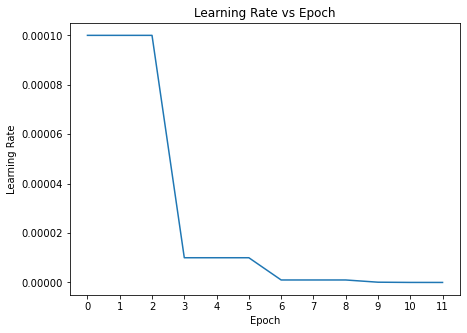

In [18]:
plot_learning_rate(history_dict)

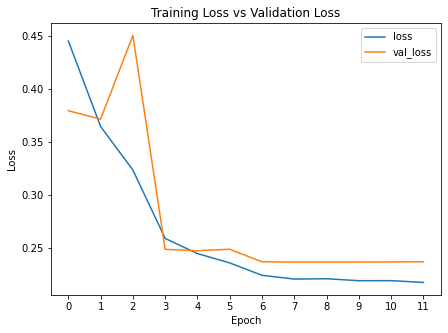

In [19]:
plot_metric(history_dict, 'loss')

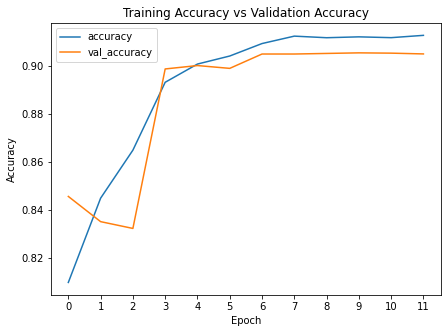

In [20]:
plot_metric(history_dict, 'accuracy')

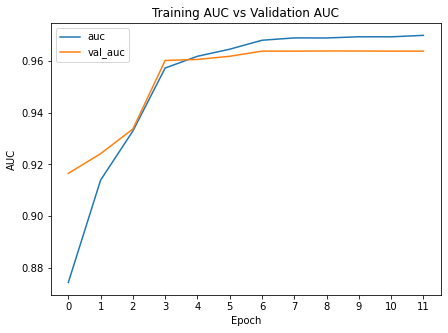

In [21]:
plot_metric(history_dict, 'auc')

---

## Calculate Performance on Test Set

In [22]:
test_metrics = model.evaluate(test_ds, verbose=1)
test_metrics = map_to_metrics(model.metrics_names, test_metrics)

  1/258 [..............................] - ETA: 21s - loss: 0.1823 - accuracy: 0.9375 - auc: 0.9805

 15/258 [>.............................] - ETA: 0s - loss: 0.2218 - accuracy: 0.9146 - auc: 0.9676 

 29/258 [==>...........................] - ETA: 0s - loss: 0.2464 - accuracy: 0.9009 - auc: 0.9607

 43/258 [====>.........................] - ETA: 0s - loss: 0.2410 - accuracy: 0.9012 - auc: 0.9627

 57/258 [=====>........................] - ETA: 0s - loss: 0.2407 - accuracy: 0.8964 - auc: 0.9632

 71/258 [=======>......................] - ETA: 0s - loss: 0.2467 - accuracy: 0.8944 - auc: 0.9614

 85/258 [========>.....................] - ETA: 0s - loss: 0.2427 - accuracy: 0.8960 - auc: 0.9625

 99/258 [==========>...................] - ETA: 0s - loss: 0.2414 - accuracy: 0.8961 - auc: 0.9627

113/258 [============>.................] - ETA: 0s - loss: 0.2425 - accuracy: 0.8952 - auc: 0.9623

127/258 [=============>................] - ETA: 0s - loss: 0.2413 - accuracy: 0.8954 - auc: 0.9628

141/258 [===============>..............] - ETA: 0s - loss: 0.2404 - accuracy: 0.8952 - auc: 0.9631

155/258 [=================>............] - ETA: 0s - loss: 0.2379 - accuracy: 0.8978 - auc: 0.9638

169/258 [==================>...........] - ETA: 0s - loss: 0.2401 - accuracy: 0.8968 - auc: 0.9629

183/258 [====================>.........] - ETA: 0s - loss: 0.2398 - accuracy: 0.8972 - auc: 0.9630

197/258 [=====================>........] - ETA: 0s - loss: 0.2412 - accuracy: 0.8967 - auc: 0.9627

211/258 [=======================>......] - ETA: 0s - loss: 0.2439 - accuracy: 0.8959 - auc: 0.9618

225/258 [=========================>....] - ETA: 0s - loss: 0.2438 - accuracy: 0.8957 - auc: 0.9620

239/258 [==========================>...] - ETA: 0s - loss: 0.2429 - accuracy: 0.8957 - auc: 0.9624

253/258 [============================>.] - ETA: 0s - loss: 0.2414 - accuracy: 0.8965 - auc: 0.9627

258/258 [==============================] - 1s 4ms/step - loss: 0.2423 - accuracy: 0.8965 - auc: 0.9624


In [23]:
# Save test metrics
json.dump(test_metrics, open(f"{model_output_dir}/{MODEL_NAME}/test_metrics.json", 'w'))

---